# Advertisement Click Propensity Model, with an additional Heuristic Investment Strategy Inferred from the model

### Challenge outline
Our client, XYZ Limited, have carried out an experiment, advertising their service for the last 2 weeks
across a wide variety of display ads within social, blog, and user content driven websites. Their CMO
(Chief Marketing Officer) now wants a recommendation as to a longer term, more focused, digital
investment strategy.

### Data
The file data.csv contains a sample of 10,000 rows of user activity from the client’s CDP (Consolidated
Data Platform), showing the number of impressions (defined in a marketing context as an ‘ad view’) per
site per user. Also joined to this data, is whether or not the user clicked on the ad, shown as 1 for a
successful click, and 0 otherwise. The data has some missing values which you will have to decide the best
way to handle. The Excel file Website Descriptions provides more data around the websites used, you may
wish to use this data to augment any analysis.

### Challenge specifics
You will need to perform some analysis on this data to make your investment strategy recommendation.
Care should be taken to ensure your analysis is both accurate and interpretable. You are free to use any
tool, package, coding language or system you see fit, but the work must be entirely your own.
Your final output will need to consist of the following:
- A prediction of clicks from a further 1,000 rows of user data in the file prediction.csv. Add a final
column with your 1/0 predictions as per the main file.
- A report of your findings and recommendations that should you present. The length of this is up to you, but should probably be somewhere between 10 to 20 minutes. This should be suitable for
XYZ Limited’s client media planning team, who are familiar with media terminology and
strategy, but have no statistical knowledge much beyond correlations. You should clearly
highlight your recommendations and findings, while offering confidence that your methodology
and results are robust.

### Assumptions and other information
You may assume the cost of every impression is the same, and you are strongly encouraged to note and
use the information that the client was able to secure a CPM (cost of media) equal to £2.85 per 1000
impressions, and that an average click is worth £8.42 to the client. You should state any other
assumptions you are making in your recommendation.

# Importa Data, Libraries and Functions

In [157]:
import warnings
from IPython.display import display
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform, loguniform
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, make_scorer, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, make_scorer, confusion_matrix, recall_score, f1_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [5]:
# originally 2.0.2
print(np.__version__)
# pip install --upgrade dask

1.26.4


In [6]:
from lightgbm import LGBMClassifier

In [7]:
def nullpc(dataset):
    print(f'{dataset.index.size} rows')
    return pd.DataFrame({'column': [i for i in dataset.columns], 'nullpc': [((dataset[i].isnull().sum())/(dataset[i].size))*100 for i in dataset.columns]})        

In [8]:
def zeropc(dataset):
    print(f'{dataset.index.size} rows')
    return pd.DataFrame({'column': [i for i in dataset.columns], 'zeropc': [(dataset[i].eq(0).sum()/(dataset[i].size))*100 for i in dataset.columns]})        

In [9]:
data = pd.read_csv(r'C:\Users\fshad\OneDrive\Documents\Data\Advertisment Propensity Click Model\data.csv')
prediction = pd.read_csv(r'C:\Users\fshad\OneDrive\Documents\Data\Advertisment Propensity Click Model\prediction.csv')
webdesc = pd.read_excel(r'C:\Users\fshad\OneDrive\Documents\Data\Advertisment Propensity Click Model\Website Descriptions.xlsx')

# Data Processing and Feature Engineering

In [10]:
# Checking Nulls

nulls = nullpc(data)
nulls[nulls['nullpc']>0]

10000 rows


Empty DataFrame
Columns: [column, nullpc]
Index: []

In [12]:
# Deal with the Error: value not found

data['Diigo'] = pd.to_numeric(data['Diigo'], errors='coerce')

In [15]:
# Deal with the 96 billion value that is clearly wrong

data.loc[7864,'Newsvine'] = np.nan

In [17]:
# check nulls again

nulls = nullpc(data)
nulls[nulls['nullpc']>0]

10000 rows


column  nullpc
11     Diigo    6.42
42  Newsvine    0.01

In [18]:
data = data.rename(columns={'Unnamed: 0':'id'})
data['impressions_total'] = data.iloc[:, 1:-1].sum(axis=1)
data['impressions_std'] = data.iloc[:, 1:-1].std(axis=1)

In [19]:
# list of site names

fields_o = ['Addthis',
 'Bebo',
 'Blogcatalog',
 'Blogger',
 'Buddymedia',
 'Cnet',
 'Conduit',
 'Customerlobby',
 'Delicious',
 'Digg',
 'Diigo',
 'Docs',
 'Docstoc',
 'Download',
 'Dropbox',
 'Drupal',
 'Epinions',
 'Evernote',
 'Facebook',
 'Faves',
 'Feedburner',
 'Flickr',
 'Foursquare',
 'Friendfeed',
 'Hootsuite',
 'Joomla',
 'Jumptags',
 'Kaboodle',
 'Kickapps',
 'Linkedin',
 'Lithium',
 'Livejournal',
 'Mashable',
 'Meetup',
 'Metacafe',
 'Mixx',
 'Mouthshut',
 'Multiply',
 'Mybloglog',
 'Myspace',
 'Netvibes',
 'Newsvine',
 'Ning',
 'Orkut',
 'Photobucket',
 'Ping',
 'Pinterest',
 'Plaxo',
 'Plurk',
 'Posterous',
 'Propeller',
 'Radian6',
 'Reddit',
 'Screencast',
 'Scribd',
 'Sharethis',
 'Slashdot',
 'Sliderocket',
 'Slideshare',
 'Squidoo',
 'Startaid',
 'Stumbleupon',
 'Sysomos',
 'Technorati',
 'Thisnext',
 'Tumblr',
 'Tweetdeck',
 'Twine',
 'Twitter',
 'Typepad',
 'Ubertwitter',
 'Viadeo',
 'Vimeo',
 'Vocus',
 'Wetpaint',
 'Wordpress',
 'Xanga',
 'Yelp',
 'Yfrog',
 'Youtube',
 'Yuku']

Pull through site description names

In [20]:
webdesc['Category'] = webdesc['Category'].str.strip()

In [21]:
data_unpivot = data.melt(id_vars='id',
                         value_vars=data.columns.difference(['id', 'Click']),
                         var_name='platform',
                         value_name='impressions'
                         )
data_unpivot

id           platform  impressions
0       dmp923122274            Addthis          0.0
1       dmp458034174            Addthis          0.0
2       dmp364043571            Addthis          0.0
3       dmp461339655            Addthis          0.0
4       dmp549691332            Addthis          0.0
...              ...                ...          ...
829995  dmp910305497  impressions_total         54.0
829996  dmp877506661  impressions_total         51.0
829997  dmp356452644  impressions_total         55.0
829998  dmp689019375  impressions_total         49.0
829999  dmp521609268  impressions_total         56.0

[830000 rows x 3 columns]

In [22]:
df_unpivot = pd.merge(data_unpivot, webdesc[['Name','Category']], left_on='platform', right_on='Name', how='left')

In [23]:
df = df_unpivot[['id','Category','impressions']].groupby(by=['id','Category']).agg(impressions_total=('impressions','sum'),
                                                                                   impressions_std=('impressions','std'))

In [24]:
#pivoted = 
df = df.pivot_table(
    index='id',
    columns='Category',
    values=['impressions_total', 'impressions_std']
)
df = df.reset_index()

In [25]:
# Un-nest column names

df.columns = [f"{col2}_{col1}" if col2 else f"{col1}" for col1, col2 in df.columns]

In [27]:
# df.columns
df = pd.merge(data, df, on='id', how='left')

In [28]:
# creating some fields, including forming groups of sites that are broader than categories
# these have broader common applications

df['distinct_site_count'] = (df[fields_o] > 0).sum(axis=1)
df['social_engagement_total'] = df['Social Bookmarking_impressions_total'] + df['Social Networking_impressions_total'] + df['Micro-Blogging_impressions_total'] + df['Foursquare'] + df['Conduit']
df['social_engagement_pc'] = df['social_engagement_total']/df['impressions_total']
df['media_sharing_total'] = df['Photo Sharing_impressions_total'] + df['Video Sharing_impressions_total']
df['media_sharing_pc'] = df['media_sharing_total']/df['impressions_total']
df['aggregations_and_analytics_total'] = df['Social Media Aggregator_impressions_total'] + df['User-Generated Content Aggregator_impressions_total'] + df['Social Media Measurement_impressions_total']
df['aggregations_and_analytics_pc'] = df['aggregations_and_analytics_total']/df['impressions_total']
df['information_total'] = df['Blog_impressions_total'] + df['News_impressions_total'] + df['Opinions Site_impressions_total']
df['information_pc'] = df['information_total']/df['impressions_total']
df['utilities_and_tools_total'] = df['Content / CMS_impressions_total'] + df['Documents_impressions_total'] + df['Opinions Site_impressions_total'] + df['Foursquare'] + df['Conduit'] + df['Feedburner']
df['utilities_and_tools_pc'] = df['utilities_and_tools_total']/df['impressions_total']

fields_sg = ['social_engagement_total','media_sharing_total', 'aggregations_and_analytics_total', 'information_total','utilities_and_tools_total']

df['distinct_group_count'] = (df[fields_sg] > 0).sum(axis=1)
df['group_entropy'] = df[fields_sg].div(df['impressions_total'], axis=0).fillna(0).apply(lambda row: entropy(row, base=2), axis=1)


In [29]:
# Test train split

X = df.drop(['Click','id'], axis=1)
y = df['Click']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [30]:
# list of sites by their percentage of all impressions

imp_pc = pd.DataFrame({i:float(X_train[i].sum()) for i in fields_o}, index=[0])
imp_pc = imp_pc.div(imp_pc.sum(axis=1).values[0])
imp_pc = imp_pc.transpose()
imp_pc = imp_pc.rename(columns={0:'all_impressions_pc'})
imp_pc[imp_pc['all_impressions_pc']>=0.015].sort_values('all_impressions_pc', ascending=False).shape[0]
# ex1

20

Entropy could be useful, but we remove sites with too few impressions so entropy can be more useful

In [32]:
fields_entropy = list(imp_pc[imp_pc['all_impressions_pc']>=0.015].sort_values('all_impressions_pc', ascending=False).index)
fields_entropy_disc = list(imp_pc[imp_pc['all_impressions_pc']<0.015].sort_values('all_impressions_pc', ascending=False).index)
X_train['entropy_other_impressions'] = X_train[fields_entropy_disc].sum(axis=1)
X_test['entropy_other_impressions'] = X_test[fields_entropy_disc].sum(axis=1)
fields_entropy.append('entropy_other_impressions')

In [33]:
X_train['site_entropy'] = X_train[fields_entropy].div(X_train['impressions_total'], axis=0).fillna(0).apply(lambda row: entropy(row, base=2), axis=1)
X_test['site_entropy'] = X_test[fields_entropy].div(X_test['impressions_total'], axis=0).fillna(0).apply(lambda row: entropy(row, base=2), axis=1)

In [35]:
# columns that ever have the most impressions for any row

top_imp_cols = list(X_train[fields_o].idxmax(axis=1).unique())

In [36]:
# creating flags for when each site has the most impressions

for i in top_imp_cols:
    X_train[f"{i}_topcol_flag"] = (X_train[i] == X_train[fields_o].max(axis=1)).astype(int)
    X_test[f"{i}_topcol_flag"] = (X_test[i] == X_test[fields_o].max(axis=1)).astype(int)

X_train['most_impressions_value'] = X_train[fields_o].max(axis=1)
X_test['most_impressions_value'] = X_test[fields_o].max(axis=1)

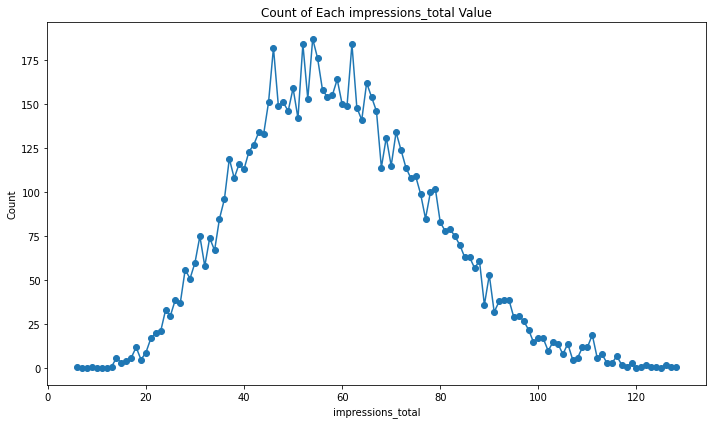

In [37]:
# looking to set the thresholds for light and heavy users by plotting the distribution of total impressions

counts = X_train['impressions_total'].value_counts().sort_index()
full_index = np.arange(counts.index.min(), counts.index.max()+1)
counts_full = counts.reindex(full_index).fillna(0)

plt.figure(figsize=(10, 6))
plt.plot(counts_full.index, counts_full.values, marker='o', linestyle='-')
plt.xlabel('impressions_total')
plt.ylabel('Count')
plt.title('Count of Each impressions_total Value')
plt.tight_layout()
plt.show()

In [38]:
np.percentile(X_train['impressions_total'], 95)

92.0

In [39]:
np.percentile(X_train['impressions_total'], 5)

30.0

In [40]:
# now creating those fields along with fields that tell us how many fields are tied for most impressions
# and logarithmic total impressions in case that is better at picking up trends

heavy_user_threshold = X_train['impressions_total'].quantile(0.95)
heavy_user_threshold_test = X_test['impressions_total'].quantile(0.95)

light_user_threshold = X_train['impressions_total'].quantile(0.05)
light_user_threshold_test = X_test['impressions_total'].quantile(0.05)

X_train['heavy_user_flag'] = (X_train['impressions_total'] > heavy_user_threshold).astype(int)
X_test['heavy_user_flag'] = (X_test['impressions_total'] > heavy_user_threshold_test).astype(int)

X_train['light_user_flag'] = (X_train['impressions_total'] < light_user_threshold).astype(int)
X_test['light_user_flag'] = (X_test['impressions_total'] < light_user_threshold_test).astype(int)

X_train['top_site_tie_count'] = (X_train[fields_o] == X_train[fields_o].max(axis=1).to_numpy()[:, None]).sum(axis=1)
X_test['top_site_tie_count'] = (X_test[fields_o] == X_test[fields_o].max(axis=1).to_numpy()[:, None]).sum(axis=1)

X_train['log2_impressions'] = np.log2(X_train['impressions_total'])
X_test['log2_impressions'] = np.log2(X_test['impressions_total'])

# Exploratory Data Analysis

In [45]:
# all filled
y.isna().astype('int').sum()

0

In [46]:
# only 1s and 0s
y.unique()

array([0, 1], dtype=int64)

In [47]:
# 12.3% are a 1
y.mean()

0.1234

In [48]:
# same for y_train
y_train.mean()

0.123375

Looking to see which fields to drop because too many rows are 0s

In [49]:
zeros = zeropc(X_train)
zeros.sort_values('zeropc', ascending=False).head(50)

8000 rows


column    zeropc
4                 Buddymedia  100.0000
157         Mixx_topcol_flag   99.9875
162        Plurk_topcol_flag   99.9875
155   Technorati_topcol_flag   99.9875
7              Customerlobby   99.9750
159    Delicious_topcol_flag   99.9625
163   Friendfeed_topcol_flag   99.9625
141      Addthis_topcol_flag   99.9625
164      Squidoo_topcol_flag   99.9625
152       Reddit_topcol_flag   99.9500
156       Drupal_topcol_flag   99.9500
161        Xanga_topcol_flag   99.9500
144  Blogcatalog_topcol_flag   99.9000
145       Tumblr_topcol_flag   99.9000
158         Yelp_topcol_flag   99.8875
139      Dropbox_topcol_flag   99.8750
149       Joomla_topcol_flag   99.8625
160  Stumbleupon_topcol_flag   99.8500
154       Scribd_topcol_flag   99.8375
148         Bebo_topcol_flag   99.8250
70               Ubertwitter   99.8250
147     Multiply_topcol_flag   99.7500
11                      Docs   99.6750
129    Hootsuite_topcol_flag   99.5875
135      Typepad_topcol_flag   99.5375
153     Download_topcol_flag   99.3875
150     Metacafe_topcol_flag   99.3250
146        Orkut_topcol_flag   99.1375
140         Digg_topcol_flag   99.0250
143         Ning_topcol_flag   98.8250
67                     Twine   98.3625
30                   Lithium   98.1625
142     Linkedin_topcol_flag   98.0250
151  Livejournal_topcol_flag   97.9875
55                 Sharethis   97.9875
60                  Startaid   97.9125
134    Pinterest_topcol_flag   97.6250
137         Cnet_topcol_flag   97.2875
136       Flickr_topcol_flag   96.8625
128  Photobucket_topcol_flag   96.7000
133      Conduit_topcol_flag   96.0375
73                     Vocus   95.7000
167          light_user_flag   95.6000
28                  Kickapps   95.5875
62                   Sysomos   95.4375
138    Wordpress_topcol_flag   95.1750
166          heavy_user_flag   95.1000
71                    Viadeo   93.8250
26                  Jumptags   93.5500
126      Twitter_topcol_flag   93.1625

In [50]:
zeros[zeros['column'].str[-12:]=='_topcol_flag'].sort_values('zeropc', ascending=False)

column   zeropc
162        Plurk_topcol_flag  99.9875
157         Mixx_topcol_flag  99.9875
155   Technorati_topcol_flag  99.9875
164      Squidoo_topcol_flag  99.9625
141      Addthis_topcol_flag  99.9625
163   Friendfeed_topcol_flag  99.9625
159    Delicious_topcol_flag  99.9625
161        Xanga_topcol_flag  99.9500
156       Drupal_topcol_flag  99.9500
152       Reddit_topcol_flag  99.9500
144  Blogcatalog_topcol_flag  99.9000
145       Tumblr_topcol_flag  99.9000
158         Yelp_topcol_flag  99.8875
139      Dropbox_topcol_flag  99.8750
149       Joomla_topcol_flag  99.8625
160  Stumbleupon_topcol_flag  99.8500
154       Scribd_topcol_flag  99.8375
148         Bebo_topcol_flag  99.8250
147     Multiply_topcol_flag  99.7500
129    Hootsuite_topcol_flag  99.5875
135      Typepad_topcol_flag  99.5375
153     Download_topcol_flag  99.3875
150     Metacafe_topcol_flag  99.3250
146        Orkut_topcol_flag  99.1375
140         Digg_topcol_flag  99.0250
143         Ning_topcol_flag  98.8250
142     Linkedin_topcol_flag  98.0250
151  Livejournal_topcol_flag  97.9875
134    Pinterest_topcol_flag  97.6250
137         Cnet_topcol_flag  97.2875
136       Flickr_topcol_flag  96.8625
128  Photobucket_topcol_flag  96.7000
133      Conduit_topcol_flag  96.0375
138    Wordpress_topcol_flag  95.1750
126      Twitter_topcol_flag  93.1625
130      Myspace_topcol_flag  89.5250
132      Blogger_topcol_flag  89.3750
127     Facebook_topcol_flag  74.6125
131      Youtube_topcol_flag  74.3125

In [51]:
zeros[zeros['column'].str[-12:]!='_topcol_flag'].sort_values('zeropc', ascending=False).head(10)

column    zeropc
4         Buddymedia  100.0000
7      Customerlobby   99.9750
70       Ubertwitter   99.8250
11              Docs   99.6750
67             Twine   98.3625
30           Lithium   98.1625
55         Sharethis   97.9875
60          Startaid   97.9125
73             Vocus   95.7000
167  light_user_flag   95.6000

In [52]:
# these columns do not have enough non-zero rows for a model to capture meaningful trends
# at least 100 non-zero columns needed for continuous and at least 200 for binary fields to find a trend

topcol_flag_omit = list(zeros[(zeros['column'].str[-12:]=='_topcol_flag') & (zeros['zeropc']>=98)]['column'])
topcol_flag_keep = list(zeros[(zeros['column'].str[-12:]=='_topcol_flag') & (zeros['zeropc']<98)]['column'])
imp_count_omit = list(zeros[(zeros['column'].str[-12:]!='_topcol_flag') & (zeros['zeropc']>=99)]['column'])

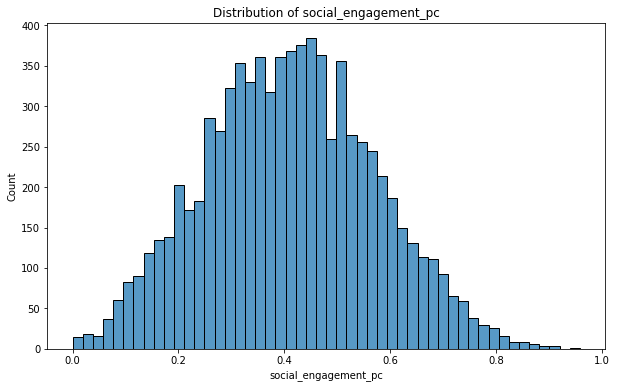

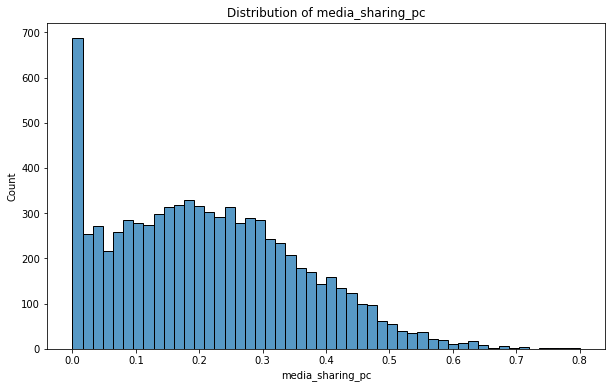

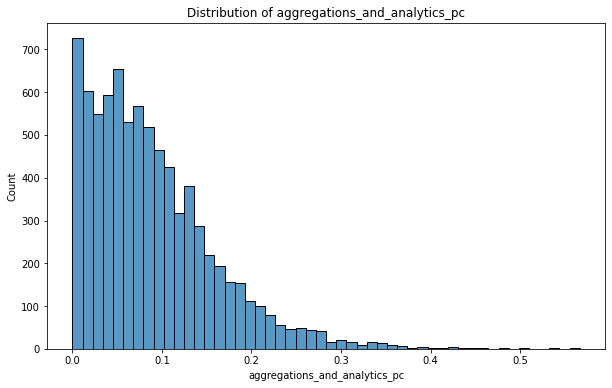

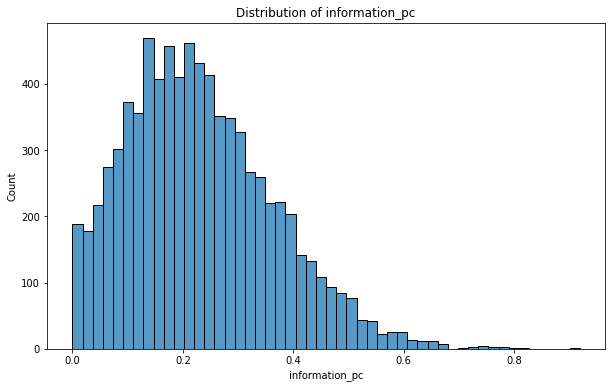

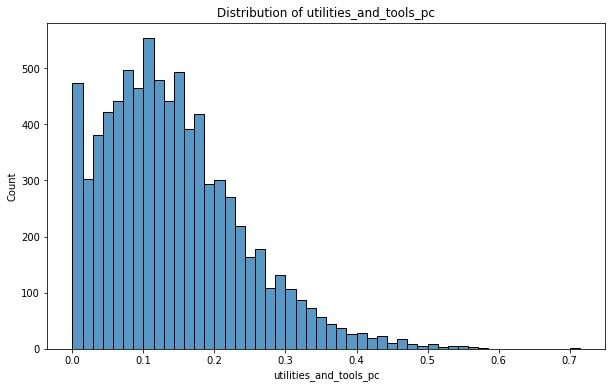

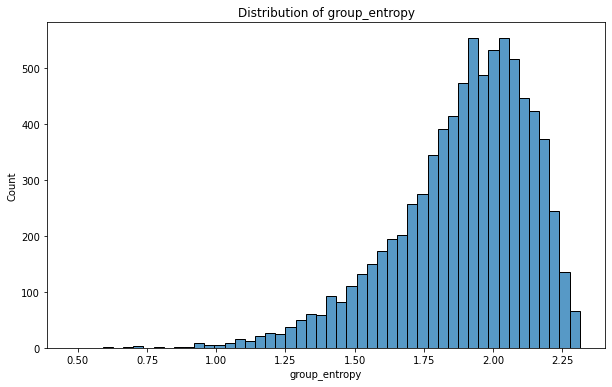

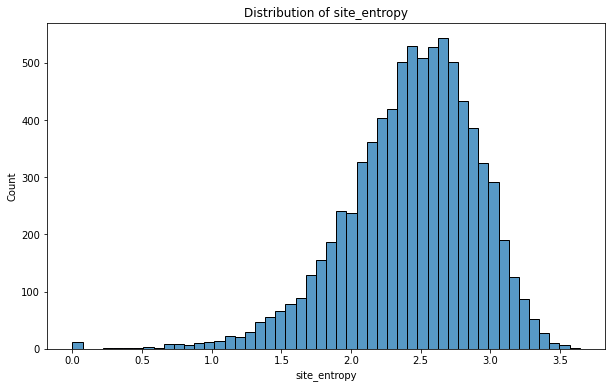

In [53]:
# We can see suffient variation in values for our percentage and entropy fields

for i in X_train.columns:
    if i[-2:] == 'pc' or i[-7:] == 'entropy':
        plt.figure(figsize=(10, 6))
        sns.histplot(X_train[i], bins=50)
        plt.title(f'Distribution of {i}')
        plt.show()

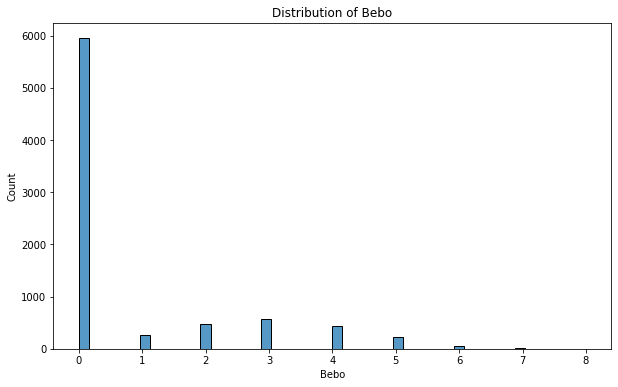

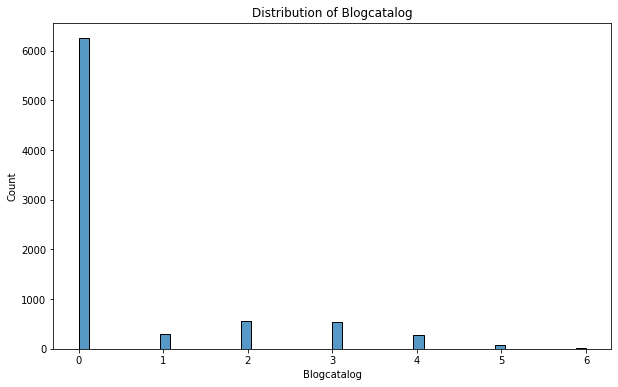

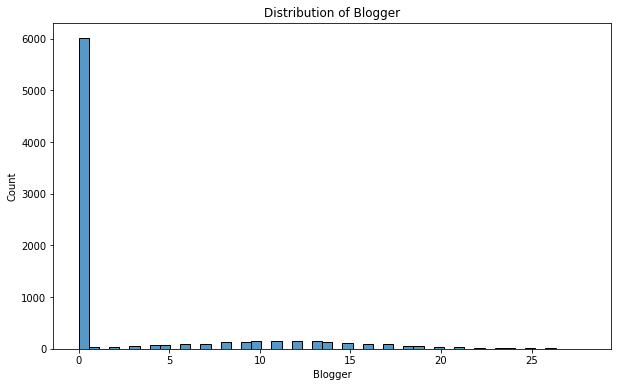

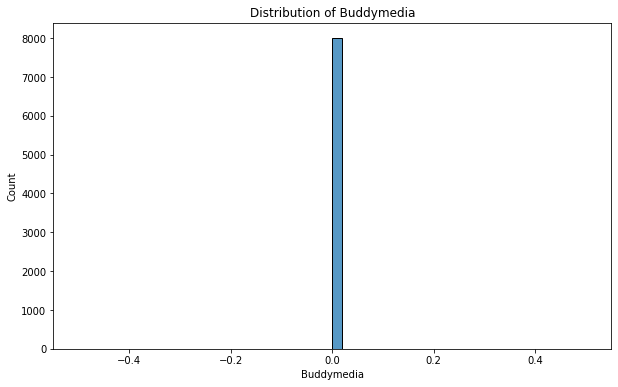

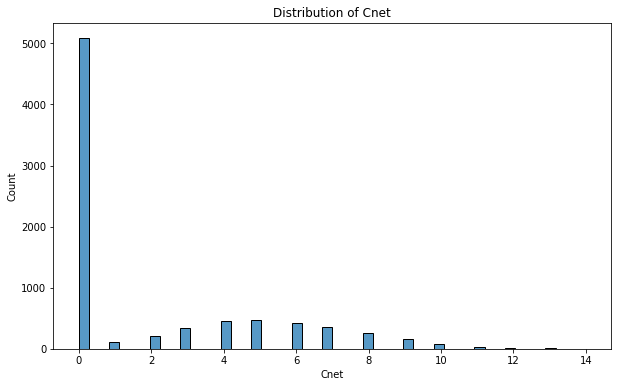

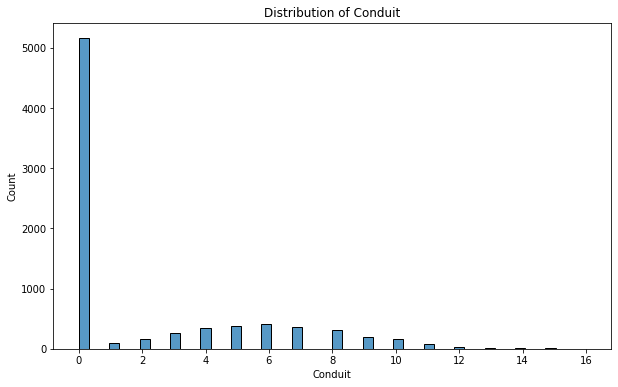

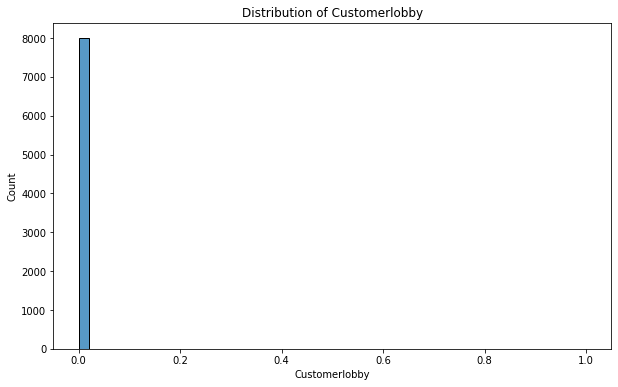

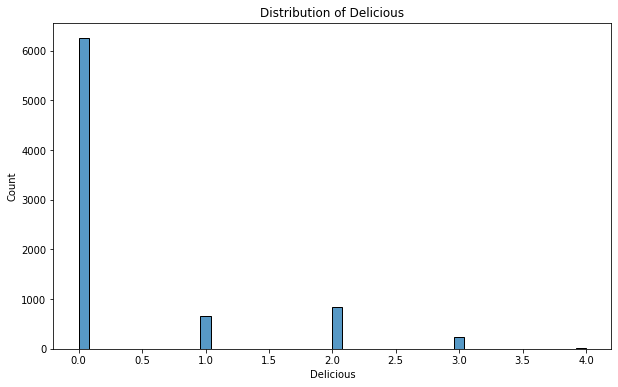

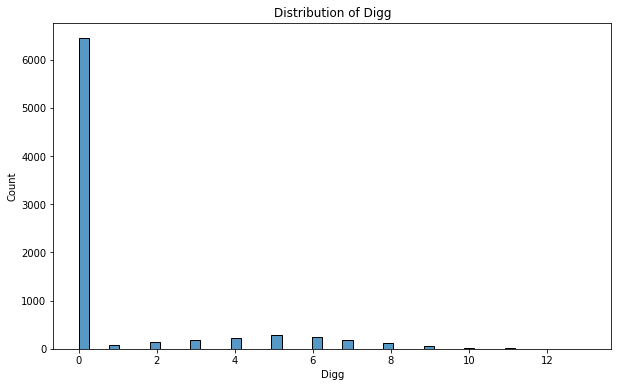

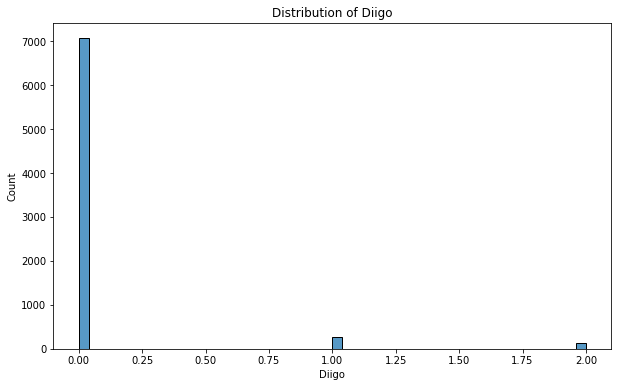

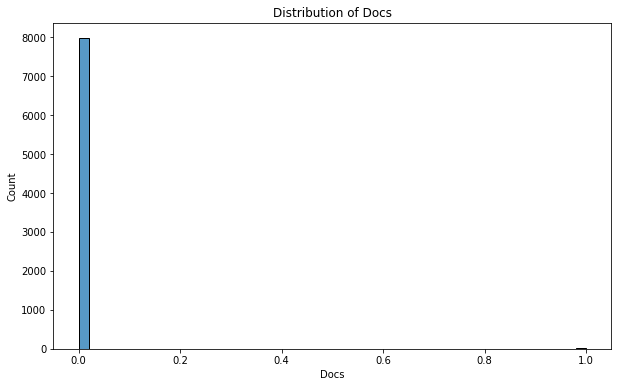

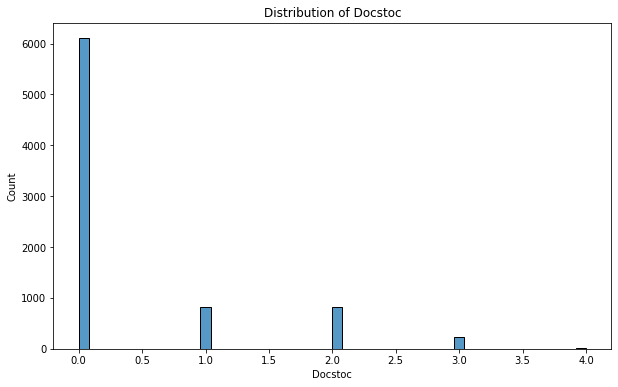

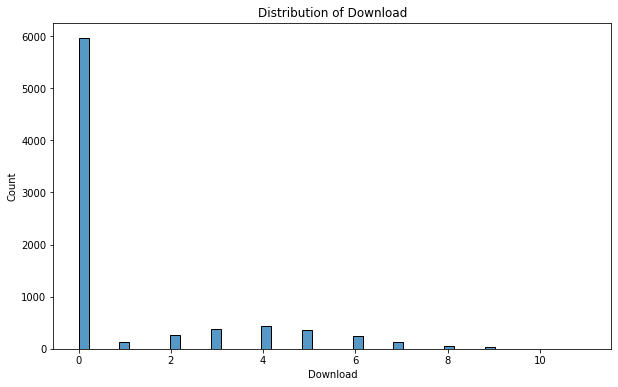

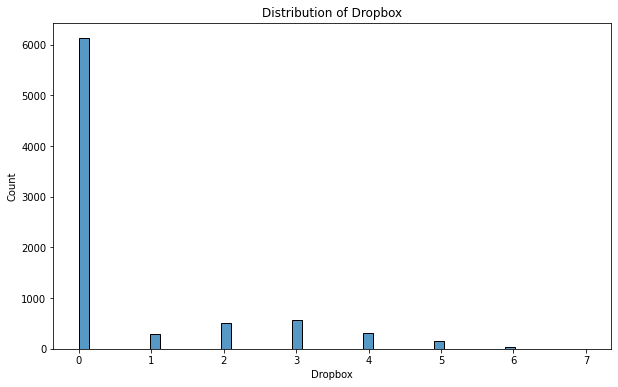

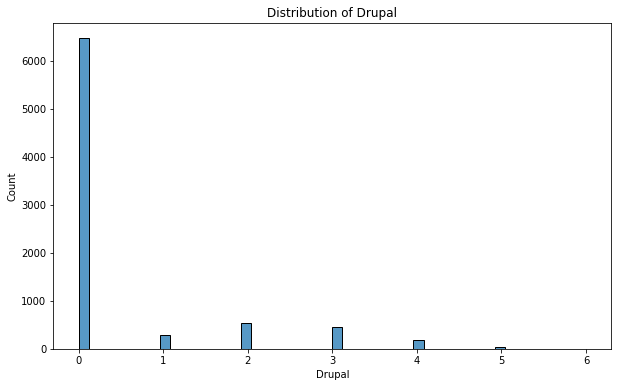

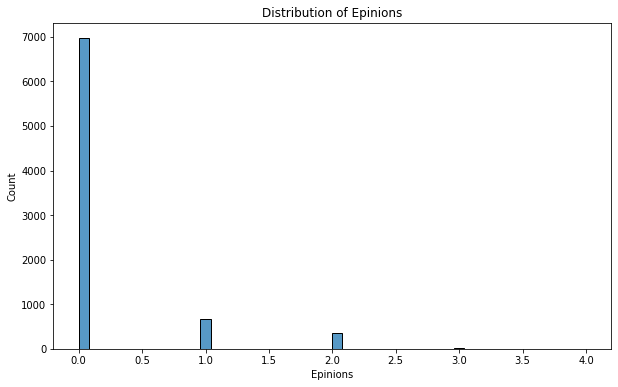

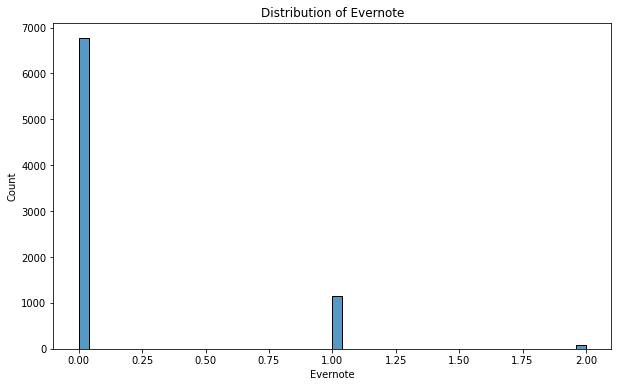

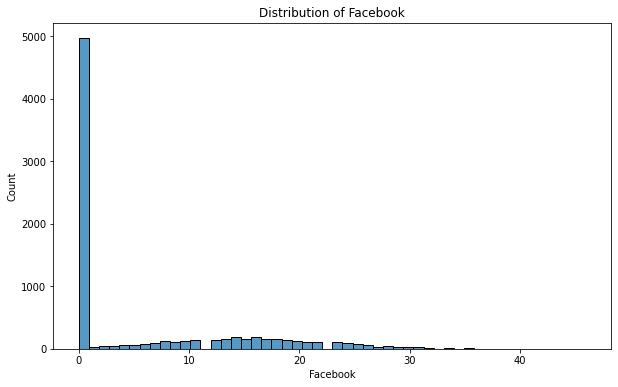

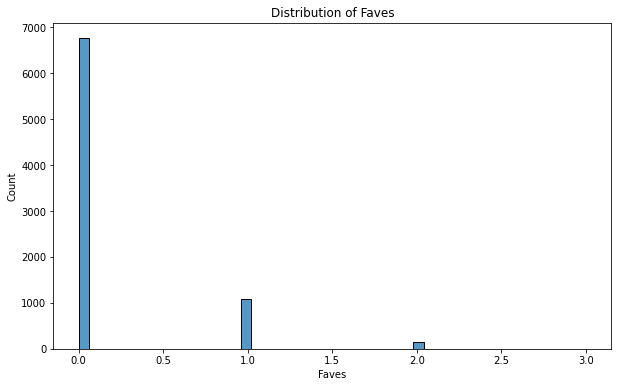

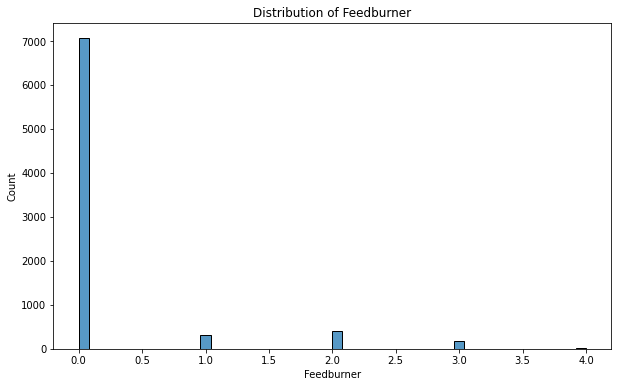

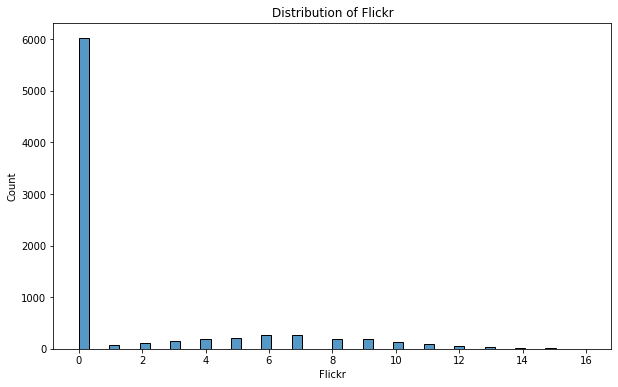

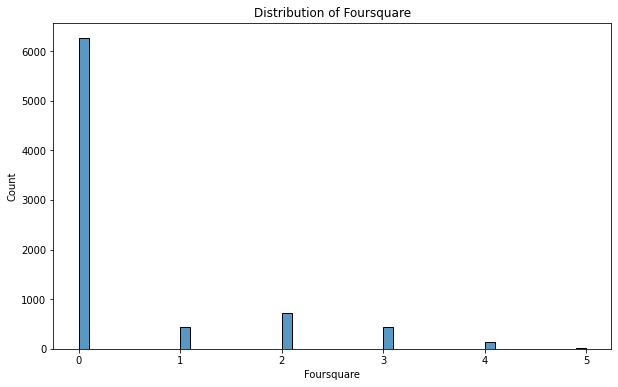

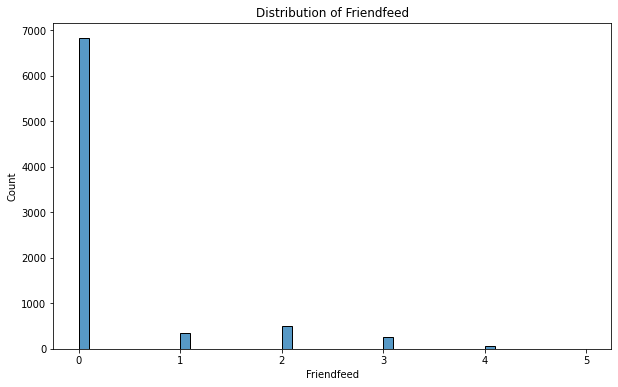

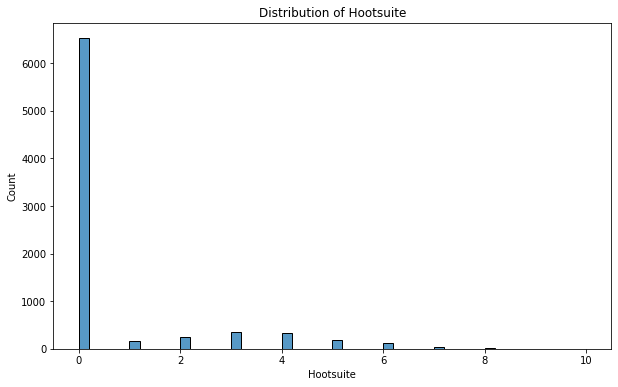

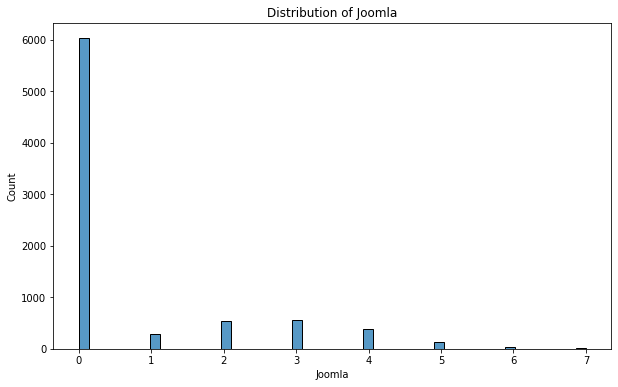

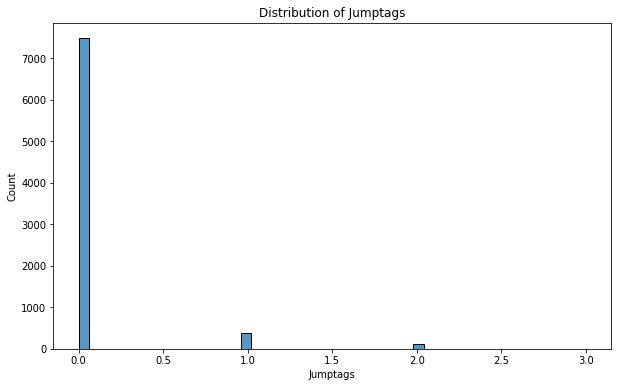

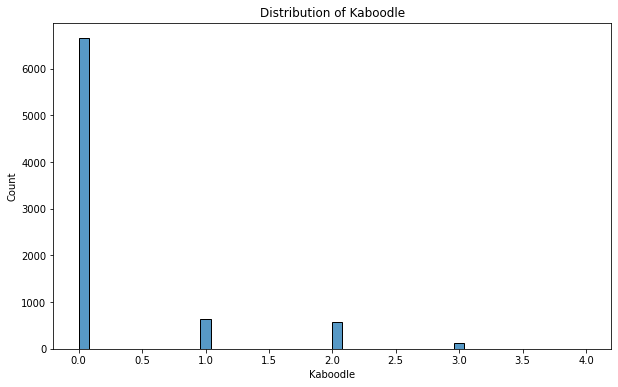

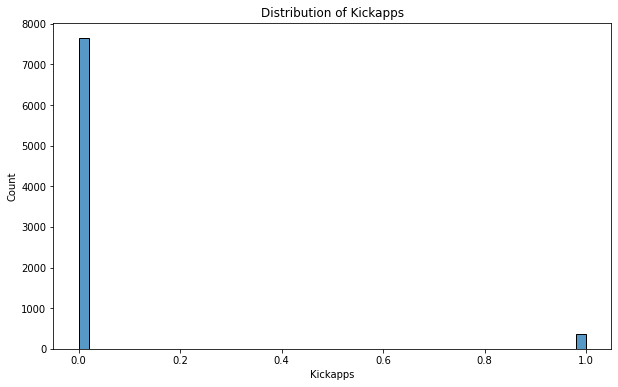

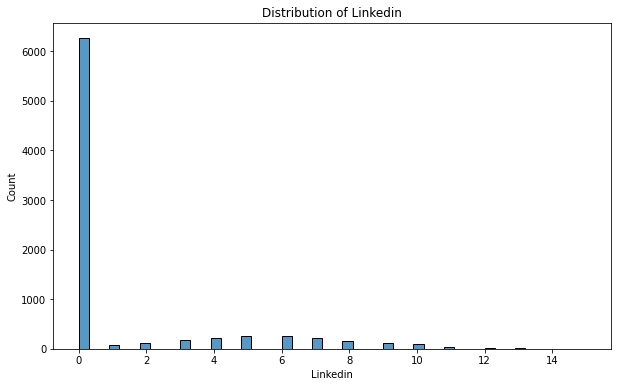

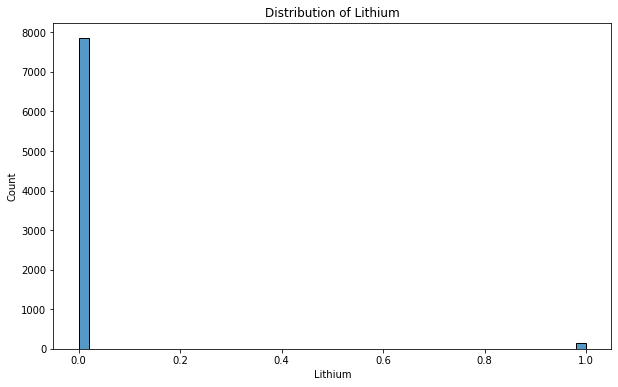

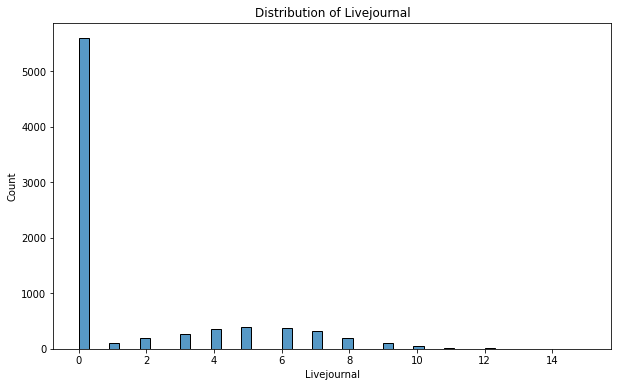

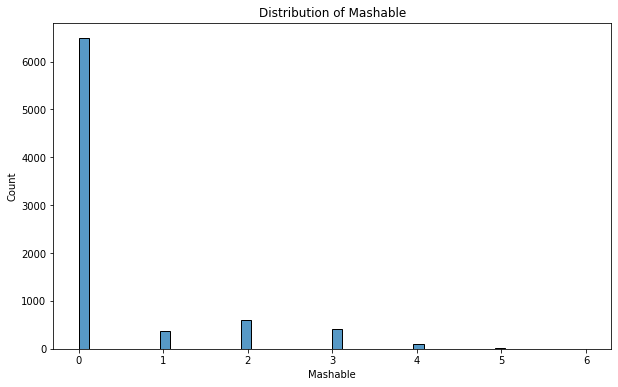

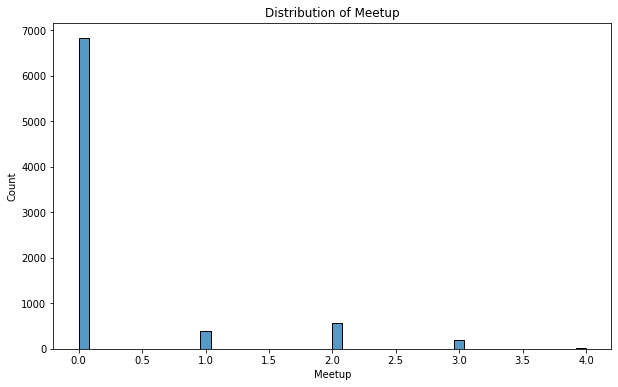

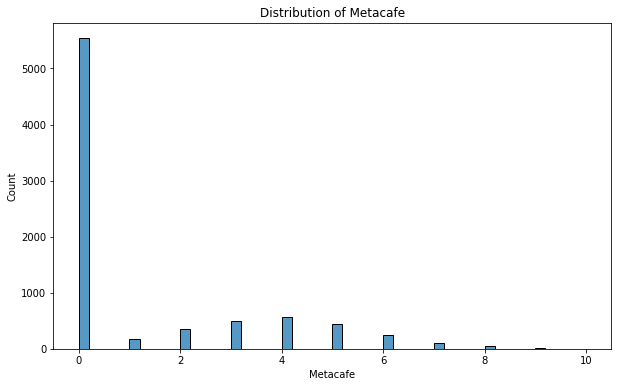

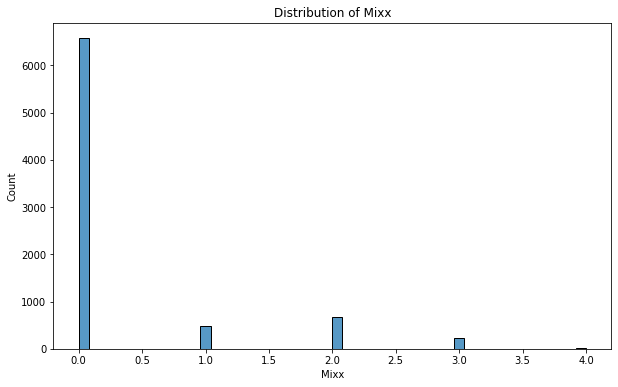

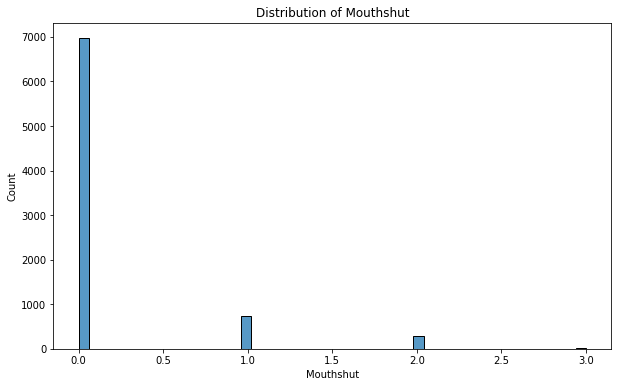

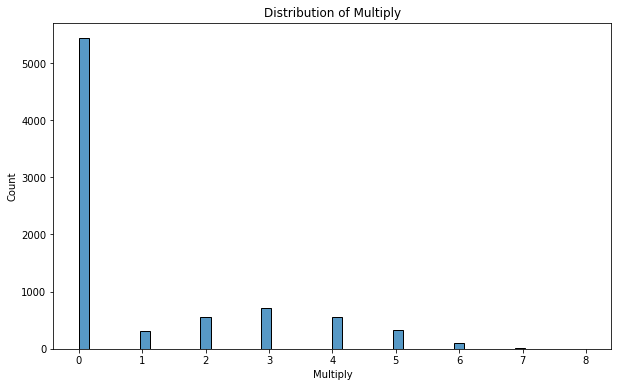

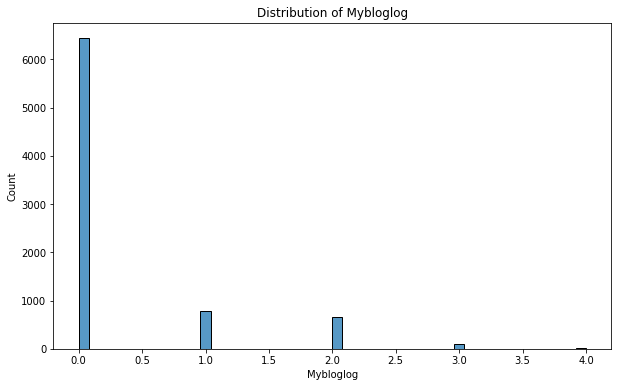

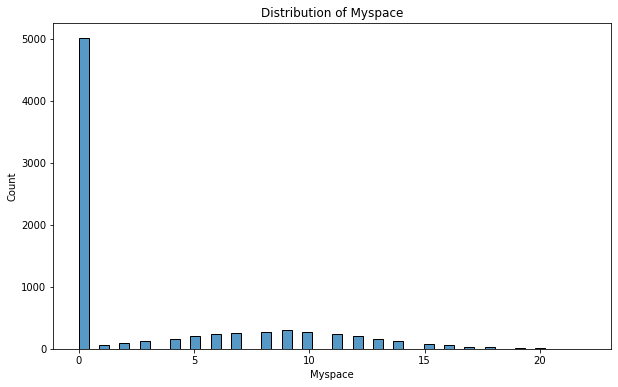

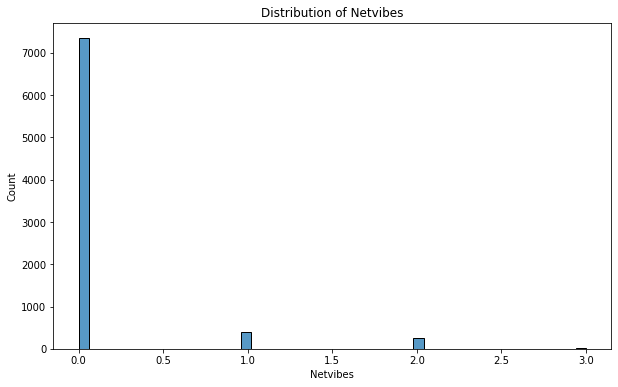

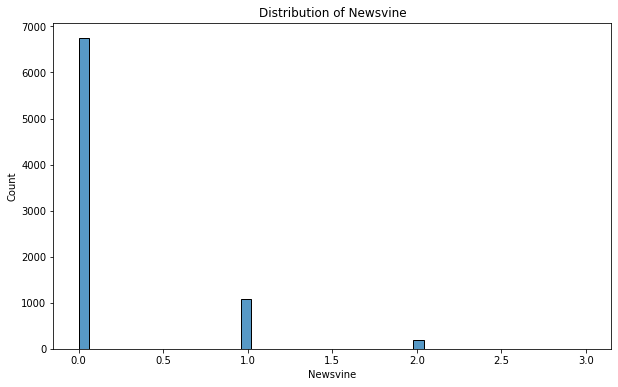

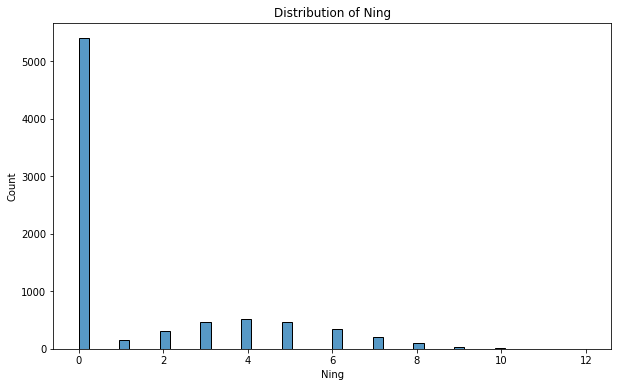

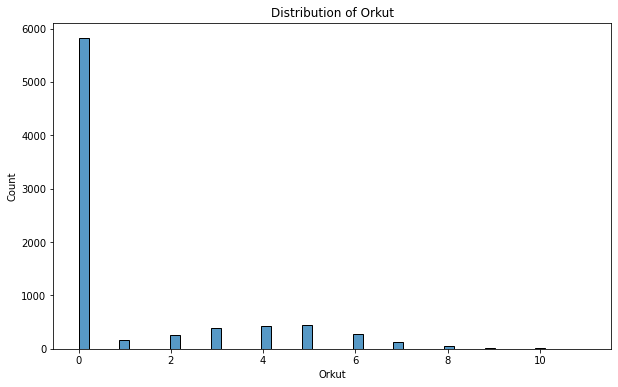

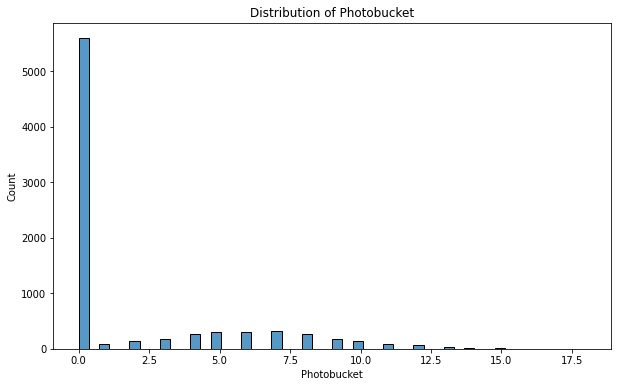

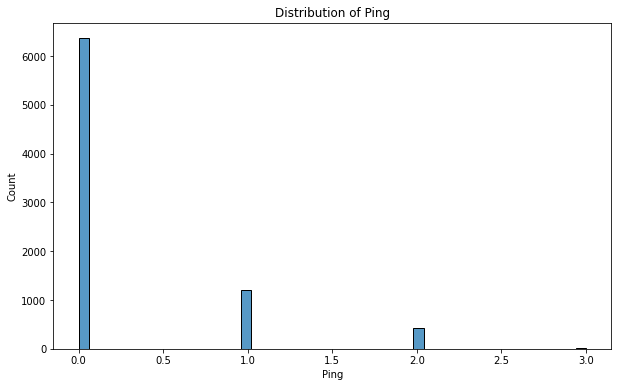

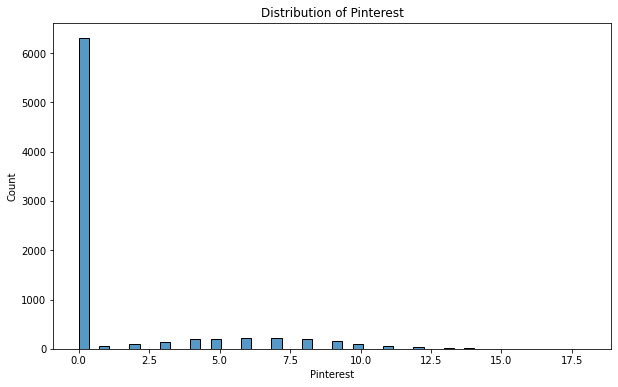

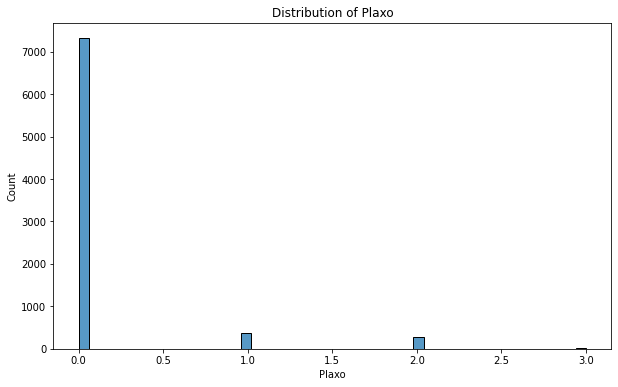

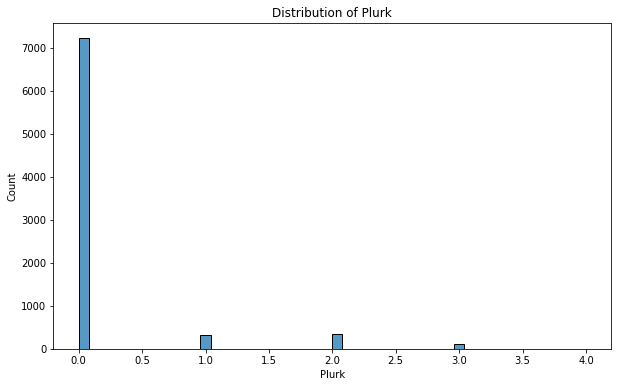

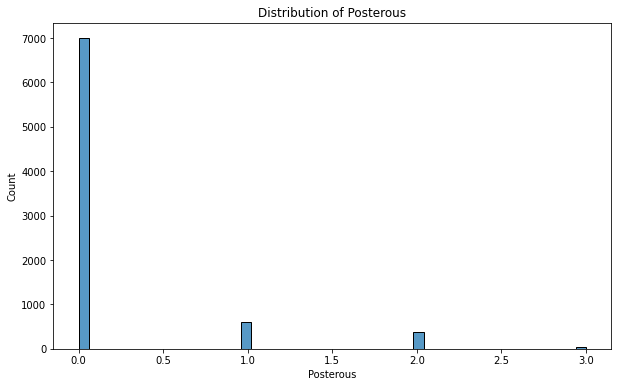

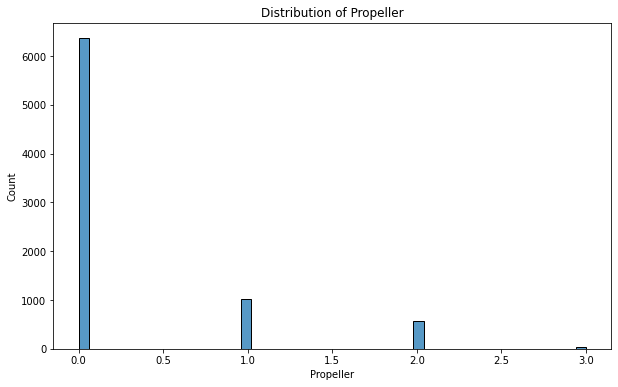

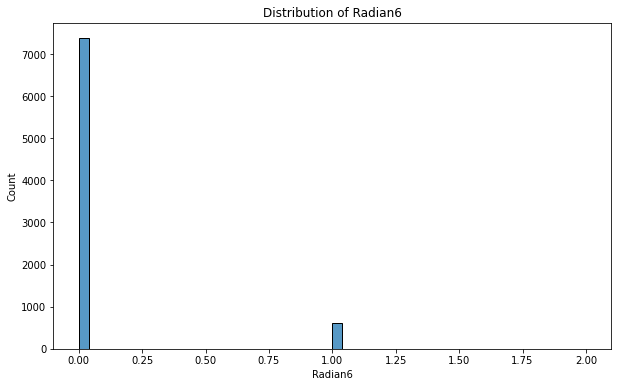

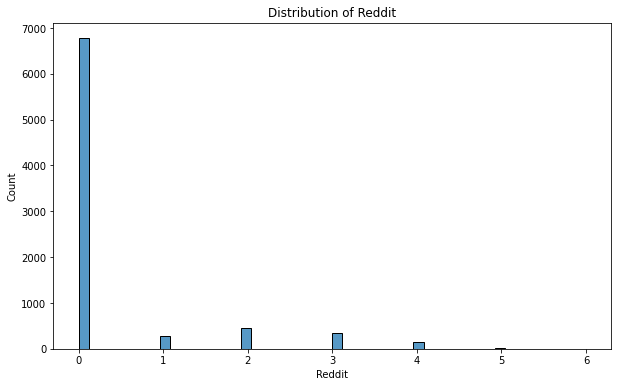

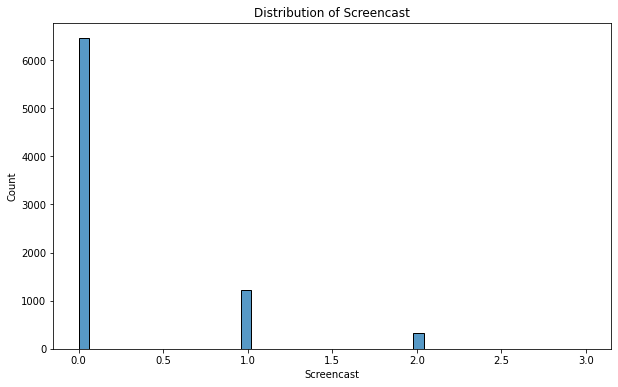

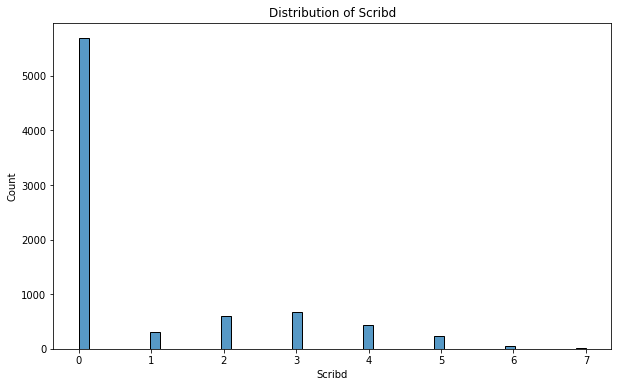

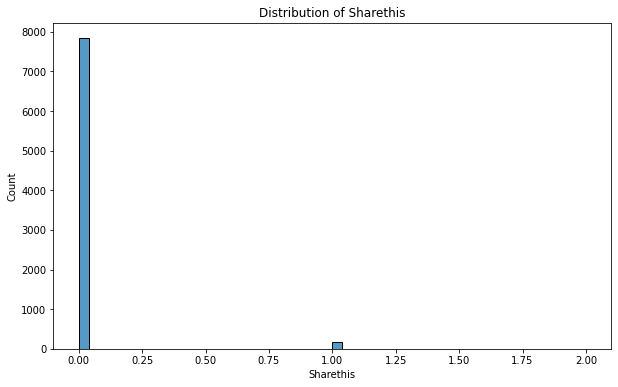

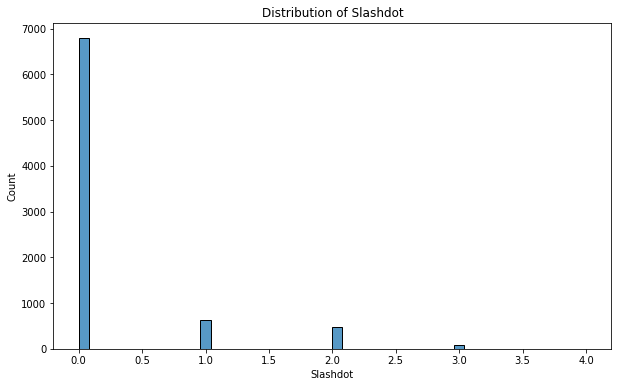

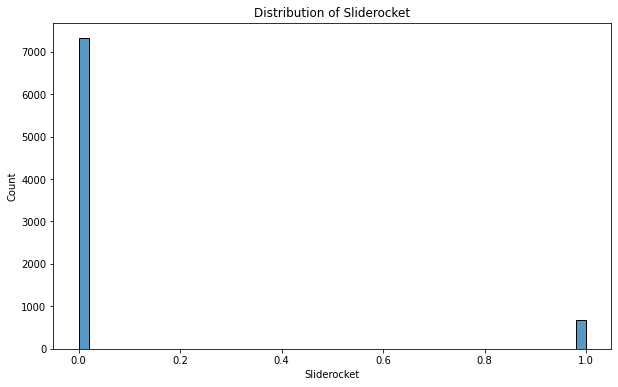

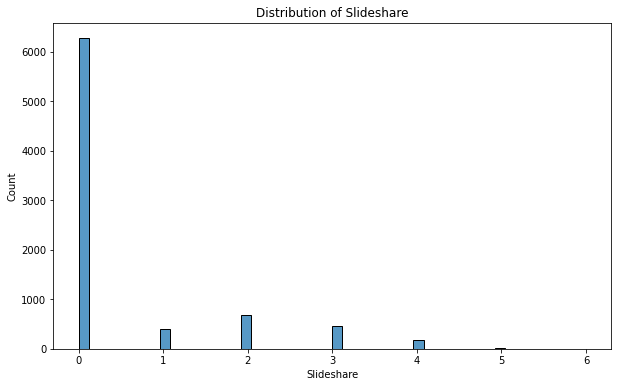

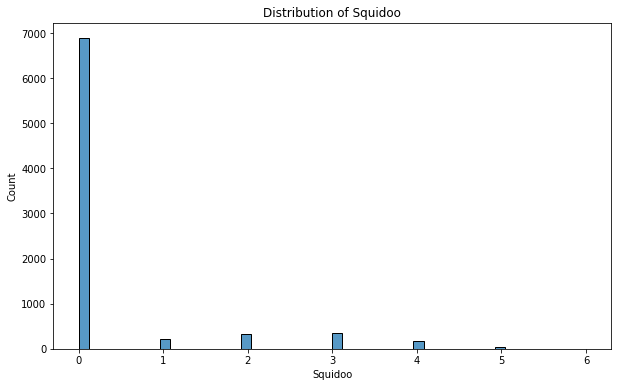

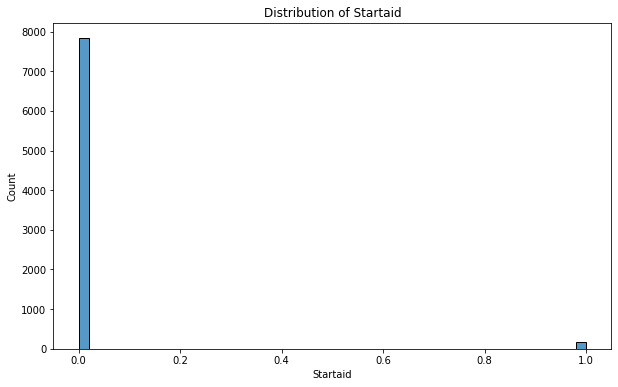

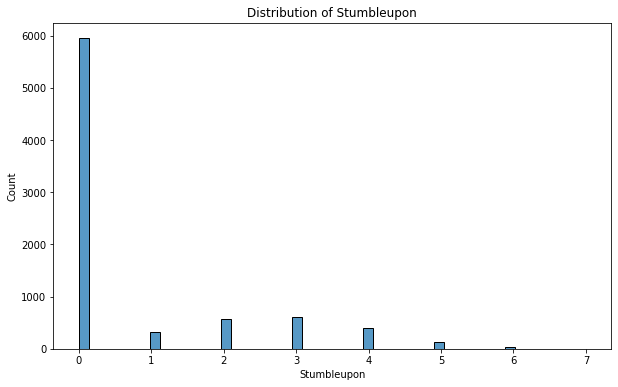

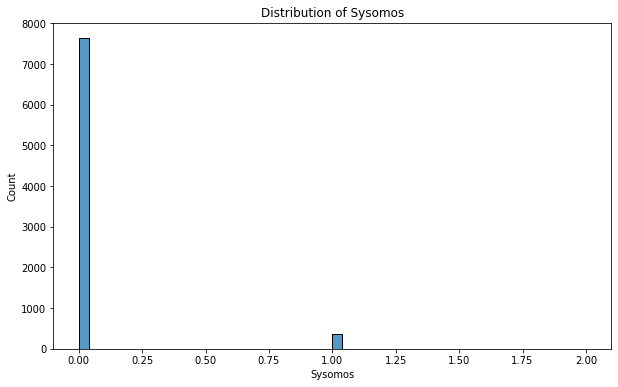

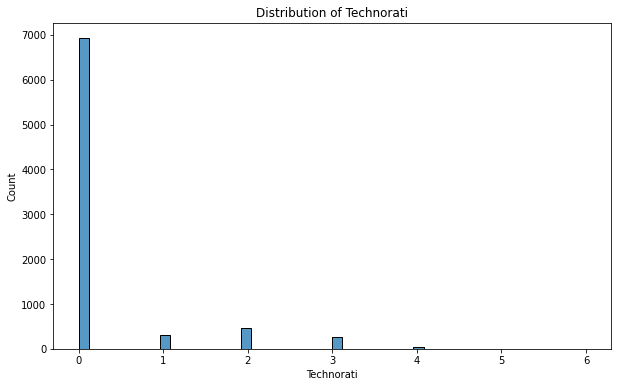

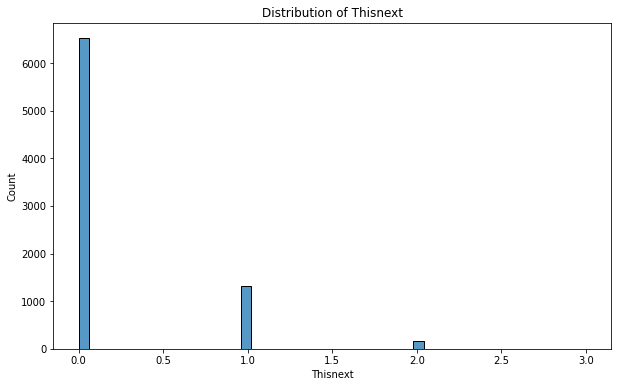

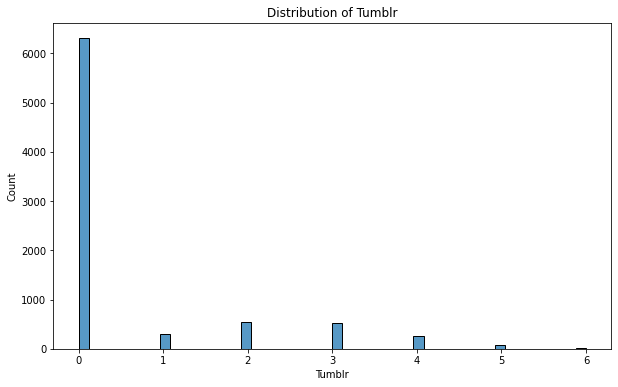

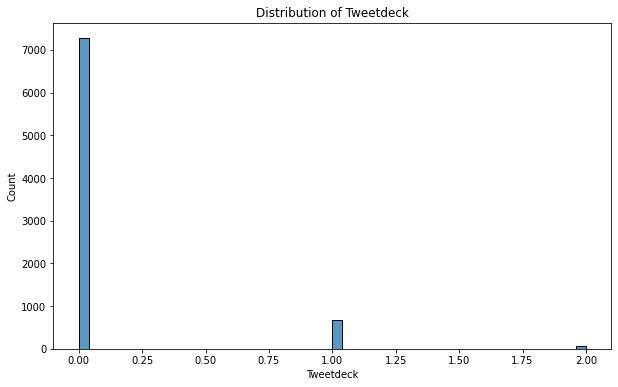

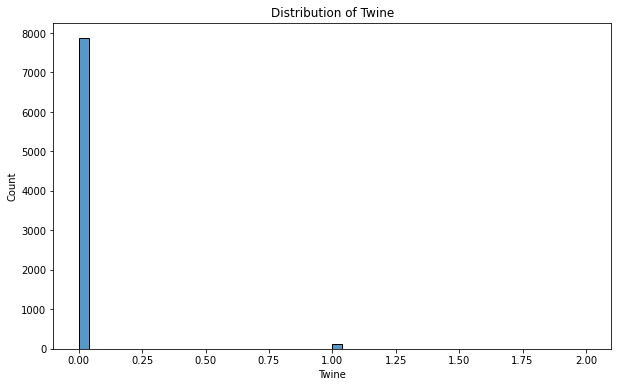

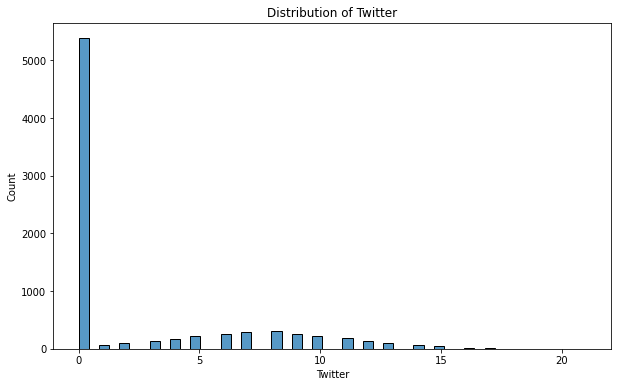

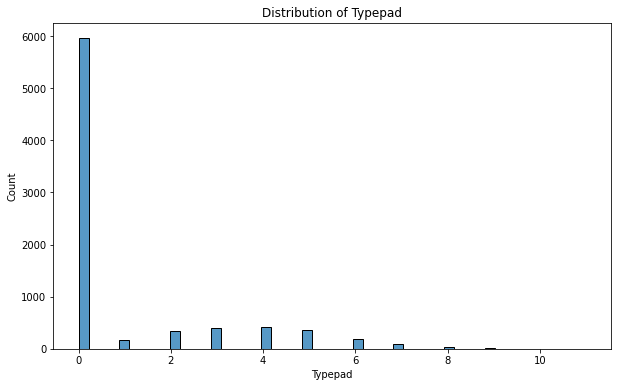

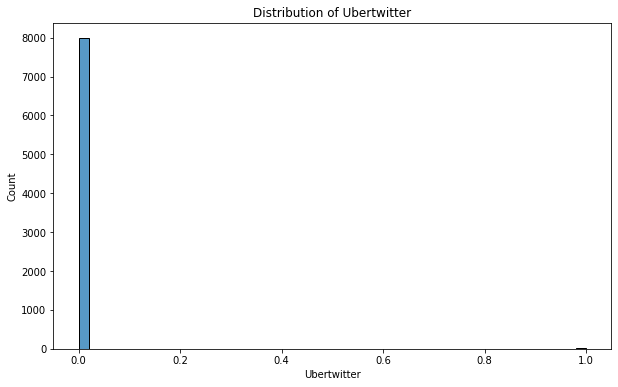

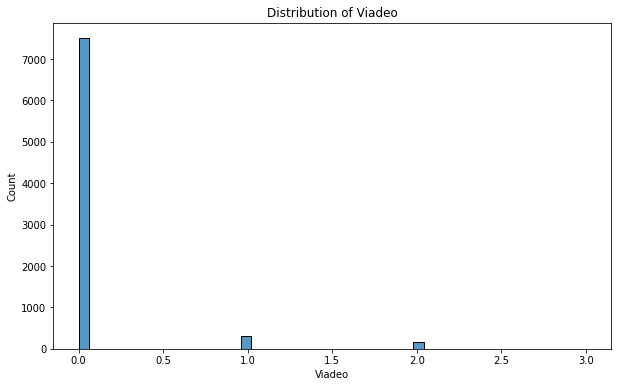

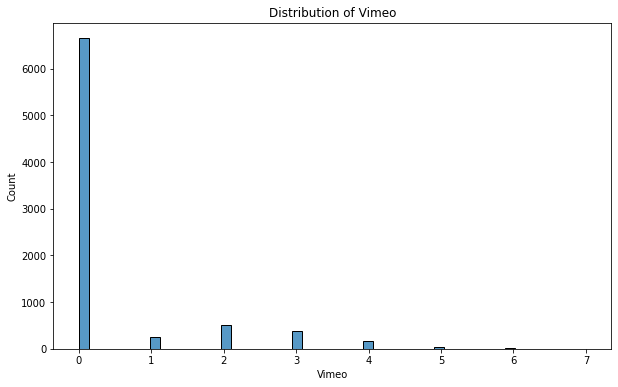

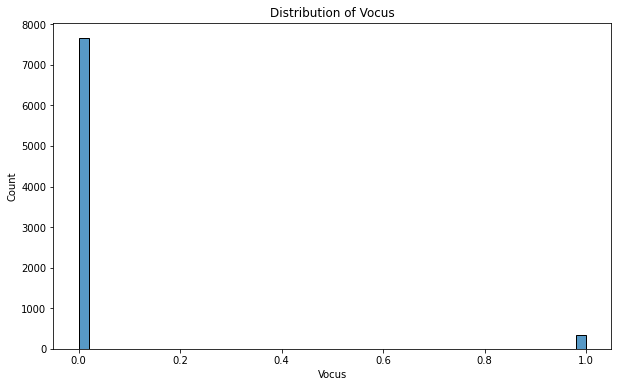

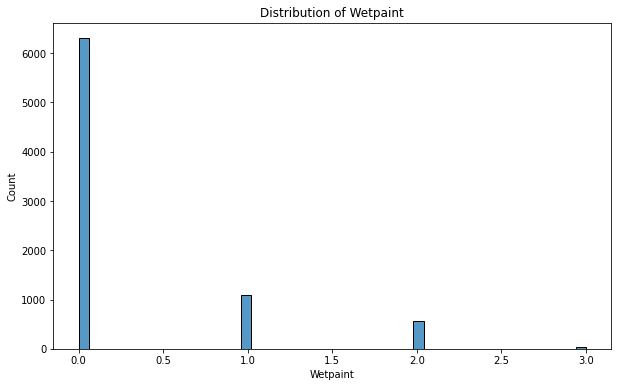

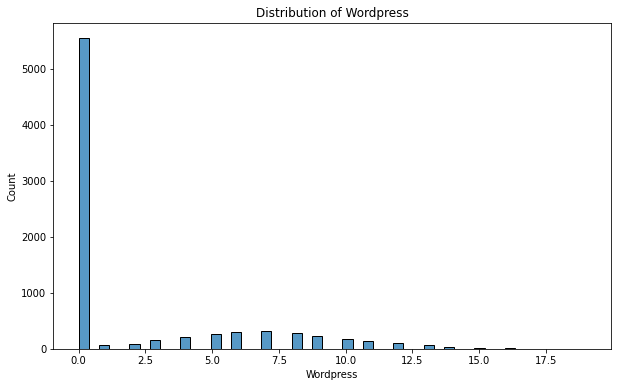

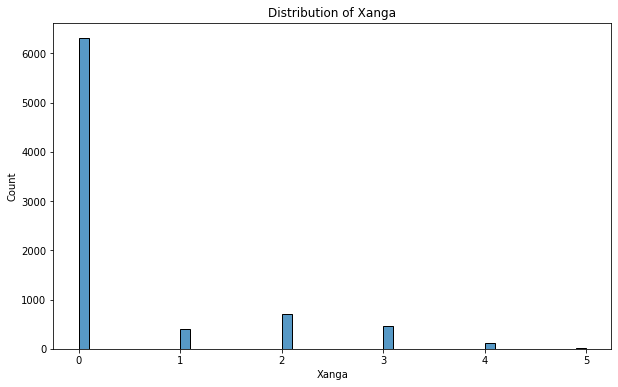

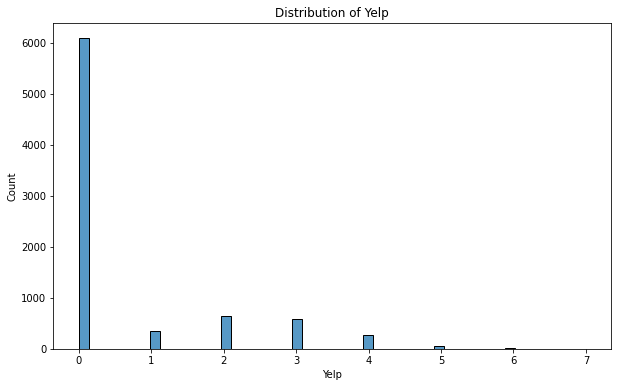

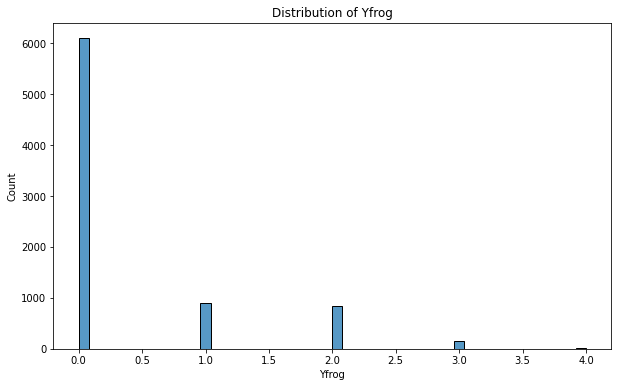

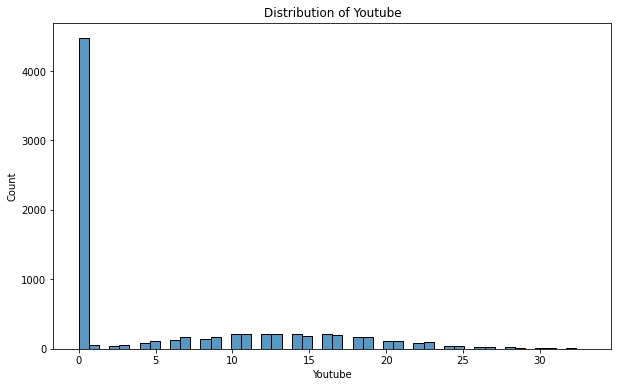

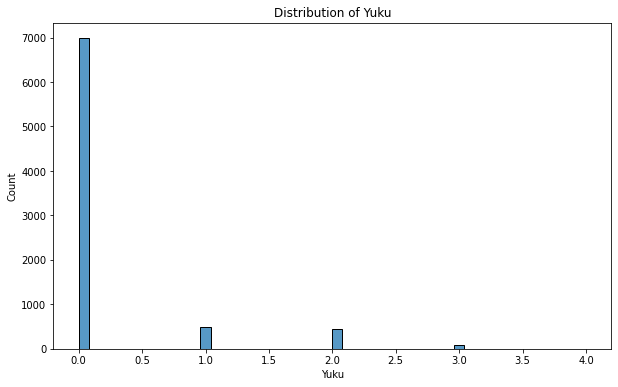

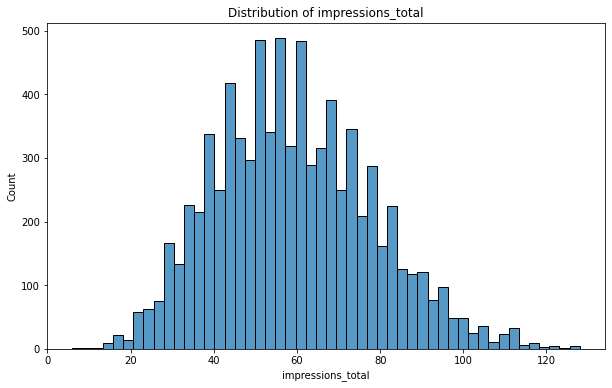

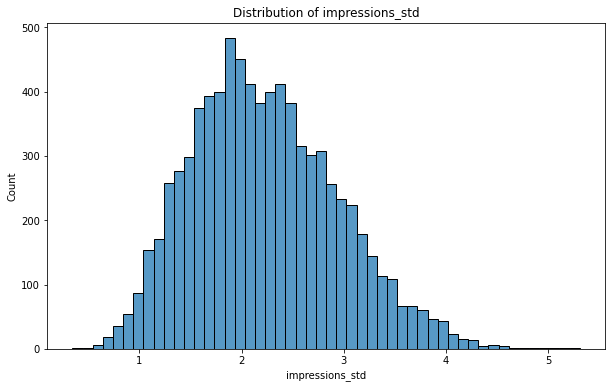

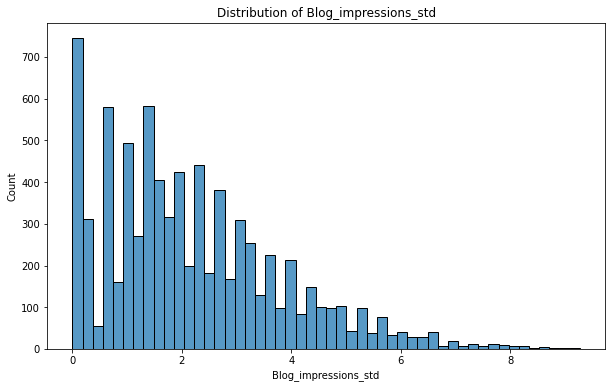

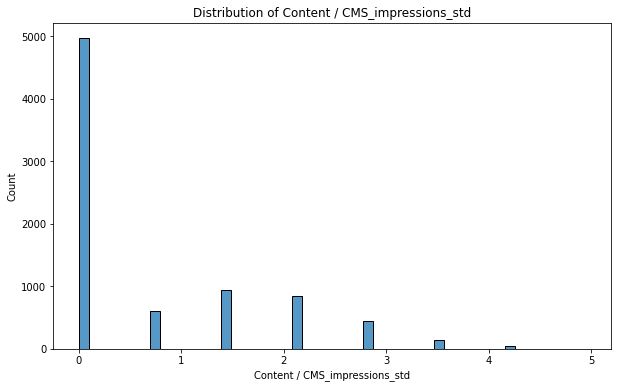

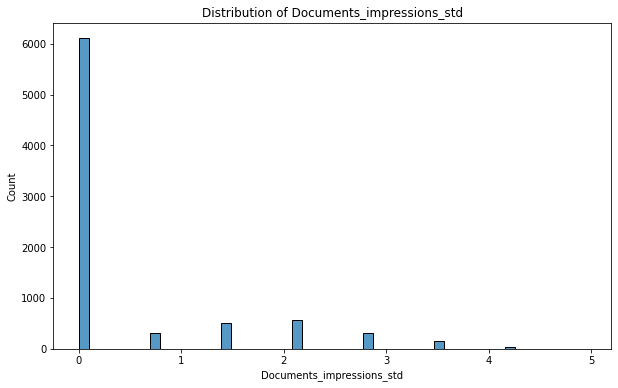

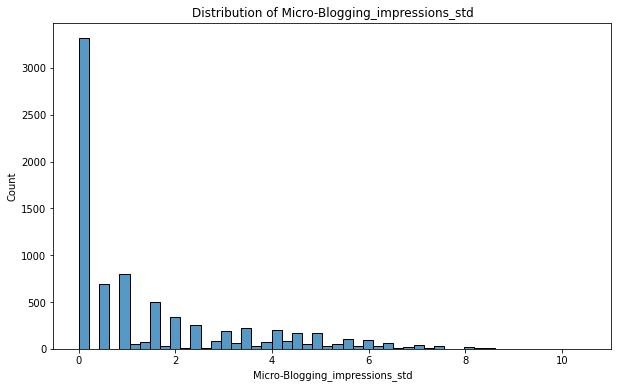

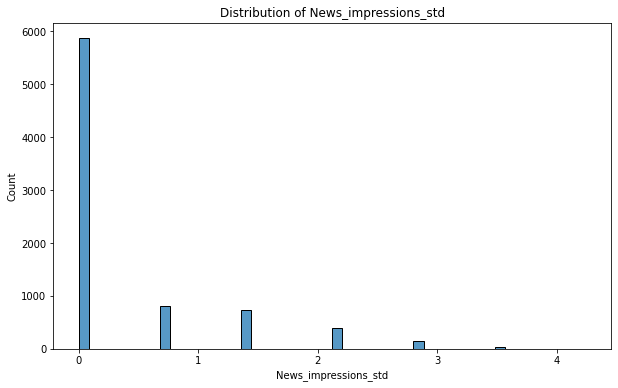

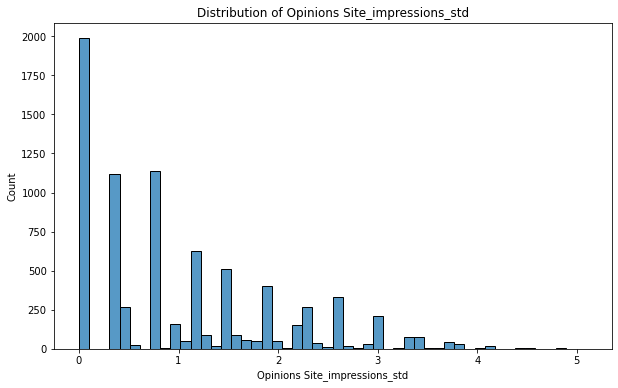

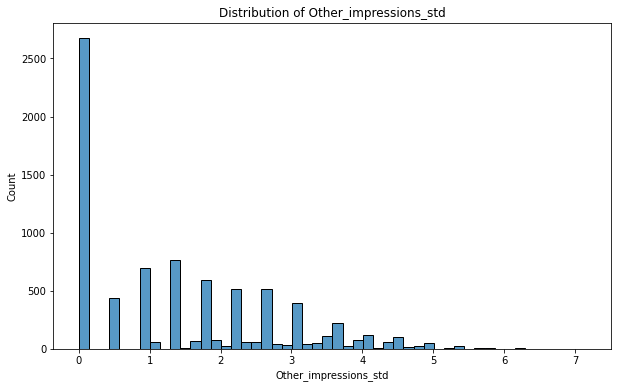

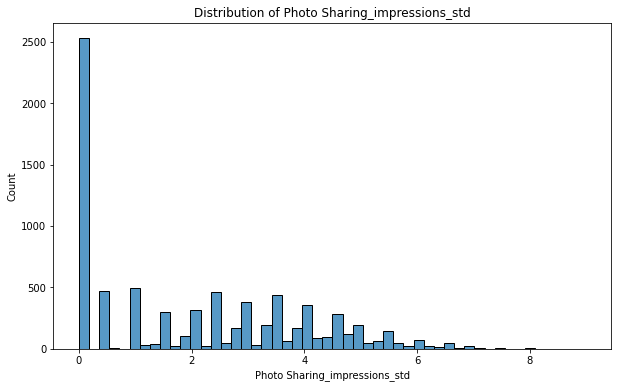

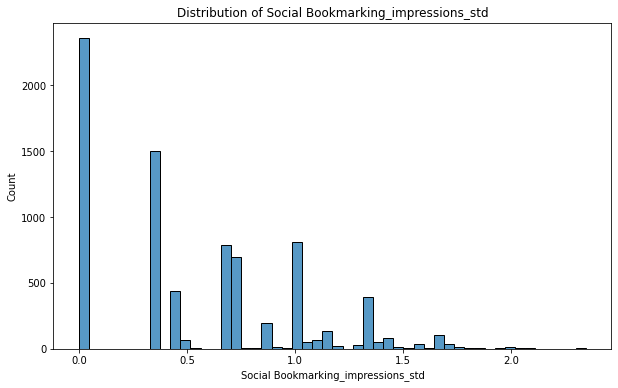

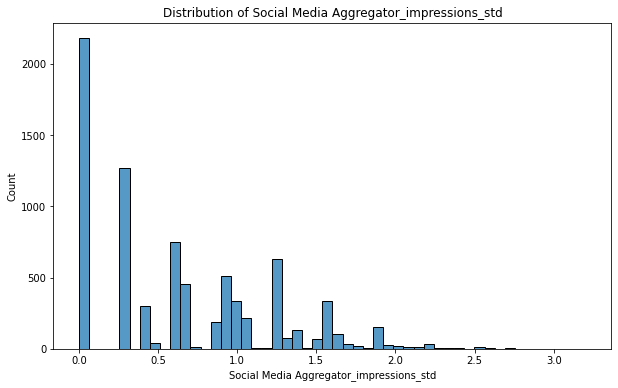

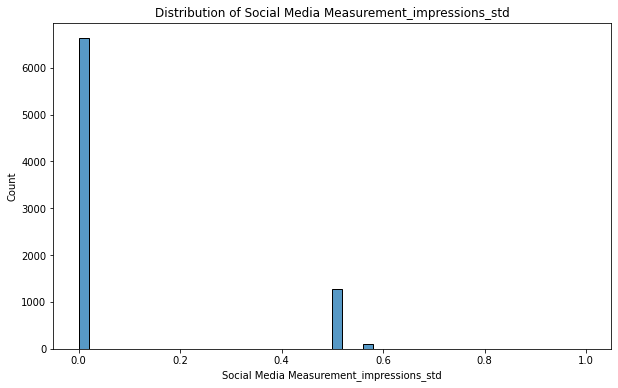

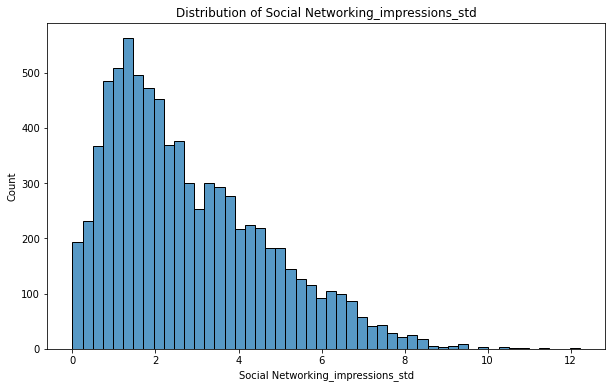

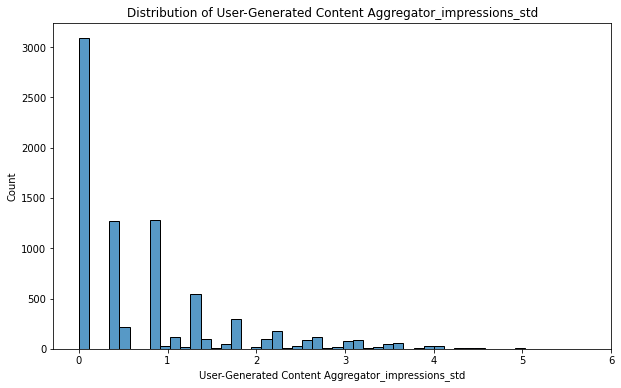

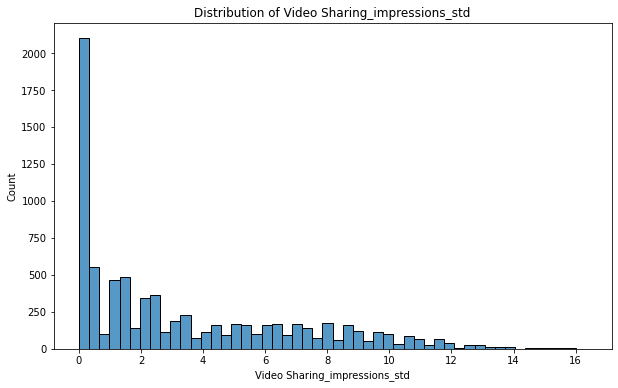

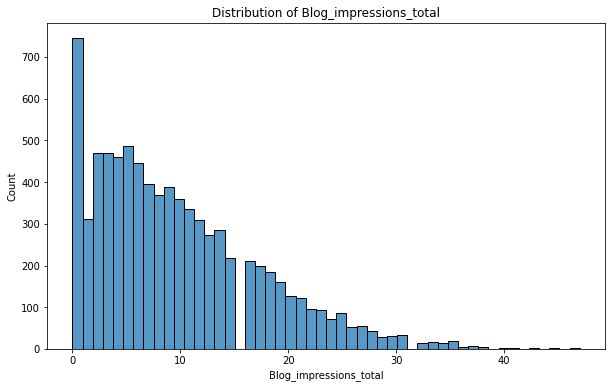

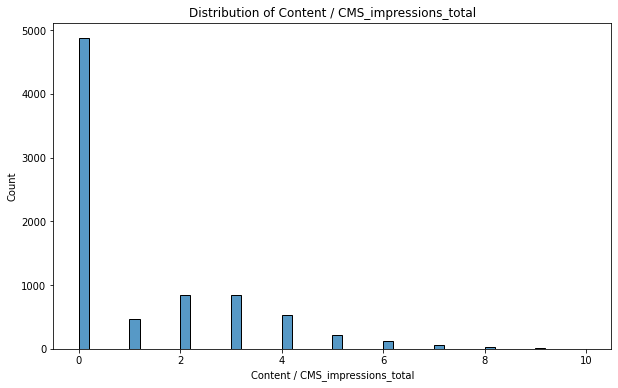

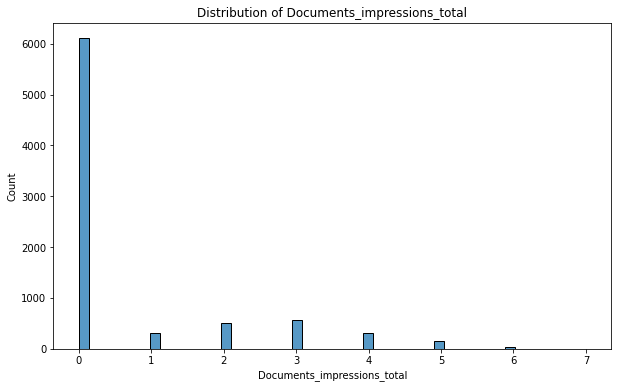

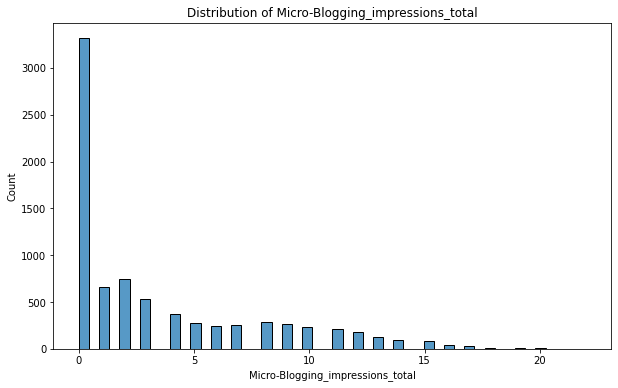

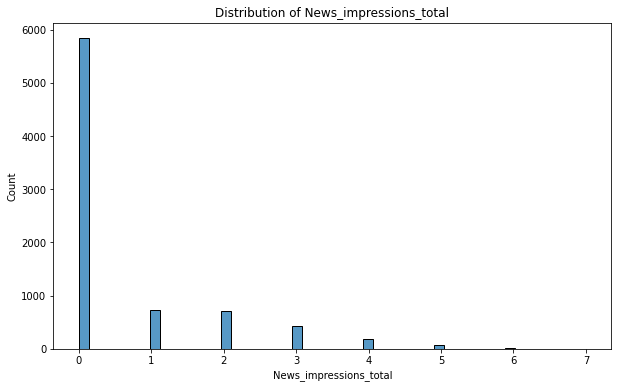

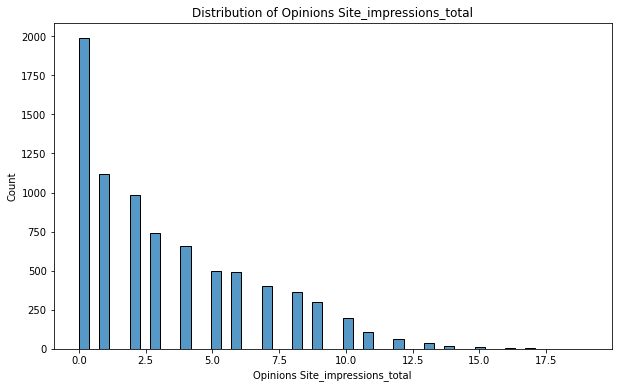

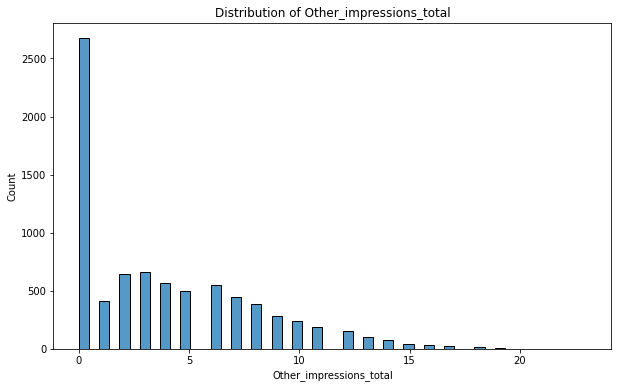

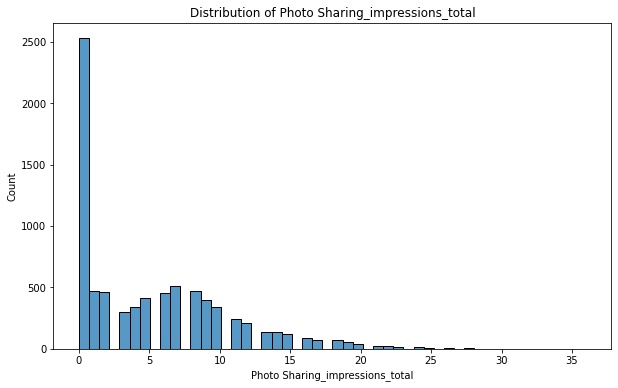

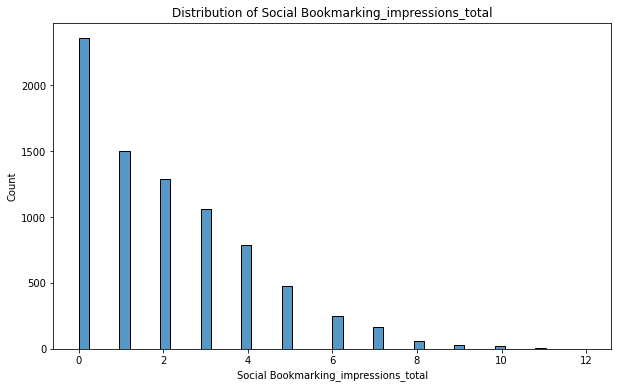

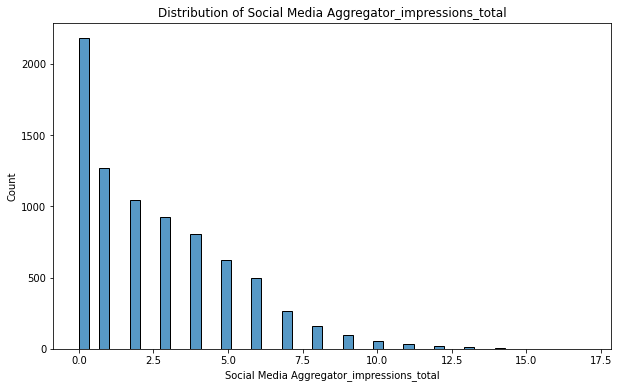

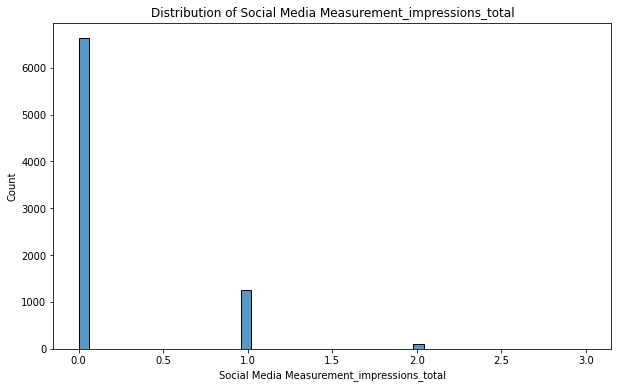

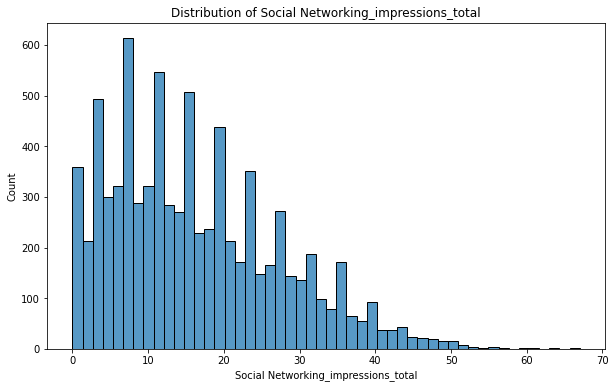

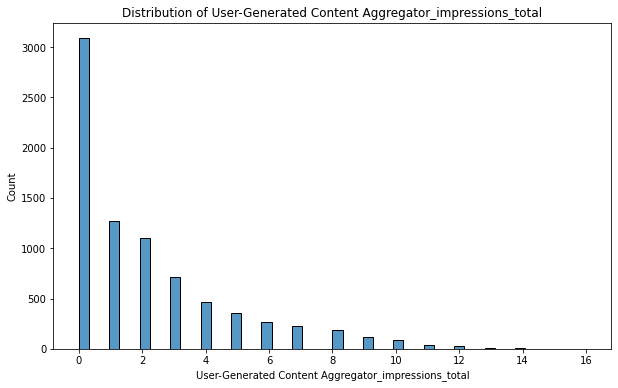

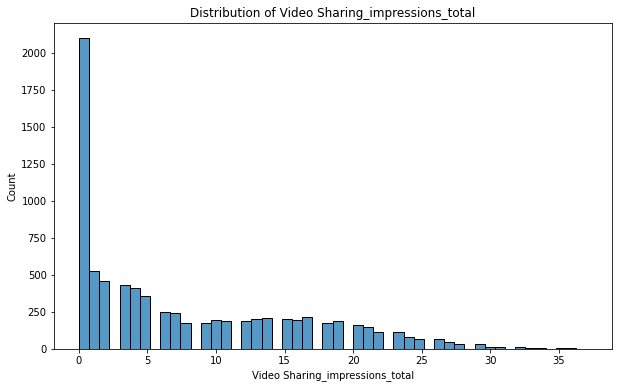

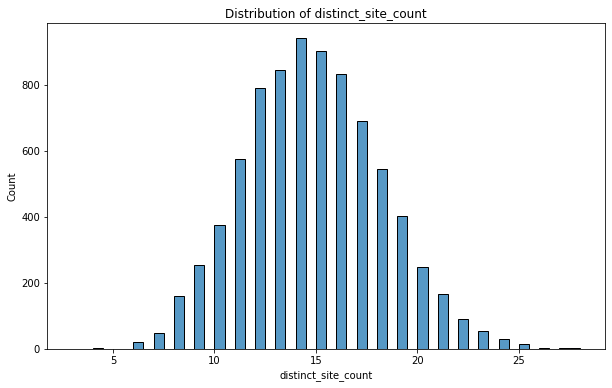

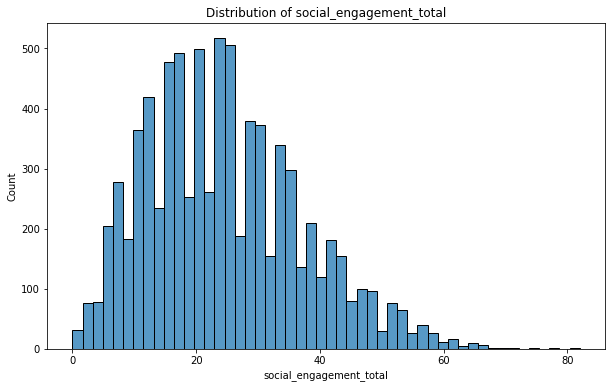

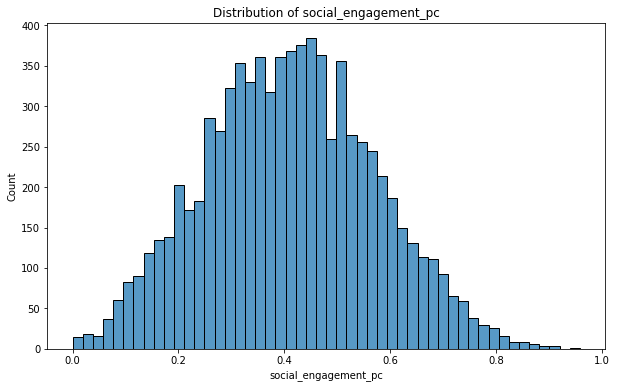

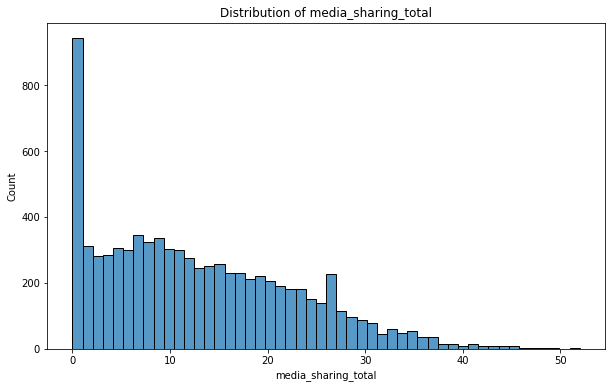

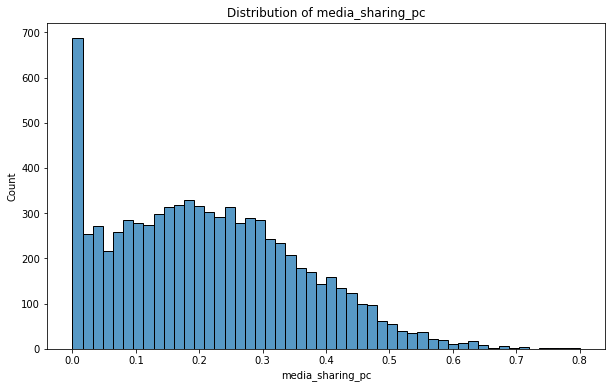

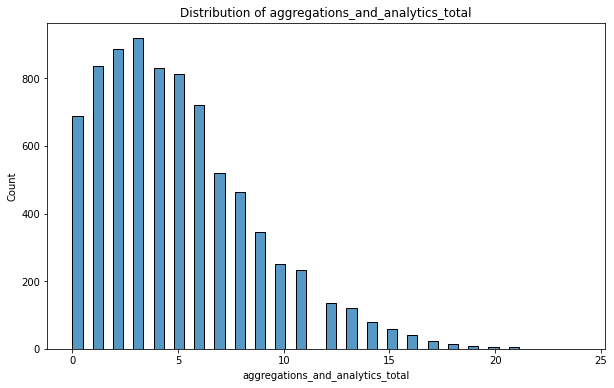

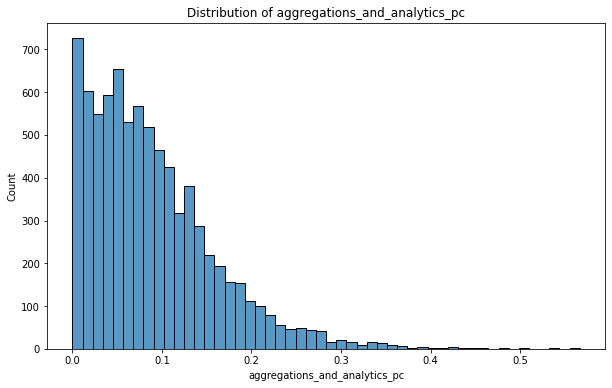

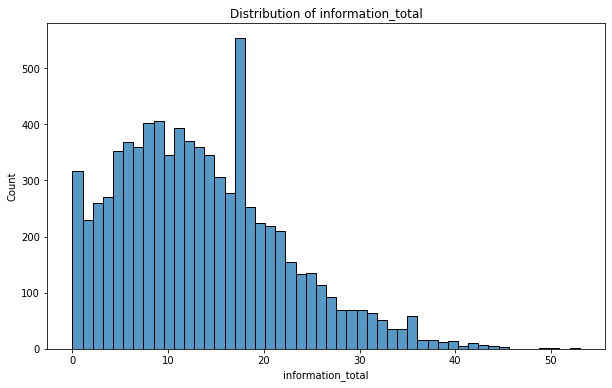

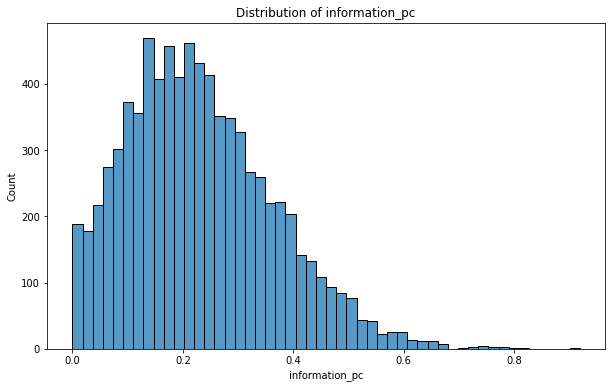

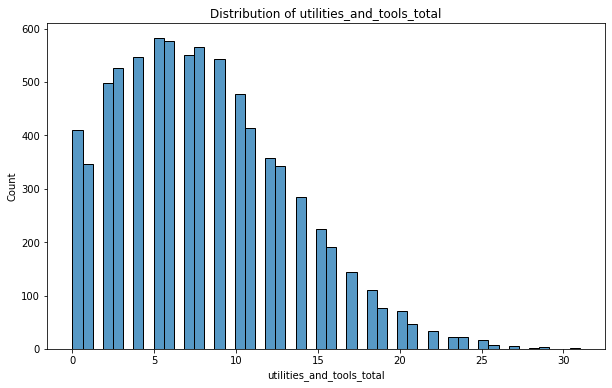

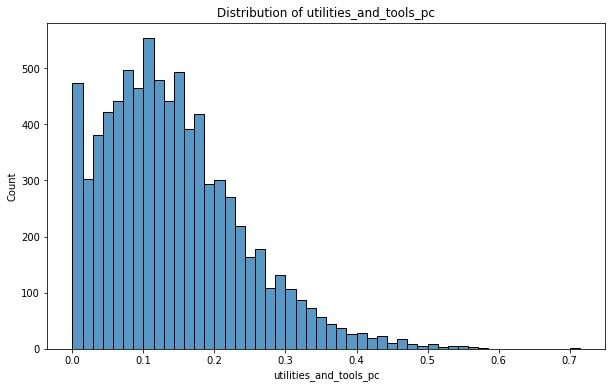

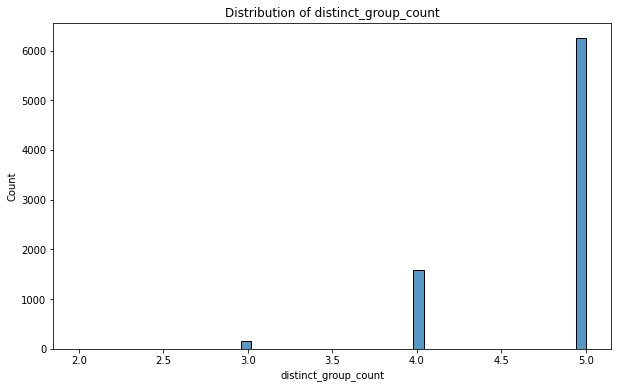

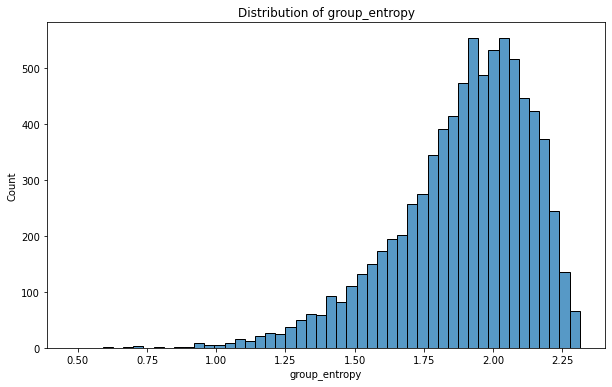

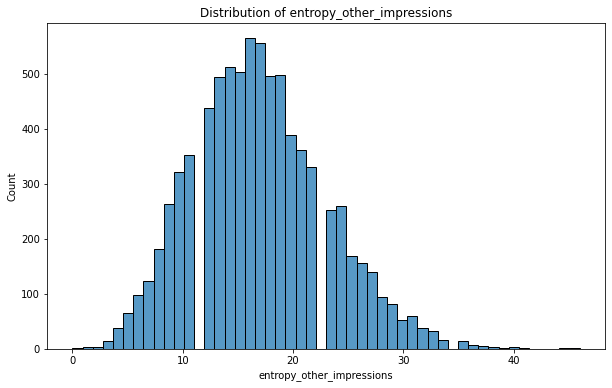

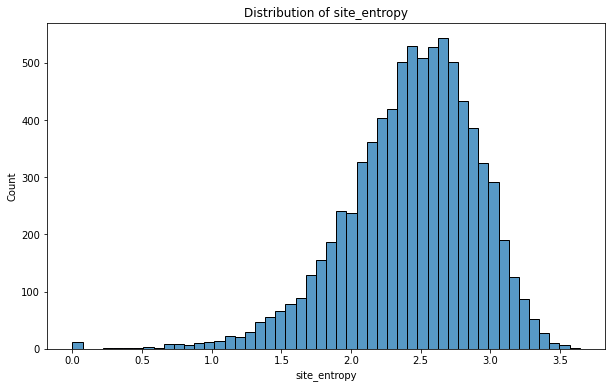

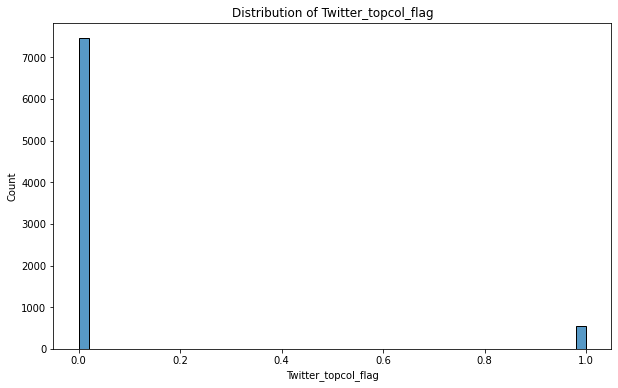

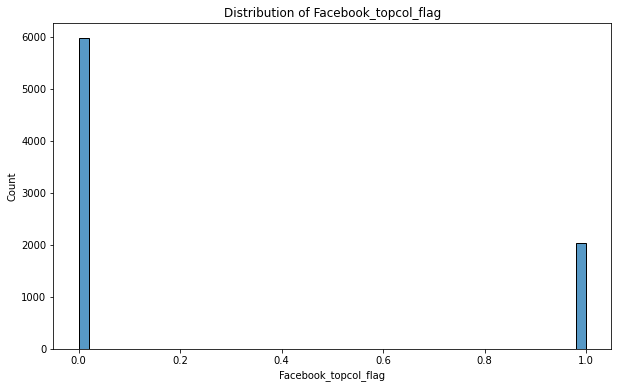

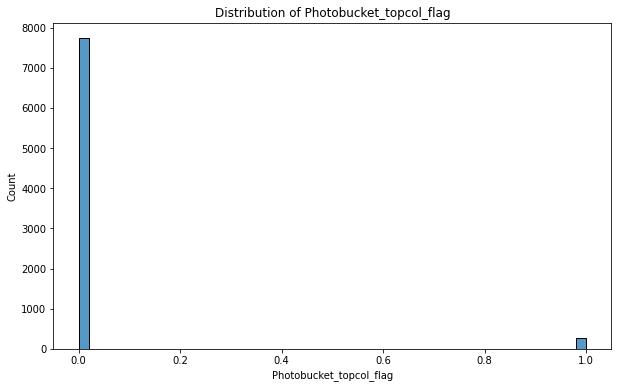

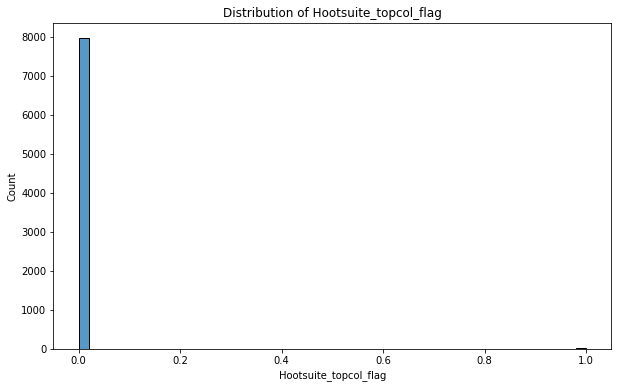

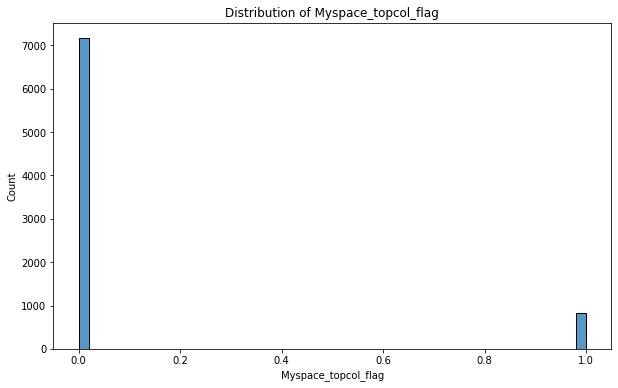

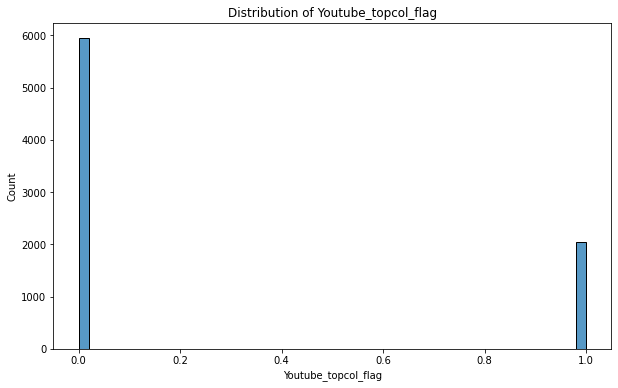

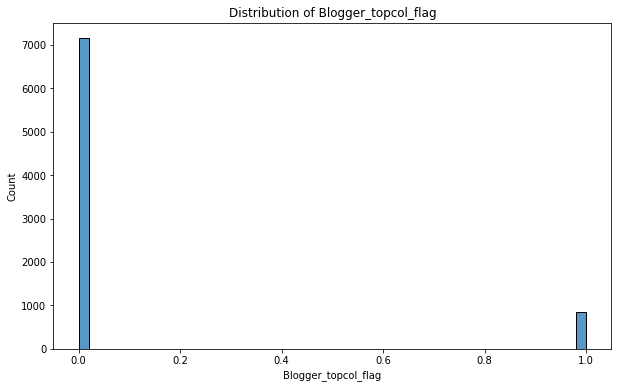

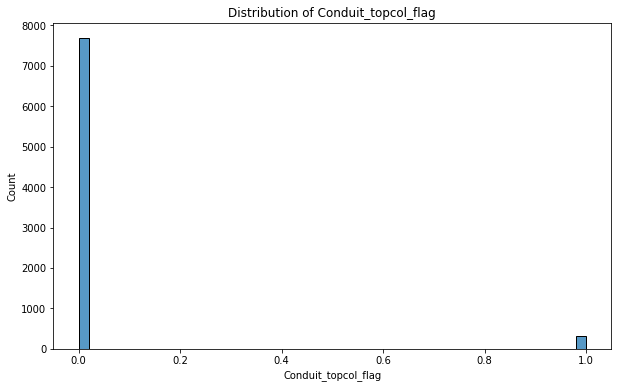

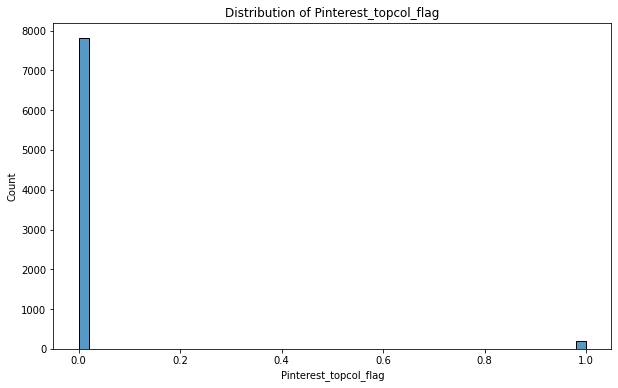

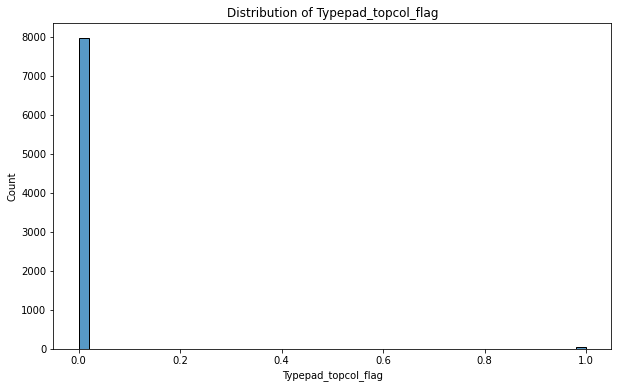

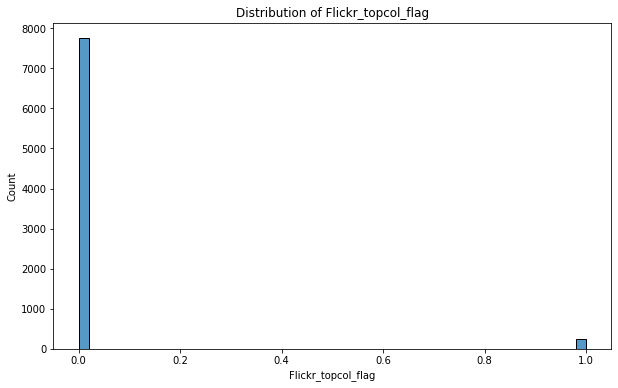

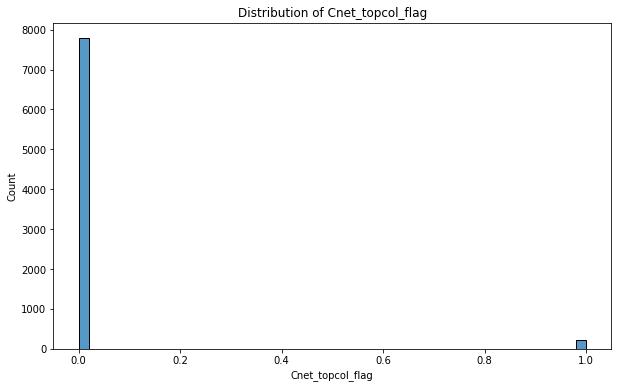

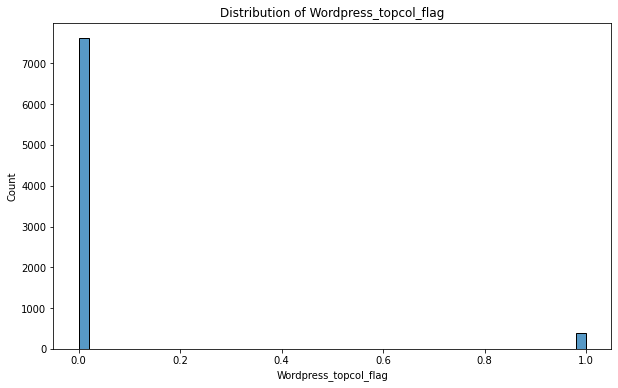

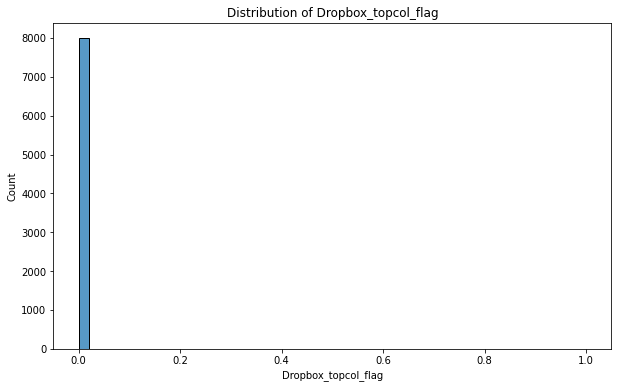

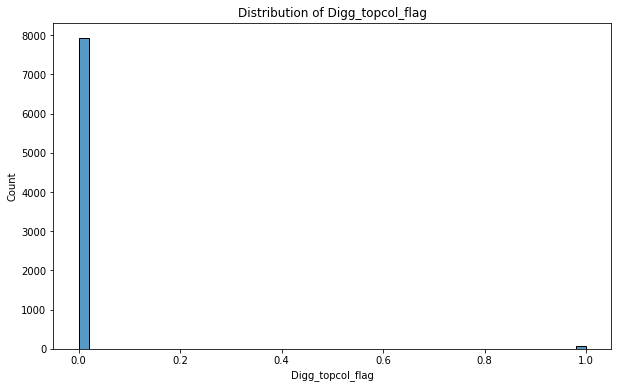

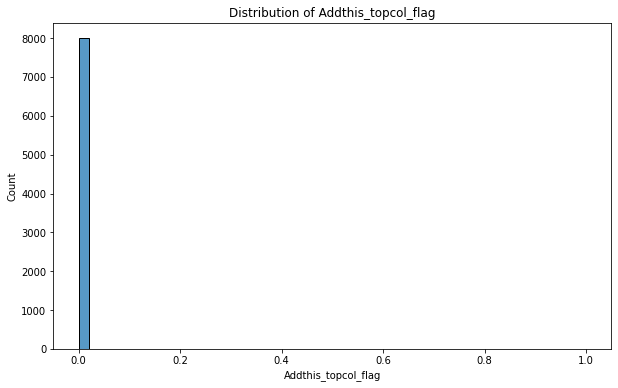

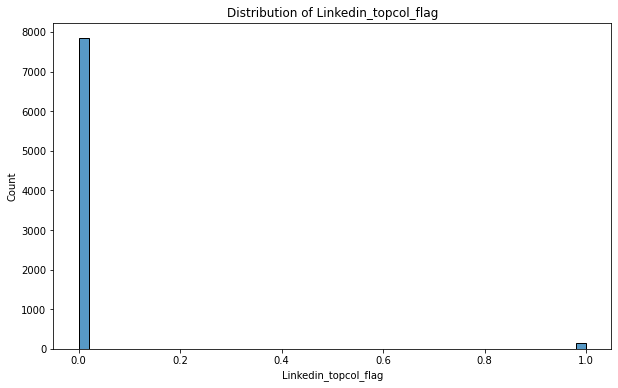

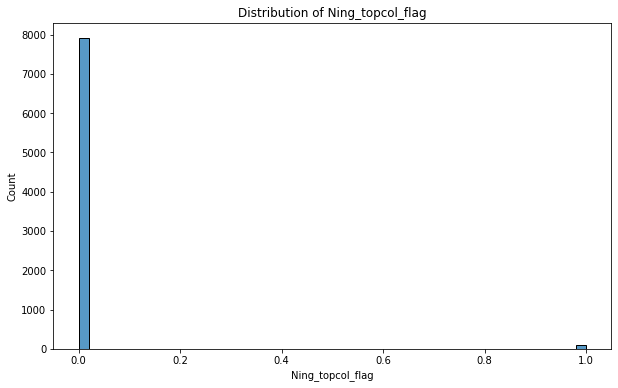

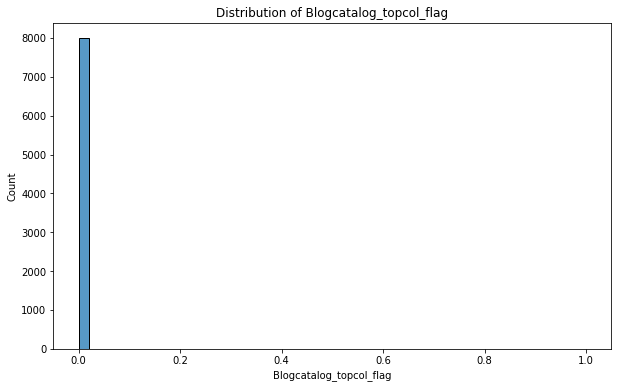

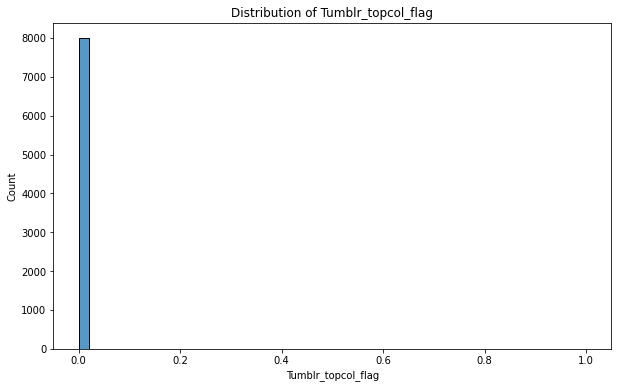

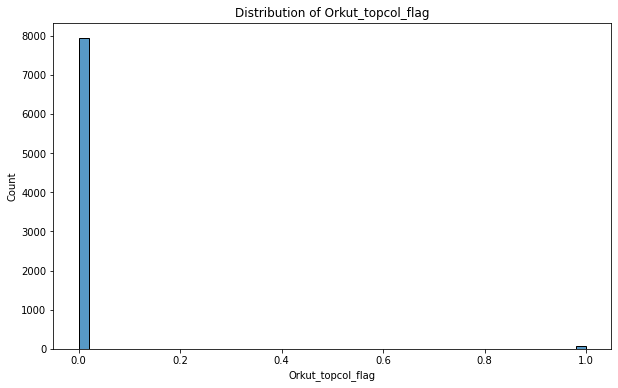

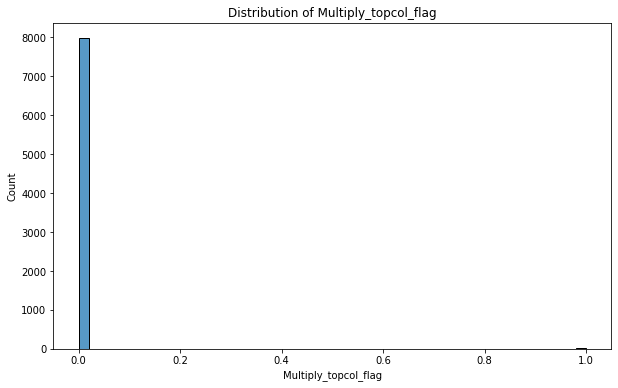

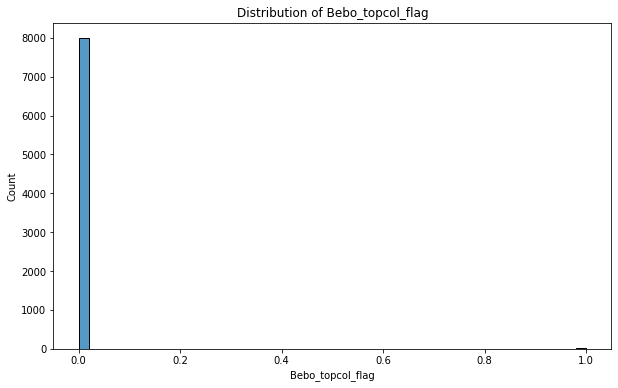

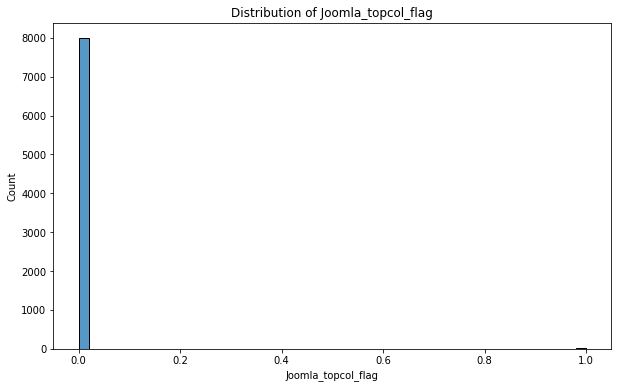

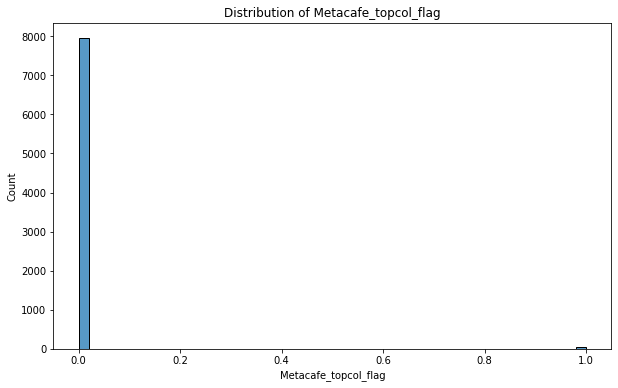

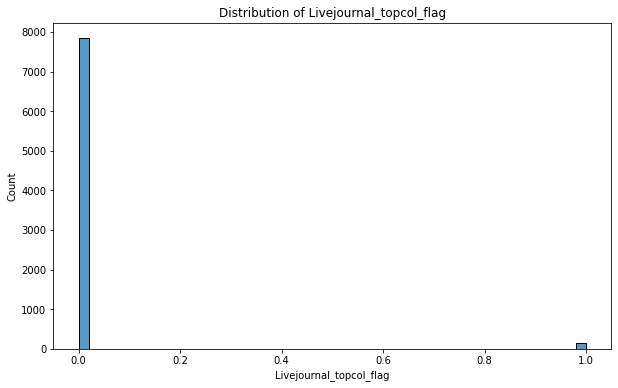

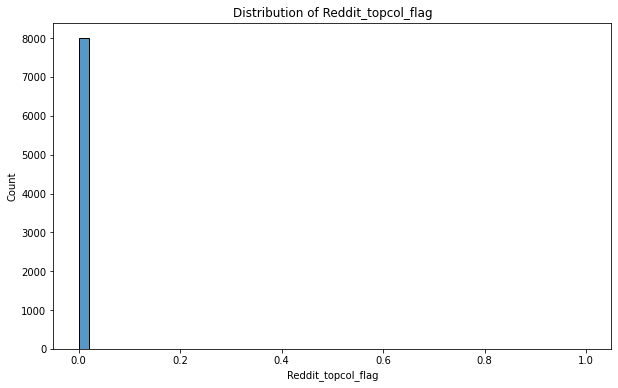

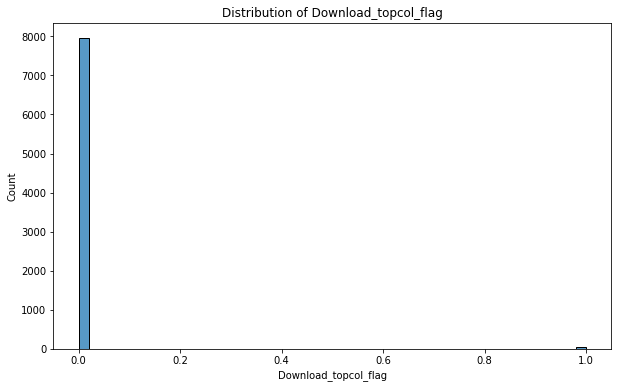

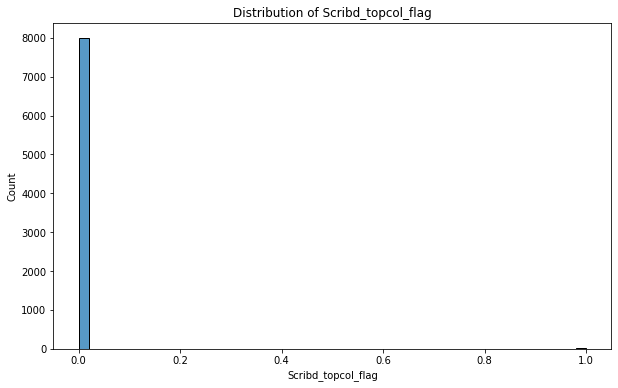

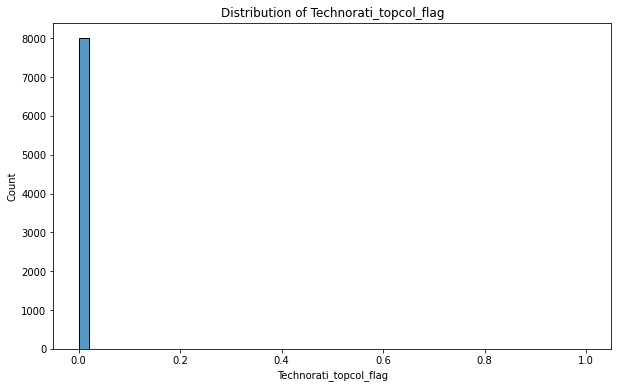

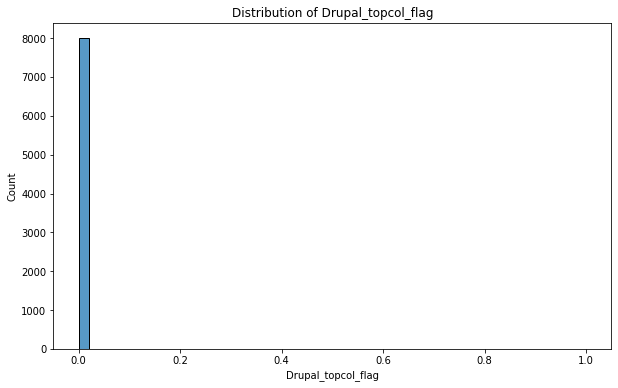

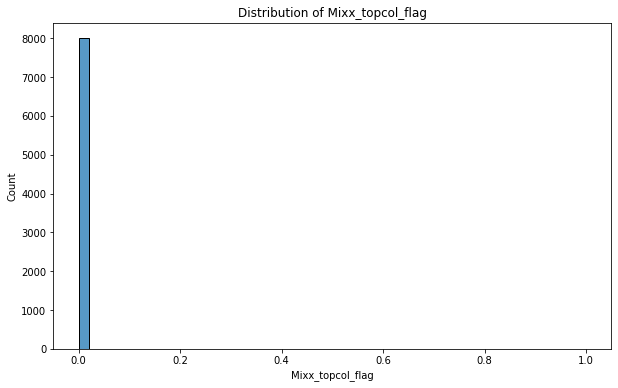

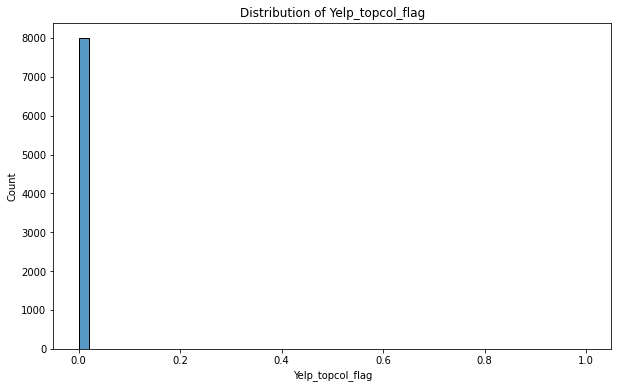

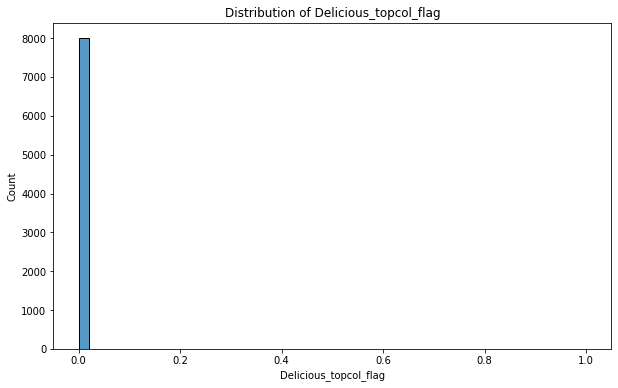

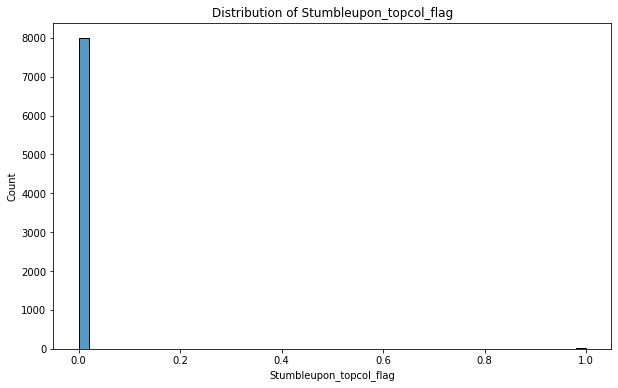

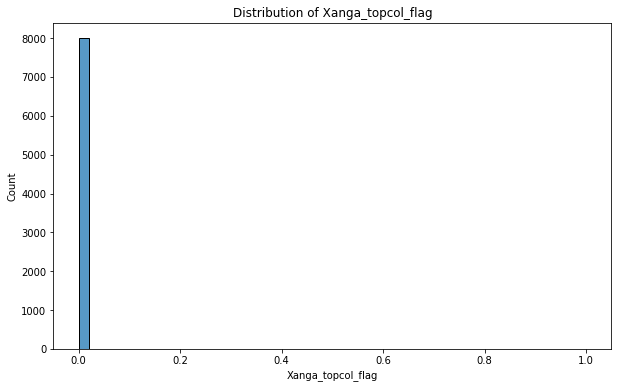

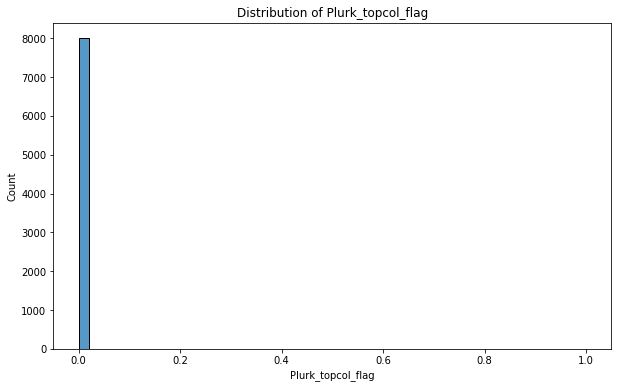

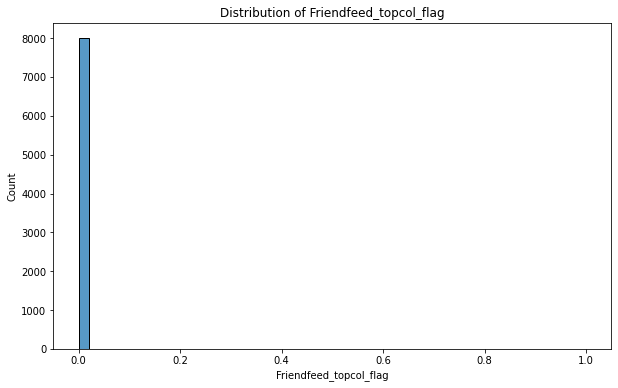

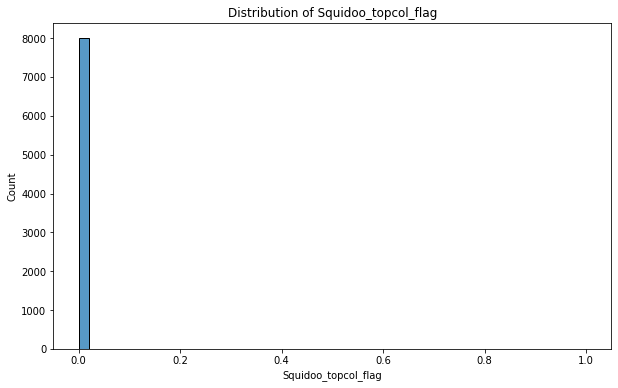

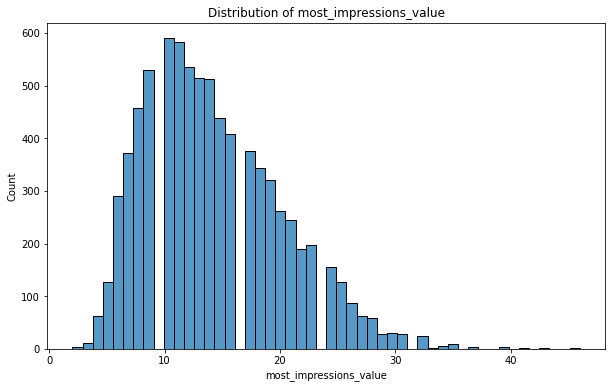

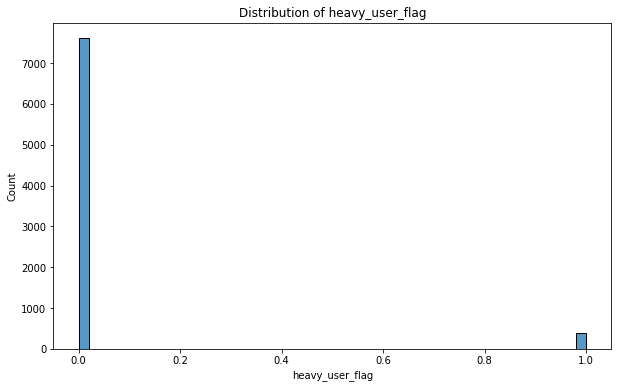

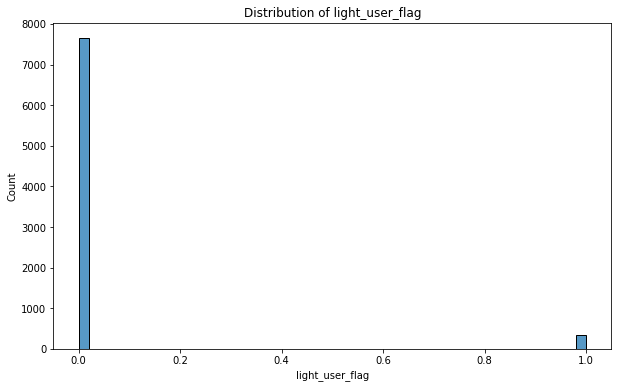

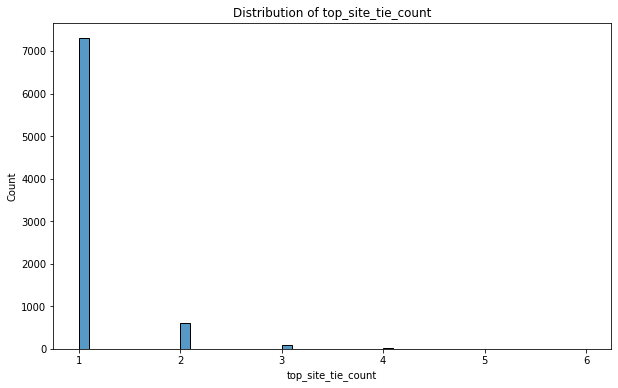

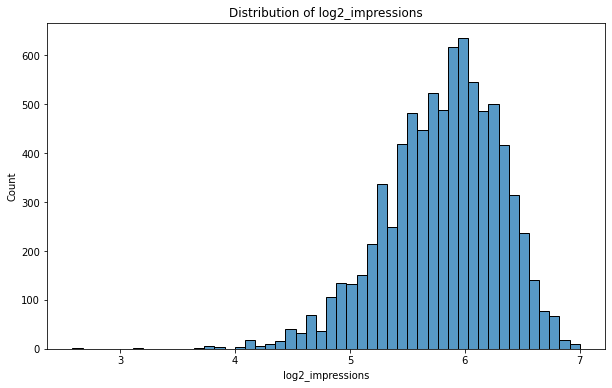

In [54]:
# We can see suffient variation in other fields too, besides the bulk in 0s that we've already looked into

for i in X_train.columns[1:]:
    plt.figure(figsize=(10, 6))
    sns.histplot(X_train[i], bins=50)
    plt.title(f'Distribution of {i}')
    plt.show()

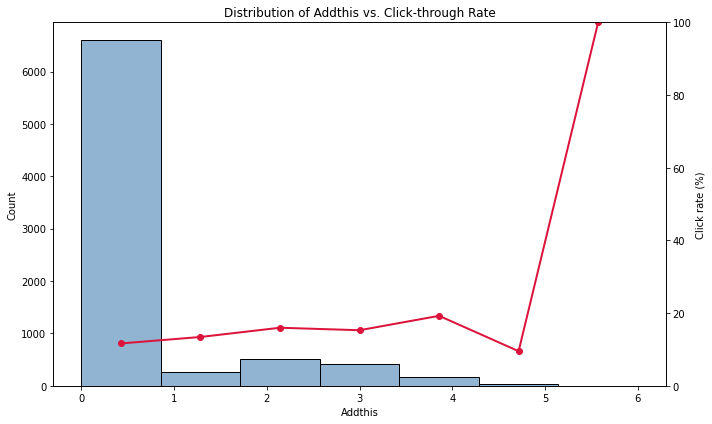

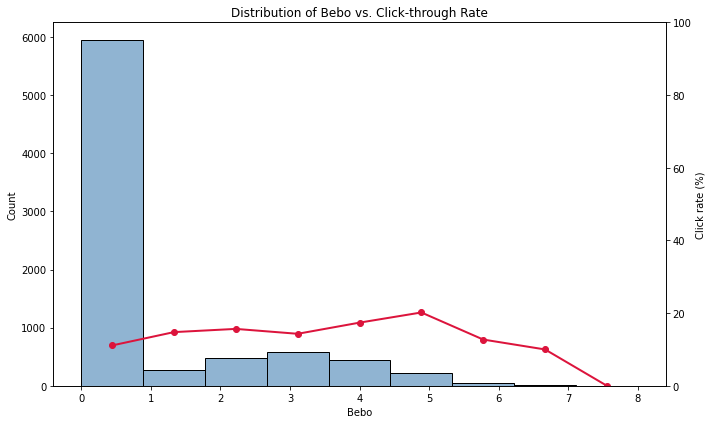

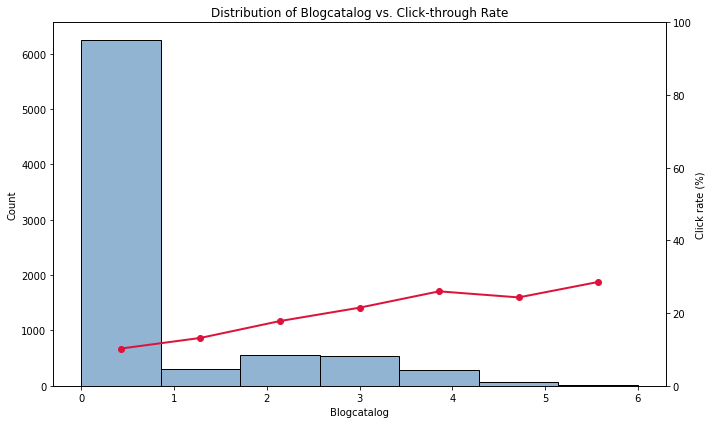

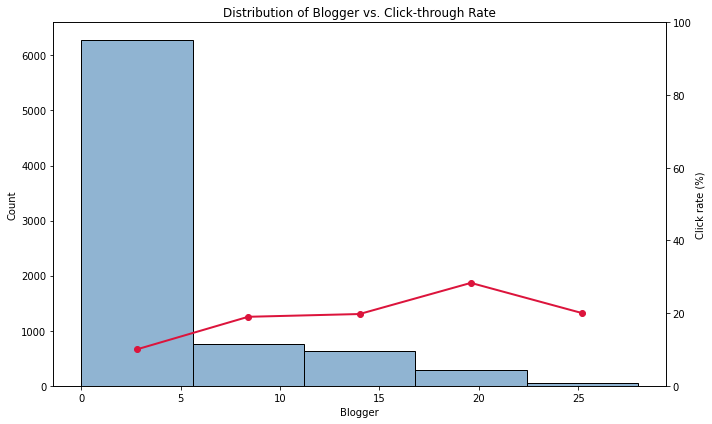

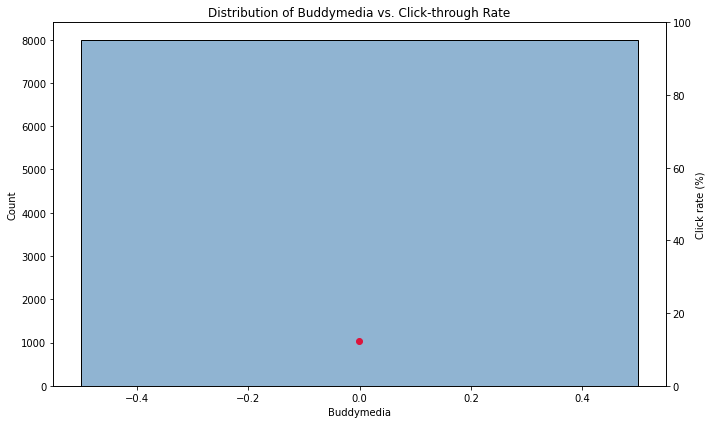

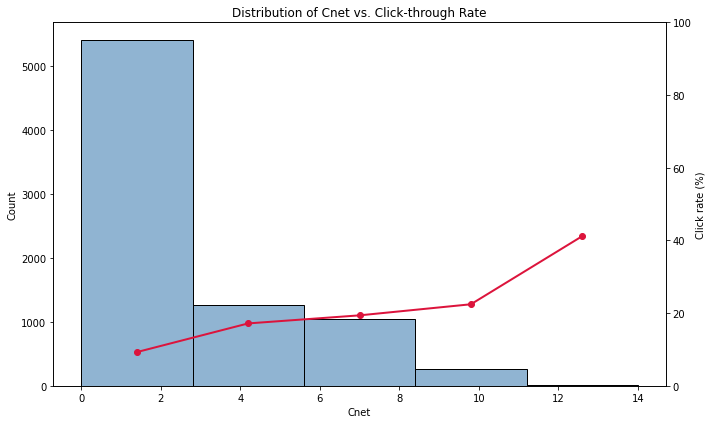

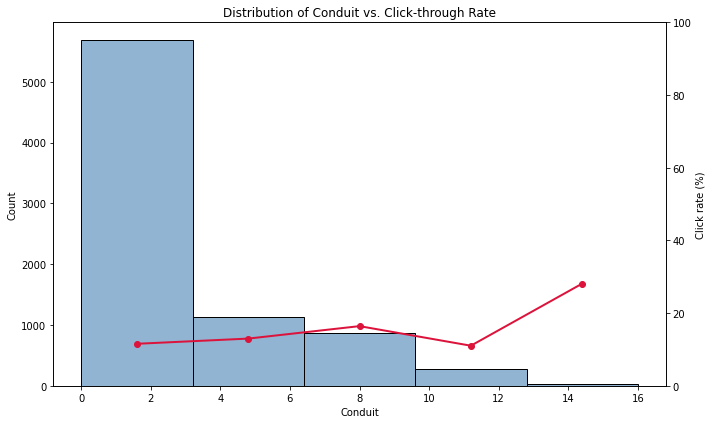

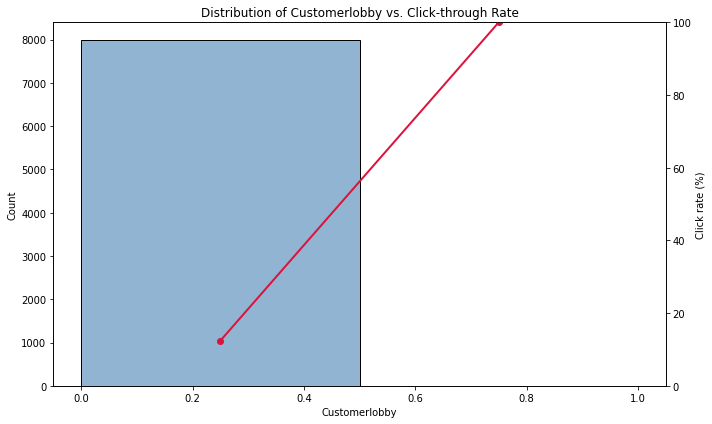

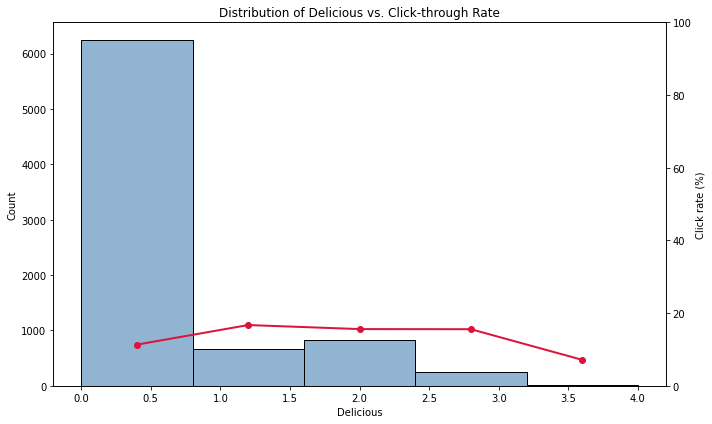

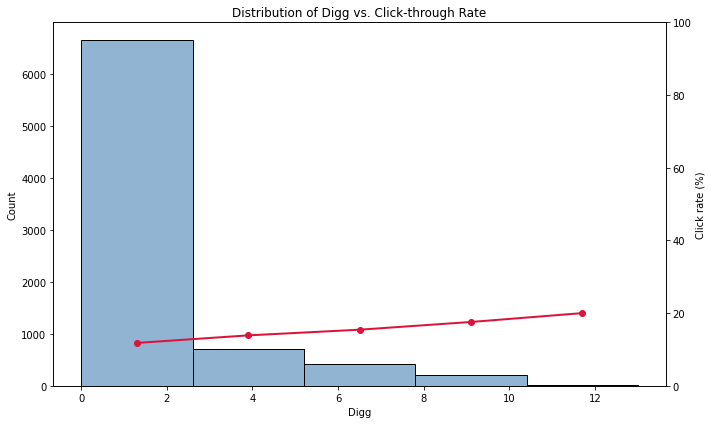

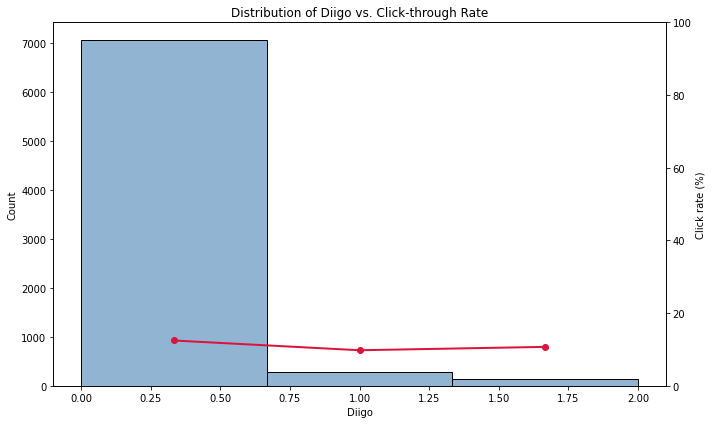

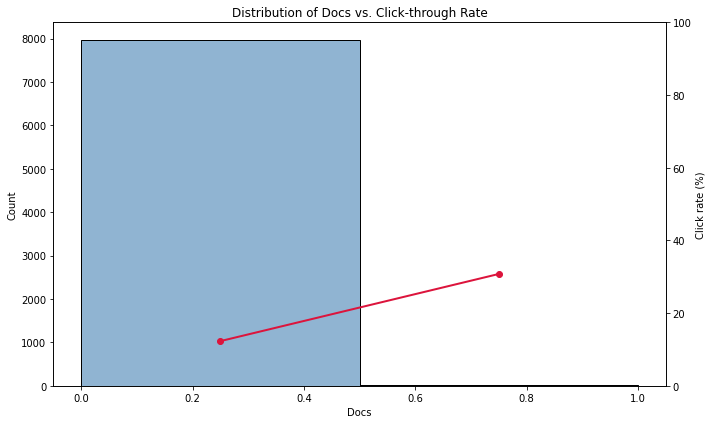

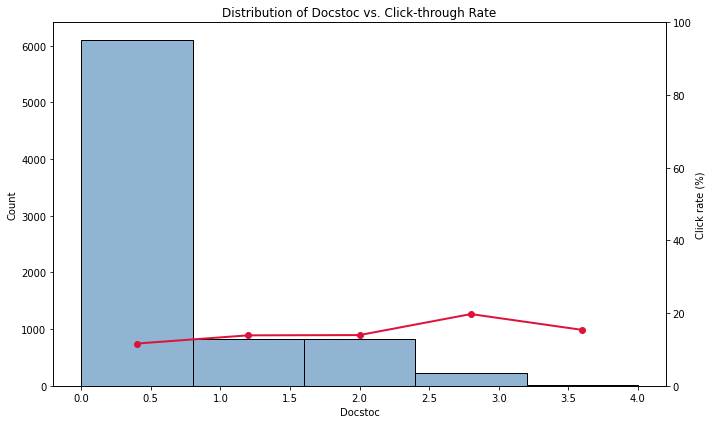

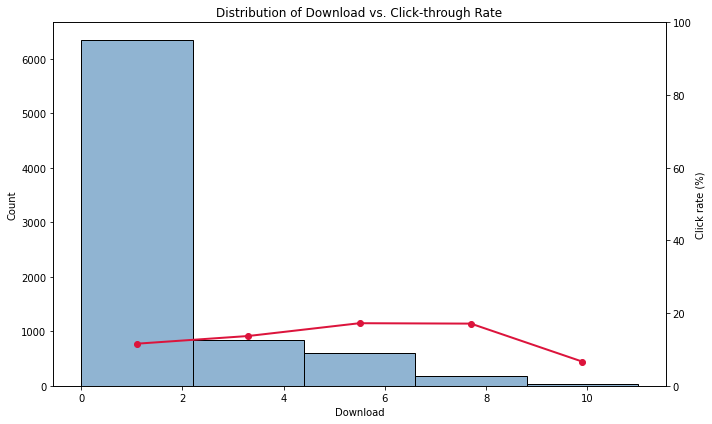

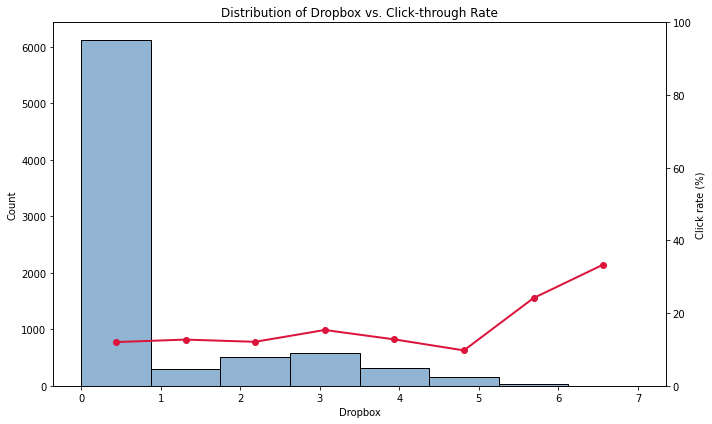

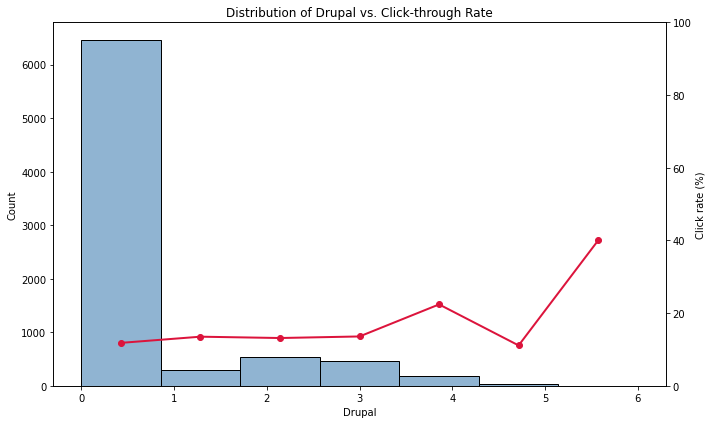

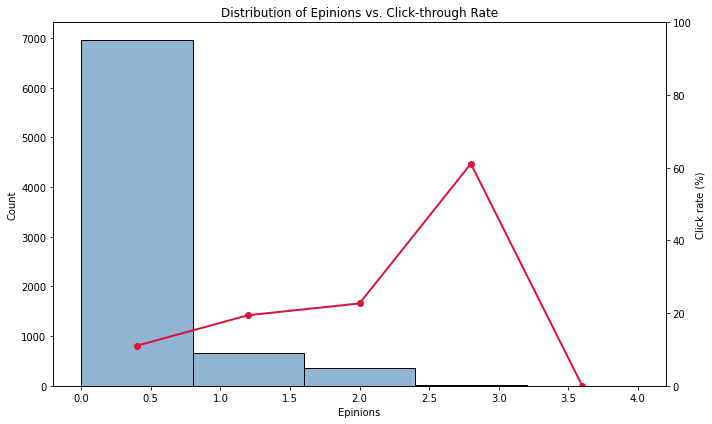

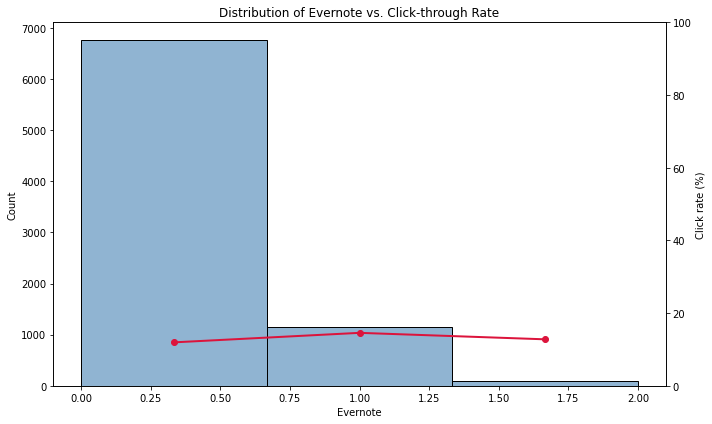

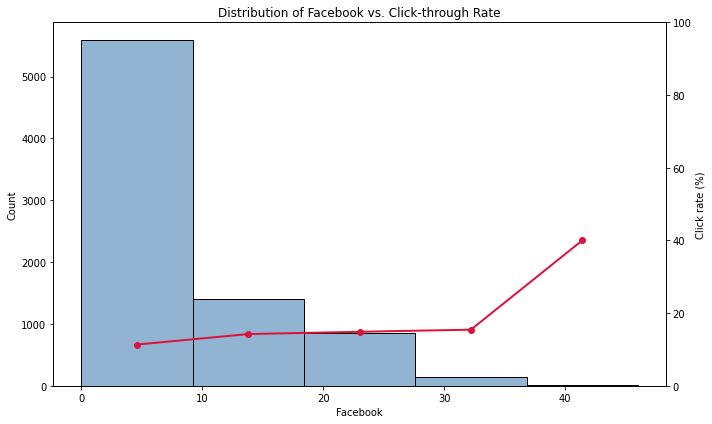

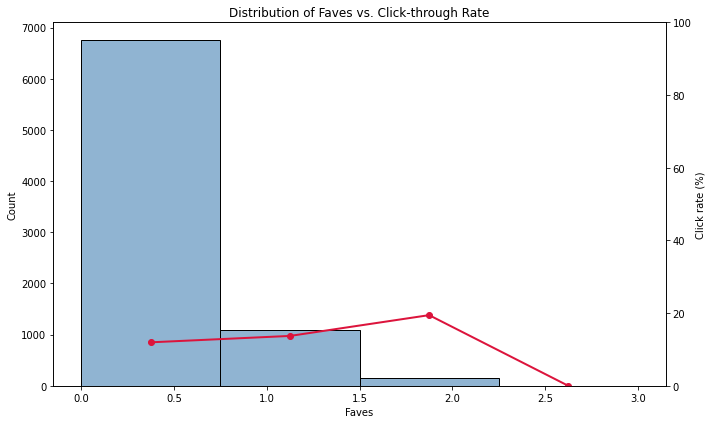

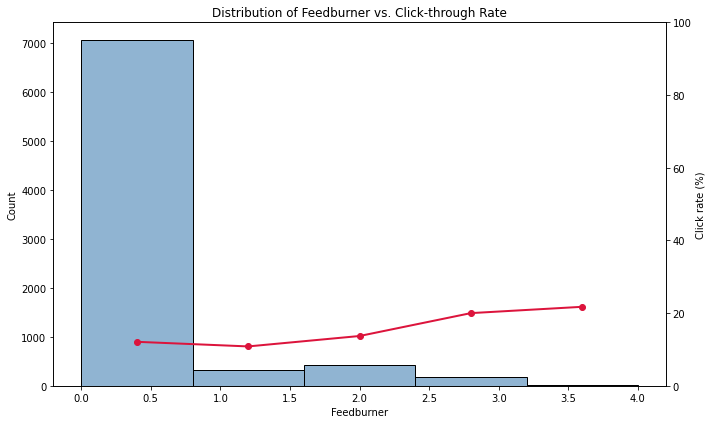

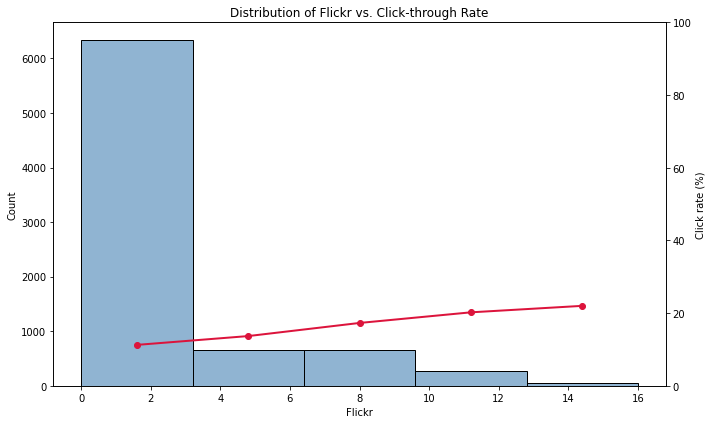

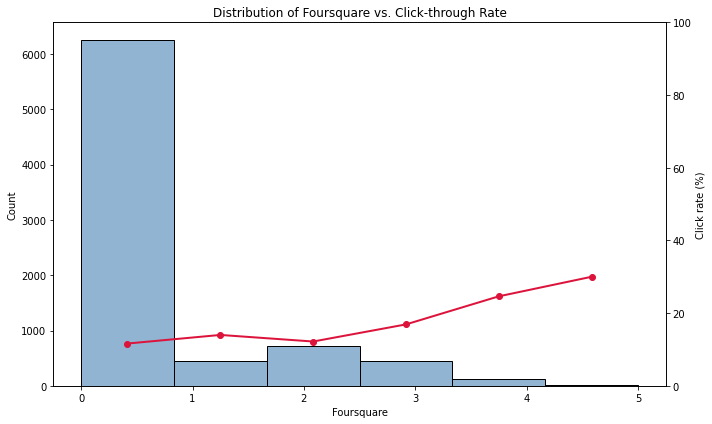

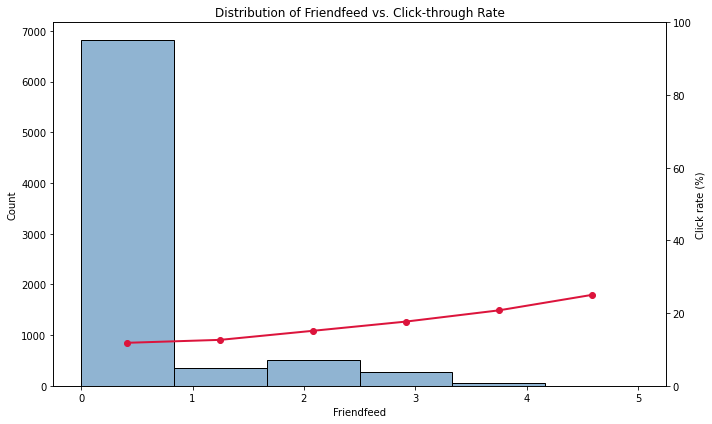

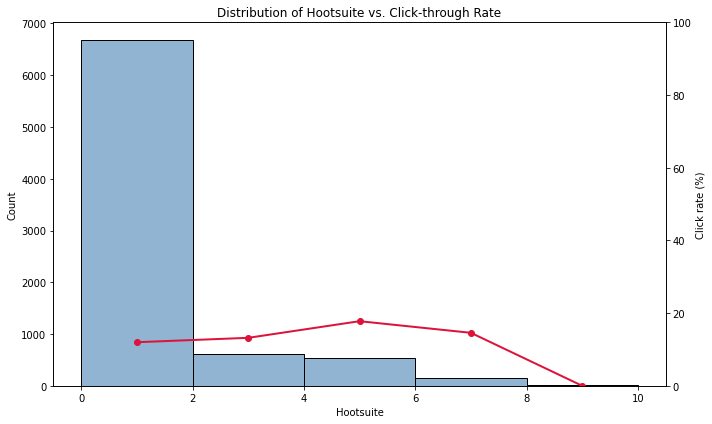

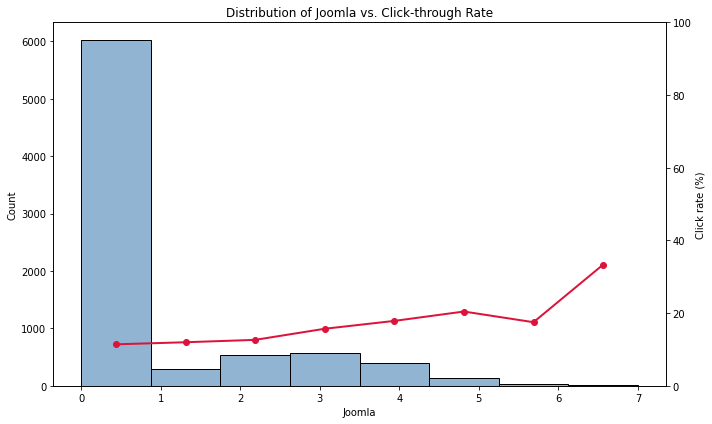

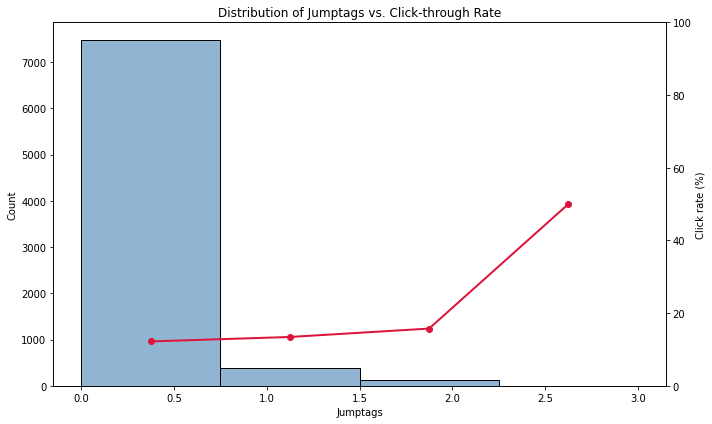

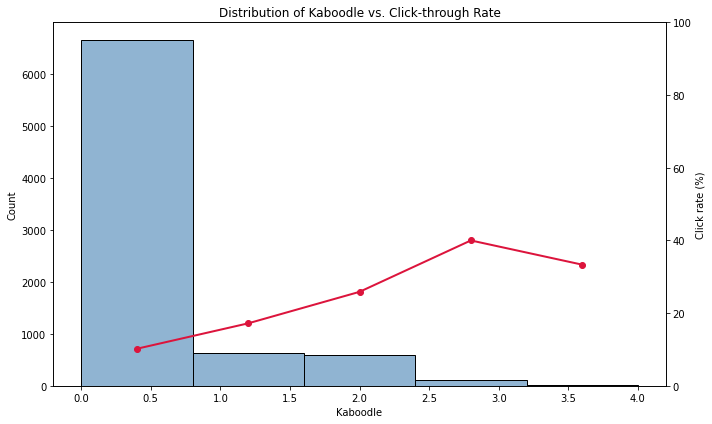

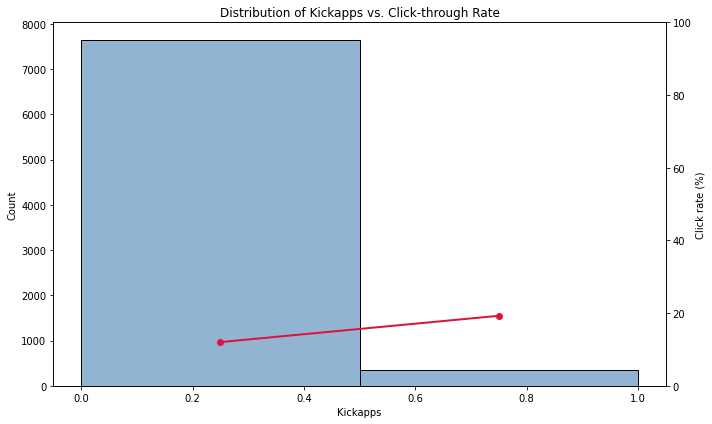

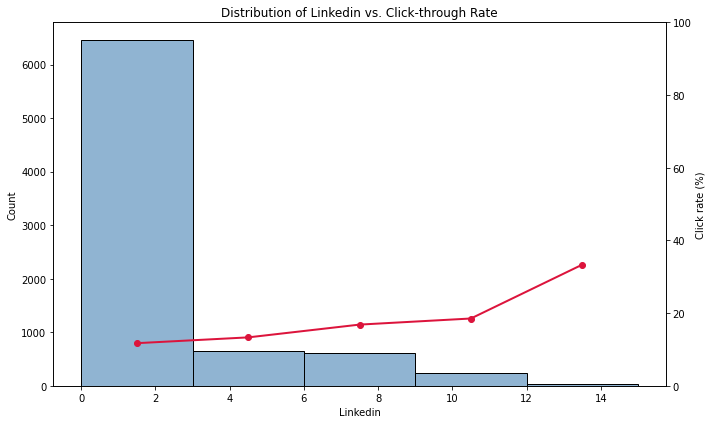

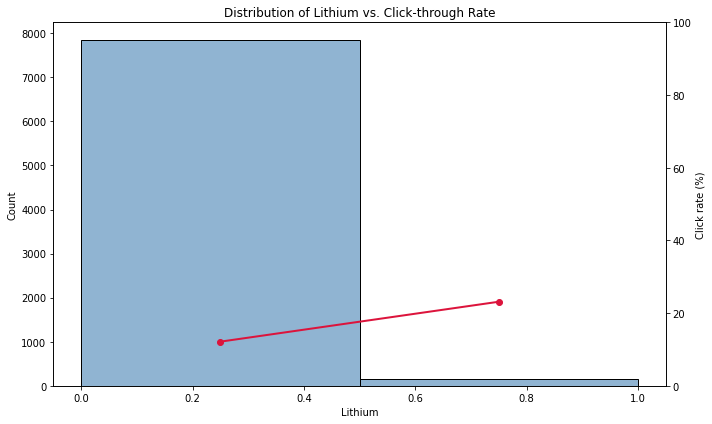

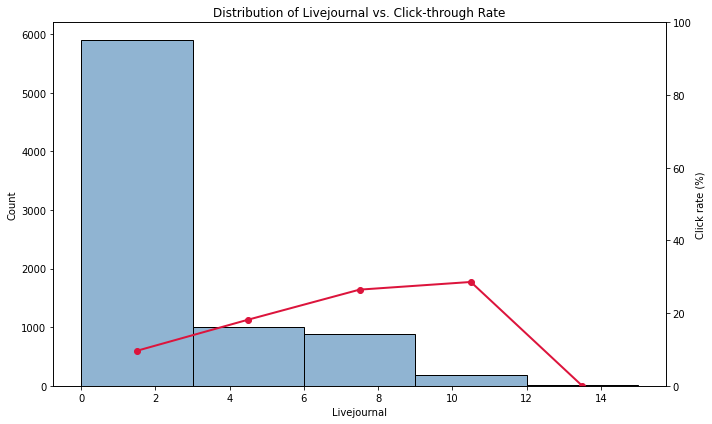

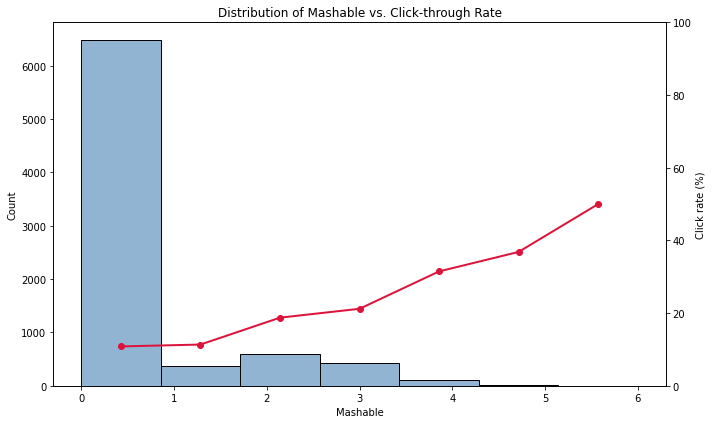

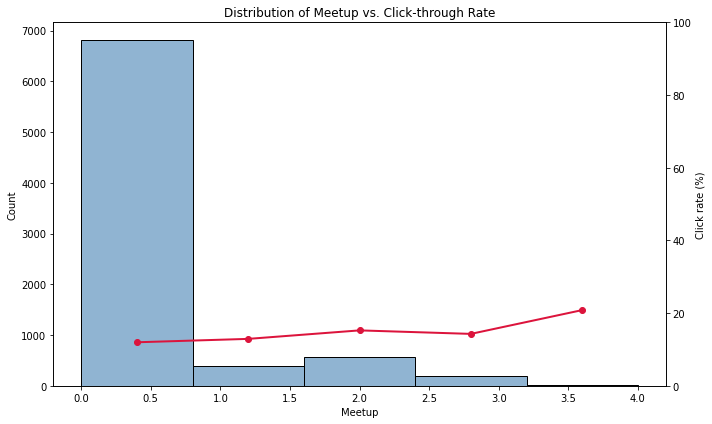

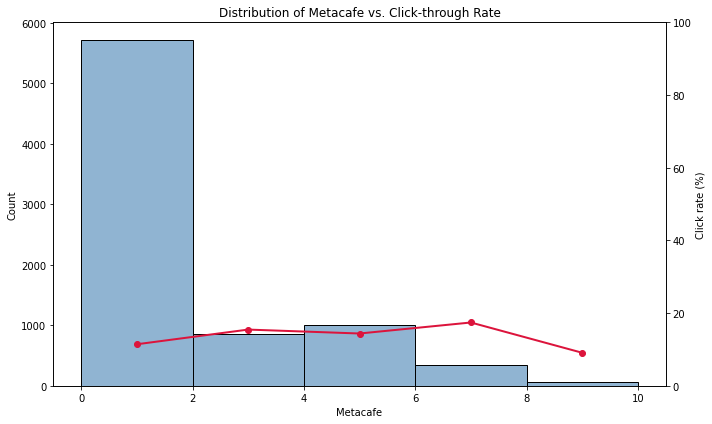

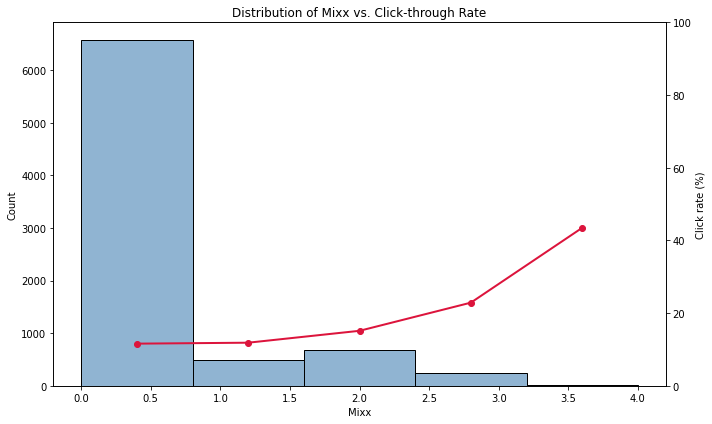

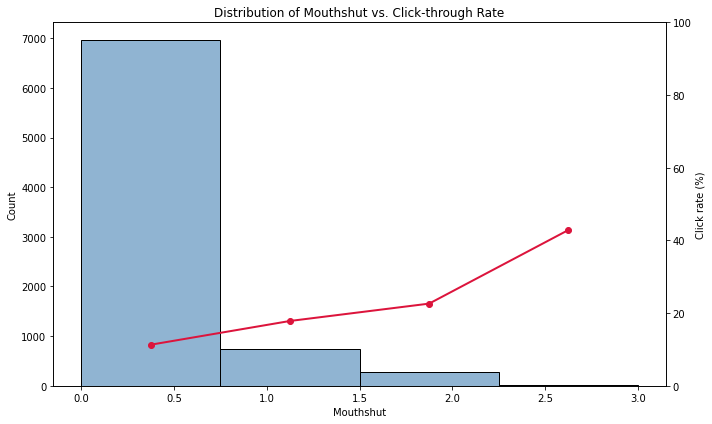

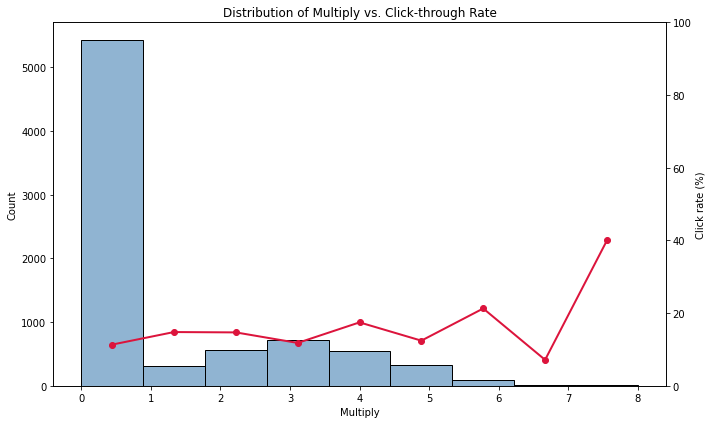

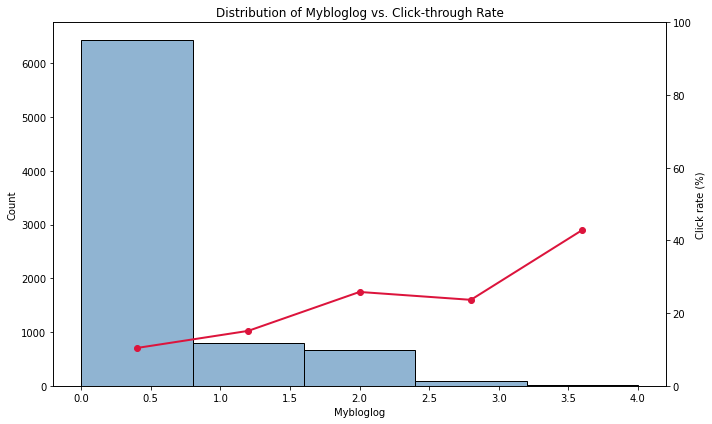

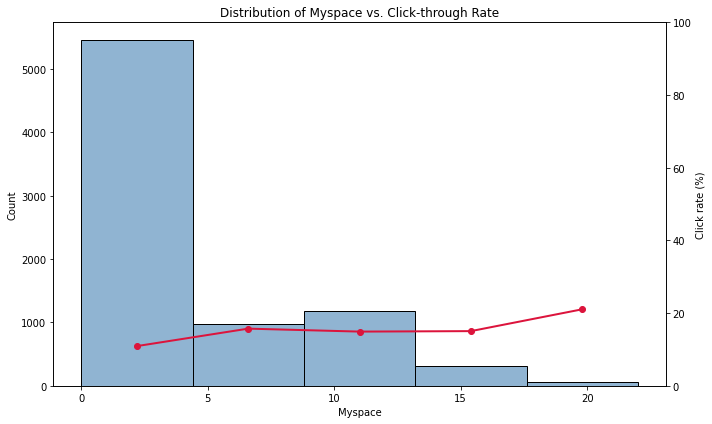

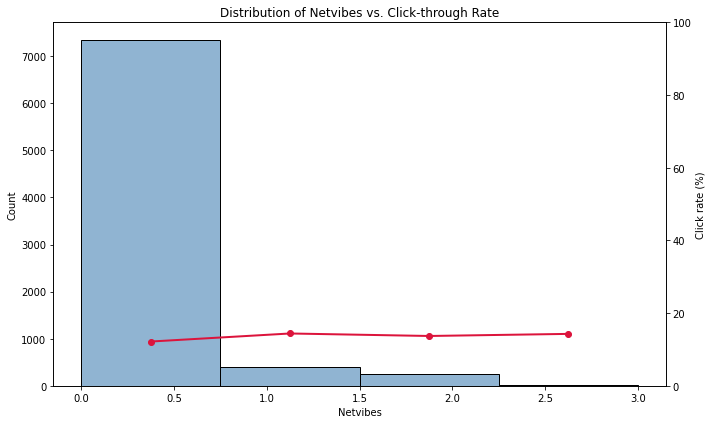

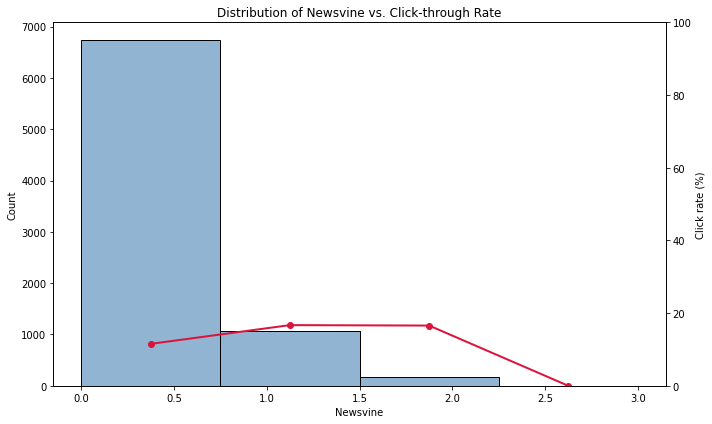

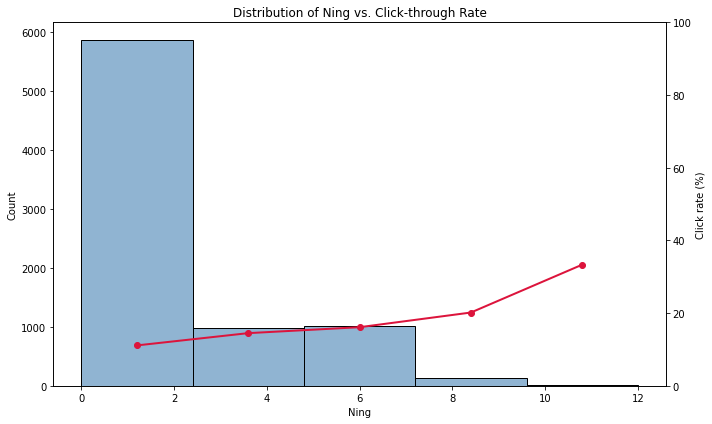

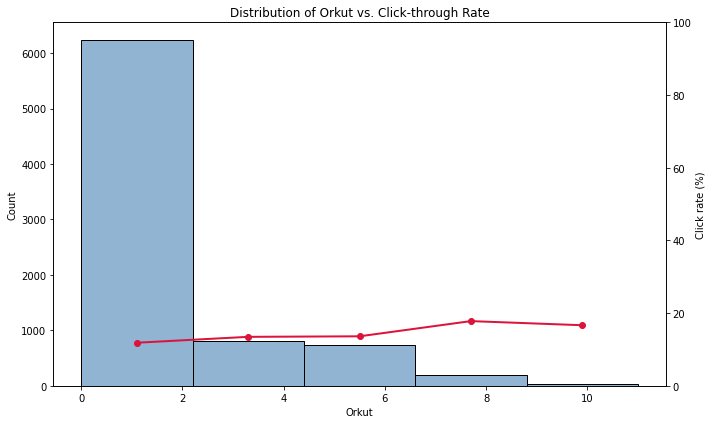

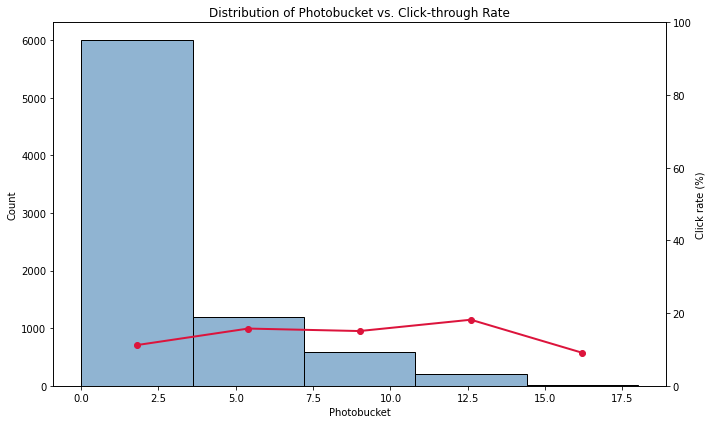

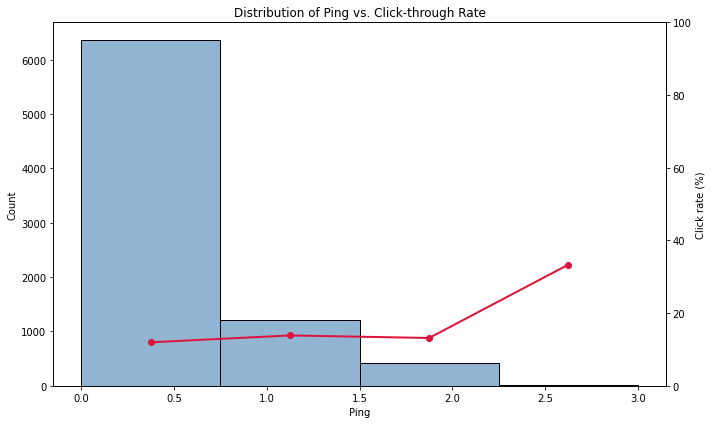

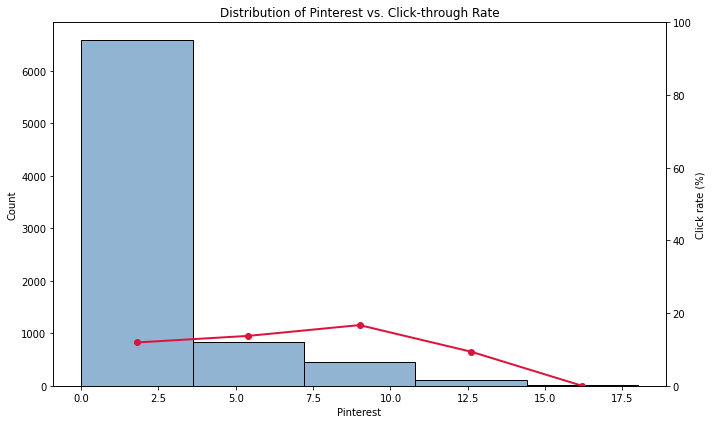

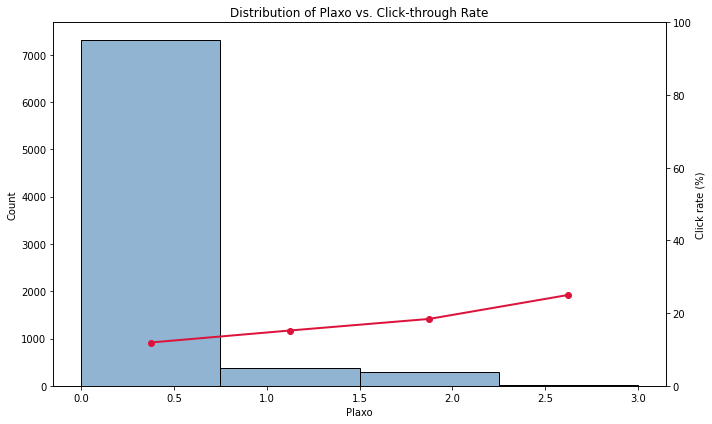

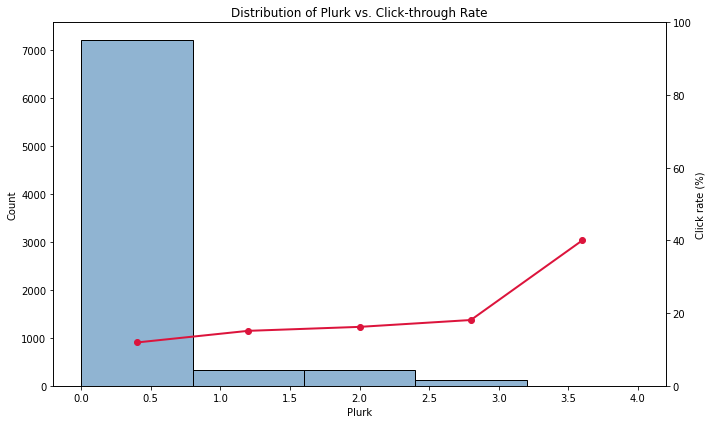

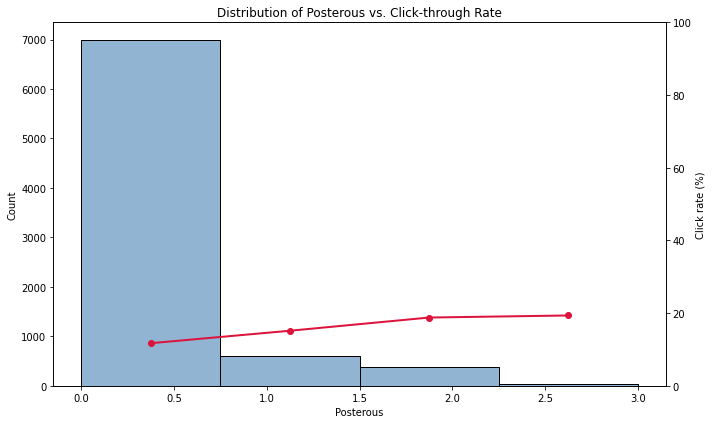

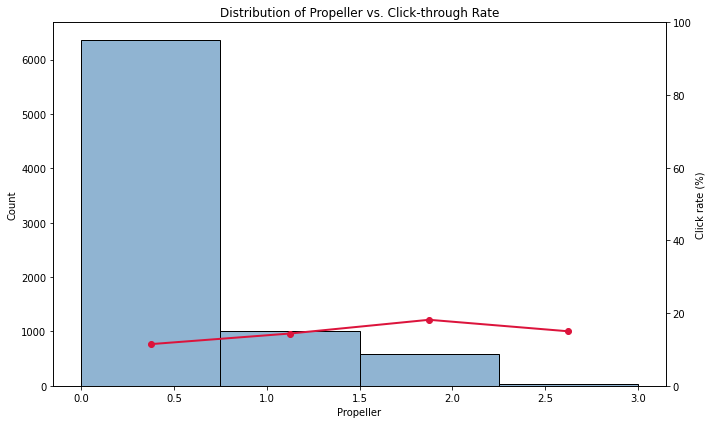

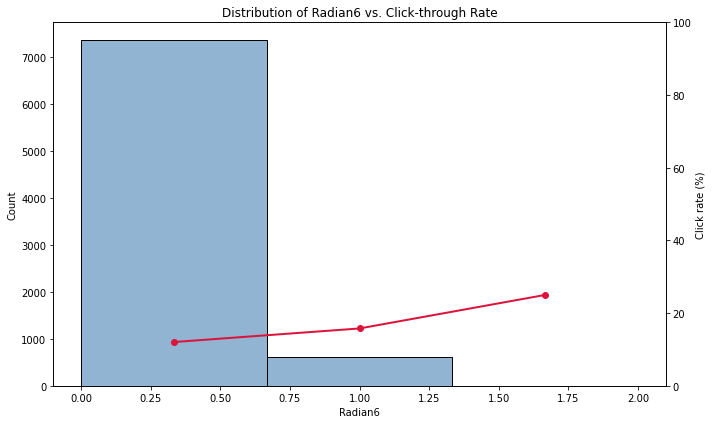

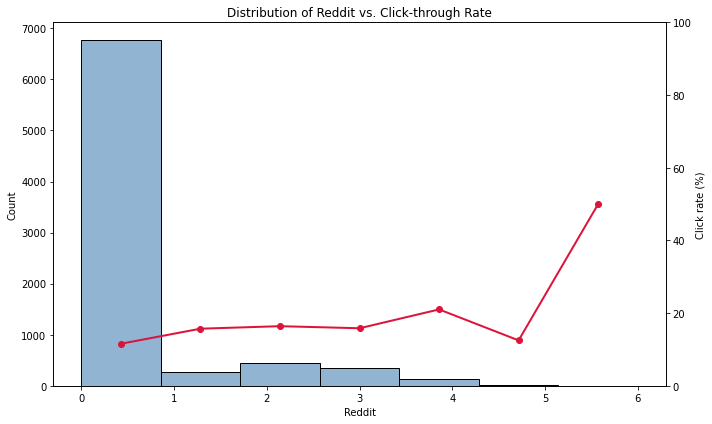

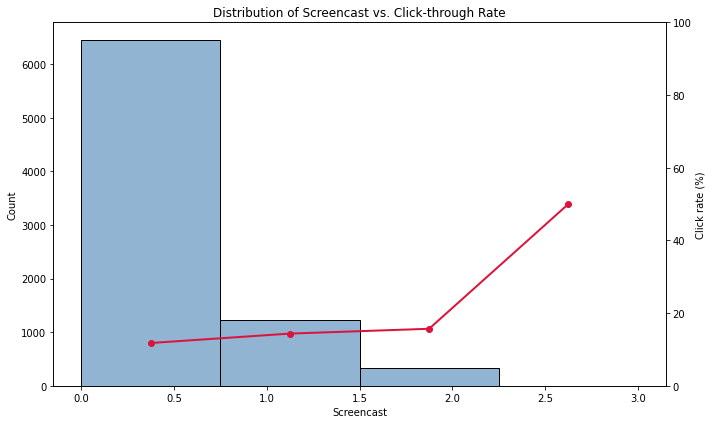

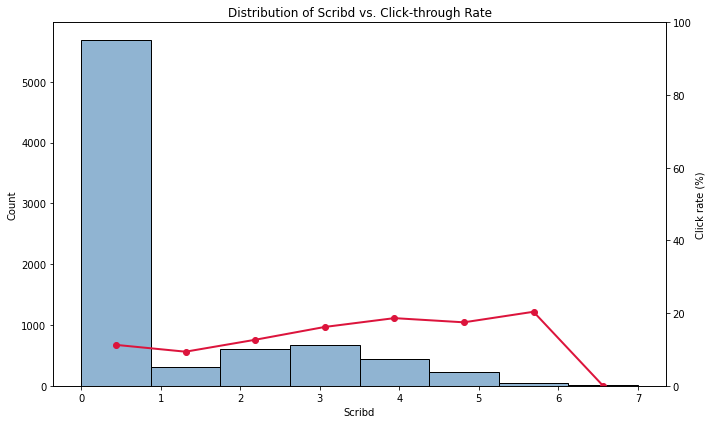

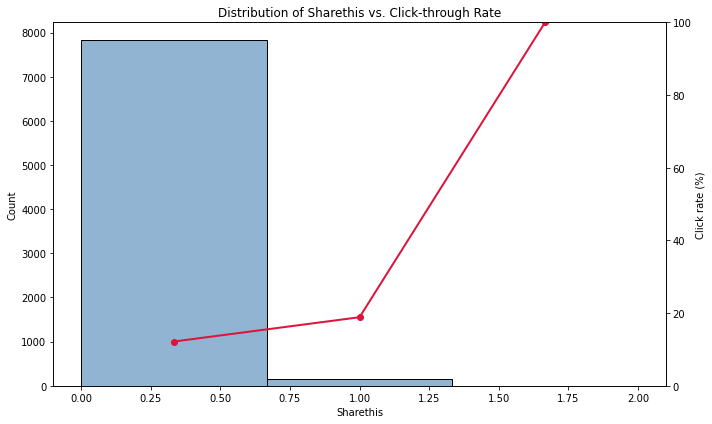

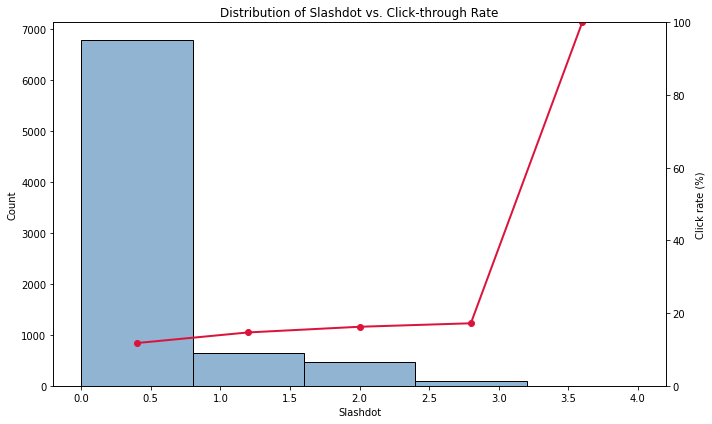

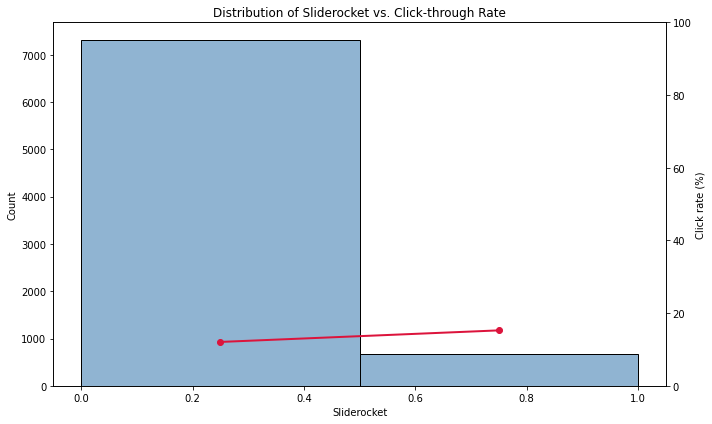

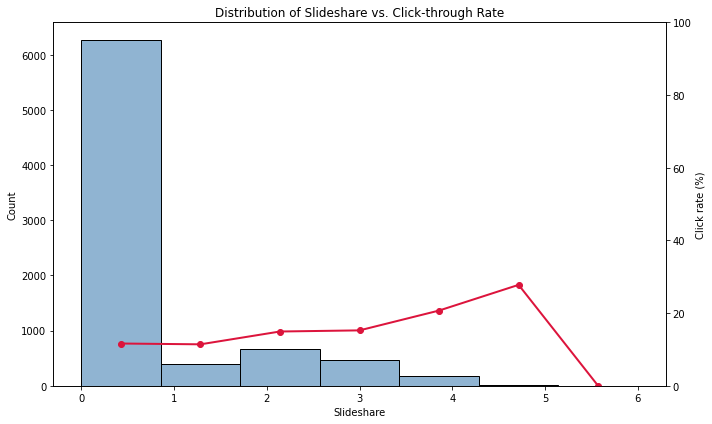

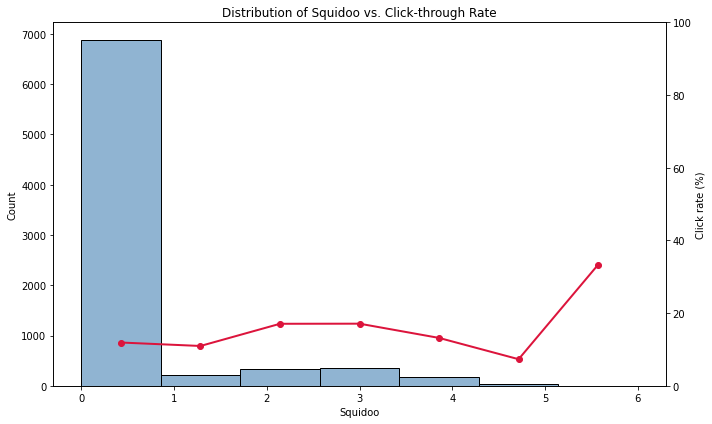

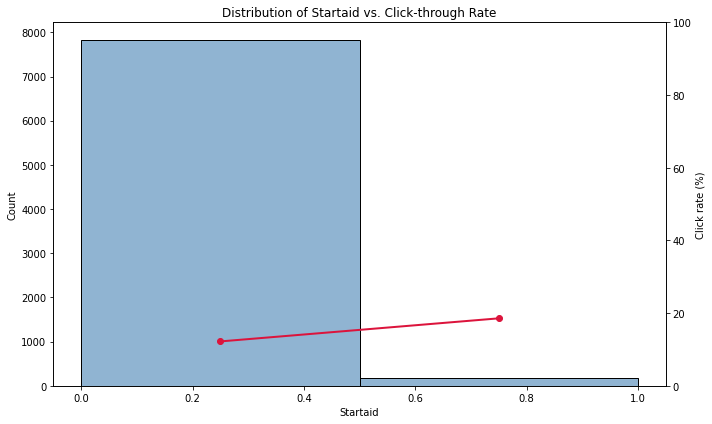

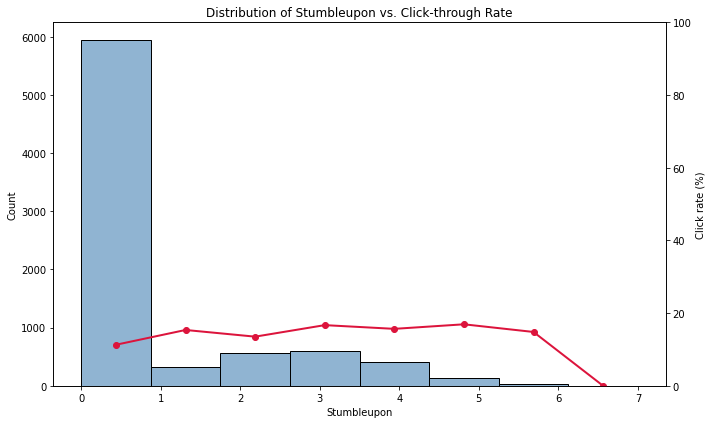

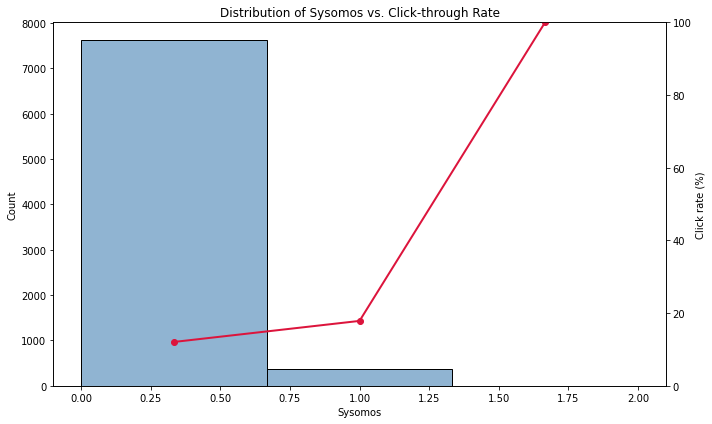

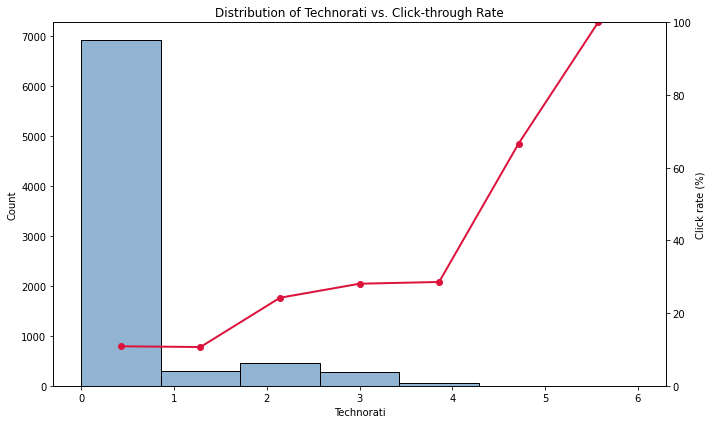

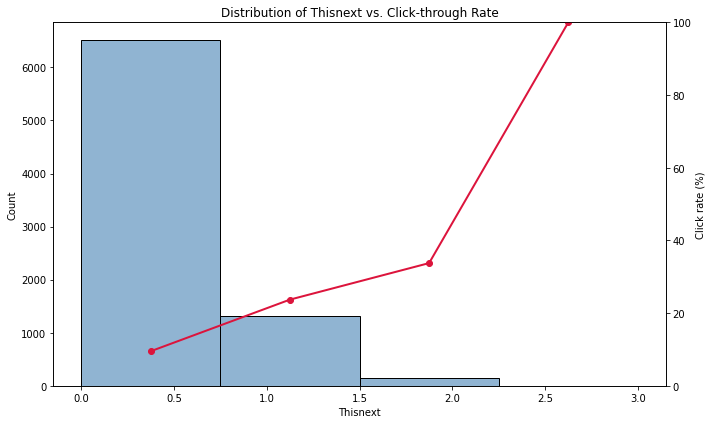

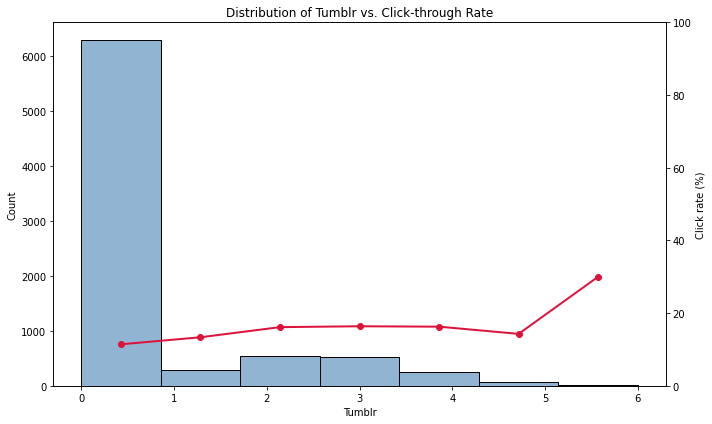

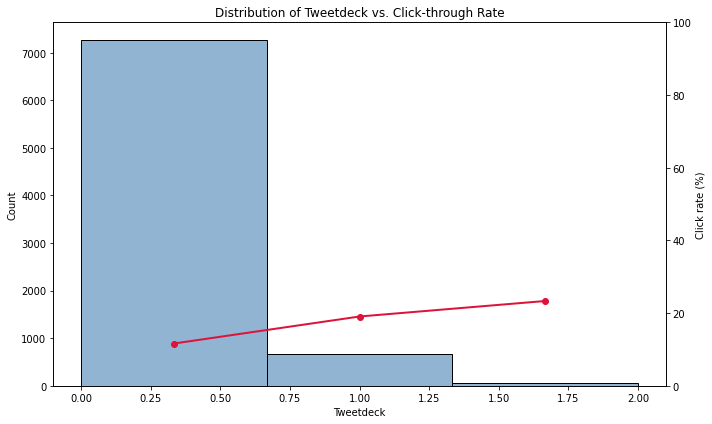

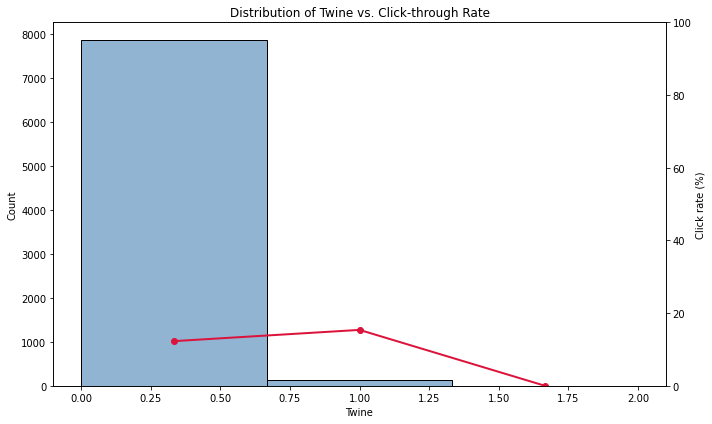

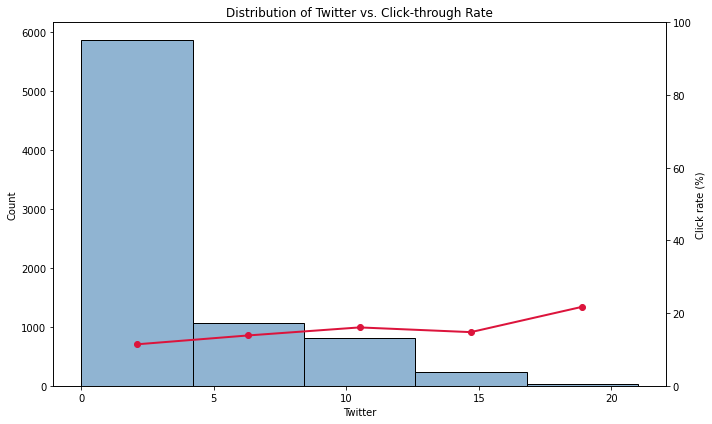

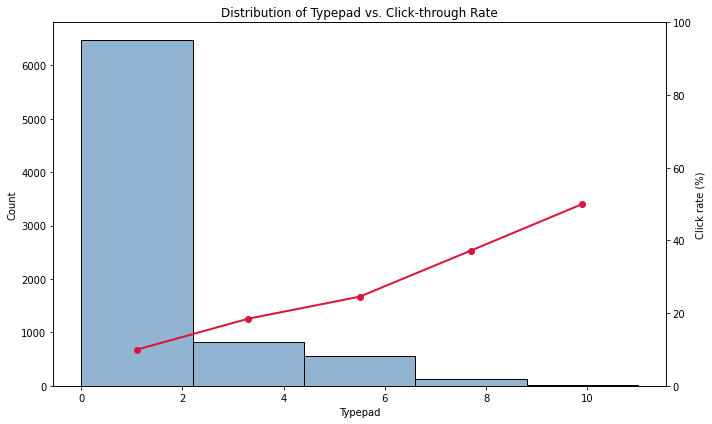

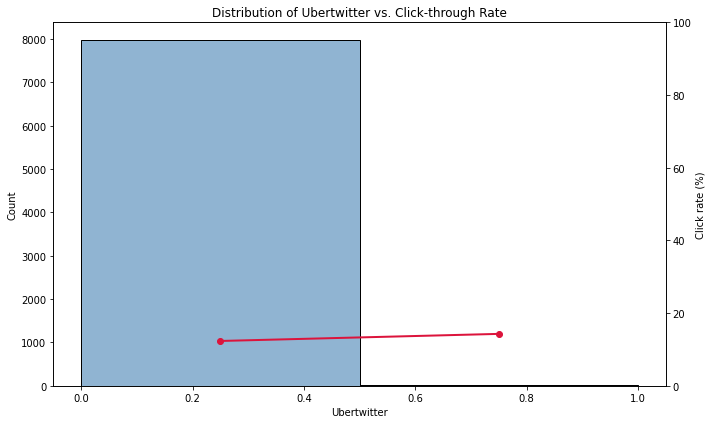

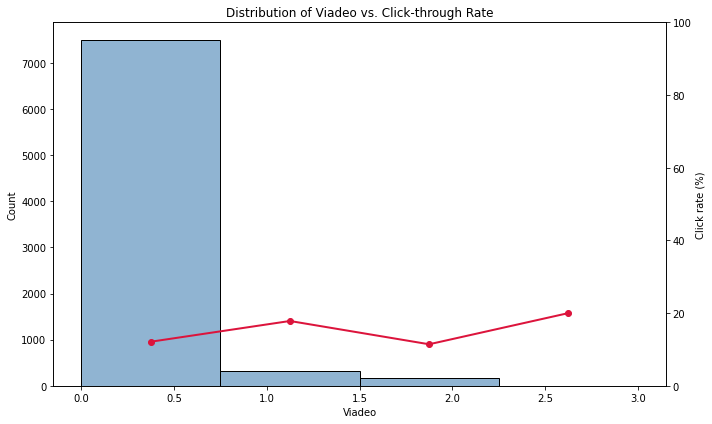

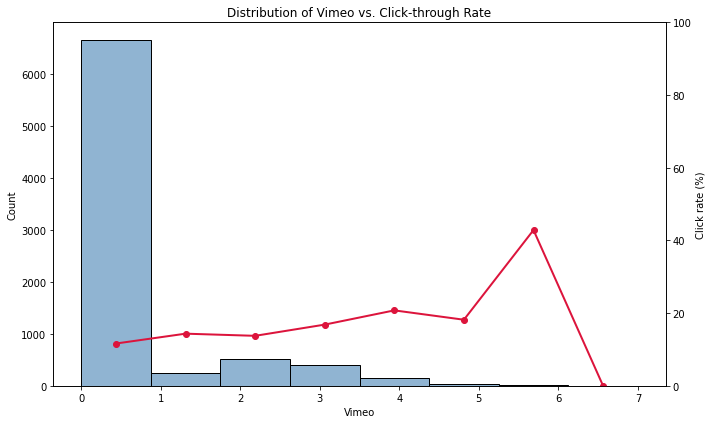

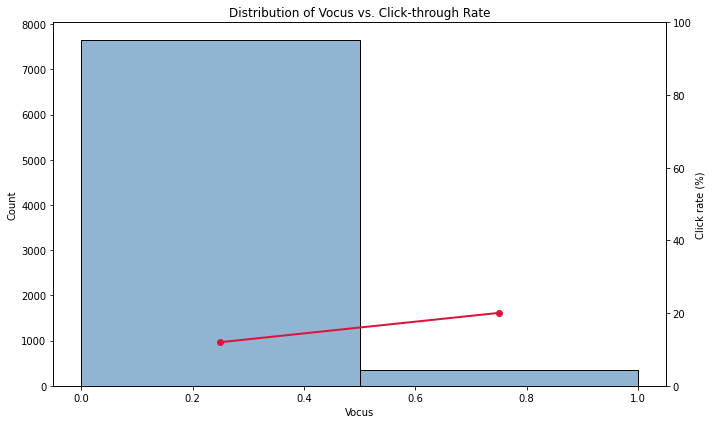

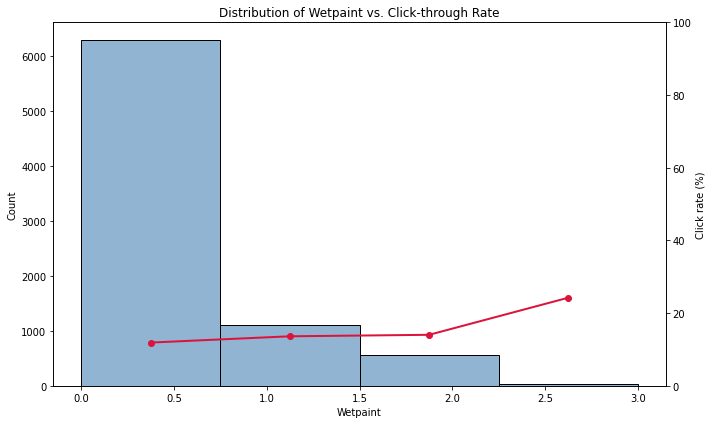

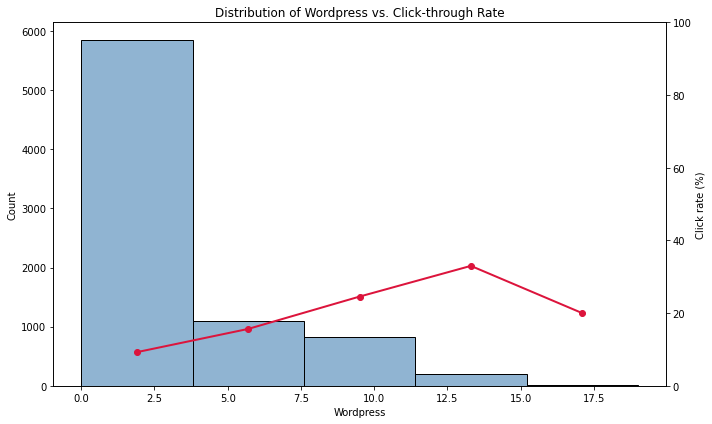

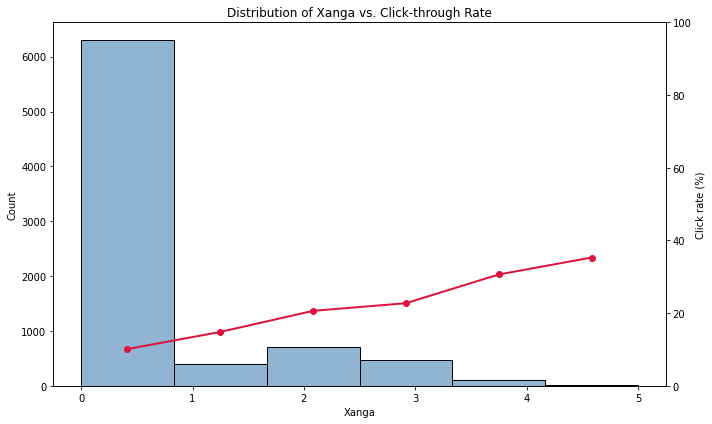

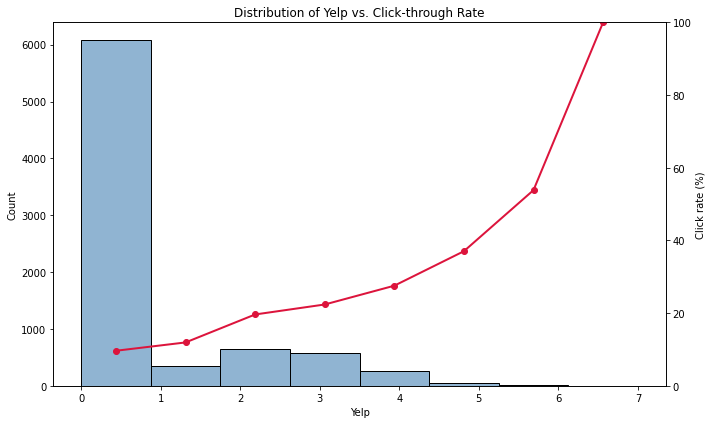

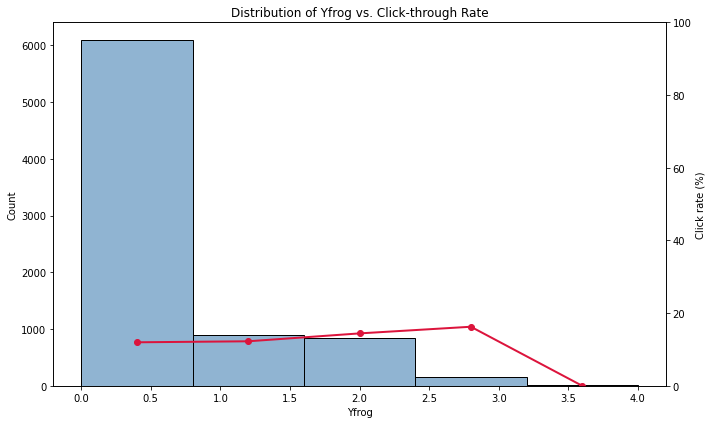

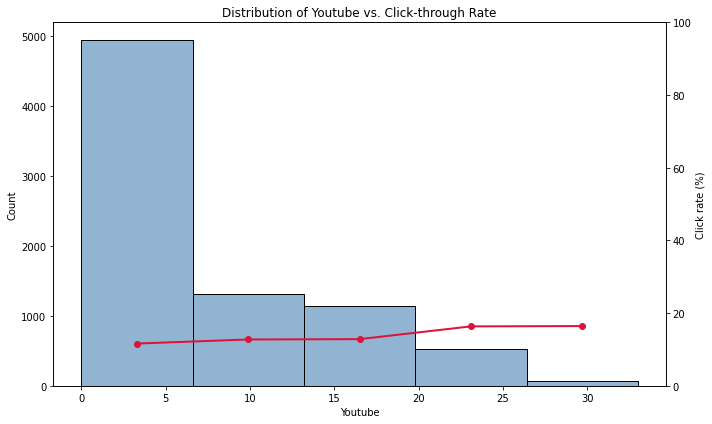

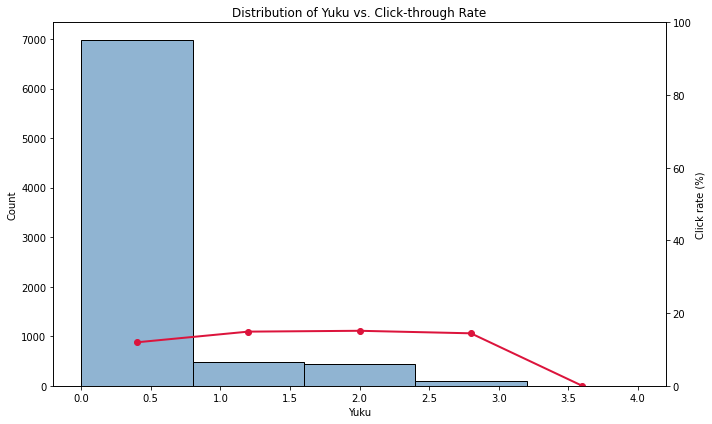

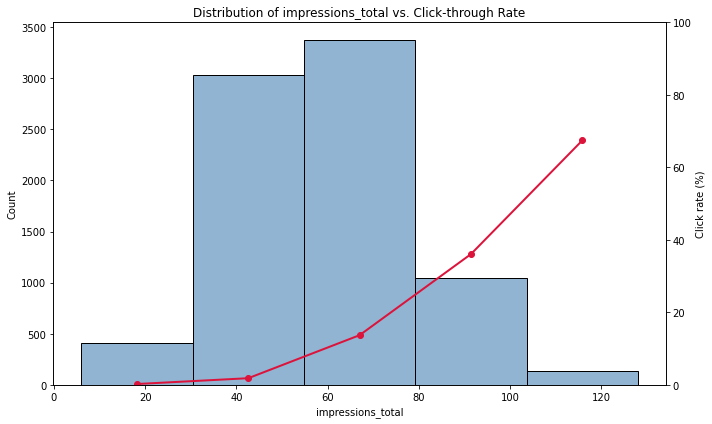

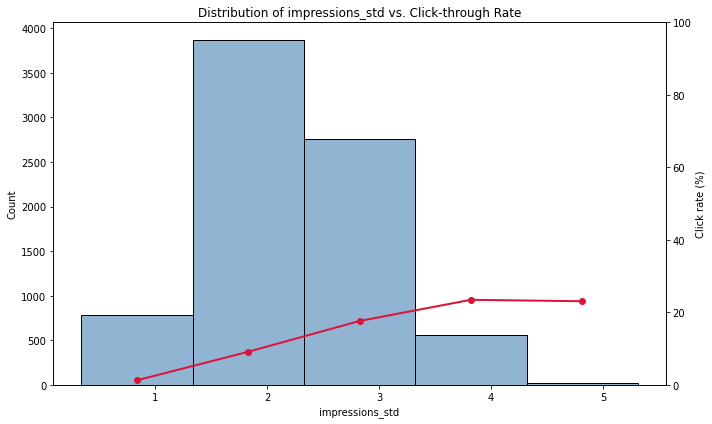

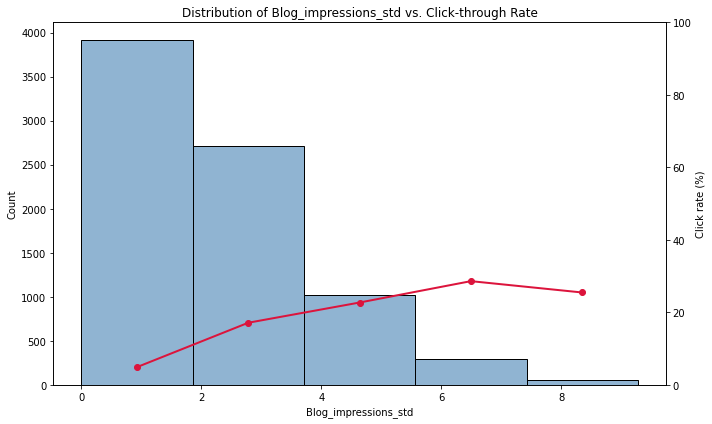

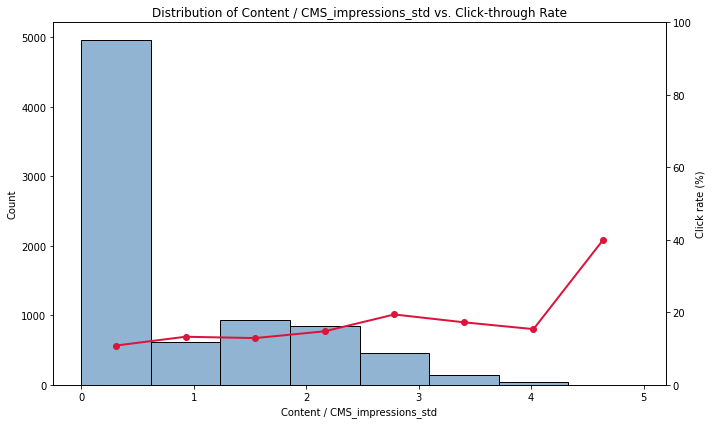

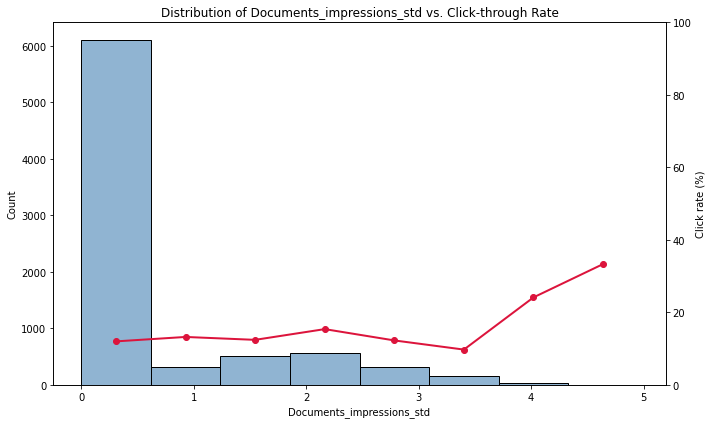

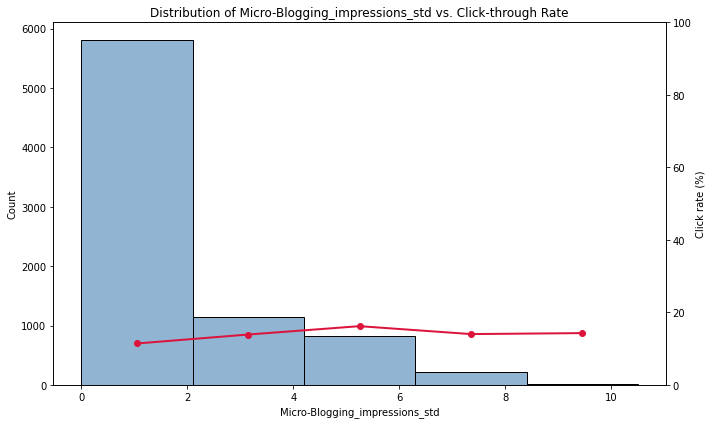

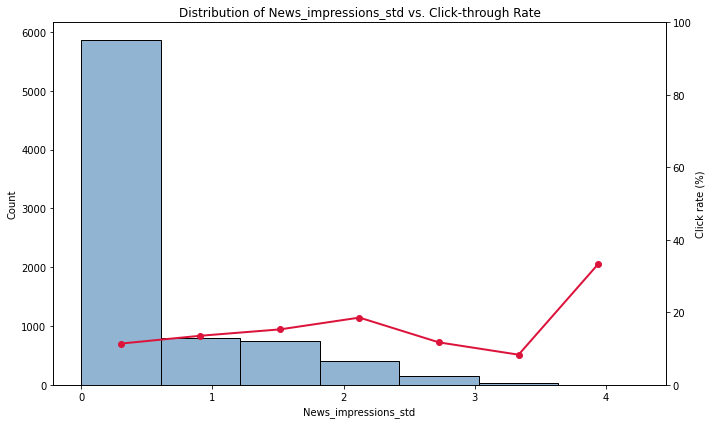

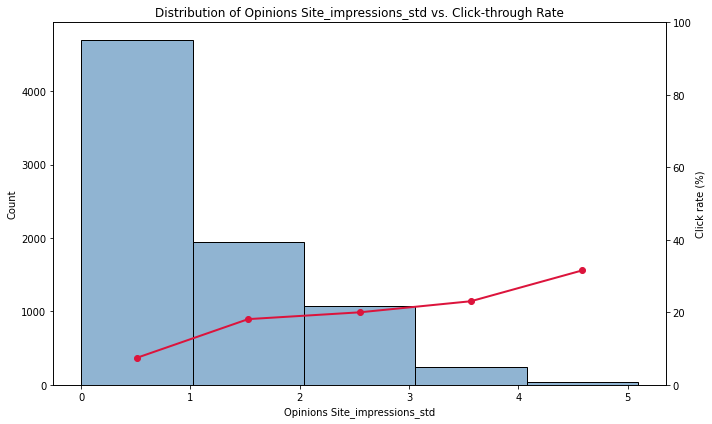

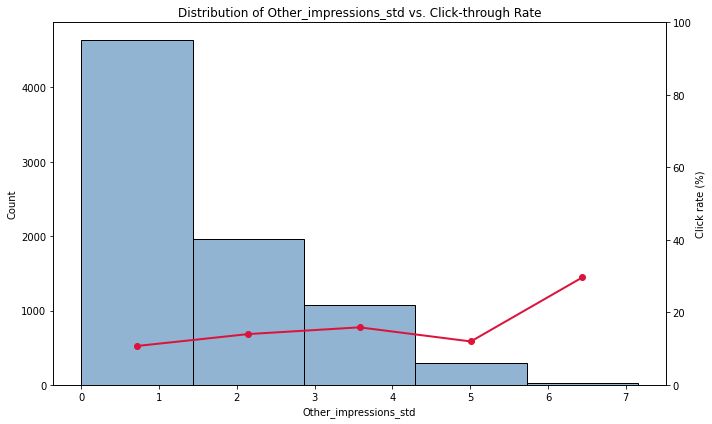

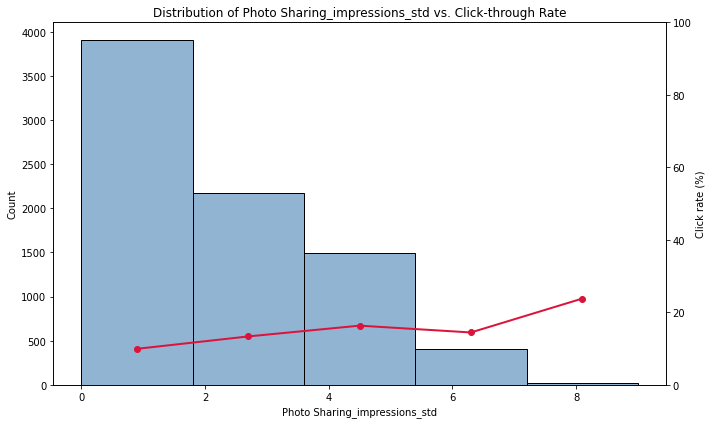

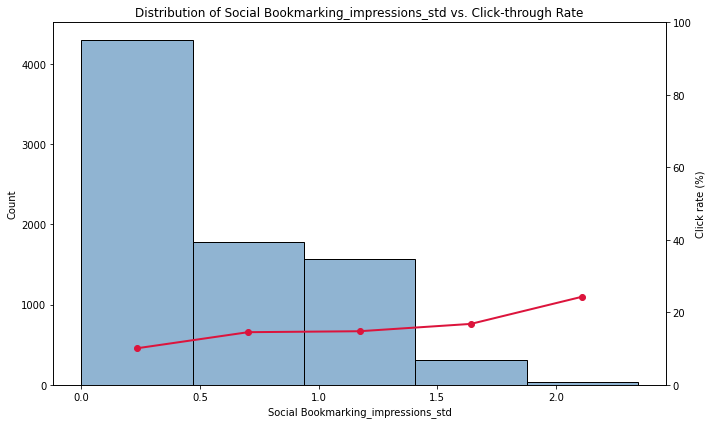

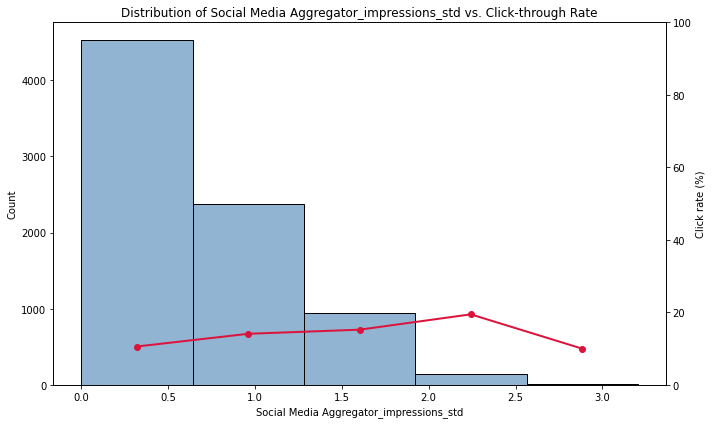

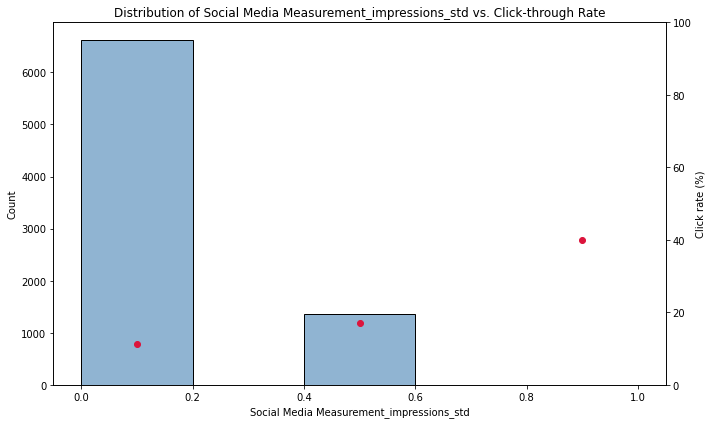

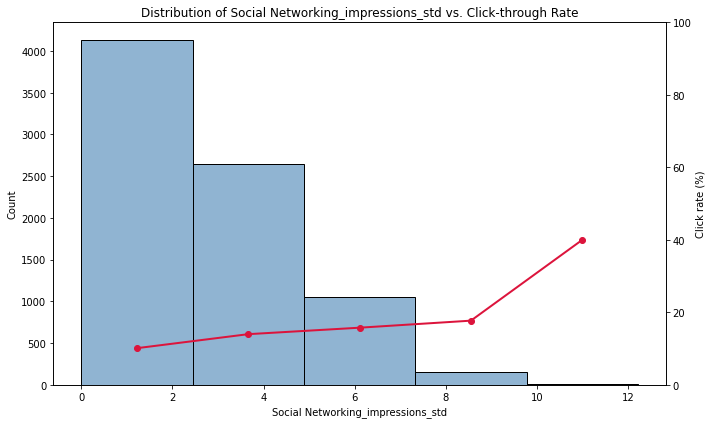

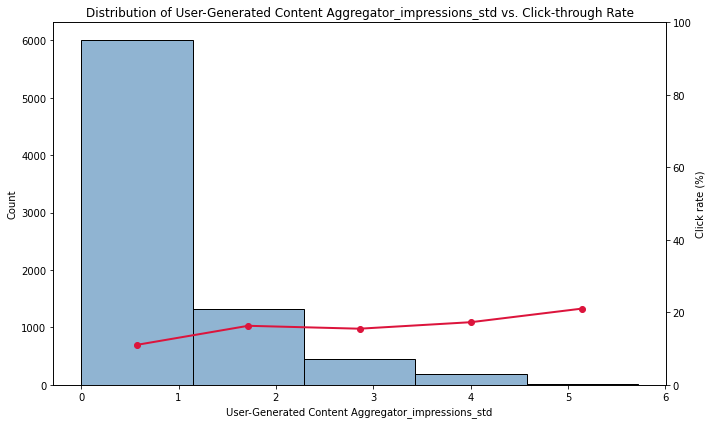

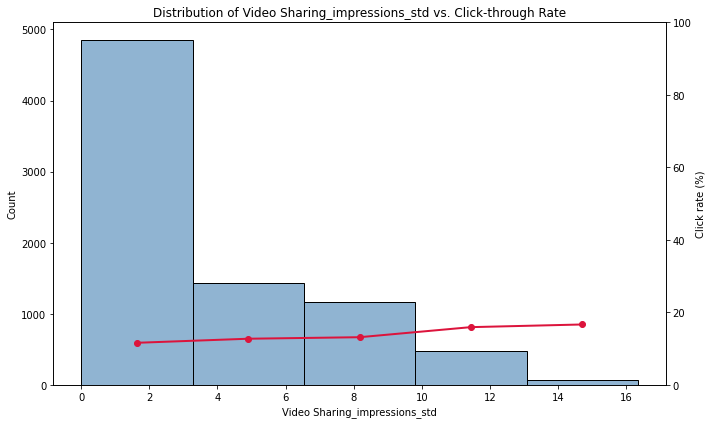

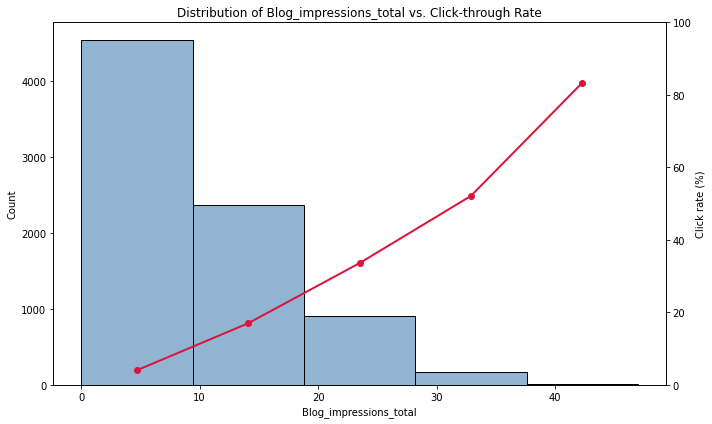

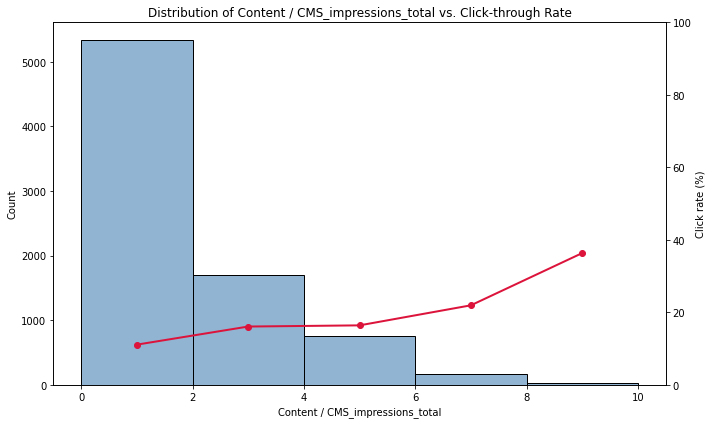

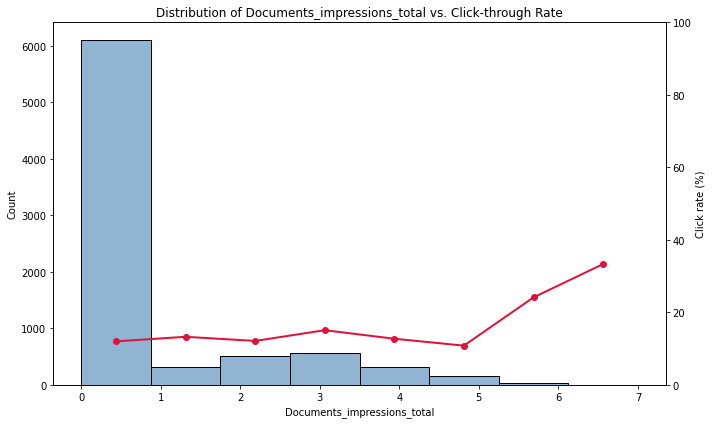

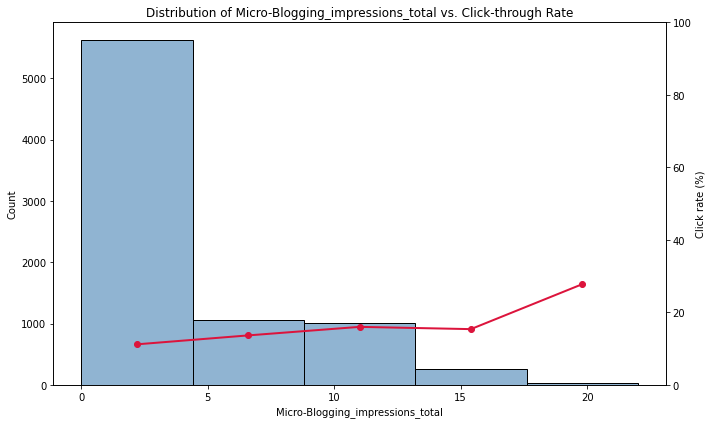

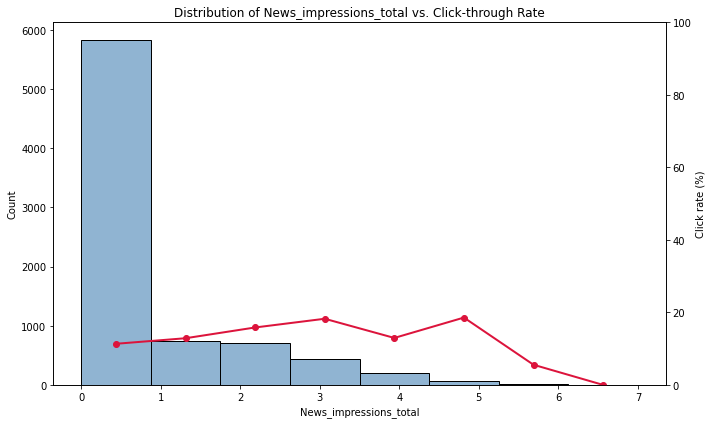

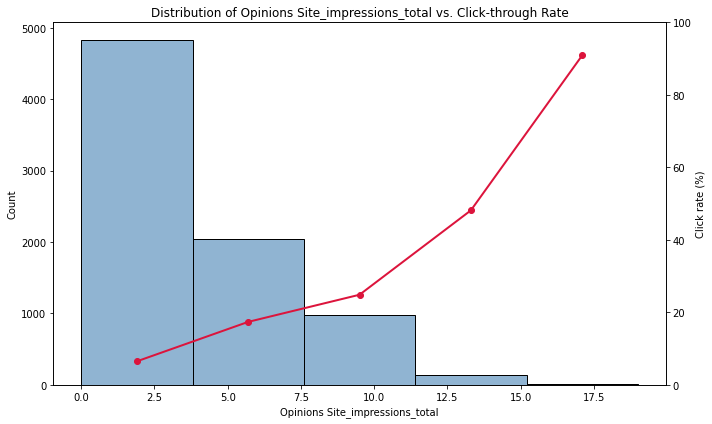

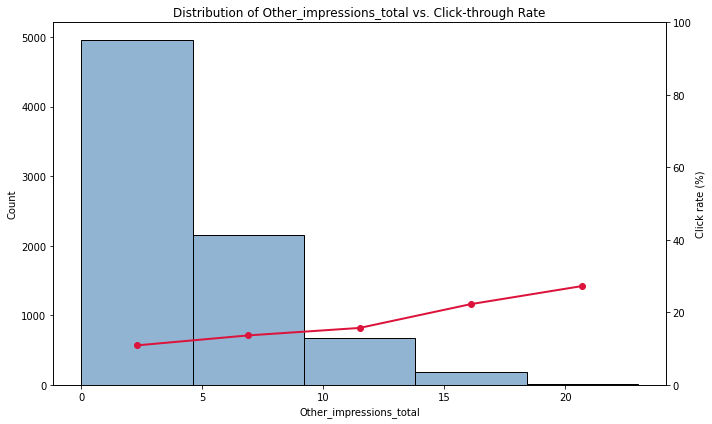

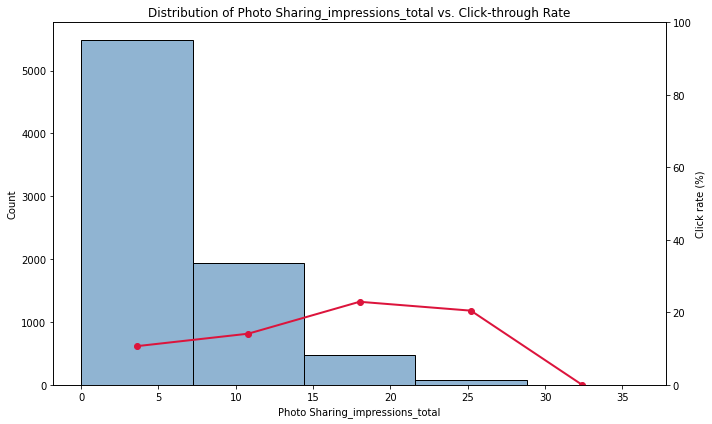

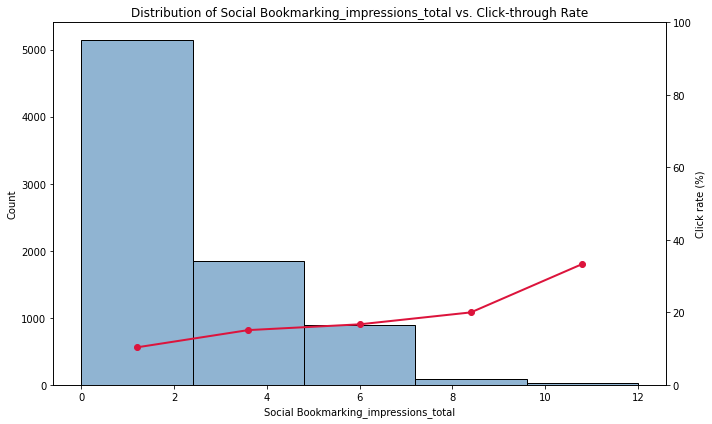

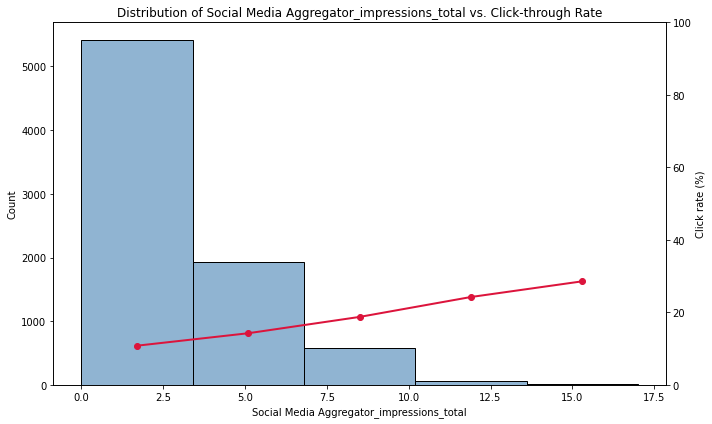

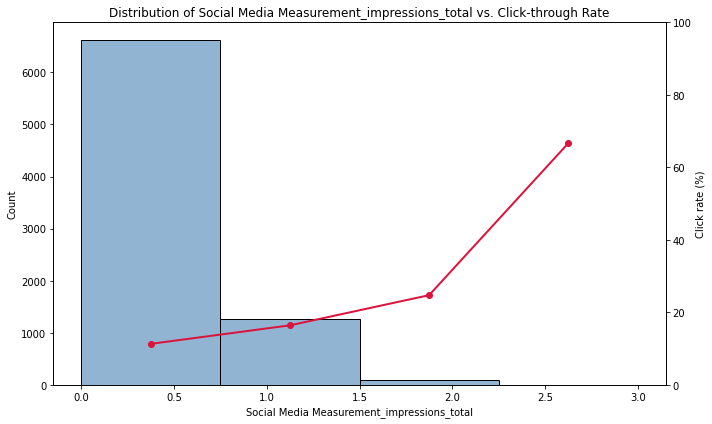

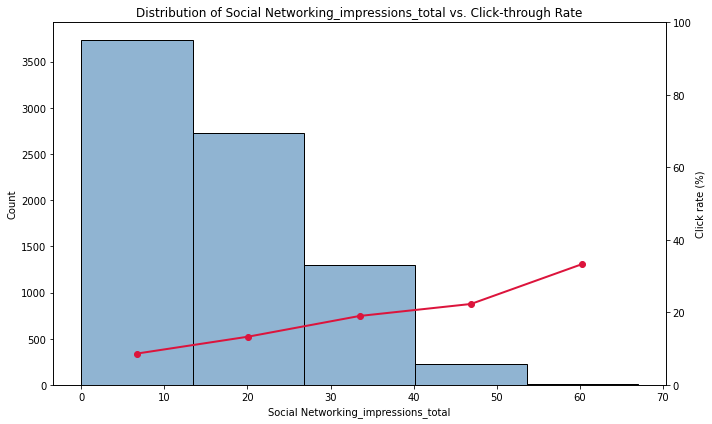

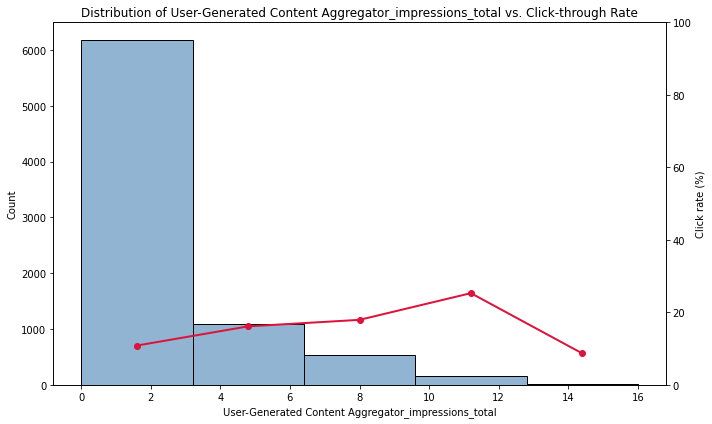

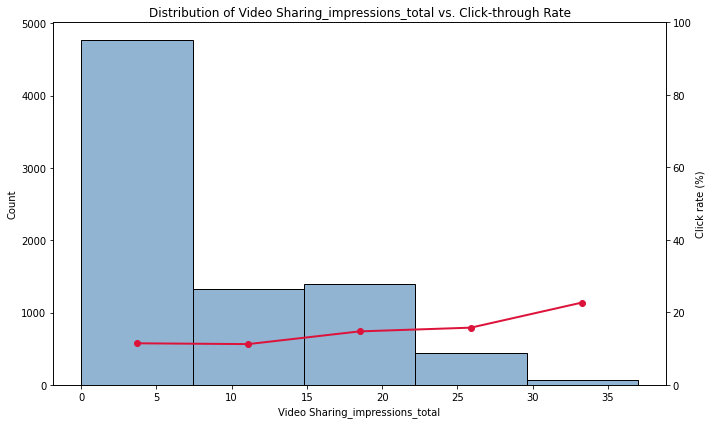

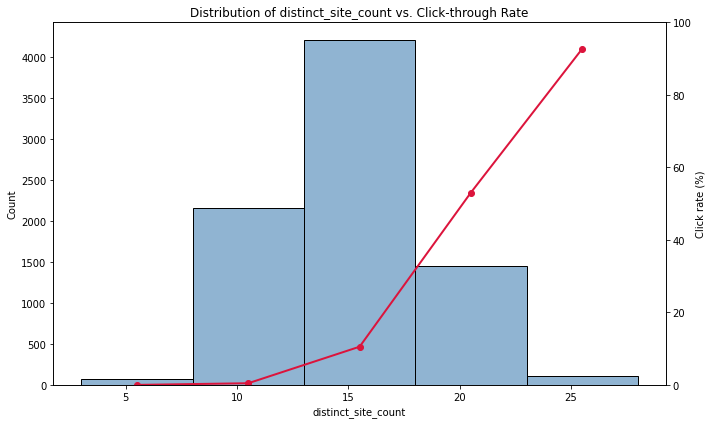

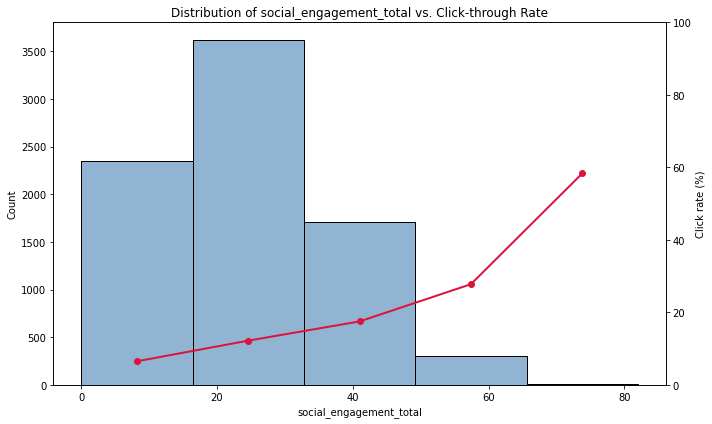

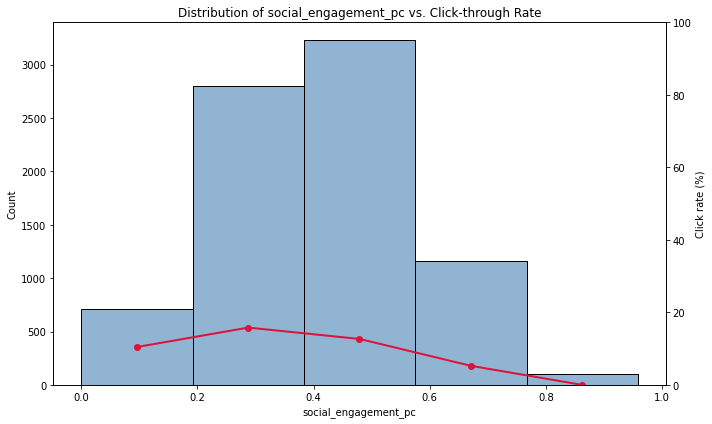

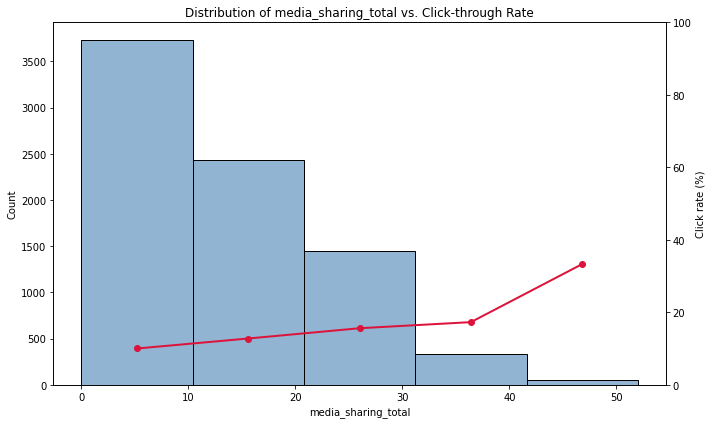

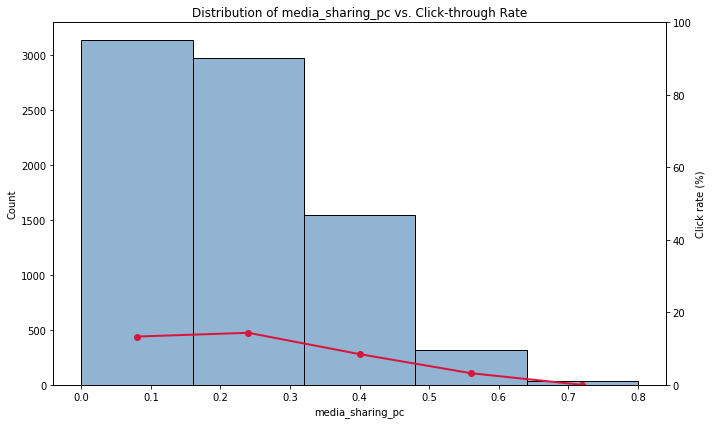

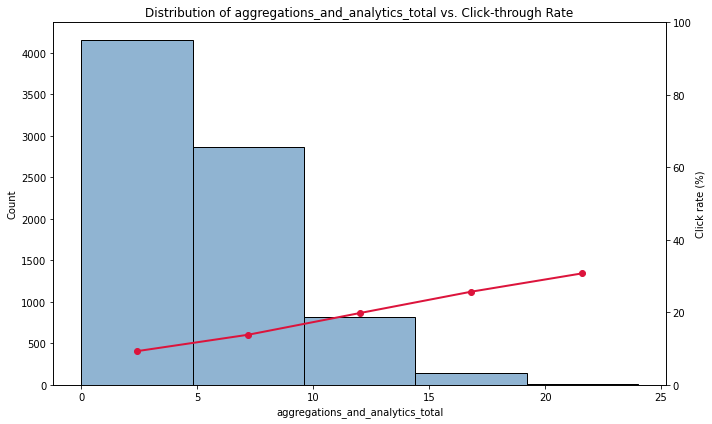

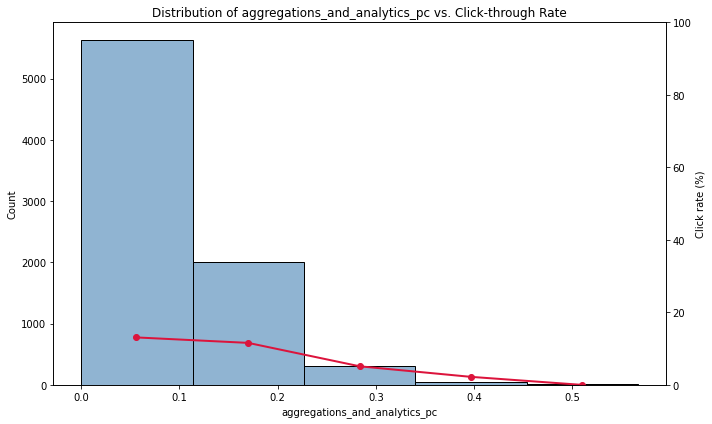

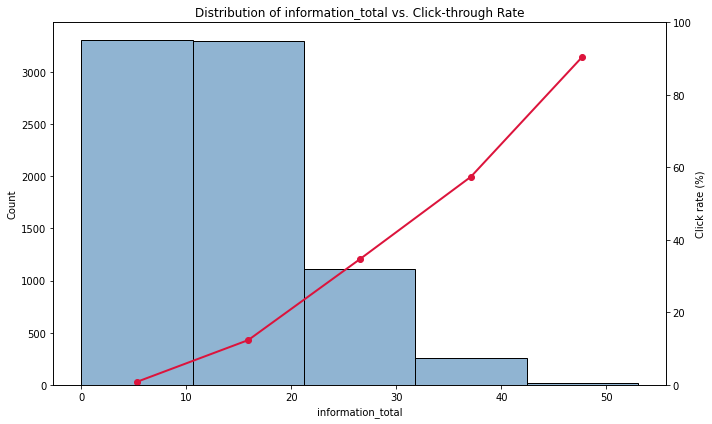

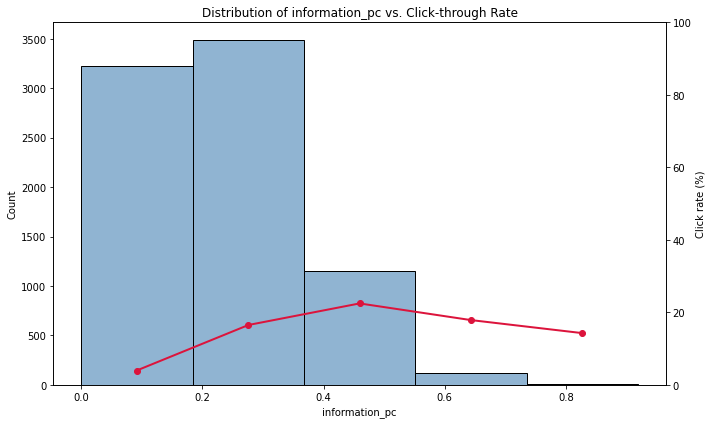

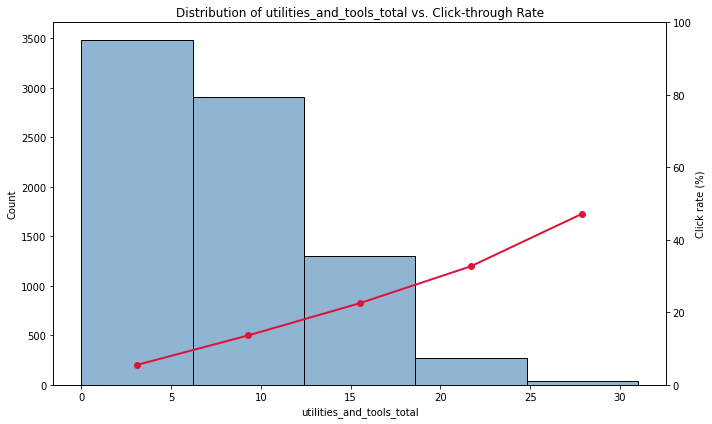

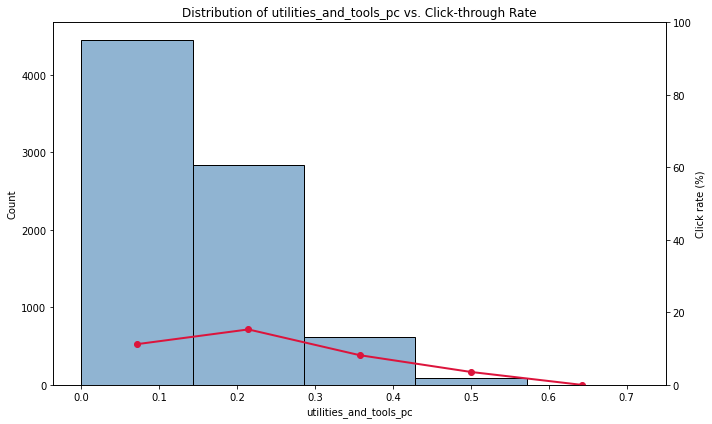

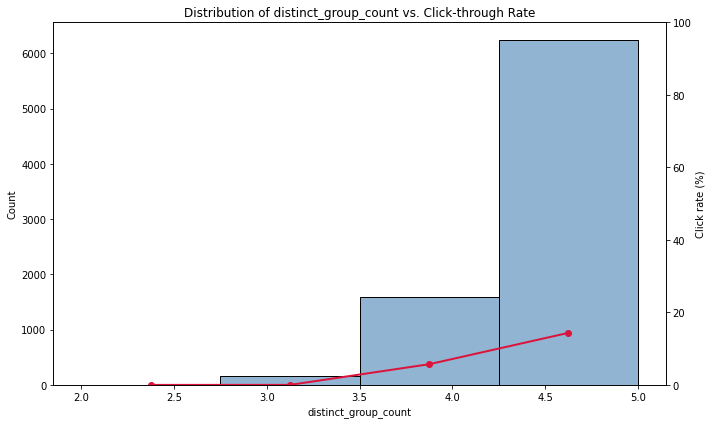

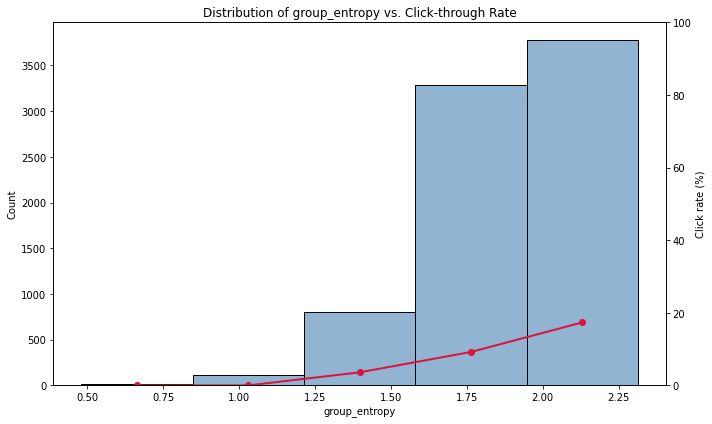

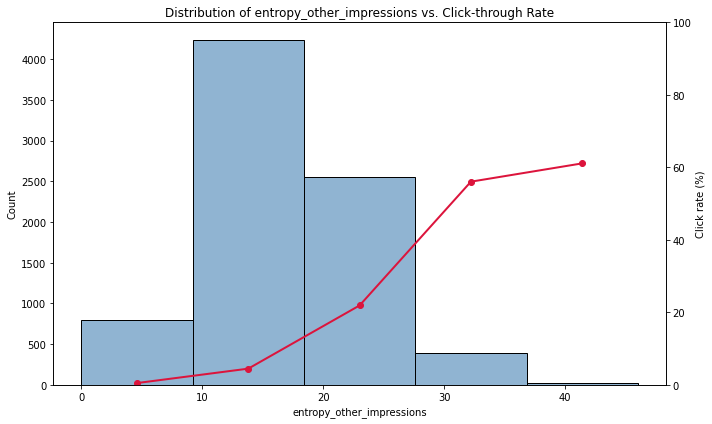

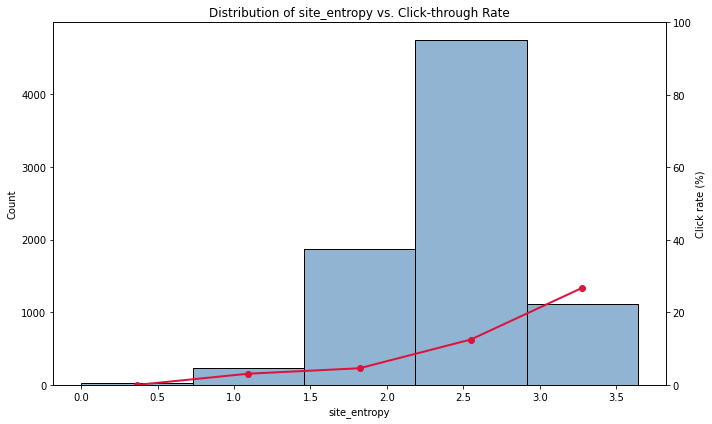

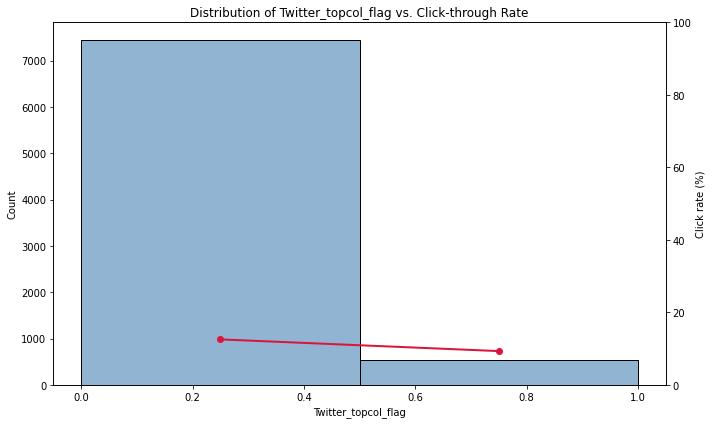

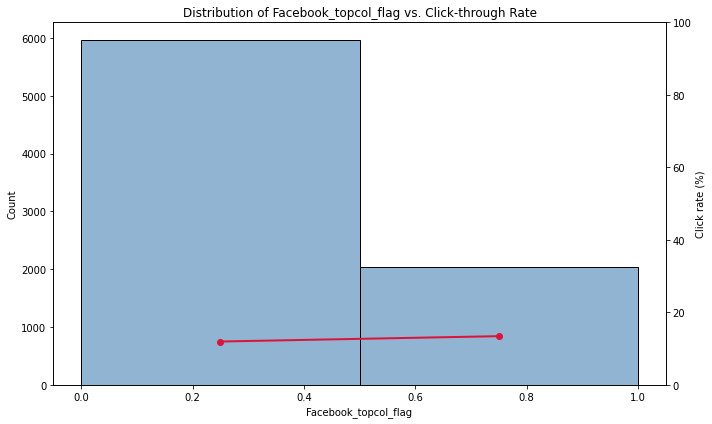

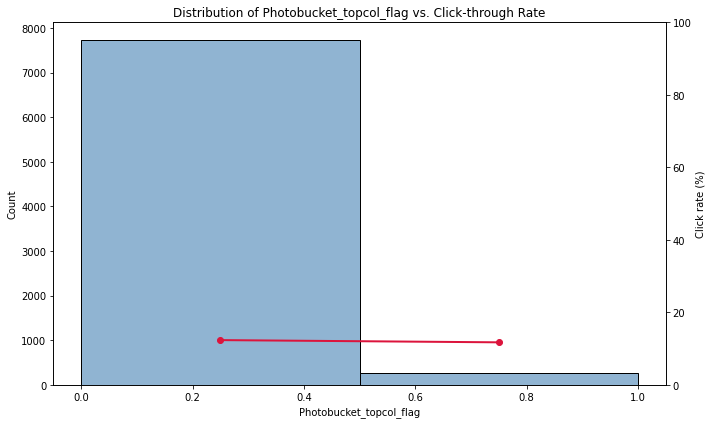

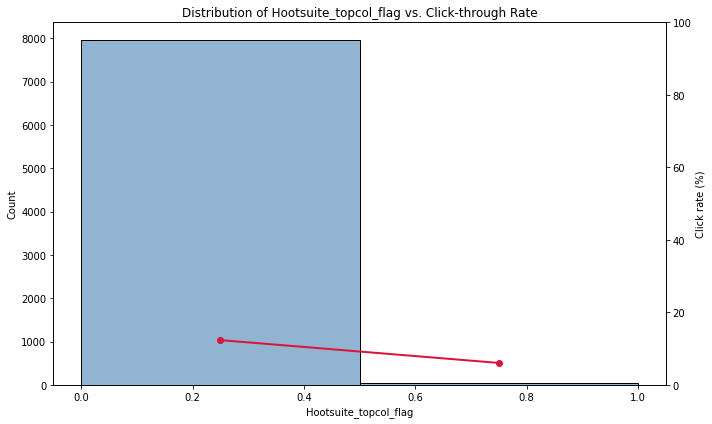

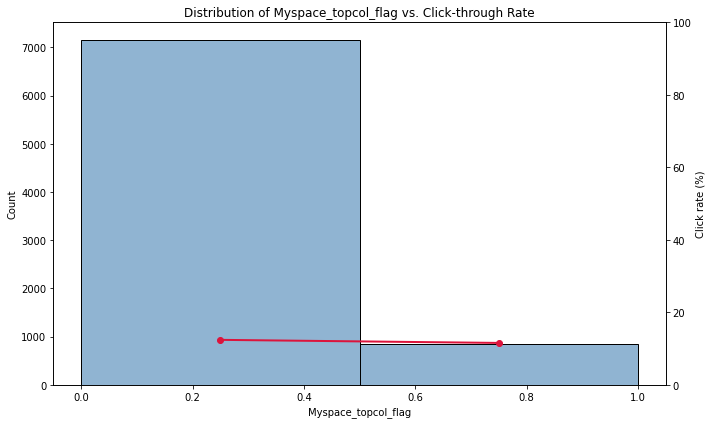

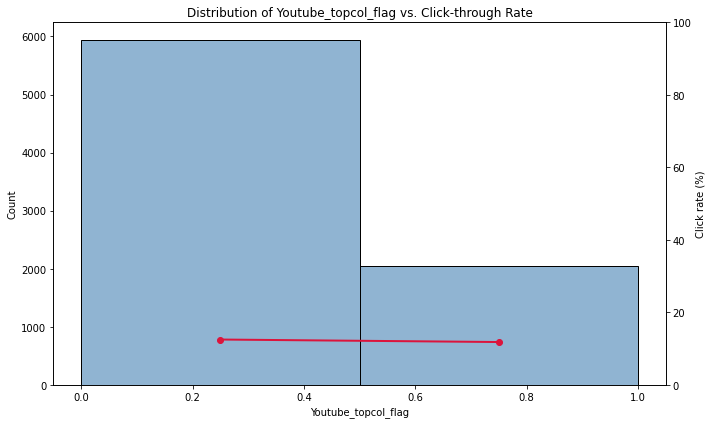

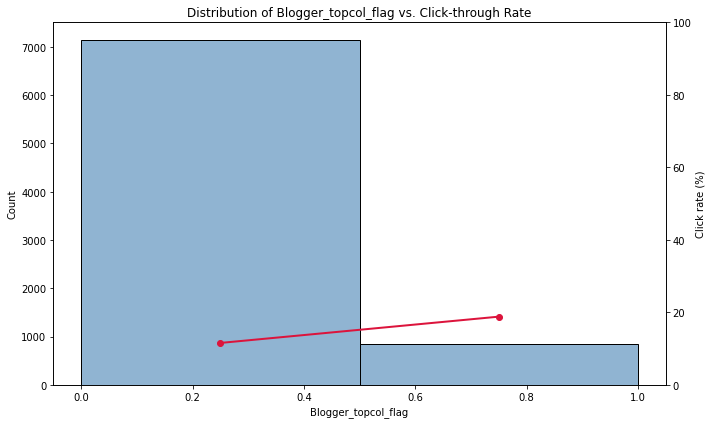

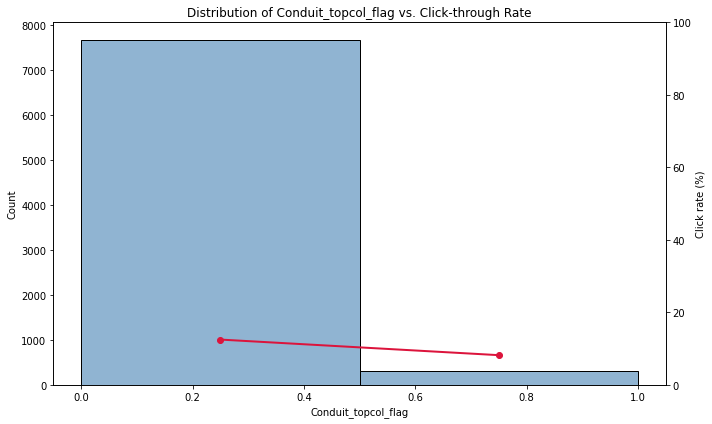

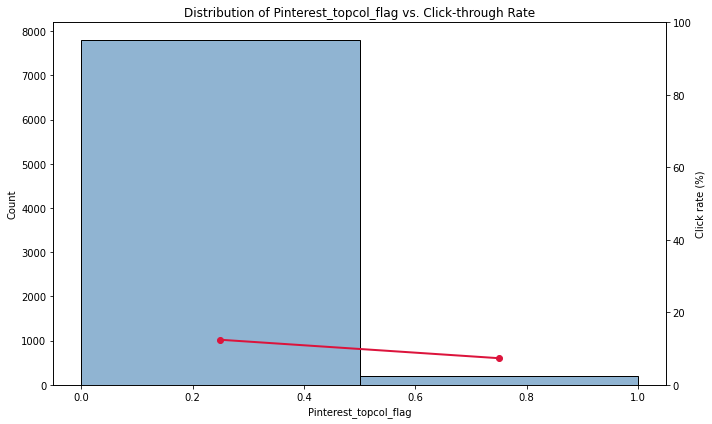

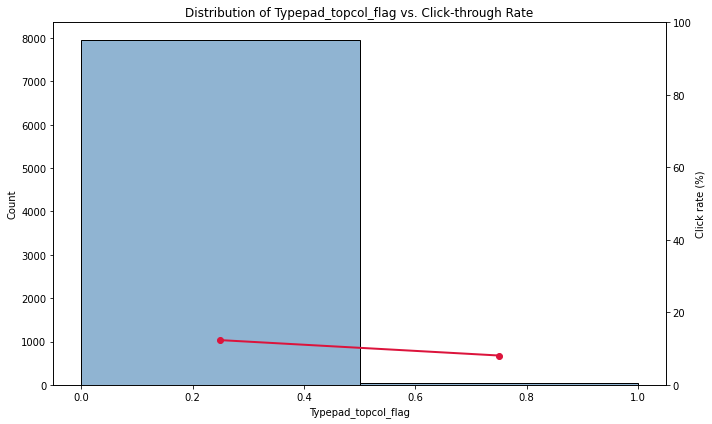

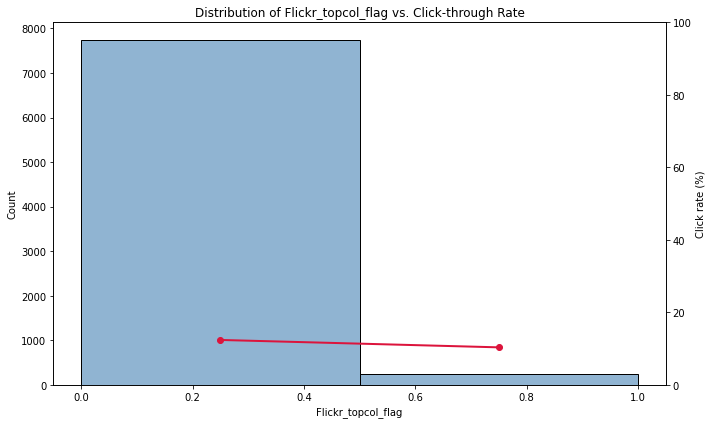

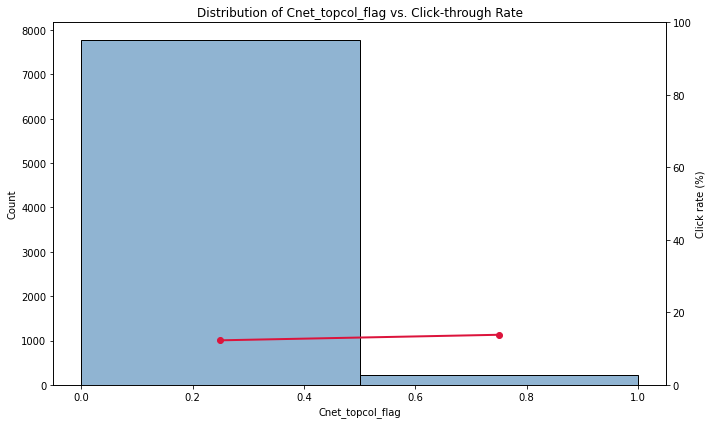

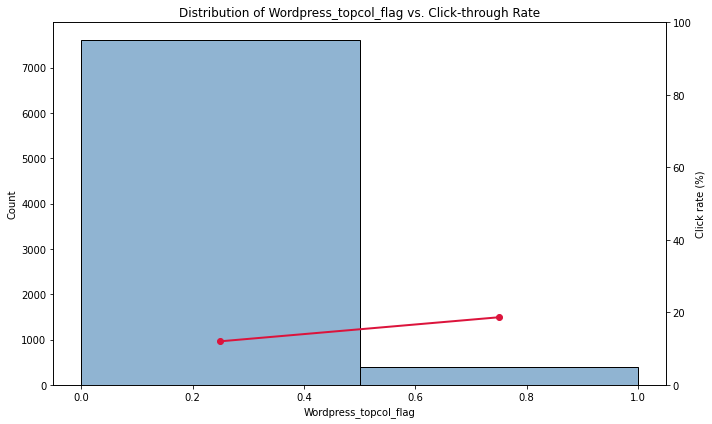

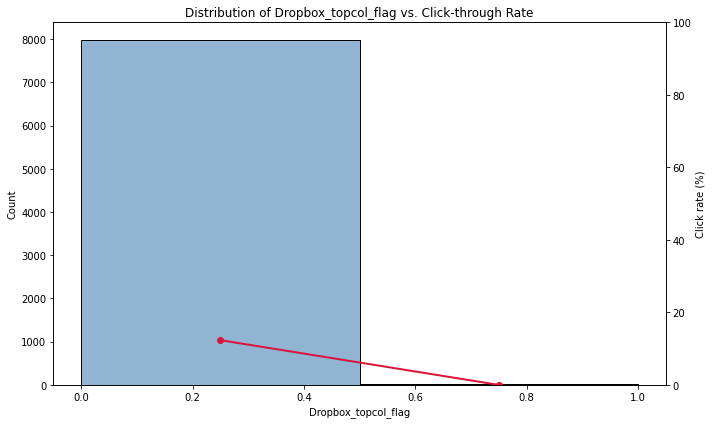

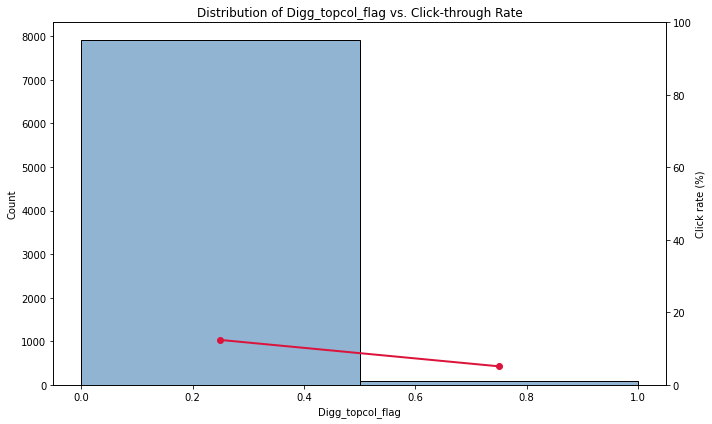

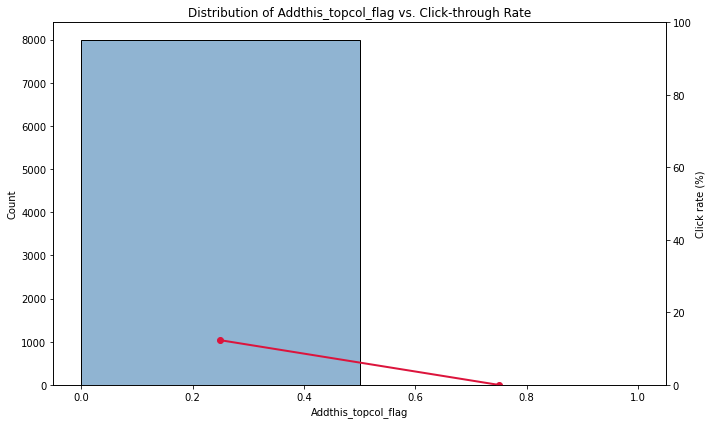

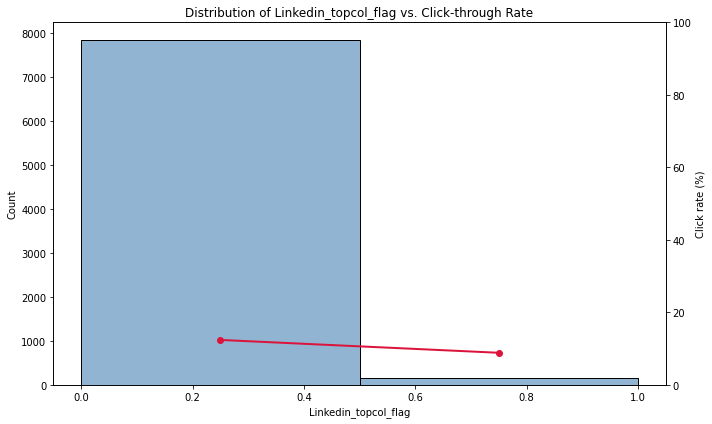

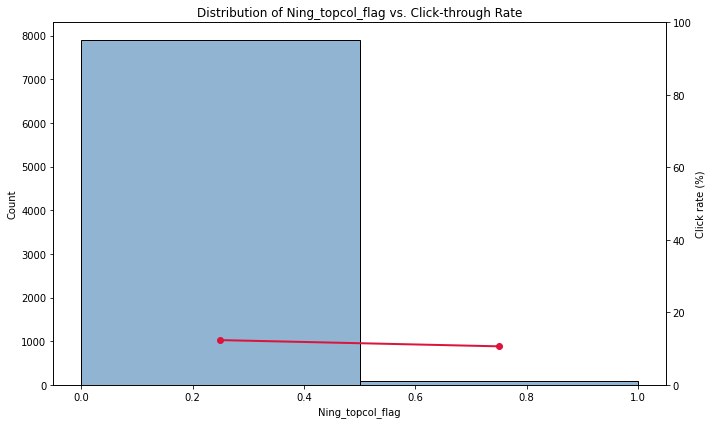

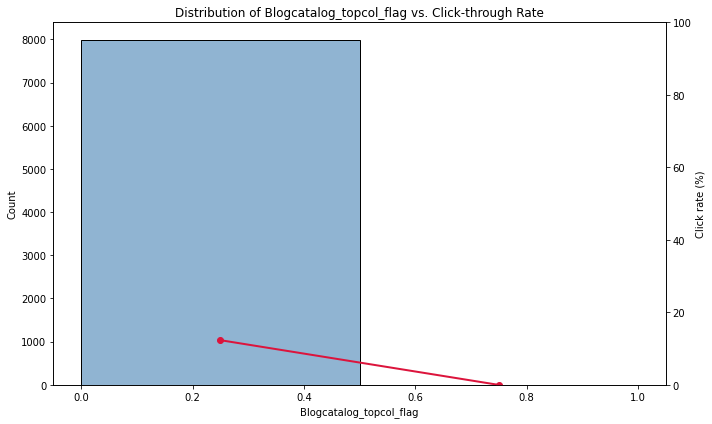

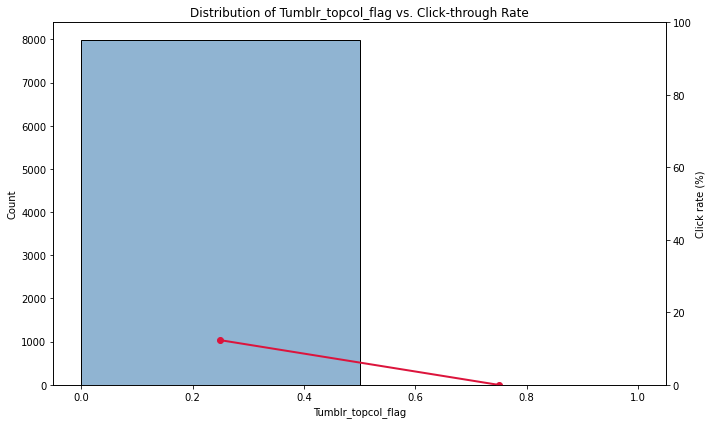

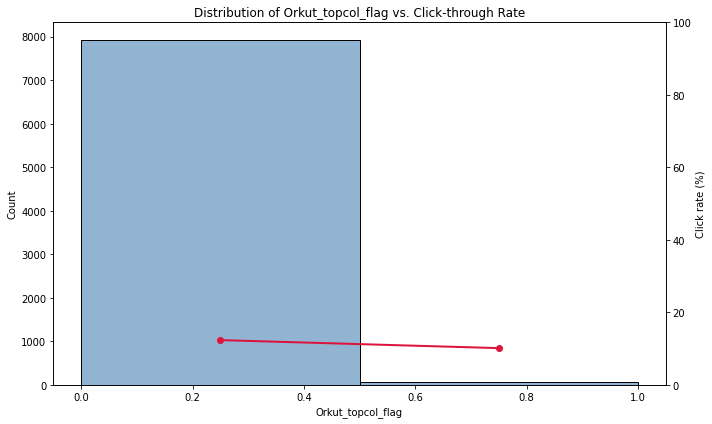

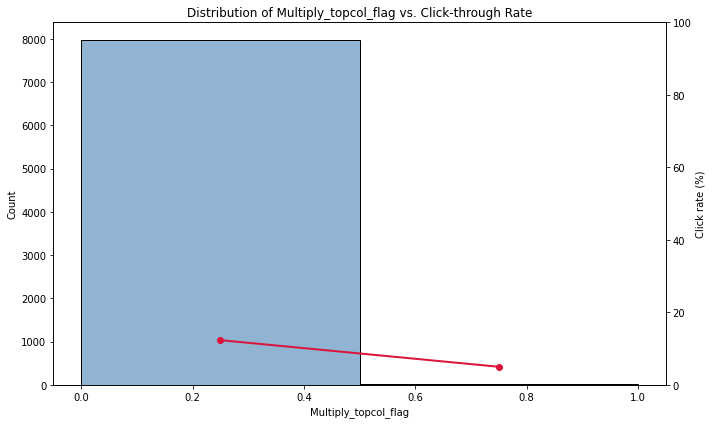

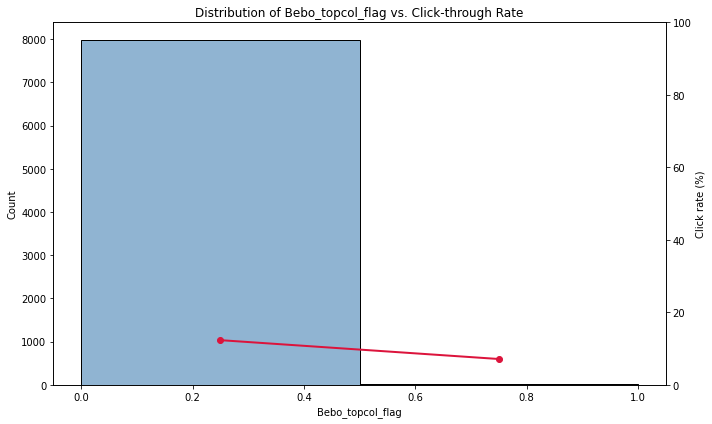

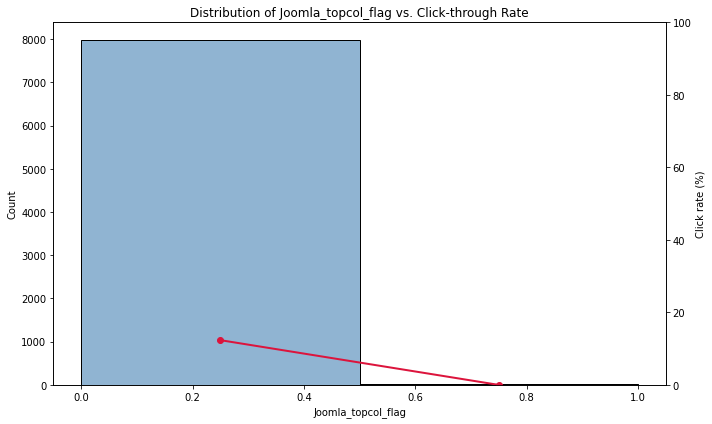

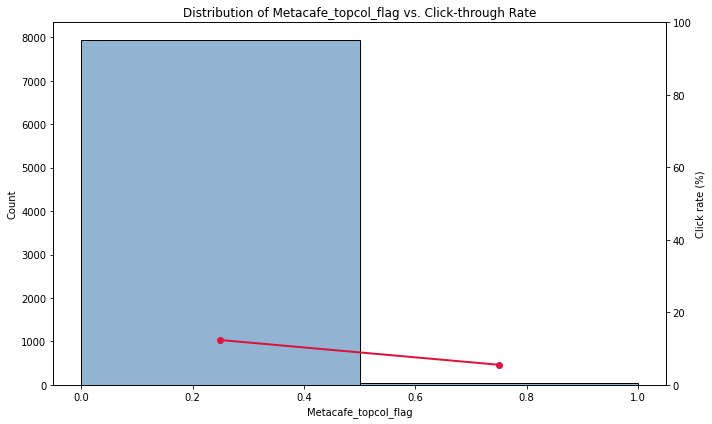

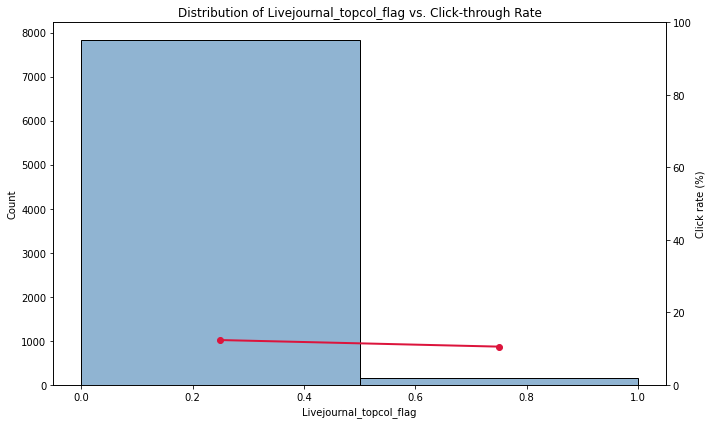

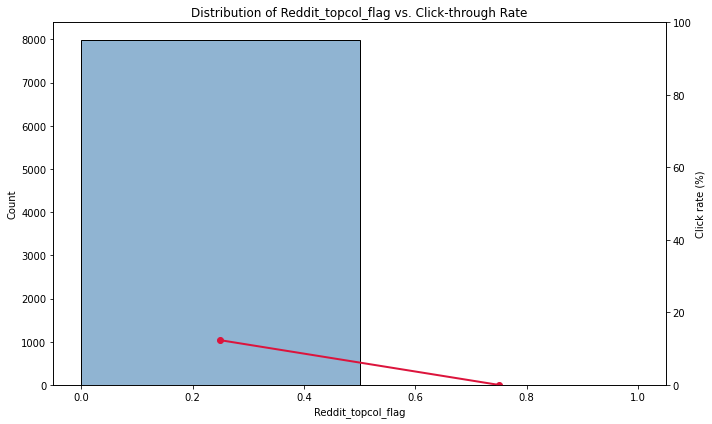

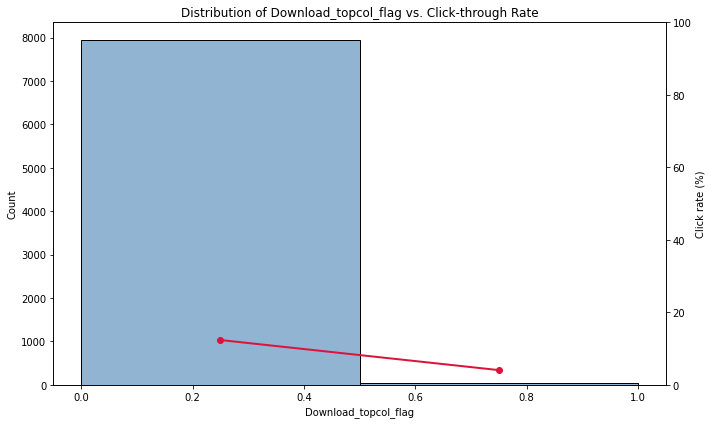

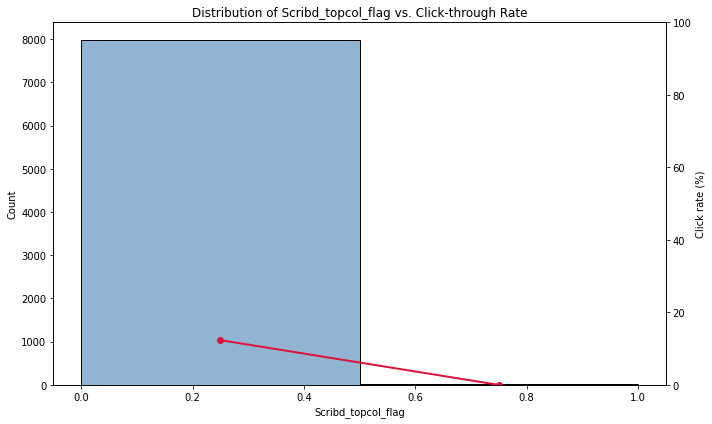

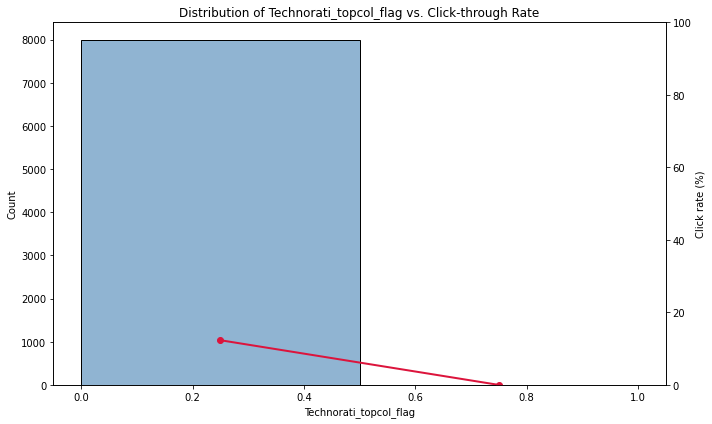

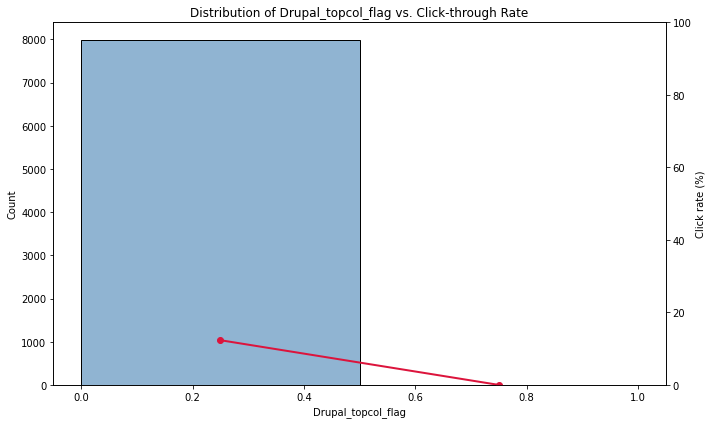

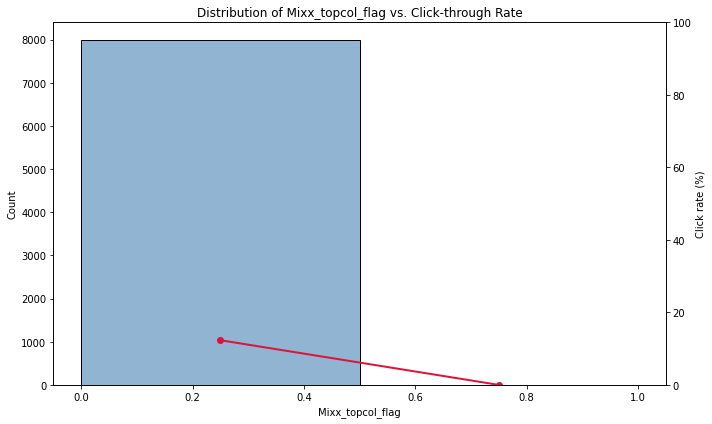

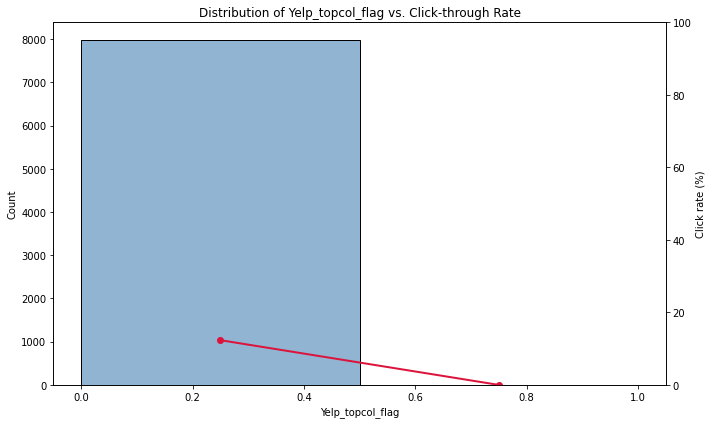

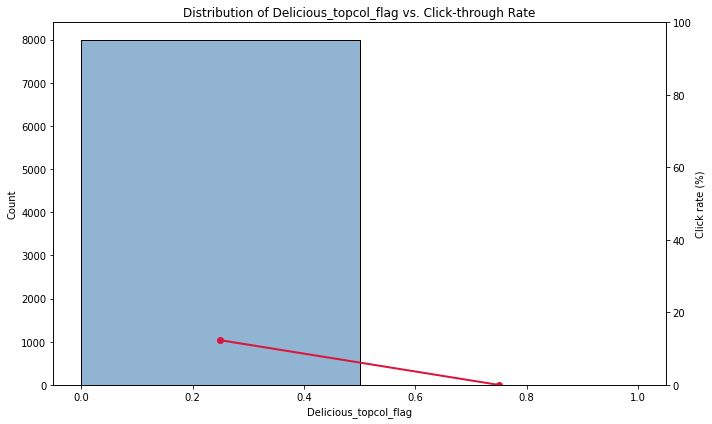

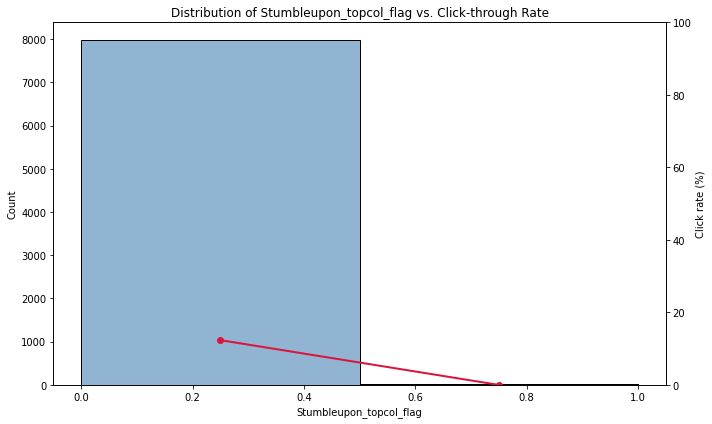

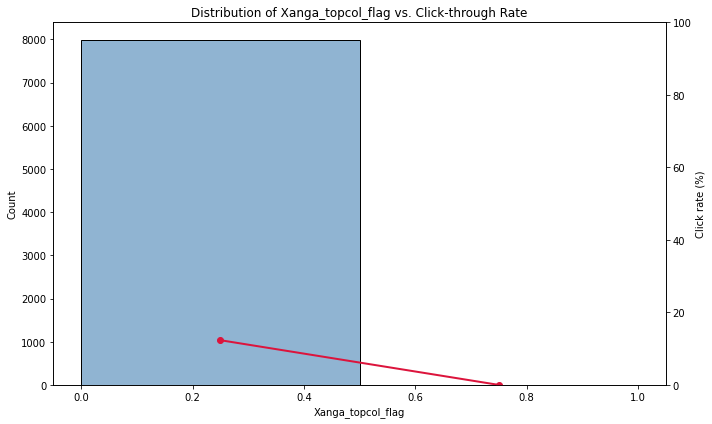

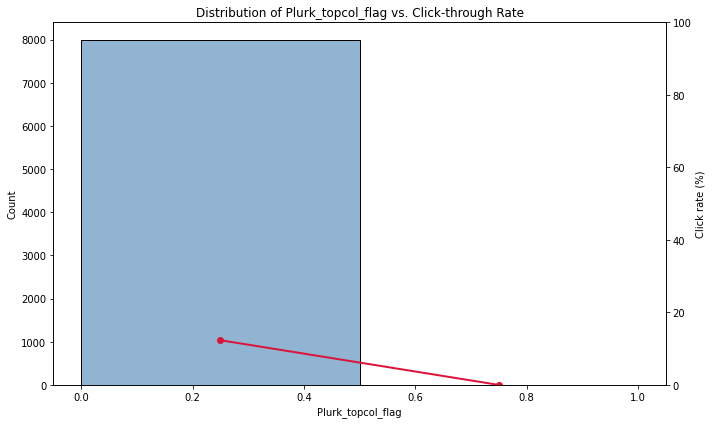

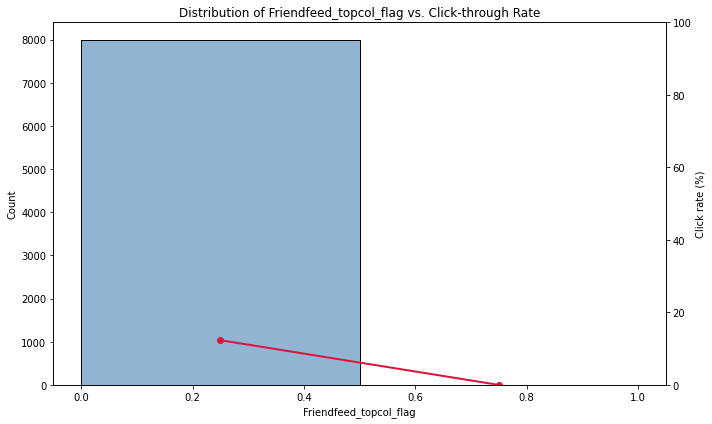

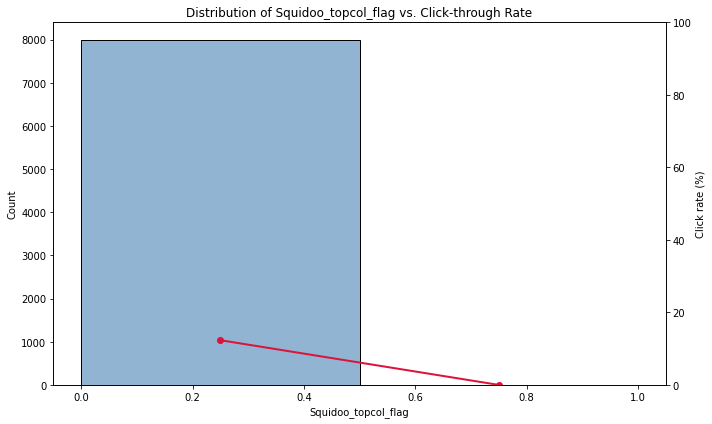

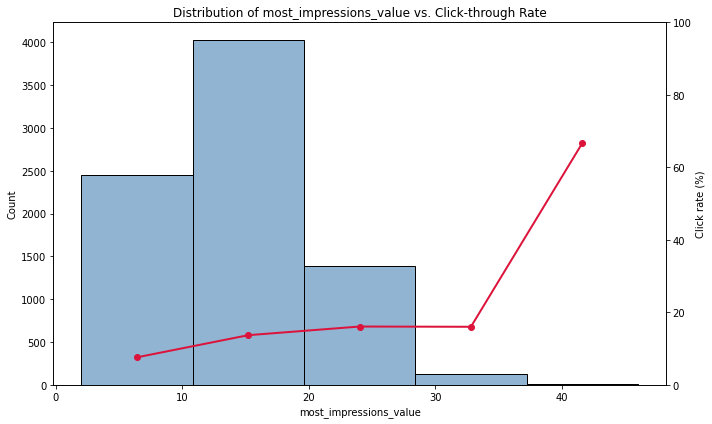

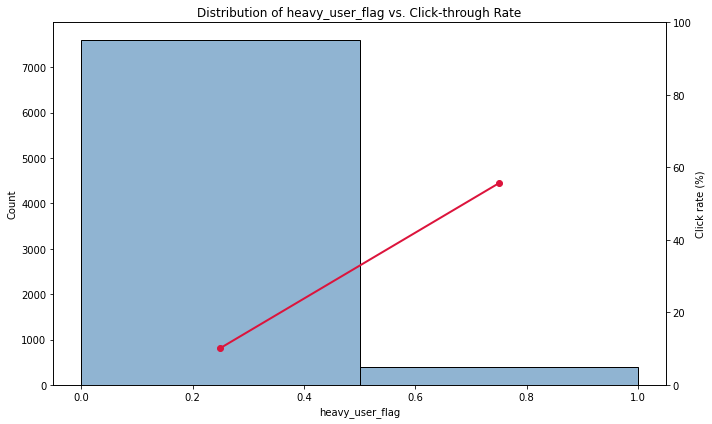

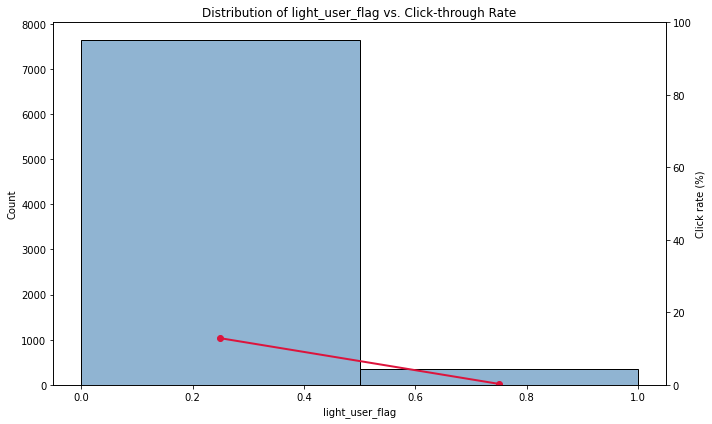

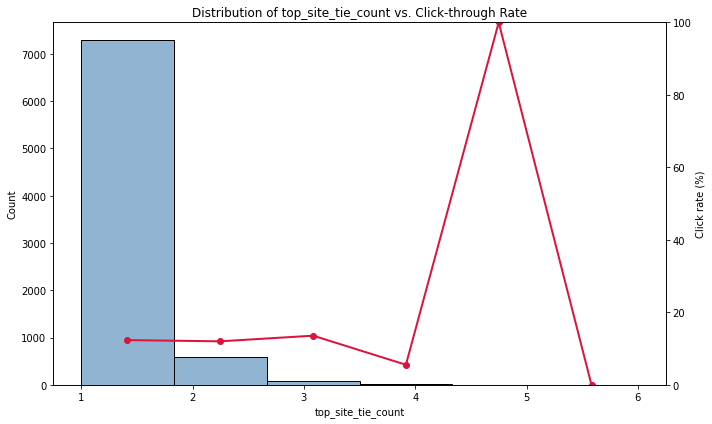

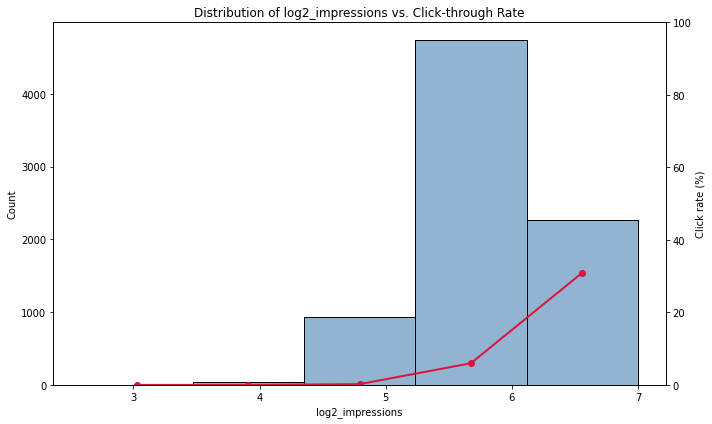

In [55]:
# now we want to spot which fields have a trend associated to click rate, and which do not (flatline)
# Also, we want to note fields with non-linear relationships

for col in X_train.columns:
    
    if X_train[col].nunique() < 10:
        bin_no = X_train[col].nunique()
    else:
        bin_no = 5
        
    edges = np.histogram_bin_edges(X_train[col].dropna(), bins=bin_no)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    sns.histplot(
        X_train[col],
        bins=edges,
        ax=ax1,
        color="steelblue",
        alpha=0.6
    )
    ax1.set_xlabel(col)
    ax1.set_ylabel("Count")
    
    bin_labels = pd.cut(X_train[col], bins=edges, include_lowest=True)
    rate = y_train.groupby(bin_labels).mean() * 100
    centres = [interval.mid for interval in rate.index]
    
    ax2 = ax1.twinx()
    ax2.plot(centres, rate.values, color="crimson", marker="o", linewidth=2)
    ax2.set_ylabel("Click rate (%)")
    ax2.set_ylim(0, 100)
    
    plt.title(f"Distribution of {col} vs. Click-through Rate")
    plt.tight_layout()
    plt.show()

In [56]:
# These fields have a flatline realtionship or a seeimngly non-linear relationship

flatline_omit = ['Delicious',
 'Diigo',
 'Drupal',
 'Evernote', 
 'Multiply', 
 'Netvibes', 
 'Myspace', 
 'Viadeo', 
 'Wetpaint', 
 'Facebook_topcol_flag',
 'Photobucket_topcol_flag',
 'Myspace_topcol_flag',
 'Youtube_topcol_flag',
 'Flickr_topcol_flag',
 'Cnet_topcol_flag',
 'Livejournal_topcol_flag',
 'top_site_tie_count',
 'Documents_impressions_std',
 'Documents_impressions_total',
 'Hootsuite',
 'Dropbox']

nonlinear = ['Bebo',
             'Squidoo',
             'social_engagement_pc',
             'utilities_and_tools_pc']

[0.         0.88888889 1.77777778 2.66666667 3.55555556 4.44444444
 5.33333333 6.22222222 7.11111111 8.        ]


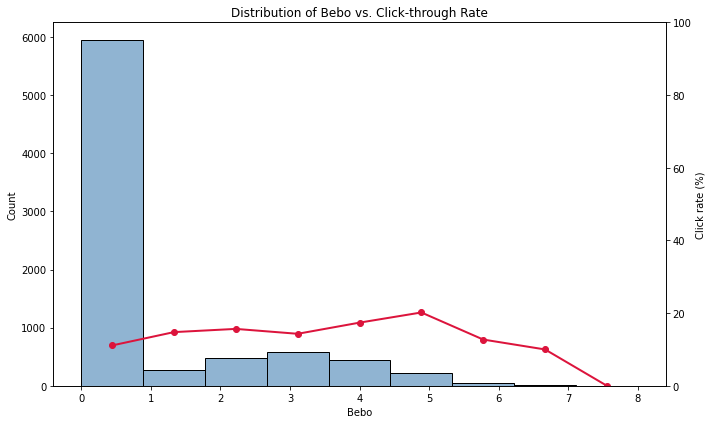

[0.         0.85714286 1.71428571 2.57142857 3.42857143 4.28571429
 5.14285714 6.        ]


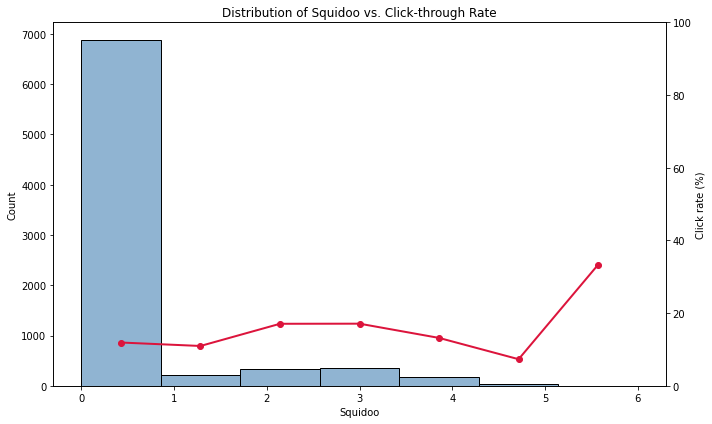

[0.         0.07371795 0.1474359  0.22115385 0.29487179 0.36858974
 0.44230769 0.51602564 0.58974359 0.66346154 0.73717949 0.81089744
 0.88461538 0.95833333]


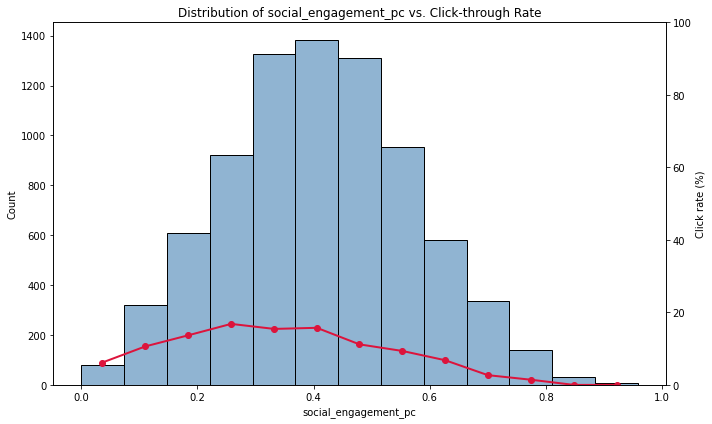

[0.         0.05494505 0.10989011 0.16483516 0.21978022 0.27472527
 0.32967033 0.38461538 0.43956044 0.49450549 0.54945055 0.6043956
 0.65934066 0.71428571]


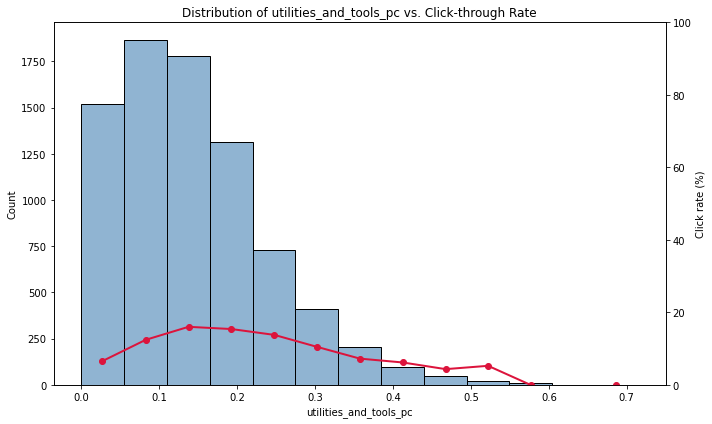

In [59]:
# Now we want to determine at what values do we see the direction of the trend for non-linear fields,
# so that we can determine at what cut-off points should we create a binary flag for fields above or below a certain value

for col in nonlinear:
    
    if X_train[col].nunique() < 20:
        bin_no = X_train[col].nunique()
    else:
        bin_no = 13
        
    edges = np.histogram_bin_edges(X_train[col].dropna(), bins=bin_no)
    print(edges)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    sns.histplot(
        X_train[col],
        bins=edges,
        ax=ax1,
        color="steelblue",
        alpha=0.6
    )
    ax1.set_xlabel(col)
    ax1.set_ylabel("Count")
    
    bin_labels = pd.cut(X_train[col], bins=edges, include_lowest=True)
    rate = y_train.groupby(bin_labels).mean() * 100
    centres = [interval.mid for interval in rate.index]
    
    ax2 = ax1.twinx()
    ax2.plot(centres, rate.values, color="crimson", marker="o", linewidth=2)
    ax2.set_ylabel("Click rate (%)")
    ax2.set_ylim(0, 100)
    
    plt.title(f"Distribution of {col} vs. Click-through Rate")
    plt.tight_layout()
    plt.show()

In [61]:
# We've eyeballed at what values to create flags

X_train['Bebo_0-1'] = np.where(X_train['Bebo']<=1, 1, 0)
X_test['Bebo_0-1'] = np.where(X_test['Bebo']<=1, 1, 0)

X_train['Bebo_2-3'] = np.where((X_train['Bebo']==2) | (X_train['Bebo']==3), 1, 0)
X_test['Bebo_2-3'] = np.where((X_test['Bebo']==2) | (X_test['Bebo']==3), 1, 0)

X_train['Bebo_4+'] = np.where(X_train['Bebo']>=4, 1, 0)
X_test['Bebo_4+'] = np.where(X_test['Bebo']>=4, 1, 0)

# X_train['Squidoo_0-2'] = np.where(X_train['Squidoo']<=2, 1, 0)
# X_test['Squidoo_0-2'] = np.where(X_test['Squidoo']<=2, 1, 0)

X_train['Squidoo_3+'] = np.where(X_train['Squidoo']>=3, 1, 0)
X_test['Squidoo_3+'] = np.where(X_test['Squidoo']>=3, 1, 0)

# X_train['social_engagement_pc-30'] = np.where(X_train['social_engagement_pc']<0.3, 1, 0)
# X_test['social_engagement_pc-30'] = np.where(X_test['social_engagement_pc']<0.3, 1, 0)

X_train['social_engagement_pc+30'] = np.where(X_train['social_engagement_pc']>=0.3, 1, 0)
X_test['social_engagement_pc+30'] = np.where(X_test['social_engagement_pc']>=0.3, 1, 0)

# X_train['utilities_and_tools_pc-16.5'] = np.where(X_train['social_engagement_pc']<0.165, 1, 0)
# X_test['utilities_and_tools_pc-16.5'] = np.where(X_test['social_engagement_pc']<0.165, 1, 0)

X_train['utilities_and_tools_pc+16.5'] = np.where(X_train['social_engagement_pc']>=0.165, 1, 0)
X_test['utilities_and_tools_pc+16.5'] = np.where(X_test['social_engagement_pc']>=0.165, 1, 0)

X_train['Other_topcol_flag'] = (X_train[topcol_flag_keep] == 0).all(axis=1).astype(int)
X_test['Other_topcol_flag'] = (X_test[topcol_flag_keep] == 0).all(axis=1).astype(int)

nonlinear_onehot = ['Bebo_0-1','Bebo_2-3','Bebo_4+','Squidoo_3+','social_engagement_pc+30','utilities_and_tools_pc+16.5']

In [62]:
# now we want to see if these have an adequate amount of non-zero values

zeropc(X_train[nonlinear_onehot])

8000 rows


column  zeropc
0                     Bebo_0-1  22.300
1                     Bebo_2-3  86.850
2                      Bebo_4+  90.850
3                   Squidoo_3+  92.975
4      social_engagement_pc+30  25.100
5  utilities_and_tools_pc+16.5   6.450

[0.  0.5 1. ]


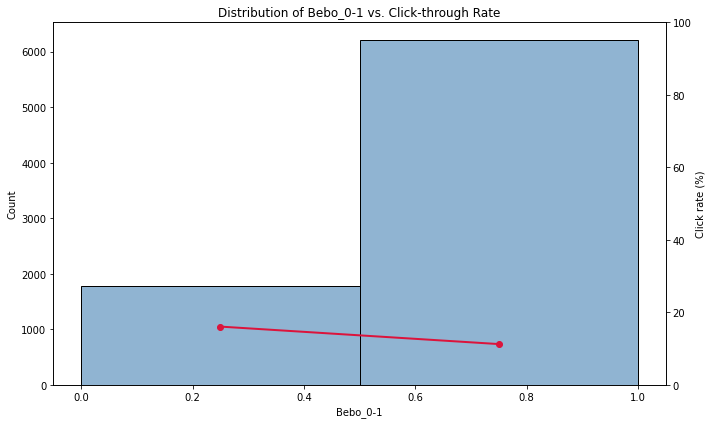

[0.  0.5 1. ]


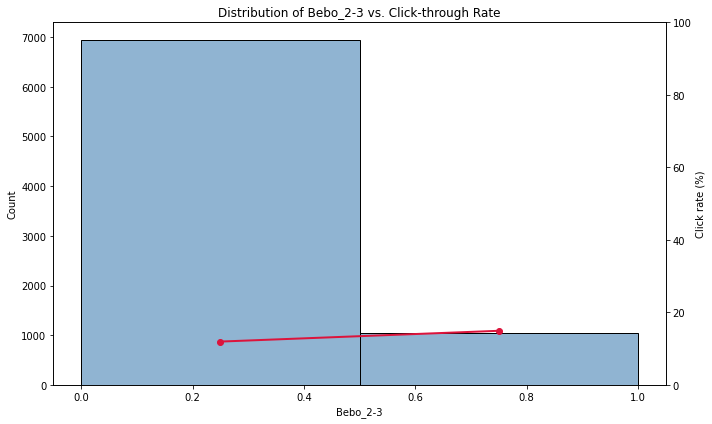

[0.  0.5 1. ]


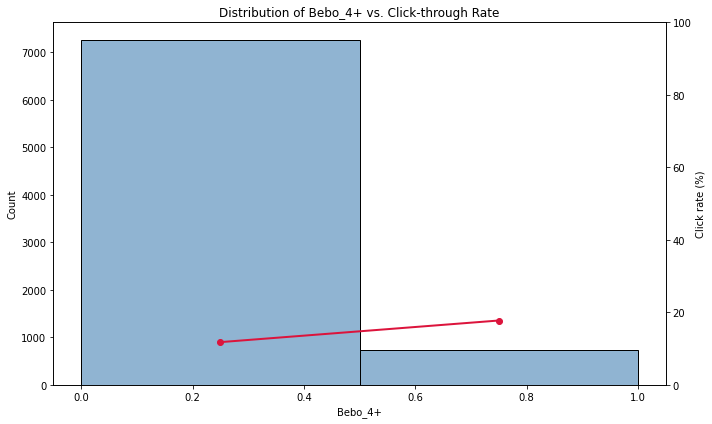

[0.  0.5 1. ]


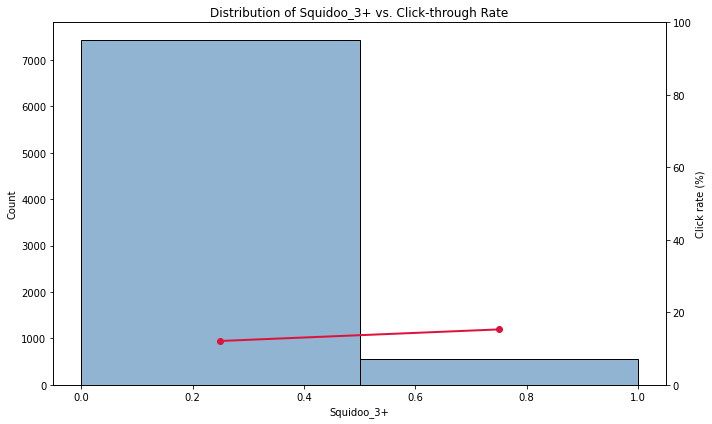

[0.  0.5 1. ]


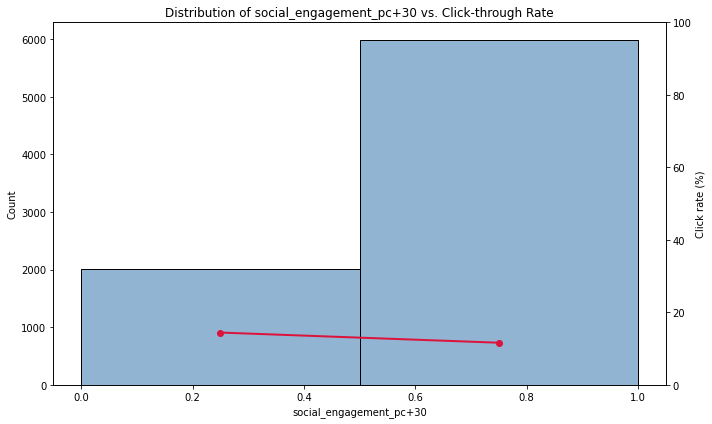

[0.  0.5 1. ]


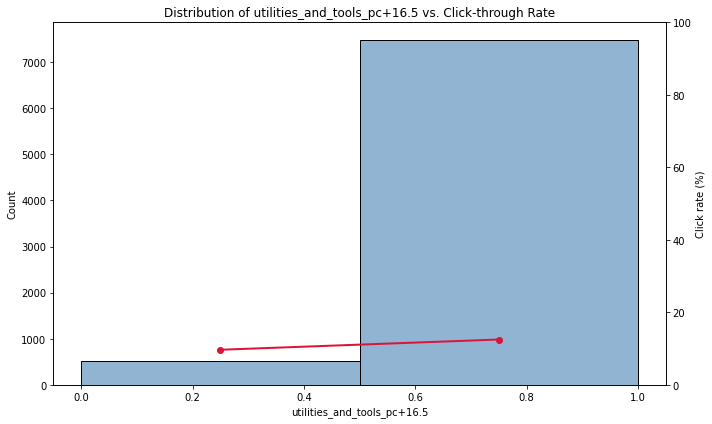

In [63]:
# now we want to see if we can see a trend with click-rate for these flags

for col in nonlinear_onehot:
    
    if X_train[col].nunique() < 20:
        bin_no = X_train[col].nunique()
    else:
        bin_no = 13
        
    edges = np.histogram_bin_edges(X_train[col].dropna(), bins=bin_no)
    print(edges)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    sns.histplot(
        X_train[col],
        bins=edges,
        ax=ax1,
        color="steelblue",
        alpha=0.6
    )
    ax1.set_xlabel(col)
    ax1.set_ylabel("Count")
    
    bin_labels = pd.cut(X_train[col], bins=edges, include_lowest=True)
    rate = y_train.groupby(bin_labels).mean() * 100
    centres = [interval.mid for interval in rate.index]
    
    ax2 = ax1.twinx()
    ax2.plot(centres, rate.values, color="crimson", marker="o", linewidth=2)
    ax2.set_ylabel("Click rate (%)")
    ax2.set_ylim(0, 100)
    
    plt.title(f"Distribution of {col} vs. Click-through Rate")
    plt.tight_layout()
    plt.show()

Same for Other_topcol_flag

In [64]:
zeropc(X_train[['Other_topcol_flag']])

8000 rows


column   zeropc
0  Other_topcol_flag  94.7875

[0.  0.5 1. ]


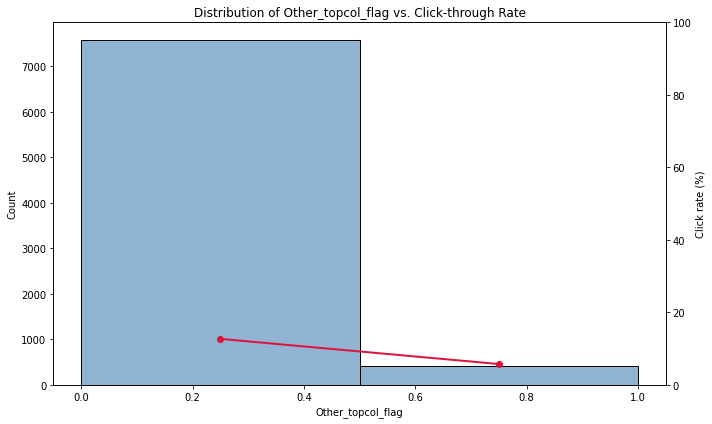

In [65]:
if X_train['Other_topcol_flag'].nunique() < 20:
    bin_no = X_train['Other_topcol_flag'].nunique()
else:
    bin_no = 13
    
edges = np.histogram_bin_edges(X_train['Other_topcol_flag'].dropna(), bins=bin_no)
print(edges)
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.histplot(
    X_train['Other_topcol_flag'],
    bins=edges,
    ax=ax1,
    color="steelblue",
    alpha=0.6
)
ax1.set_xlabel('Other_topcol_flag')
ax1.set_ylabel("Count")
bin_labels = pd.cut(X_train['Other_topcol_flag'], bins=edges, include_lowest=True)
rate = y_train.groupby(bin_labels).mean() * 100
centres = [interval.mid for interval in rate.index]
ax2 = ax1.twinx()
ax2.plot(centres, rate.values, color="crimson", marker="o", linewidth=2)
ax2.set_ylabel("Click rate (%)")
ax2.set_ylim(0, 100)
plt.title(f"Distribution of {'Other_topcol_flag'} vs. Click-through Rate")
plt.tight_layout()
plt.show()

In [66]:
# Cjecking Other_topcol_flag is only a 1 when the topcol_flag for any other site isn't a 1

X_train[(X_train['Other_topcol_flag']==1) & ((X_train['Twitter_topcol_flag']==1) | (X_train['Facebook_topcol_flag']==1)
        | (X_train['Photobucket_topcol_flag']==1) | (X_train['Myspace_topcol_flag']==1)
        | (X_train['Youtube_topcol_flag']==1) | (X_train['Blogger_topcol_flag']==1) | (X_train['Conduit_topcol_flag']==1)
        | (X_train['Pinterest_topcol_flag']==1) | (X_train['Flickr_topcol_flag']==1) | (X_train['Cnet_topcol_flag']==1)
        | (X_train['Wordpress_topcol_flag']==1) | (X_train['Livejournal_topcol_flag']==1))].shape[0]

0

All newly added columns have enough non-zero rows and have a trend against the click rate

In [67]:
# all columns we've decided to omit

allcol_omit = topcol_flag_omit + imp_count_omit + flatline_omit

In [69]:
# dropping them from the test and control

X_train = X_train.drop(columns=allcol_omit)
X_test = X_test.drop(columns=allcol_omit)

### Imputation

In [70]:
nulls = nullpc(X_train)
nulls[nulls['nullpc']>0]

8000 rows


column  nullpc
29  Newsvine  0.0125

In [71]:
X_train['Newsvine'].isna().sum()

1

In [72]:
nulls = nullpc(X_test)
nulls[nulls['nullpc']>0]

2000 rows


Empty DataFrame
Columns: [column, nullpc]
Index: []

In [73]:
# a simple median imputation will do given it is literlly one row in one column

X_train['Newsvine'].fillna(X_train['Newsvine'].median(), inplace=True)

In [74]:
X_train['Newsvine'].isna().sum()

0

### Correlation

In [75]:
# Now remove fields too closely correlated

correlation_matrix = X_train.corr()

In [76]:
corr_long = correlation_matrix.unstack().reset_index()
corr_long.columns = ['field1','field2','correlation_value']
corr_long = corr_long[corr_long['field1']!=corr_long['field2']]
corr_long['combo'] = corr_long.apply(lambda row: tuple(sorted([row['field1'], row['field2']])), axis=1)
corr_long = corr_long.drop_duplicates(subset=['combo'])
del corr_long['combo']
corr_long['correlation_value'] = abs(corr_long['correlation_value'])
corr_long = corr_long.sort_values('correlation_value', ascending=False)

In [77]:
# Go through combination of fields starting from te hihgest correlation avlue and remove the field that has the
# weakest relationship with clicks when looking at ROC AUC scores

HIGH_CORR = 0.8
high_corr_pairs = corr_long[corr_long['correlation_value'] >= HIGH_CORR]
univariate_auc = {}
for f in X_train.columns:
    scores = X_train[f].values.reshape(-1,1)
    univariate_auc[f] = roc_auc_score(y_train, scores)

drops = set()
# 3. For each pair, drop the lower-AUC feature
for f1, f2, _ in high_corr_pairs.itertuples(index=False):
    # If either feature is already dropped, skip this pair
    if f1 in drops or f2 in drops:
        continue

    # Otherwise compare AUCs and drop the weaker one
    to_drop = f1 if univariate_auc[f1] < univariate_auc[f2] else f2
    drops.add(to_drop)


In [78]:
X_train = X_train.drop(columns=list(drops))
X_test = X_test.drop(columns=list(drops))

In [79]:
X_train.shape[1]

94

In [371]:
# Now we have our selected columns

selected_cols = list(X_train.columns)
selected_cols.append('id')

# Modeling

## Profit Calculation

In [91]:
# Calculate row level profit

def profit_score(estimator, X, y_true):
    
    X_arr = X.values if hasattr(X, 'values') else X
    y_arr = y_true.values if hasattr(y_true, 'values') else y_true

    click_val = 8.42
    imp_cost  = 2.85 / 1000

    # 1) model probabilities
    p = estimator.predict_proba(X_arr)[:,1]

    # 2) sweep thresholds
    thresholds  = np.linspace(0, 1, 101)
    best_profit = -np.inf

    for thr in thresholds:
        mask = p >= thr
        if not mask.any():
            continue

        tp = (y_arr[mask] == 1).sum()
        total_imps = X_arr[mask, imp_idx].sum()

        profit = tp * click_val - total_imps * imp_cost
        best_profit = max(best_profit, profit)

    return best_profit / X_arr.shape[0]  # average profit per row

In [95]:
# Our list of metrics to score our models on

scorers = {
    'accuracy':     make_scorer(accuracy_score),
    'precision':    make_scorer(precision_score, zero_division=0),
    'recall':       make_scorer(recall_score,    zero_division=0),
    'f1':           make_scorer(f1_score),
    'mcc':          make_scorer(matthews_corrcoef),
    'profit_score': profit_score
}

## Logistic Regression

### Optimise on F1

#### Iteration 1

In [142]:
start = time.time()

# standardise the logistic regression columns

pipe_lr_f1 = Pipeline([
    ('scaler', StandardScaler()),
    ('lr',   LogisticRegression())
])

# parameters to check what combination performs best

params_lr_f1 = [
    # liblinear: supports l1 & l2 only
    {
        'lr__solver':  ['liblinear'],
        'lr__penalty': ['l1', 'l2'],
        'lr__C':       [1, 5, 10],
        'lr__class_weight': [
            'balanced',
            {0:1, 1:1},
            {0:1, 1:2},
            {0:1, 1:4}
        ]
    },
    # saga: supports l1, l2, elastic-net
    {
        'lr__solver':   ['saga'],
        'lr__penalty':  ['l1', 'l2', 'elasticnet'],
        'lr__C':        [1, 5, 10],
        'lr__l1_ratio': [0.5],
        'lr__class_weight': [
            'balanced',
            {0:1, 1:1},
            {0:1, 1:2},
            {0:1, 1:4}
        ]
    }
]

# doing a nested cross-validation to ensure a more accurate cross validated score, by testing the hyperparameters
# on unseen data. Hyper-parameterising to optimise for f1-score

inner_cv_lr_f1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_lr_f1 = GridSearchCV(
    estimator   = pipe_lr_f1,
    param_grid  = params_lr_f1,
    cv          = inner_cv_lr_f1,
    scoring     = 'f1',
    n_jobs      = -1,
    refit       = True
)

# Cross valdating on unseen data to when the hyperparameters were determined

outer_cv_lr_f1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

cv_out_f1 = cross_validate(
    estimator        = grid_lr_f1,     
    X                = X_train,
    y                = y_train,
    cv               = outer_cv_lr_f1,
    scoring          = scorers,    
    return_estimator = True,
    n_jobs           = -1,
    error_score      = 'raise'
)

print("Hyper-params chosen in each outer fold:")
for k, est in enumerate(cv_out_f1['estimator'], 1):
    print(f" Fold {k}: {est.best_params_}")

print("\nAverage metrics over outer folds:")
for m in scorers:
    vals = cv_out_f1[f'test_{m}']
    print(f" {m:9}:  {vals.mean():.3f} ± {vals.std():.3f}  -> {[f'{v:.3f}' for v in vals]}")

elapsed = time.time() - start
print(f"\nElapsed: {elapsed:.1f} s  (~{elapsed/60:.2f} min)")

Hyper-params chosen in each outer fold:
 Fold 1: {'lr__C': 1, 'lr__class_weight': {0: 1, 1: 4}, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
 Fold 2: {'lr__C': 5, 'lr__class_weight': {0: 1, 1: 1}, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
 Fold 3: {'lr__C': 1, 'lr__class_weight': {0: 1, 1: 2}, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
 Fold 4: {'lr__C': 1, 'lr__class_weight': {0: 1, 1: 2}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'saga'}
 Fold 5: {'lr__C': 1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'saga'}

Average metrics over outer folds:
 accuracy :  0.969 ± 0.003  -> ['0.967', '0.970', '0.967', '0.974', '0.968']
 precision:  0.856 ± 0.025  -> ['0.810', '0.867', '0.850', '0.879', '0.876']
 recall   :  0.902 ± 0.032  -> ['0.954', '0.893', '0.888', '0.914', '0.859']
 f1       :  0.878 ± 0.010  -> ['0.876', '0.880', '0.868', '0.896', '0.867']
 mcc      :  0.861 ± 0.012  -> ['0.861', '0.863', '0.850', '0.881

In [143]:
# Fitting our model and making predictions

grid_lr_f1.fit(X_train, y_train)
final_lr_f1 = grid_lr_f1.best_estimator_
print("Chosen hyper-parameters:", grid_lr_f1.best_params_)

proba_test_lr_f1 = final_lr_f1.predict_proba(X_test)[:, 1]
y_pred_lr_f1     = (proba_test_lr_f1 >= 0.5).astype(int)

# Look out for overfitting by predicting on the training dataset

proba_test_overfit_lr_f1 = final_lr_f1.predict_proba(X_train)[:, 1]
y_pred_overfit_lr_f1     = (proba_test_overfit_lr_f1 >= 0.5).astype(int)

Chosen hyper-parameters: {'lr__C': 5, 'lr__class_weight': {0: 1, 1: 1}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'saga'}


Test accuracy : 0.970
Test precision: 0.879
Test recall   : 0.879
Test F1       : 0.879
Test MCC      : 0.861
Test Profit   : 1.011

Training accuracy : 0.977
Training precision: 0.915
Training recall   : 0.901
Training F1       : 0.908
Training MCC      : 0.895
Training Profit   : 0.995



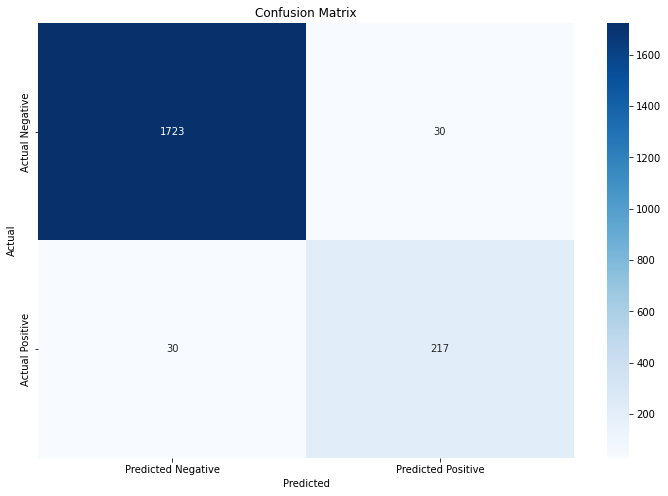

In [144]:
# Our Metrics

print(f"Test accuracy : {accuracy_score(y_test, y_pred_lr_f1):.3f}")
print(f"Test precision: {precision_score(y_test, y_pred_lr_f1, zero_division=0):.3f}")
print(f"Test recall   : {recall_score(y_test, y_pred_lr_f1):.3f}")
print(f"Test F1       : {f1_score(y_test, y_pred_lr_f1):.3f}")
print(f"Test MCC      : {matthews_corrcoef(y_test, y_pred_lr_f1):.3f}")
print(f"Test Profit   : {profit_score(final_lr_f1, X_test, y_pred_lr_f1):.3f}\n")

print(f"Training accuracy : {accuracy_score(y_train, y_pred_overfit_lr_f1):.3f}")
print(f"Training precision: {precision_score(y_train, y_pred_overfit_lr_f1, zero_division=0):.3f}")
print(f"Training recall   : {recall_score(y_train, y_pred_overfit_lr_f1):.3f}")
print(f"Training F1       : {f1_score(y_train, y_pred_overfit_lr_f1):.3f}")
print(f"Training MCC      : {matthews_corrcoef(y_train, y_pred_overfit_lr_f1):.3f}")
print(f"Training Profit   : {profit_score(final_lr_f1, X_train, y_pred_overfit_lr_f1):.3f}\n")

cm_lr_f1 = confusion_matrix(y_test, y_pred_lr_f1)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_lr_f1, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Logistic - F1 Score - Iteration 2

In [145]:
start = time.time()

# standardise the logistic regression columns

pipe_lr_f1_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('lr',   LogisticRegression())
])

# parameters to check what combination performs best

params_lr_f1_2 = [
    # liblinear: supports l1 & l2 only
    {
        'lr__solver':  ['liblinear'],
        'lr__penalty': ['l1', 'l2'],
        'lr__C':       [2, 3.5, 5, 6.5, 8],
        'lr__class_weight': [
            'balanced',
            {0:1, 1:1},
            {0:1, 1:2},
            {0:1, 1:3}
        ]
    },
    # saga: supports l1, l2, elastic-net
    {
        'lr__solver':   ['saga'],
        'lr__penalty':  ['l1', 'l2', 'elasticnet'],
        'lr__C':        [2, 3.5, 5, 6.5, 8],
        'lr__l1_ratio': [0.5],
        'lr__class_weight': [
            'balanced',
            {0:1, 1:1},
            {0:1, 1:2},
            {0:1, 1:3}
        ]
    }
]

# doing a nested cross-validation to ensure a more accurate cross validated score, by testing the hyperparameters
# on unseen data. Hyper-parameterising to optimise for f1-score

inner_cv_lr_f1_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_lr_f1_2 = GridSearchCV(
    estimator   = pipe_lr_f1_2,
    param_grid  = params_lr_f1_2,
    cv          = inner_cv_lr_f1_2,
    scoring     = 'f1',
    n_jobs      = -1,
    refit       = True
)

# Cross valdating on unseen data to when the hyperparameters were determined

outer_cv_lr_f1_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

cv_out_f1 = cross_validate(
    estimator        = grid_lr_f1_2,       
    X                = X_train,
    y                = y_train,
    cv               = outer_cv_lr_f1_2,
    scoring          = scorers,   
    return_estimator = True,
    n_jobs           = -1,
    error_score      = 'raise'
)

print("Hyper-params chosen in each outer fold:")
for k, est in enumerate(cv_out_f1['estimator'], 1):
    print(f" Fold {k}: {est.best_params_}")

print("\nAverage metrics over outer folds:")
for m in scorers:
    vals = cv_out_f1[f'test_{m}']
    print(f" {m:9}:  {vals.mean():.3f} ± {vals.std():.3f}  -> {[f'{v:.3f}' for v in vals]}")

elapsed = time.time() - start
print(f"\nElapsed: {elapsed:.1f} s  (~{elapsed/60:.2f} min)")

Hyper-params chosen in each outer fold:
 Fold 1: {'lr__C': 2, 'lr__class_weight': {0: 1, 1: 2}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
 Fold 2: {'lr__C': 5, 'lr__class_weight': {0: 1, 1: 1}, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
 Fold 3: {'lr__C': 2, 'lr__class_weight': {0: 1, 1: 2}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'saga'}
 Fold 4: {'lr__C': 2, 'lr__class_weight': {0: 1, 1: 2}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
 Fold 5: {'lr__C': 2, 'lr__class_weight': {0: 1, 1: 2}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'l2', 'lr__solver': 'saga'}

Average metrics over outer folds:
 accuracy :  0.970 ± 0.004  -> ['0.974', '0.971', '0.968', '0.974', '0.963']
 precision:  0.857 ± 0.020  -> ['0.861', '0.868', '0.857', '0.879', '0.820']
 recall   :  0.908 ± 0.021  -> ['0.944', '0.898', '0.883', '0.914', '0.899']
 f1       :  0.881 ± 0.016  -> ['0.901', '0.883', '0.870', '0.896', '0.858']
 mcc      :  0.865 ± 0.018  -> ['

In [146]:
# Fitting our model and making predictions

grid_lr_f1_2.fit(X_train, y_train)
final_lr_f1_2 = grid_lr_f1_2.best_estimator_
print("Chosen hyper-parameters:", grid_lr_f1_2.best_params_)

proba_test_f1_2 = final_lr_f1_2.predict_proba(X_test)[:, 1]
y_pred_f1_2     = (proba_test_f1_2 >= 0.5).astype(int)

# Look out for overfitting by predicting on the training dataset

proba_test_overfit_f1_2 = final_lr_f1_2.predict_proba(X_train)[:, 1]
y_pred_overfit_f1_2     = (proba_test_overfit_f1_2 >= 0.5).astype(int)

Chosen hyper-parameters: {'lr__C': 3.5, 'lr__class_weight': {0: 1, 1: 1}, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}


Test accuracy : 0.970
Test precision: 0.879
Test recall   : 0.879
Test F1       : 0.879
Test MCC      : 0.861
Test Profit   : 1.011

Training accuracy : 0.977
Training precision: 0.914
Training recall   : 0.901
Training F1       : 0.907
Training MCC      : 0.894
Training Profit   : 0.996



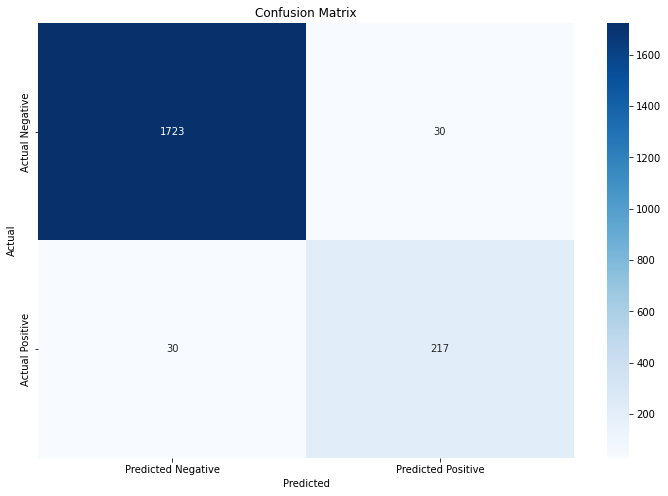

In [147]:
# Our Metrics

print(f"Test accuracy : {accuracy_score(y_test, y_pred_f1_2):.3f}")
print(f"Test precision: {precision_score(y_test, y_pred_f1_2, zero_division=0):.3f}")
print(f"Test recall   : {recall_score(y_test, y_pred_f1_2):.3f}")
print(f"Test F1       : {f1_score(y_test, y_pred_f1_2):.3f}")
print(f"Test MCC      : {matthews_corrcoef(y_test, y_pred_f1_2):.3f}")
print(f"Test Profit   : {profit_score(final_lr_f1_2, X_test, y_pred_f1_2):.3f}\n")

print(f"Training accuracy : {accuracy_score(y_train, y_pred_overfit_f1_2):.3f}")
print(f"Training precision: {precision_score(y_train, y_pred_overfit_f1_2, zero_division=0):.3f}")
print(f"Training recall   : {recall_score(y_train, y_pred_overfit_f1_2):.3f}")
print(f"Training F1       : {f1_score(y_train, y_pred_overfit_f1_2):.3f}")
print(f"Training MCC      : {matthews_corrcoef(y_train, y_pred_overfit_f1_2):.3f}")
print(f"Training Profit   : {profit_score(final_lr_f1_2, X_train, y_pred_overfit_f1_2):.3f}\n")

cm_lr_f1_2 = confusion_matrix(y_test, y_pred_f1_2)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_lr_f1_2, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Optimise on Precision

#### Iteration 1

In [149]:
start = time.time()

# standardise the logistic regression columns

pipe_lr_prec = Pipeline([
    ('scaler', StandardScaler()),
    ('lr',   LogisticRegression())
])

# parameters to check what combination performs best

params_lr_prec = [
    # liblinear: supports l1 & l2 only
    {
        'lr__solver':  ['liblinear'],
        'lr__penalty': ['l1', 'l2'],
        'lr__C':       [1, 5, 10],
        'lr__class_weight': [
            'balanced',
            {0:1, 1:1},
            {0:1, 1:2},
            {0:1, 1:4}
        ]
    },
    # saga: supports l1, l2, elastic-net
    {
        'lr__solver':   ['saga'],
        'lr__penalty':  ['l1', 'l2', 'elasticnet'],
        'lr__C':        [1, 5, 10],
        'lr__l1_ratio': [0.5],
        'lr__class_weight': [
            'balanced',
            {0:1, 1:1},
            {0:1, 1:2},
            {0:1, 1:4}
        ]
    }
]

# doing a nested cross-validation to ensure a more accurate cross validated score, by testing the hyperparameters
# on unseen data. Hyper-parameterising to optimise for precision

inner_cv_lr_prec = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_lr_prec = GridSearchCV(
    estimator   = pipe_lr_prec,
    param_grid  = params_lr_prec,
    cv          = inner_cv_lr_prec,
    scoring     = 'precision',
    n_jobs      = -1,
    refit       = True
)

# Cross valdating on unseen data to when the hyperparameters were determined

outer_cv_lr_prec = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

cv_out_prec = cross_validate(
    estimator        = grid_lr_prec,     
    X                = X_train,
    y                = y_train,
    cv               = outer_cv_lr_prec,
    scoring          = scorers,    
    return_estimator = True,
    n_jobs           = -1,
    error_score      = 'raise'
)

print("Hyper-params chosen in each outer fold:")
for k, est in enumerate(cv_out_prec['estimator'], 1):
    print(f" Fold {k}: {est.best_params_}")

print("\nAverage metrics over outer folds:")
for m in scorers:
    vals = cv_out_prec[f'test_{m}']
    print(f" {m:9}:  {vals.mean():.3f} ± {vals.std():.3f}  -> {[f'{v:.3f}' for v in vals]}")

elapsed = time.time() - start
print(f"\nElapsed: {elapsed:.1f} s  (~{elapsed/60:.2f} min)")

Hyper-params chosen in each outer fold:
 Fold 1: {'lr__C': 1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'saga'}
 Fold 2: {'lr__C': 1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'saga'}
 Fold 3: {'lr__C': 1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'saga'}
 Fold 4: {'lr__C': 1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga'}
 Fold 5: {'lr__C': 1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'saga'}

Average metrics over outer folds:
 accuracy :  0.972 ± 0.005  -> ['0.980', '0.972', '0.966', '0.973', '0.968']
 precision:  0.897 ± 0.019  -> ['0.919', '0.876', '0.895', '0.918', '0.876']
 recall   :  0.870 ± 0.034  -> ['0.919', '0.898', '0.822', '0.854', '0.859']
 f1       :  0.883 ± 0.021  -> ['0.919', '0.887', '0.857', '0.885', '0.867']
 mcc     

Chosen hyper-parameters: {'lr__C': 1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Test accuracy : 0.970
Test precision: 0.879
Test recall   : 0.879
Test F1       : 0.879
Test MCC      : 0.861

Overfit accuracy : 0.977
Overfit precision: 0.914
Overfit recall   : 0.898
Overfit F1       : 0.906
Overfit MCC      : 0.893


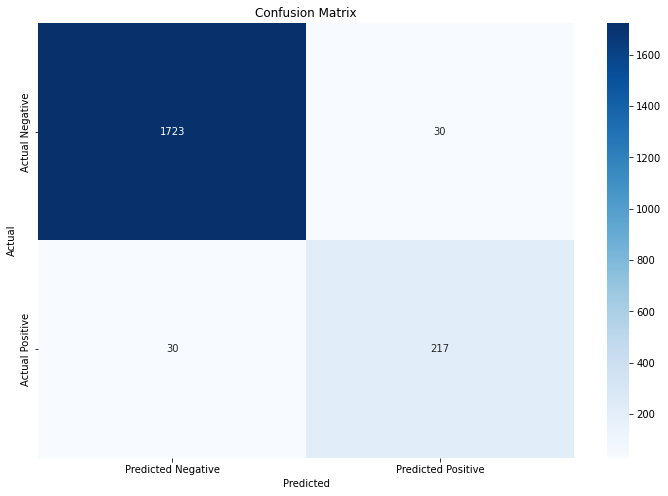

In [150]:
# Fitting our model and making predictions

grid_lr_prec.fit(X_train, y_train)
final_lr_prec = grid_lr_prec.best_estimator_
print("Chosen hyper-parameters:", grid_lr_prec.best_params_)

proba_test_prec = final_lr_prec.predict_proba(X_test)[:, 1]
y_pred_prec     = (proba_test_prec >= 0.5).astype(int)

# Look out for overfitting by predicting on the training dataset

proba_test_overfit_prec = final_lr_prec.predict_proba(X_train)[:, 1]
y_pred_overfit_prec     = (proba_test_overfit_prec >= 0.5).astype(int)

# Our metrics

print(f"Test accuracy : {accuracy_score(y_test, y_pred_prec):.3f}")
print(f"Test precision: {precision_score(y_test, y_pred_prec, zero_division=0):.3f}")
print(f"Test recall   : {recall_score(y_test, y_pred_prec):.3f}")
print(f"Test F1       : {f1_score(y_test, y_pred_prec):.3f}")
print(f"Test MCC      : {matthews_corrcoef(y_test, y_pred_prec):.3f}\n")

print(f"Overfit accuracy : {accuracy_score(y_train, y_pred_overfit_prec):.3f}")
print(f"Overfit precision: {precision_score(y_train, y_pred_overfit_prec, zero_division=0):.3f}")
print(f"Overfit recall   : {recall_score(y_train, y_pred_overfit_prec):.3f}")
print(f"Overfit F1       : {f1_score(y_train, y_pred_overfit_prec):.3f}")
print(f"Overfit MCC      : {matthews_corrcoef(y_train, y_pred_overfit_prec):.3f}")

cm_lr_prec = confusion_matrix(y_test, y_pred_prec)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_lr_prec, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### iteration 2

In [151]:
start = time.time()

imp_idx = list(X_train.columns).index('impressions_total')

# standardise the logistic regression columns

pipe_lr_prec_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('lr',   LogisticRegression())
])

# parameters to check what combination performs best

params_lr_prec_2 = [
    # liblinear: supports l1 & l2 only
    {
       'lr__solver':  ['liblinear'],
       'lr__penalty': ['l1', 'l2'],
       'lr__C':       [0.1, 0.5, 1],
        'lr__class_weight': [
            'balanced',
            {0:1, 1:1},
            {0:1, 1:2},
            {0:1, 1:3}
        ]
    },
    # saga: supports l1, l2, elastic-net
    {
        'lr__solver':   ['saga'],
        'lr__penalty':  ['l1', 'l2', 'elasticnet'],
        'lr__C':        [0.1, 0.5, 1],
        'lr__l1_ratio': [0.5],
         'lr__class_weight': [
            'balanced',
            {0:1, 1:1},
            {0:1, 1:2},
            {0:1, 1:3}
        ]
    }
]

# doing a nested cross-validation to ensure a more accurate cross validated score, by testing the hyperparameters
# on unseen data. Hyper-parameterising to optimise for precision

inner_cv_lr_prec_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_lr_prec_2 = GridSearchCV(
    estimator   = pipe_lr_prec_2,
    param_grid  = params_lr_prec_2,
    cv          = inner_cv_lr_prec_2,
    scoring     = 'precision',
    n_jobs      = -1,
    refit       = True
)

# Cross valdating on unseen data to when the hyperparameters were determined

outer_cv_lr_prec_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

cv_out_prec_2 = cross_validate(
    estimator        = grid_lr_prec_2,
    X                = X_train,
    y                = y_train,
    cv               = outer_cv_lr_prec_2,
    scoring          = scorers,
    return_estimator = True,
    n_jobs           = -1,
    error_score      = 'raise'
)

print("Hyper-params chosen in each outer fold:")
for k, est in enumerate(cv_out_prec_2['estimator'], 1):
    print(f" Fold {k}: {est.best_params_}")

print("\nAverage metrics over outer folds:")
for m in scorers:
    vals = cv_out_prec_2[f'test_{m}']
    print(f" {m:14}:  {vals.mean():.3f} ± {vals.std():.3f}  -> {[f'{v:.3f}' for v in vals]}")

elapsed = time.time() - start
print(f"\nElapsed: {elapsed:.1f} s  (~{elapsed/60:.2f} min)")

Hyper-params chosen in each outer fold:
 Fold 1: {'lr__C': 0.1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
 Fold 2: {'lr__C': 0.1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
 Fold 3: {'lr__C': 0.1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
 Fold 4: {'lr__C': 0.1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
 Fold 5: {'lr__C': 0.1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__l1_ratio': 0.5, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga'}

Average metrics over outer folds:
 accuracy      :  0.968 ± 0.006  -> ['0.976', '0.971', '0.963', '0.971', '0.960']
 precision     :  0.904 ± 0.030  -> ['0.920', '0.883', '0.937', '0.922', '0.856']
 recall        :  0.832 ± 0.047  -> ['0.878', '0.878', '0.751', '0.838', '0.813']
 f1            :  0.865 ± 0.026  -> ['0.899', '0.880', '0.834', '0.878', '0.834']
 mcc           :  0.849 ± 0

In [152]:
# Fitting our model and making predictions

grid_lr_prec_2.fit(X_train, y_train)
final_lr_prec_2 = grid_lr_prec_2.best_estimator_
print("Chosen hyper-parameters:", grid_lr_prec.best_params_)

# Look out for overfitting by predicting on the training dataset

proba_test_prec_2 = final_lr_prec_2.predict_proba(X_test)[:, 1]
y_pred_prec_2     = (proba_test_prec_2 >= 0.5).astype(int)

proba_test_overfit_prec_2 = final_lr_prec_2.predict_proba(X_train)[:, 1]
y_pred_overfit_prec_2     = (proba_test_overfit_prec_2 >= 0.5).astype(int)

Chosen hyper-parameters: {'lr__C': 1, 'lr__class_weight': {0: 1, 1: 1}, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


Test accuracy : 0.968
Test precision: 0.879
Test recall   : 0.854
Test F1       : 0.867
Test MCC      : 0.848
Test Profit   : 0.977

Training Data accuracy : 0.974
Training Data precision: 0.918
Training Data recall   : 0.868
Training Data F1       : 0.892
Training Data MCC      : 0.878
Training Data Profit   : 0.953



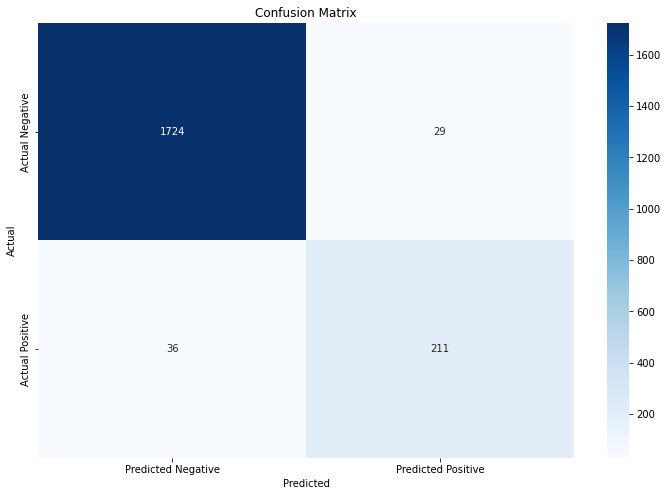

In [153]:
# Our metrics

print(f"Test accuracy : {accuracy_score(y_test, y_pred_prec_2):.3f}")
print(f"Test precision: {precision_score(y_test, y_pred_prec_2, zero_division=0):.3f}")
print(f"Test recall   : {recall_score(y_test, y_pred_prec_2):.3f}")
print(f"Test F1       : {f1_score(y_test, y_pred_prec_2):.3f}")
print(f"Test MCC      : {matthews_corrcoef(y_test, y_pred_prec_2):.3f}")
print(f"Test Profit   : {profit_score(final_lr_prec, X_test, y_pred_prec_2):.3f}\n")

print(f"Training Data accuracy : {accuracy_score(y_train, y_pred_overfit_prec_2):.3f}")
print(f"Training Data precision: {precision_score(y_train, y_pred_overfit_prec_2, zero_division=0):.3f}")
print(f"Training Data recall   : {recall_score(y_train, y_pred_overfit_prec_2):.3f}")
print(f"Training Data F1       : {f1_score(y_train, y_pred_overfit_prec_2):.3f}")
print(f"Training Data MCC      : {matthews_corrcoef(y_train, y_pred_overfit_prec_2):.3f}")
print(f"Training Data Profit   : {profit_score(final_lr_prec, X_train, y_pred_overfit_prec_2):.3f}\n")

cm_lr_prec_2 = confusion_matrix(y_test, y_pred_prec_2)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_lr_prec_2, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Light GBM

### Light GBM - F1 Score

#### Light GBM - F1 Score - Iteration 1

In [88]:
start = time.time()

pipe_lgb_f1 = Pipeline([
    ('lgb',    LGBMClassifier(class_weight='balanced', random_state=0))
])

# parameters to check what combination performs best

params_lgb_f1 = [
    {
      'lgb__n_estimators':    [100, 200],
      'lgb__learning_rate':   [0.01, 0.05, 0.1],
      'lgb__num_leaves':      [31, 63],
      'lgb__max_depth':       [-1, 10, 20]
    },
    {
      'lgb__n_estimators':    [100, 200],
      'lgb__learning_rate':   [0.01, 0.05, 0.1],
      'lgb__num_leaves':      [31, 63],
      'lgb__min_child_samples':[20, 50, 70],
      'lgb__subsample':       [0.6, 0.8, 1.0],
      'lgb__colsample_bytree':[0.6, 0.8, 1.0]
    }
]

# doing a nested cross-validation to ensure a more accurate cross validated score, by testing the hyperparameters
# on unseen data. Hyper-parameterising to optimise for f1-score

inner_cv_lgb_f1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_lgb_f1 = GridSearchCV(
    estimator   = pipe_lgb_f1,
    param_grid  = params_lgb_f1,
    cv          = inner_cv_lgb_f1,
    scoring     = 'f1',
    n_jobs      = -1,
    refit       = True
)
print(f'inner cv done { (time.time() - start)/60:.2f}')

# Cross valdating on unseen data to when the hyperparameters were determined

outer_cv_lgb_f1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

cv_out_lgb_f1 = cross_validate(
    estimator        = grid_lgb_f1,        # inner grid-search inside
    X                = X_train,
    y                = y_train,
    cv               = outer_cv_lgb_f1,
    scoring          = scorers,     # accuracy / prec / rec / f1 / mcc
    return_estimator = True,
    n_jobs           = -1,
    error_score      = 'raise'
)

print("Hyper-params chosen in each outer fold:")
for k, est in enumerate(cv_out_lgb_f1['estimator'], 1):
    print(f" Fold {k}: {est.best_params_}")

print("\nAverage metrics over outer folds:")
for m in scorers:
    vals = cv_out_lgb_f1[f'test_{m}']
    print(f" {m:9}:  {vals.mean():.3f} ± {vals.std():.3f}  -> {[f'{v:.3f}' for v in vals]}")

elapsed = time.time() - start
print(f"\nElapsed: {elapsed:.1f} s  (~{elapsed/60:.2f} min)")

inner cv done 0.00
Hyper-params chosen in each outer fold:
 Fold 1: {'lgb__colsample_bytree': 0.8, 'lgb__learning_rate': 0.1, 'lgb__min_child_samples': 70, 'lgb__n_estimators': 200, 'lgb__num_leaves': 31, 'lgb__subsample': 0.6}
 Fold 2: {'lgb__colsample_bytree': 1.0, 'lgb__learning_rate': 0.1, 'lgb__min_child_samples': 70, 'lgb__n_estimators': 200, 'lgb__num_leaves': 31, 'lgb__subsample': 0.6}
 Fold 3: {'lgb__colsample_bytree': 1.0, 'lgb__learning_rate': 0.1, 'lgb__min_child_samples': 50, 'lgb__n_estimators': 200, 'lgb__num_leaves': 31, 'lgb__subsample': 0.6}
 Fold 4: {'lgb__colsample_bytree': 0.8, 'lgb__learning_rate': 0.1, 'lgb__min_child_samples': 50, 'lgb__n_estimators': 200, 'lgb__num_leaves': 31, 'lgb__subsample': 0.6}
 Fold 5: {'lgb__colsample_bytree': 1.0, 'lgb__learning_rate': 0.1, 'lgb__min_child_samples': 50, 'lgb__n_estimators': 200, 'lgb__num_leaves': 31, 'lgb__subsample': 0.6}

Average metrics over outer folds:
 accuracy :  0.954 ± 0.006  -> ['0.952', '0.954', '0.957', '0

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 987, number of negative: 7013
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Chosen hyper-parameters: {'lgb__colsample_bytree': 1.0, 'lgb__learning_rate': 0.1, 'lgb__min_child_samples': 70, 'lgb__n_estimators': 200, 'lgb__num_leaves': 31, 'lgb__subsample': 0.6}
Test accuracy : 0.953
Test precision: 0.799
Test recall   : 0.822
Test F1       : 0.810
Test MCC      : 0.783

Overfit accuracy : 1.000
Overfit precision: 1.000
Overfit recall   : 1

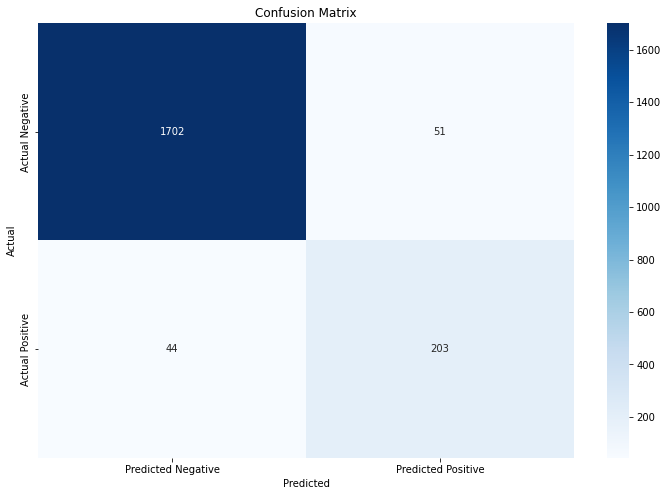

In [90]:
# Fitting our model and making predictions

grid_lgb_f1.fit(X_train, y_train)
final_lgb_f1 = grid_lgb_f1.best_estimator_
print("Chosen hyper-parameters:", grid_lgb_f1.best_params_)

proba_test_lgb_f1 = final_lgb_f1.predict_proba(X_test)[:, 1]
y_pred_lgb_f1     = (proba_test_lgb_f1 >= 0.5).astype(int)

# Look out for overfitting by predicting on the training dataset

proba_test_overfit_lgb_f1 = final_lgb_f1.predict_proba(X_train)[:, 1]
y_pred_overfit_lgb_f1     = (proba_test_overfit_lgb_f1 >= 0.5).astype(int)

# Our Metrics

print(f"Test accuracy : {accuracy_score(y_test, y_pred_lgb_f1):.3f}")
print(f"Test precision: {precision_score(y_test, y_pred_lgb_f1, zero_division=0):.3f}")
print(f"Test recall   : {recall_score(y_test, y_pred_lgb_f1):.3f}")
print(f"Test F1       : {f1_score(y_test, y_pred_lgb_f1):.3f}")
print(f"Test MCC      : {matthews_corrcoef(y_test, y_pred_lgb_f1):.3f}\n")

print(f"Overfit accuracy : {accuracy_score(y_train, y_pred_overfit_lgb_f1):.3f}")
print(f"Overfit precision: {precision_score(y_train, y_pred_overfit_lgb_f1, zero_division=0):.3f}")
print(f"Overfit recall   : {recall_score(y_train, y_pred_overfit_lgb_f1):.3f}")
print(f"Overfit F1       : {f1_score(y_train, y_pred_overfit_lgb_f1):.3f}")
print(f"Overfit MCC      : {matthews_corrcoef(y_train, y_pred_overfit_lgb_f1):.3f}")

cm_lgb_f1 = confusion_matrix(y_test, y_pred_lgb_f1)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_lgb_f1, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Light GBM - F1 Score - Iteration 2

In [129]:
start = time.time()

imp_idx = list(X_train.columns).index('impressions_total')

pipe_lgb_f1_2 = Pipeline([
    ('lgb',    LGBMClassifier(random_state=0))
])

# parameters to check what combination performs best, but we use randomsearchcv to speed up the process, takes too long

params_lgb_f1_2 = [
    {
      'lgb__n_estimators'     : randint(100, 401),            # 100–400
      'lgb__num_leaves'       : randint(20, 128),             # 20–127
      'lgb__max_depth'        : [-1, 10, 20],
      'lgb__class_weight': [
            'balanced',
            {0:1, 1:1},
            {0:1, 1:2},
            {0:1, 1:3}
        ]
    },
    {
      'lgb__n_estimators':     randint(100, 401),
      'lgb__learning_rate':    loguniform(0.01, 0.2),
      'lgb__num_leaves':       randint(20, 128),
      'lgb__min_child_samples':randint(30, 100),
      'lgb__subsample':        uniform(0.4, 1.4),
      'lgb__colsample_bytree': uniform(0.6, 1.4),
      'lgb__class_weight':     [
            'balanced',
            {0:1, 1:1},
            {0:1, 1:2},
            {0:1, 1:3}
        ]
    }
]

# doing a randomsearchcv to save time, optimise for f1-score

cv_lgb_f1_2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

randsearch_lgb_f1_2 = RandomizedSearchCV(
    estimator            = pipe_lgb_f1_2,
    param_distributions  = params_lgb_f1_2,
    n_iter               = 150,
    cv                   = cv_lgb_f1_2,
    scoring              = 'f1',
    n_jobs               = -1,
    refit                = True
)        
print(f'inner cv done { (time.time() - start)/60:.2f}')

# Fit to the training data

randsearch_lgb_f1_2.fit(X_train, y_train)

print("→ Best parameters:", randsearch_lgb_f1_2.best_params_)
best_model_lgb_f1_2 = randsearch_lgb_f1_2.best_estimator_

# do some cross validation to see how well the model generalises

eval_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_lgb_f1_2 = cross_validate(
    estimator        = best_model_lgb_f1_2, 
    X                = X_train,
    y                = y_train,
    cv               = eval_cv,
    scoring          = scorers,
    return_estimator = True,
    n_jobs           = -1,
    error_score      = 'raise'
)

print("\nAverage metrics over outer folds:")
for m in scorers:
    vals = cv_lgb_f1_2[f'test_{m}']
    print(f" {m:14}:  {vals.mean():.3f} ± {vals.std():.3f}  -> {[f'{v:.3f}' for v in vals]}")


elapsed = time.time() - start
print(f"\nElapsed: {elapsed:.1f} s  (~{elapsed/60:.2f} min)")

inner cv done 0.00
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 987, number of negative: 7013
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219651 -> initscore=-1.267704
[LightGBM] [Info] Start training from score -1.267704
→ Best parameters: {'lgb__class_weight': {0: 1, 1: 2}, 'lgb__max_depth': -1, 'lgb__n_estimators': 154, 'lgb__num_leaves': 22}

Average metrics over outer folds:
 accuracy      :  0.955 ± 0.004  -> ['0.953', '0.960', '0.953', '0.959', '0.949']
 precision     :  0.832 ± 0.018  -> ['0.832', '0.821', '0.851', '0.852', '0.803']
 recall        :  0.79

In [131]:
# Make our prediction

proba_test_lgb_f1_2 = best_model_lgb_f1_2.predict_proba(X_test)[:, 1]
y_pred_lgb_f1_2     = (proba_test_lgb_f1_2 >= 0.5).astype(int)

# Look out for overfitting by predicting on the training dataset

proba_test_overfit_lgb_f1_2 = best_model_lgb_f1_2.predict_proba(X_train)[:, 1]
y_pred_overfit_lgb_f1_2     = (proba_test_overfit_lgb_f1_2 >= 0.5).astype(int)

Test accuracy : 0.954
Test precision: 0.841
Test recall   : 0.773
Test F1       : 0.806
Test MCC      : 0.781
Test Profit   : 0.929

Training Data accuracy : 1.000
Training Data precision: 1.000
Training Data recall   : 1.000
Training Data F1       : 1.000
Training Data MCC      : 1.000
Training Data Profit   : 1.011



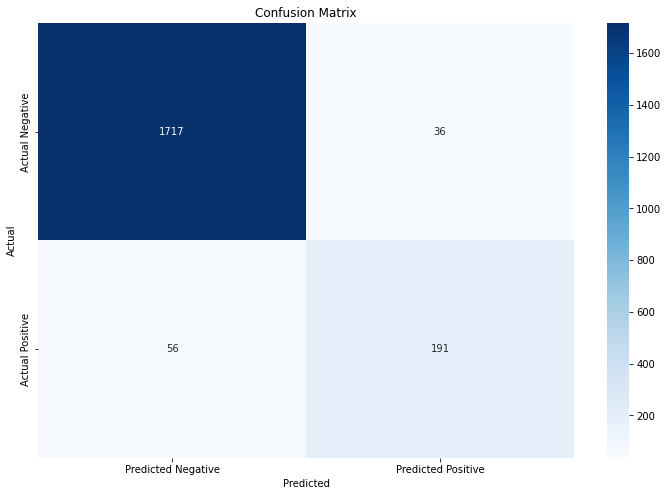

In [135]:
# Our Metrics

print(f"Test accuracy : {accuracy_score(y_test, y_pred_lgb_f1_2):.3f}")
print(f"Test precision: {precision_score(y_test, y_pred_lgb_f1_2, zero_division=0):.3f}")
print(f"Test recall   : {recall_score(y_test, y_pred_lgb_f1_2):.3f}")
print(f"Test F1       : {f1_score(y_test, y_pred_lgb_f1_2):.3f}")
print(f"Test MCC      : {matthews_corrcoef(y_test, y_pred_lgb_f1_2):.3f}")
print(f"Test Profit   : {profit_score(best_model_lgb_f1_2, X_test, y_pred_lgb_f1_2):.3f}\n")

print(f"Training Data accuracy : {accuracy_score(y_train, y_pred_overfit_lgb_f1_2):.3f}")
print(f"Training Data precision: {precision_score(y_train, y_pred_overfit_lgb_f1_2, zero_division=0):.3f}")
print(f"Training Data recall   : {recall_score(y_train, y_pred_overfit_lgb_f1_2):.3f}")
print(f"Training Data F1       : {f1_score(y_train, y_pred_overfit_lgb_f1_2):.3f}")
print(f"Training Data MCC      : {matthews_corrcoef(y_train, y_pred_overfit_lgb_f1_2):.3f}")
print(f"Training Data Profit   : {profit_score(best_model_lgb_f1_2, X_train, y_pred_overfit_lgb_f1_2):.3f}\n")

cm_lgb_f1_2 = confusion_matrix(y_test, y_pred_lgb_f1_2)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_lgb_f1_2, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Light GBM - Precision

#### Light GBM - Precision - Iteration 1

In [137]:
start = time.time()

# retrieving indexes for impressions_total for the profit calculations

imp_idx = list(X_train.columns).index('impressions_total')

pipe_lgb_prec = Pipeline([
    ('lgb',    LGBMClassifier(random_state=0))
])

# parameters to check what combination performs best, but we use randomsearchcv to speed up the process, takes too long

params_lgb_prec = [
    {
      'lgb__n_estimators'     : randint(100, 401),            # 100–400
      'lgb__num_leaves'       : randint(20, 128),             # 20–127
      'lgb__max_depth'        : [-1, 10, 20],
      'lgb__class_weight': [
            'balanced',
            {0:1, 1:1},
            {0:1, 1:2},
            {0:1, 1:3}
        ]
    },
    {
      'lgb__n_estimators':     randint(100, 401),
      'lgb__learning_rate':    loguniform(0.01, 0.2),
      'lgb__num_leaves':       randint(20, 128),
      'lgb__min_child_samples':randint(30, 100),
      'lgb__subsample':        uniform(0.4, 1.4),
      'lgb__colsample_bytree': uniform(0.6, 1.4),
      'lgb__class_weight':     [
            'balanced',
            {0:1, 1:1},
            {0:1, 1:2},
            {0:1, 1:3}
        ]
    }
]

# doing a randomsearchcv to save time, optimise for precision

cv_lgb_prec = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

randsearch_lgb_prec = RandomizedSearchCV(
    estimator            = pipe_lgb_prec,
    param_distributions  = params_lgb_prec,
    n_iter               = 200,
    cv                   = cv_lgb_prec,
    scoring              = 'precision',
    n_jobs               = -1,
    refit                = True
)        
print(f'inner cv done { (time.time() - start)/60:.2f}')

# Fit to the training data

randsearch_lgb_prec.fit(X_train, y_train)

print("→ Best parameters:", randsearch_lgb_prec.best_params_)
best_model_lgb_prec = randsearch_lgb_prec.best_estimator_

# do some cross validation to see how well the model generalises

eval_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_lgb_prec = cross_validate(
    estimator        = best_model_lgb_prec, 
    X                = X_train,
    y                = y_train,
    cv               = eval_cv,
    scoring          = scorers,
    return_estimator = True,
    n_jobs           = -1,
    error_score      = 'raise'
)

print("\nAverage metrics over outer folds:")
for m in scorers:
    vals = cv_lgb_prec[f'test_{m}']
    print(f" {m:14}:  {vals.mean():.3f} ± {vals.std():.3f}  -> {[f'{v:.3f}' for v in vals]}")

elapsed = time.time() - start
print(f"\nElapsed: {elapsed:.1f} s  (~{elapsed/60:.2f} min)")

inner cv done 0.00
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 987, number of negative: 7013
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123375 -> initscore=-1.960851
[LightGBM] [Info] Start training from score -1.960851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

→ Best parameters: {'lgb__class_weight': {0: 1, 1: 1}, 'lgb__max_depth': 10, 'lgb__n_estimators': 231, 'lgb__num_leaves': 116}

Average metrics over outer folds:
 accuracy      :  0.951 ± 0.005  -> ['0.949', '0.952', '0.946', '0.961', '0.946']
 precision     :  0.866 ± 0.034  -> ['0.867', '0.841', '0.853', '0.930', '0.837']
 recall        :  0.712 ± 0.028  -> ['0.695', '0.751', '0.675', '0.737', '0.702']
 f1            :  0.781 ± 0.025  -> ['0.772', '0.794', '0.754', '0.823', '0.764']
 mcc           :  0.758 ± 0.028  -> ['0.749', '0.768', '0.730', '0.808', '0.737']
 profit_score  :  0.911 ± 0.022  -> ['0.896', '0.914', '0.896', '0.953', '0.895']

Elapsed: 389.8 s  (~6.50 min)


In [138]:
# Make our prediction

proba_test_lgb_prec = best_model_lgb_prec.predict_proba(X_test)[:, 1]
y_pred_lgb_prec     = (proba_test_lgb_prec >= 0.5).astype(int)

# Look out for overfitting by predicting on the training dataset

proba_test_overfit_lgb_prec = best_model_lgb_prec.predict_proba(X_train)[:, 1]
y_pred_overfit_lgb_prec     = (proba_test_overfit_lgb_prec >= 0.5).astype(int)

Test accuracy : 0.951
Test precision: 0.886
Test recall   : 0.692
Test F1       : 0.777
Test MCC      : 0.757
Test Profit   : 0.789

Training Data accuracy : 1.000
Training Data precision: 1.000
Training Data recall   : 1.000
Training Data F1       : 1.000
Training Data MCC      : 1.000
Training Data Profit   : 1.011



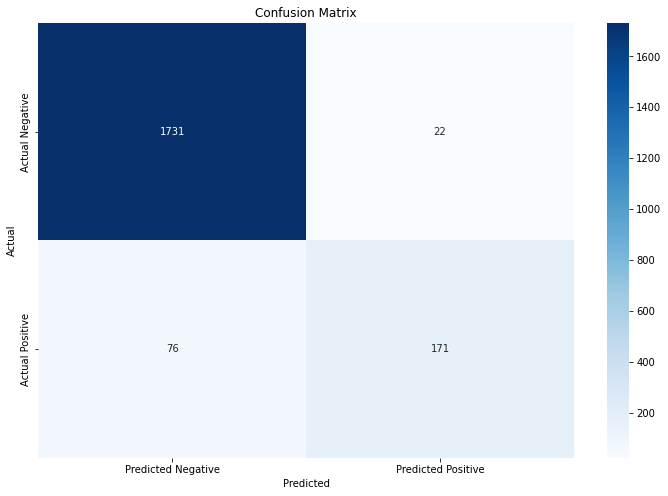

In [139]:
# Our metrics

print(f"Test accuracy : {accuracy_score(y_test, y_pred_lgb_prec):.3f}")
print(f"Test precision: {precision_score(y_test, y_pred_lgb_prec, zero_division=0):.3f}")
print(f"Test recall   : {recall_score(y_test, y_pred_lgb_prec):.3f}")
print(f"Test F1       : {f1_score(y_test, y_pred_lgb_prec):.3f}")
print(f"Test MCC      : {matthews_corrcoef(y_test, y_pred_lgb_prec):.3f}")
print(f"Test Profit   : {profit_score(best_model_lgb_prec, X_test, y_pred_lgb_prec):.3f}\n")

print(f"Training Data accuracy : {accuracy_score(y_train, y_pred_overfit_lgb_prec):.3f}")
print(f"Training Data precision: {precision_score(y_train, y_pred_overfit_lgb_prec, zero_division=0):.3f}")
print(f"Training Data recall   : {recall_score(y_train, y_pred_overfit_lgb_prec):.3f}")
print(f"Training Data F1       : {f1_score(y_train, y_pred_overfit_lgb_prec):.3f}")
print(f"Training Data MCC      : {matthews_corrcoef(y_train, y_pred_overfit_lgb_prec):.3f}")
print(f"Training Data Profit   : {profit_score(best_model_lgb_prec, X_train, y_pred_overfit_lgb_prec):.3f}\n")

cm_lgb_prec = confusion_matrix(y_test, y_pred_lgb_prec)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_lgb_prec, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Threshold Tuning

In [168]:
# Identify the optimal threshold probability to register a click

probs = final_lr_f1_2.predict_proba(X_test)[:,1]
y_true = y_test.values

# Compute precision/recall at every possible threshold
precisions, recalls, thresholds = precision_recall_curve(y_true, probs)

# Choose t to maximize F1
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-12)
ix_max = f1_scores.argmax()
best_t_for_f1 = thresholds[ix_max]
print(f"Threshold for max F1: {best_t_for_f1:.3f} (F1={f1_scores[ix_max]:.3f})")

# Choose t to maximize profit
click_val = 8.42
imp_cost  = 2.85/1000
best_profit, best_t = -1e9, None
for t in np.linspace(0,1,101):
    mask = probs >= t
    if not mask.any(): 
        continue
    tp = (y_true[mask]==1).sum()
    cost = X_test.loc[mask, 'impressions_total'].sum() * imp_cost
    profit = tp*click_val - cost
    if profit > best_profit:
        best_profit, best_t = profit, t
print(f"Threshold for max profit: {best_t:.3f} (Profit per user = {best_profit/len(y_test):.3f})")

Threshold for max F1: 0.344 (F1=0.889)
Threshold for max profit: 0.070 (Profit per user = 1.000)


In [176]:
# Iterate through different precision thresholds to see how they perform across metrics

for target_prec in np.arange(0.88, 0.98, 0.01):
    ix = next(i for i,p in enumerate(precisions) if p >= target_prec)
    t = thresholds[ix]
    p, r = precisions[ix], recalls[ix]
    f = 2*p*r/(p+r)
    
    mask = probs >= t
    tp = (y_true[mask] == 1).sum()
    total_imps = X_test.loc[mask, 'impressions_total'].sum()
    profit = tp * click_val - total_imps * imp_cost
    profit_per_user = profit / len(y_true)
    
    print(f"\nAt precision ≥{target_prec:.2f} @ t={t:.3f}: "
          f"Prec={p:.3f}, Rec={r:.3f}, F1={f:.3f}, Profit/user={profit_per_user:.3f}")


At precision ≥0.88 @ t=0.524: Prec=0.882, Rec=0.874, F1=0.878, Profit/user=0.881

At precision ≥0.89 @ t=0.571: Prec=0.892, Rec=0.866, F1=0.879, Profit/user=0.873

At precision ≥0.90 @ t=0.617: Prec=0.901, Rec=0.850, F1=0.875, Profit/user=0.857

At precision ≥0.91 @ t=0.626: Prec=0.913, Rec=0.850, F1=0.881, Profit/user=0.857

At precision ≥0.92 @ t=0.663: Prec=0.923, Rec=0.830, F1=0.874, Profit/user=0.837

At precision ≥0.93 @ t=0.701: Prec=0.930, Rec=0.810, F1=0.866, Profit/user=0.817

At precision ≥0.94 @ t=0.736: Prec=0.943, Rec=0.806, F1=0.869, Profit/user=0.813

At precision ≥0.95 @ t=0.828: Prec=0.952, Rec=0.729, F1=0.826, Profit/user=0.735

At precision ≥0.96 @ t=0.834: Prec=0.963, Rec=0.729, F1=0.829, Profit/user=0.735

At precision ≥0.97 @ t=0.865: Prec=0.971, Rec=0.684, F1=0.803, Profit/user=0.690


A threshold of 0.626 is chosen:
- With a precision of 0.91, it meets the criteria of a focused investment strategy
- With an F1-score of 0.881, it is very close to the optimum F1-Score of 0.889
    - This means a good recall as well (85%)

# Predictions

In [443]:
# Let's retrain on all data now

X = pd.concat([X_train, X_test]).sort_index()
y = pd.concat([y_train, y_test]).sort_index()

In [444]:
# Recreating all metrics on the prediction dataset

to_predict = prediction[:]
to_predict = to_predict.rename(columns={'Unnamed: 0':'id'})
to_predict['impressions_total'] = to_predict.iloc[:, 1:-1].sum(axis=1)
to_predict_unpivot = to_predict.melt(id_vars='id',
                                     value_vars=to_predict.columns.difference(['id']),
                                     var_name='platform',
                                     value_name='impressions'
                                    )
to_predict_unpivot = pd.merge(to_predict_unpivot, webdesc[['Name','Category']], left_on='platform', right_on='Name', how='left')
to_predict = to_predict_unpivot[['id','Category','impressions']].groupby(by=['id','Category']).agg(impressions_total=('impressions','sum'),
                                                                                                   impressions_std=('impressions','std'))
#pivoted = 
to_predict = to_predict.pivot_table(
     index='id',
     columns='Category',
     values=['impressions_total', 'impressions_std']
)
to_predict = to_predict.reset_index()
to_predict.columns = [f"{col2}_{col1}" if col2 else f"{col1}" for col1, col2 in to_predict.columns]
to_predict = pd.merge(prediction.rename(columns={'Unnamed: 0':'id'}), to_predict, on='id', how='left')
to_predict['distinct_site_count'] = (to_predict[fields_o] > 0).sum(axis=1)
to_predict['social_engagement_total'] = to_predict['Social Bookmarking_impressions_total'] + to_predict['Social Networking_impressions_total'] + to_predict['Micro-Blogging_impressions_total'] + to_predict['Foursquare'] + to_predict['Conduit']
to_predict['impressions_total'] = to_predict[fields_o].sum(axis=1)
to_predict['social_engagement_pc'] = to_predict['social_engagement_total']/to_predict['impressions_total']
to_predict['media_sharing_total'] = to_predict['Photo Sharing_impressions_total'] + to_predict['Video Sharing_impressions_total']
to_predict['aggregations_and_analytics_total'] = to_predict['Social Media Aggregator_impressions_total'] + to_predict['User-Generated Content Aggregator_impressions_total'] + to_predict['Social Media Measurement_impressions_total']
to_predict['aggregations_and_analytics_pc'] = to_predict['aggregations_and_analytics_total']/to_predict['impressions_total']
to_predict['information_total'] = to_predict['Blog_impressions_total'] + to_predict['News_impressions_total'] + to_predict['Opinions Site_impressions_total']
to_predict['information_pc'] = to_predict['information_total']/to_predict['impressions_total']
to_predict['utilities_and_tools_total'] = to_predict['Content / CMS_impressions_total'] + to_predict['Documents_impressions_total'] + to_predict['Opinions Site_impressions_total'] + to_predict['Foursquare'] + to_predict['Conduit'] + to_predict['Feedburner']
to_predict['utilities_and_tools_pc'] = to_predict['utilities_and_tools_total']/to_predict['impressions_total']

fields_sg = ['social_engagement_total','media_sharing_total', 'aggregations_and_analytics_total', 'information_total','utilities_and_tools_total']

to_predict['distinct_group_count'] = (to_predict[fields_sg] > 0).sum(axis=1)
to_predict['group_entropy'] = to_predict[fields_sg].div(to_predict['impressions_total'], axis=0).fillna(0).apply(lambda row: entropy(row, base=2), axis=1)

fields_entropy = list(imp_pc[imp_pc['all_impressions_pc']>=0.015].sort_values('all_impressions_pc', ascending=False).index)
fields_entropy_disc = list(imp_pc[imp_pc['all_impressions_pc']<0.015].sort_values('all_impressions_pc', ascending=False).index)
to_predict['entropy_other_impressions'] = to_predict[fields_entropy_disc].sum(axis=1)
fields_entropy.append('entropy_other_impressions')

to_predict['site_entropy'] = to_predict[fields_entropy].div(to_predict['impressions_total'], axis=0).fillna(0).apply(lambda row: entropy(row, base=2), axis=1)

for i in top_imp_cols:
    to_predict[f"{i}_topcol_flag"] = (to_predict[i] == to_predict[fields_o].max(axis=1)).astype(int)

to_predict['most_impressions_value'] = to_predict[fields_o].max(axis=1)

## set the value
heavy_user_threshold = 92

light_user_threshold = 30
##

to_predict['heavy_user_flag'] = (to_predict['impressions_total'] > heavy_user_threshold).astype(int)

to_predict['light_user_flag'] = (to_predict['impressions_total'] < light_user_threshold).astype(int)

to_predict['top_site_tie_count'] = (to_predict[fields_o] == to_predict[fields_o].max(axis=1).to_numpy()[:, None]).sum(axis=1)

to_predict['log2_impressions'] = np.log2(to_predict['impressions_total'])

to_predict['Bebo_2-3'] = np.where((to_predict['Bebo']==2) | (to_predict['Bebo']==3), 1, 0)

to_predict['Bebo_4+'] = np.where(to_predict['Bebo']>=4, 1, 0)

to_predict['social_engagement_pc+30'] = np.where(to_predict['social_engagement_pc']>=0.3, 1, 0)

to_predict['utilities_and_tools_pc+16.5'] = np.where(to_predict['social_engagement_pc']>=0.165, 1, 0)

to_predict['Other_topcol_flag'] = (to_predict[topcol_flag_keep] == 0).all(axis=1).astype(int)

In [445]:
# filter for the colums in the feature selection

to_predict = to_predict[selected_cols]

In [446]:
# checking it's the same as in X_train

to_predict.columns[:-1] == X_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [447]:
# Fitting our model to all the data

pipe_final_model__lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr',   LogisticRegression(C=3.5, penalty='l2',class_weight={0: 1, 1: 1}, solver='liblinear', random_state=0))
])

# Fitting our prediction data to our model

pipe_final_model__lr.fit(X, y)
probs_final_model__lr      = pipe_final_model__lr.predict_proba(to_predict.iloc[:, :-1])[:, 1]
pred_final_model__lr     = (probs_final_model__lr >= 0.626).astype(int)

to_predict['pred_proba']  = probs_final_model__lr
to_predict['pred_click']  = pred_final_model__lr

In [448]:
# checking for nulls

assert not to_predict[selected_cols].isna().any().any()

In [449]:
# seeing how many clicks we predicted

print(int(pred_final_model__lr.sum()), "out of", len(pred_final_model__lr), "predicted clicks")

91 out of 1000 predicted clicks


In [450]:
# appending our predictions to our prediction dataset

prediction_table = prediction.rename(columns={'Unnamed: 0': 'id'})
prediction_table = (
    prediction_table
    .merge(
        to_predict[['id', 'pred_click']],
        on='id',
        how='left'
    )
    .rename(columns={'pred_click': 'ClickPrediction'})
)

In [451]:
# checking we have the right number of rows and that we haven't missed any rows for predictions

print(prediction_table.shape[0], "rows")
print(prediction_table['ClickPrediction'].isna().sum(), "missing predictions?")

1000 rows
0 missing predictions?


In [668]:
prediction_table

In [667]:
prediction_table.to_csv(r"C:\Users\fshad\OneDrive\Documents\CV guide\Interview Prep and Others\Omnicom - PHD\prediction_results.csv", index=False, sep=",")

# Heuristic Investment Strategy

In [453]:
# Standardising our coefficients and taking the absolute standardised coefficients to get a sense of the feature importance

coefficients              = pipe_final_model__lr.named_steps['lr'] .coef_[0]
feature_std               = X[selected_cols[:-1]].std()
standardized_coefficients = coefficients * feature_std
feature_importance        = pd.DataFrame({
    'Feature'                          : X[selected_cols[:-1]].columns,
    'Original Coefficient'             : coefficients,
    'Standardized Coefficient'         : standardized_coefficients,
    'Absolute Standardized Coefficient': np.abs(standardized_coefficients)
}).sort_values('Absolute Standardized Coefficient', ascending=False)

In [454]:
pd.set_option('display.max_rows', None)   # None = no truncation
display(feature_importance)
pd.reset_option('display.max_rows')

Feature  \
impressions_total                                                                   impressions_total   
information_total                                                                   information_total   
social_engagement_total                                                       social_engagement_total   
Facebook                                                                                     Facebook   
Opinions Site_impressions_total                                       Opinions Site_impressions_total   
entropy_other_impressions                                                   entropy_other_impressions   
utilities_and_tools_total                                                   utilities_and_tools_total   
Wordpress                                                                                   Wordpress   
Other_impressions_total                                                       Other_impressions_total   
Livejournal                                                                               Livejournal   
media_sharing_total                                                               media_sharing_total   
Typepad                                                                                       Typepad   
Photo Sharing_impressions_total                                       Photo Sharing_impressions_total   
distinct_site_count                                                               distinct_site_count   
Social Bookmarking_impressions_total                             Social Bookmarking_impressions_total   
aggregations_and_analytics_total                                     aggregations_and_analytics_total   
Blogcatalog                                                                               Blogcatalog   
Metacafe                                                                                     Metacafe   
Xanga                                                                                           Xanga   
Mashable                                                                                     Mashable   
Content / CMS_impressions_total                                       Content / CMS_impressions_total   
Ning                                                                                             Ning   
Yelp                                                                                             Yelp   
Mybloglog                                                                                   Mybloglog   
User-Generated Content Aggregator_impressions_t...  User-Generated Content Aggregator_impressions_...   
Photobucket                                                                               Photobucket   
Kaboodle                                                                                     Kaboodle   
Technorati                                                                                 Technorati   
Thisnext                                                                                     Thisnext   
Flickr                                                                                         Flickr   
Scribd                                                                                         Scribd   
Stumbleupon                                                                               Stumbleupon   
Linkedin                                                                                     Linkedin   
Tumblr                                                                                         Tumblr   
Epinions                                                                                     Epinions   
Micro-Blogging_impressions_total                                     Micro-Blogging_impressions_total   
Vimeo                                                                                           Vimeo   
Social Media Aggregator_impressions_total                   Social Media Aggregator_impressions_total   

Determine the Profit based on the probability of a click and the number of impressions for each column

In [531]:
# now let's see which fields had a posotive effect

strategy = feature_importance[feature_importance['Standardized Coefficient']>0]

In [532]:
pd.set_option('display.max_rows', None)   # None = no truncation
display(strategy)
pd.reset_option('display.max_rows')

Feature  \
impressions_total                                                                   impressions_total   
information_total                                                                   information_total   
social_engagement_total                                                       social_engagement_total   
Opinions Site_impressions_total                                       Opinions Site_impressions_total   
entropy_other_impressions                                                   entropy_other_impressions   
Wordpress                                                                                   Wordpress   
Other_impressions_total                                                       Other_impressions_total   
Livejournal                                                                               Livejournal   
media_sharing_total                                                               media_sharing_total   
Typepad                                                                                       Typepad   
Photo Sharing_impressions_total                                       Photo Sharing_impressions_total   
distinct_site_count                                                               distinct_site_count   
Social Bookmarking_impressions_total                             Social Bookmarking_impressions_total   
aggregations_and_analytics_total                                     aggregations_and_analytics_total   
Blogcatalog                                                                               Blogcatalog   
Metacafe                                                                                     Metacafe   
Xanga                                                                                           Xanga   
Mashable                                                                                     Mashable   
Content / CMS_impressions_total                                       Content / CMS_impressions_total   
Ning                                                                                             Ning   
Yelp                                                                                             Yelp   
Mybloglog                                                                                   Mybloglog   
User-Generated Content Aggregator_impressions_t...  User-Generated Content Aggregator_impressions_...   
Photobucket                                                                               Photobucket   
Kaboodle                                                                                     Kaboodle   
Technorati                                                                                 Technorati   
Thisnext                                                                                     Thisnext   
Flickr                                                                                         Flickr   
Scribd                                                                                         Scribd   
Linkedin                                                                                     Linkedin   
Tumblr                                                                                         Tumblr   
Epinions                                                                                     Epinions   
Vimeo                                                                                           Vimeo   
Social Media Aggregator_impressions_total                   Social Media Aggregator_impressions_total   
Pinterest                                                                                   Pinterest   
Slideshare                                                                                 Slideshare   
Mouthshut                                                                                   Mouthshut   
Orkut                                                                                           Orkut   

In [533]:
# we're going to remove columns that either say "more impressions means more likely to click", uplifts, spreads and 
# anything else that doesn't tell us where to advertise

strategy = strategy.drop(['impressions_total', 'entropy_other_impressions', 'distinct_site_count','distinct_group_count',
                         'light_user_flag','social_engagement_pc','group_entropy','Other_topcol_flag',
                         'Wordpress_topcol_flag','Other_topcol_flag'], axis=0)

In [534]:
# Now let's see what proportion of "site" and "site agglomeration" fields have the biggest impact

strategy['Standardised Coefficient Sum'] = strategy['Absolute Standardized Coefficient'].sum(axis=0)
strategy['Standardised Coefficient PC'] = strategy['Absolute Standardized Coefficient']*100/strategy['Standardised Coefficient Sum']


In [535]:
pd.set_option('display.max_rows', None)   # None = no truncation
display(strategy)
pd.reset_option('display.max_rows')

Feature  \
information_total                                                                   information_total   
social_engagement_total                                                       social_engagement_total   
Opinions Site_impressions_total                                       Opinions Site_impressions_total   
Wordpress                                                                                   Wordpress   
Other_impressions_total                                                       Other_impressions_total   
Livejournal                                                                               Livejournal   
media_sharing_total                                                               media_sharing_total   
Typepad                                                                                       Typepad   
Photo Sharing_impressions_total                                       Photo Sharing_impressions_total   
Social Bookmarking_impressions_total                             Social Bookmarking_impressions_total   
aggregations_and_analytics_total                                     aggregations_and_analytics_total   
Blogcatalog                                                                               Blogcatalog   
Metacafe                                                                                     Metacafe   
Xanga                                                                                           Xanga   
Mashable                                                                                     Mashable   
Content / CMS_impressions_total                                       Content / CMS_impressions_total   
Ning                                                                                             Ning   
Yelp                                                                                             Yelp   
Mybloglog                                                                                   Mybloglog   
User-Generated Content Aggregator_impressions_t...  User-Generated Content Aggregator_impressions_...   
Photobucket                                                                               Photobucket   
Kaboodle                                                                                     Kaboodle   
Technorati                                                                                 Technorati   
Thisnext                                                                                     Thisnext   
Flickr                                                                                         Flickr   
Scribd                                                                                         Scribd   
Linkedin                                                                                     Linkedin   
Tumblr                                                                                         Tumblr   
Epinions                                                                                     Epinions   
Vimeo                                                                                           Vimeo   
Social Media Aggregator_impressions_total                   Social Media Aggregator_impressions_total   
Pinterest                                                                                   Pinterest   
Slideshare                                                                                 Slideshare   
Mouthshut                                                                                   Mouthshut   
Orkut                                                                                           Orkut   
Foursquare                                                                                 Foursquare   
Screencast                                                                                 Screencast   
Mixx                                                                                             Mixx   

In [536]:
# avoid these sites, and consider the negative effects on clicks (like site impression spread - site entropy)

avoid = feature_importance[feature_importance['Standardized Coefficient']<=0]
avoid

Feature  \
Facebook                                                  Facebook   
utilities_and_tools_total                utilities_and_tools_total   
Stumbleupon                                            Stumbleupon   
Micro-Blogging_impressions_total  Micro-Blogging_impressions_total   
site_entropy                                          site_entropy   
heavy_user_flag                                    heavy_user_flag   
social_engagement_pc+30                    social_engagement_pc+30   
Bebo                                                          Bebo   
Addthis                                                    Addthis   
Blogger_topcol_flag                            Blogger_topcol_flag   
Twitter_topcol_flag                            Twitter_topcol_flag   
utilities_and_tools_pc+16.5            utilities_and_tools_pc+16.5   
Conduit_topcol_flag                            Conduit_topcol_flag   
Pinterest_topcol_flag                        Pinterest_topcol_flag   

                                  Original Coefficient  \
Facebook                                     -1.175753   
utilities_and_tools_total                    -1.044644   
Stumbleupon                                  -0.556836   
Micro-Blogging_impressions_total             -0.119805   
site_entropy                                 -0.431117   
heavy_user_flag                              -0.127013   
social_engagement_pc+30                      -0.053190   
Bebo                                         -0.015390   
Addthis                                      -0.017694   
Blogger_topcol_flag                          -0.057211   
Twitter_topcol_flag                          -0.051224   
utilities_and_tools_pc+16.5                  -0.042265   
Conduit_topcol_flag                          -0.047510   
Pinterest_topcol_flag                        -0.018313   

                                  Standardized Coefficient  \
Facebook                                        -10.270708   
utilities_and_tools_total                        -5.526327   
Stumbleupon                                      -0.752913   
Micro-Blogging_impressions_total                 -0.529342   
site_entropy                                     -0.202749   
heavy_user_flag                                  -0.027233   
social_engagement_pc+30                          -0.023091   
Bebo                                             -0.022916   
Addthis                                          -0.017943   
Blogger_topcol_flag                              -0.017642   
Twitter_topcol_flag                              -0.012870   
utilities_and_tools_pc+16.5                      -0.010247   
Conduit_topcol_flag                              -0.009175   
Pinterest_topcol_flag                            -0.002757   

                                  Absolute Standardized Coefficient  
Facebook                                                  10.270708  
utilities_and_tools_total                                  5.526327  
Stumbleupon                                                0.752913  
Micro-Blogging_impressions_total                           0.529342  
site_entropy                                               0.202749  
heavy_user_flag                                            0.027233  
social_engagement_pc+30                                    0.023091  
Bebo                                                       0.022916  
Addthis                                                    0.017943  
Blogger_topcol_flag                                        0.017642  
Twitter_topcol_flag                                        0.012870  
utilities_and_tools_pc+16.5                                0.010247  
Conduit_topcol_flag                                        0.009175  
Pinterest_topcol_flag                                      0.002757

In [593]:
# We will take the probability of any row with at least 1 impression for each field that corresponds to a site, or
# an agglomeration of sites. Use that to determine how many clicks to expect from our table of all rows to predict.
# Compute the cost from the number of impressions for all rows. Then determine the profit or ROI from that.
# Then multiply the ROI to the absolute standardised coefficient so that we consider how much each field contributes to
# the model

click_val = 8.42
imp_cost  = 2.85 / 1000

# assume `to_predict` has columns strategy['Feature'] plus 'pred_proba'
roi_list = []
for feat in strategy['Feature']:
    mask = to_predict[feat] > 0
    if mask.sum() == 0:
        # no one saw that feature → undefined ROI → give it 0
        roi_list.append((feat, 0.0))
        continue

    exp_clicks = to_predict.loc[mask, 'pred_proba'].sum()
    total_imps = to_predict.loc[mask, feat].sum()
    revenue    = exp_clicks * click_val
    cost       = total_imps  * imp_cost
    roi        = (revenue - cost) / cost
    roi_list.append((feat, roi))

roi_df = pd.DataFrame(roi_list, columns=['Feature','ROI'])

# now merge and compute budget weights
alloc = (
    strategy
    .merge(roi_df, on='Feature', how='left')
    .assign(
        priority   = lambda df: df['Absolute Standardized Coefficient'] * df['ROI'],
        budget_pct = lambda df: 100 * df['priority'] / df['priority'].sum()
    )
    .sort_values('budget_pct', ascending=False)
)

display(alloc[['Feature','Absolute Standardized Coefficient','ROI','priority','budget_pct']])

Feature  Absolute Standardized Coefficient  \
2   Opinions Site_impressions_total                           6.778172   
0                 information_total                          23.291682   
18                        Mybloglog                           1.160858   
23                         Thisnext                           0.873249   
7                           Typepad                           2.502139   
..                              ...                                ...   
68                          Bebo_4+                           0.031408   
41                          Blogger                           0.213013   
59                       Friendfeed                           0.080849   
58                       Feedburner                           0.081828   
70                         Download                           0.006558   

           ROI    priority  budget_pct  
2    87.834187  595.355231    7.151098  
0    22.424434  522.302803    6.273630  
18  426.475094  495.077037    5.946608  
23  504.792110  440.809282    5.294772  
7   153.319664  383.627128    4.607930  
..         ...         ...         ...  
68  381.108686   11.970032    0.143778  
41   51.145307   10.894619    0.130861  
59  122.964641    9.941627    0.119414  
58  102.763084    8.408928    0.101004  
70   79.690662    0.522595    0.006277  

[71 rows x 5 columns]

In [594]:
pd.set_option('display.max_rows', None)
display(alloc[['Feature','Absolute Standardized Coefficient','ROI','priority','budget_pct']])
pd.reset_option('display.max_rows')

Feature  \
2                     Opinions Site_impressions_total   
0                                   information_total   
18                                          Mybloglog   
23                                           Thisnext   
7                                             Typepad   
5                                         Livejournal   
11                                        Blogcatalog   
21                                           Kaboodle   
3                                           Wordpress   
14                                           Mashable   
17                                               Yelp   
9                Social Bookmarking_impressions_total   
13                                              Xanga   
28                                           Epinions   
4                             Other_impressions_total   
22                                         Technorati   
1                             social_engagement_total   
33                                          Mouthshut   
15                    Content / CMS_impressions_total   
12                                           Metacafe   
19  User-Generated Content Aggregator_impressions_...   
8                     Photo Sharing_impressions_total   
25                                             Scribd   
47                                        Sliderocket   
10                   aggregations_and_analytics_total   
16                                               Ning   
36                                         Screencast   
51                                           Kickapps   
29                                              Vimeo   
37                                               Mixx   
27                                             Tumblr   
43                                           Newsvine   
48         Social Media Measurement_impressions_total   
38                                          Propeller   
42                                          Posterous   
35                                         Foursquare   
32                                         Slideshare   
39                                              Yfrog   
6                                 media_sharing_total   
46                                              Faves   
20                                        Photobucket   
40                                            Docstoc   
26                                           Linkedin   
49                                          Tweetdeck   
44                                              Plurk   
30          Social Media Aggregator_impressions_total   
24                                             Flickr   
31                                          Pinterest   
34                                              Orkut   
45                                               Yuku   
53                                              Plaxo   
54                                               Ping   
62                                              Vocus   
50                                           Slashdot   
67                                            Lithium   
63                                            Sysomos   
64                                          Sharethis   
56                                             Meetup   
69                                              Twine   
61                                           Bebo_2-3   
66                                           Startaid   
60                                           Jumptags   
65                                            Radian6   
55                             News_impressions_total   
52                                             Reddit   
57                                             Joomla   
68                                            Bebo_4+   
41                                            Blogger   
59                                         Friendfeed   
58                                         Feedburner   

## Selected Budget Allocation for Investment Strategy

In [627]:
investment = alloc[['Feature','Absolute Standardized Coefficient','ROI','priority','budget_pct']]

In [638]:
investment.head(30)#['budget_pct'].sum()

index                                            Feature  \
0       0                    Opinions Site_impressions_total   
1       1                                  information_total   
2       2                                          Mybloglog   
3       3                                           Thisnext   
4       4                                            Typepad   
5       5                                        Livejournal   
6       6                                        Blogcatalog   
7       7                                           Kaboodle   
8       8                                          Wordpress   
9       9                                           Mashable   
10     10                                               Yelp   
11     11               Social Bookmarking_impressions_total   
12     12                                              Xanga   
13     13                                           Epinions   
14     14                            Other_impressions_total   
15     15                                         Technorati   
16     16                            social_engagement_total   
17     17                                          Mouthshut   
18     18                    Content / CMS_impressions_total   
19     19                                           Metacafe   
20     20  User-Generated Content Aggregator_impressions_...   
21     21                    Photo Sharing_impressions_total   
22     22                                             Scribd   
23     23                                        Sliderocket   
24     24                   aggregations_and_analytics_total   
25     25                                               Ning   
26     26                                         Screencast   
27     27                                           Kickapps   
28     28                                              Vimeo   
29     29                                               Mixx   

    Absolute Standardized Coefficient         ROI    priority  budget_pct  \
0                            6.778172   87.834187  595.355231    7.151098   
1                           23.291682   22.424434  522.302803    6.273630   
2                            1.160858  426.475094  495.077037    5.946608   
3                            0.873249  504.792110  440.809282    5.294772   
4                            2.502139  153.319664  383.627128    4.607930   
5                            3.462690   99.117741  343.214024    4.122509   
6                            1.531484  223.808941  342.759795    4.117053   
7                            0.910540  356.684374  324.775284    3.901032   
8                            4.131680   74.193430  306.543513    3.682042   
9                            1.241696  205.930126  255.702538    3.071366   
10                           1.162374  219.098939  254.674884    3.059022   
11                           1.778945  124.410995  221.320278    2.658384   
12                           1.286387  164.816605  212.017876    2.546649   
13                           0.536682  391.532287  210.128185    2.523951   
14                           3.535964   58.745254  207.721124    2.495038   
15                           0.896231  209.898219  188.117295    2.259567   
16                          14.812142   12.031862  178.217645    2.140658   
17                           0.388139  412.937513  160.277165    1.925166   
18                           1.227569  127.048331  155.960539    1.873317   
19                           1.407223  102.551110  144.312246    1.733404   
20                           1.100434  101.693402  111.906877    1.344167   
21                           2.419310   45.595289  110.309154    1.324976   
22                           0.757003  138.184599  104.606143    1.256475   
23                           0.166957  623.405546  104.081985    1.250179   
24                           1.729985   57.016797   98.638191    1.184791   
25               

# Presentation Visualisations

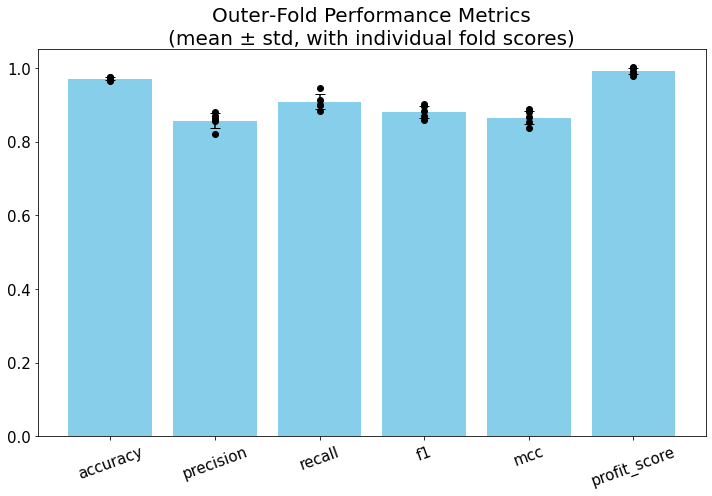

In [604]:
metrics = ['accuracy','precision','recall','f1','mcc','profit_score']
means   = [0.970,     0.857,      0.908,   0.881,  0.865,      0.991]
stds    = [0.004,     0.020,      0.021,   0.016,  0.018,      0.008]

# The raw fold values (as strings in your printout), convert to floats:
fold_vals = [
    [0.974, 0.971, 0.968, 0.974, 0.963],
    [0.861, 0.868, 0.857, 0.879, 0.820],
    [0.944, 0.898, 0.883, 0.914, 0.899],
    [0.901, 0.883, 0.870, 0.896, 0.858],
    [0.887, 0.866, 0.852, 0.881, 0.838],
    [0.989, 0.978, 0.988, 1.001, 1.000],
]

x = np.arange(len(metrics))

plt.figure(figsize=(10, 7))

# Bar chart of means + error bars
plt.bar(x, means, yerr=stds, capsize=5, color='skyblue', label='Mean ± SD')

# Scatter the individual fold scores
for i, vals in enumerate(fold_vals):
    plt.scatter([i]*len(vals), vals, color='k', zorder=10)

plt.xticks(x, metrics, rotation=20, fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0, 1.05)
# plt.ylabel('Score')
plt.title('Outer‐Fold Performance Metrics\n(mean ± std, with individual fold scores)', fontsize=20)
# plt.legend(loc='top')
plt.tight_layout()
plt.show()

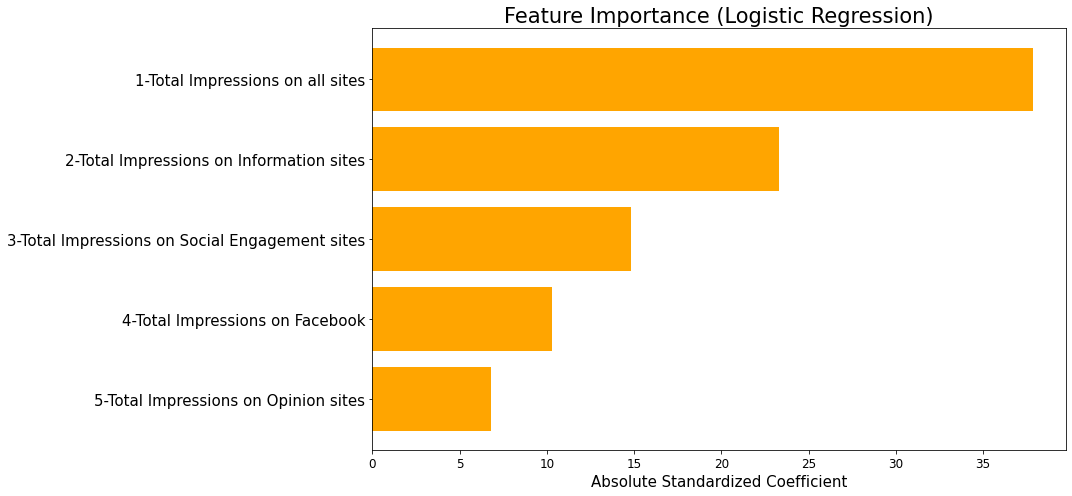

In [612]:
features = [
    "1-Total Impressions on all sites",
    "2-Total Impressions on Information sites",
    "3-Total Impressions on Social Engagement sites",
    "4-Total Impressions on Facebook",
    "5-Total Impressions on Opinion sites"
]

#plt.figure(figsize=(15, 12))

abs_std_coef = [37.84, 23.29, 14.81, 10.27, 6.78]   # from your table

plt.figure(figsize=(15,7))
plt.barh(features[::-1], abs_std_coef[::-1], color="orange")  # reverse for descending order
plt.xlabel("Absolute Standardized Coefficient", fontsize=15)
plt.title("Feature Importance (Logistic Regression)", fontsize=21)
plt.xticks(fontsize=12)                    # optional: change x-tick size
plt.yticks(fontsize=15)  
plt.tight_layout()
plt.show()

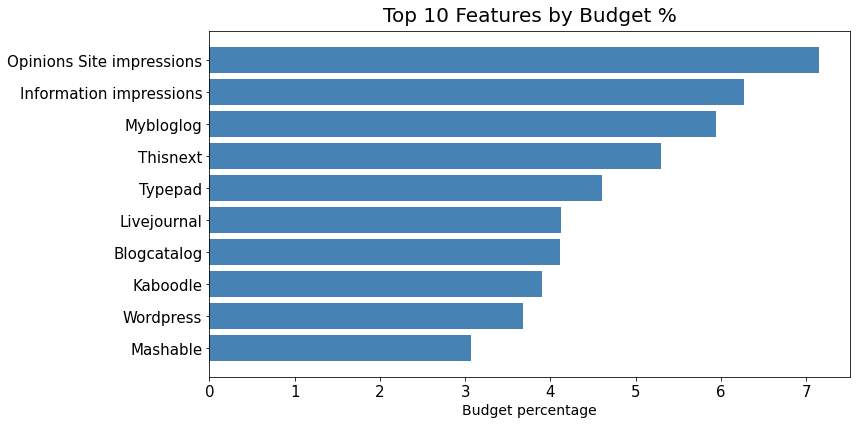

In [619]:
ex1 = {
    "Feature": [
        "Opinions Site impressions",
        "Information impressions",
        "Mybloglog",
        "Thisnext",
        "Typepad",
        "Livejournal",
        "Blogcatalog",
        "Kaboodle",
        "Wordpress",
        "Mashable"
    ],
    "Budget %": [7.151098, 6.273630, 5.946608, 5.294772,
                 4.607930, 4.122509, 4.117053, 3.901032,
                 3.682042, 3.071366]
}

ex2 = pd.DataFrame(ex1)

# ─── 2. Sort (largest → smallest) so bars descend nicely ───────────────────────
ex2 = ex2.sort_values("Budget %", ascending=False)

# ─── 3. Plot ───────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
plt.barh(ex2["Feature"], ex2["Budget %"], color="steelblue")
plt.gca().invert_yaxis()            # largest at top
plt.xlabel("Budget percentage", fontsize=14)
plt.title("Top 10 Features by Budget %", fontsize=20, pad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

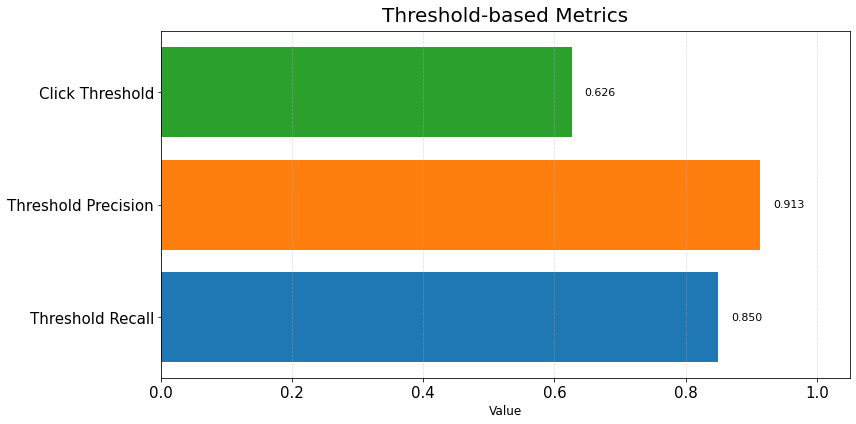

In [643]:
metrics = ["Click Threshold", "Threshold Precision", "Threshold Recall"]
values  = [0.626, 0.913, 0.850]

# ── plot ───────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
plt.barh(metrics[::-1], values[::-1], color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.xlim(0, 1.05)
plt.xlabel("Value", fontsize=12)
plt.title("Threshold-based Metrics", fontsize=20, pad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis="x", linestyle="--", alpha=0.4)

# annotate value labels
for y, v in enumerate(values[::-1]):
    plt.text(v + 0.02, y, f"{v:.3f}", va="center", fontsize=11)

plt.tight_layout()
plt.show()

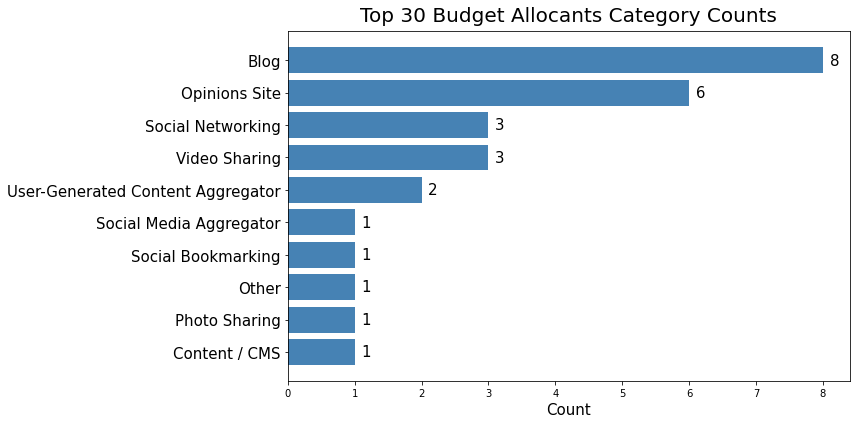

In [654]:
# Data
categories = [
    "Blog",
    "Opinions Site",
    "Social Media Aggregator",
    "Social Networking",
    "User-Generated Content Aggregator",
    "Video Sharing",
    "Social Bookmarking",
    "Other",
    "Photo Sharing",
    "Content / CMS"
]
counts = [8, 6, 1, 3, 2, 3, 1, 1, 1, 1]

# Sort (optional) largest → smallest for nicer layout
cats_sorted, cnts_sorted = zip(
    *sorted(zip(categories, counts), key=lambda x: x[1], reverse=True)
)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(cats_sorted, cnts_sorted, color="steelblue")
plt.xlabel("Count", fontsize=15)
plt.yticks(fontsize=15)
# plt.yticks(None)
# plt.ylabel("Category", fontsize=15)
plt.title("Top 30 Budget Allocants Category Counts", fontsize=20, pad=10)
plt.gca().invert_yaxis()          # largest at top

# Label bars with counts
for y, v in enumerate(cnts_sorted):
    plt.text(v + 0.1, y, str(v), va="center", fontsize=15)

plt.tight_layout()
plt.show()

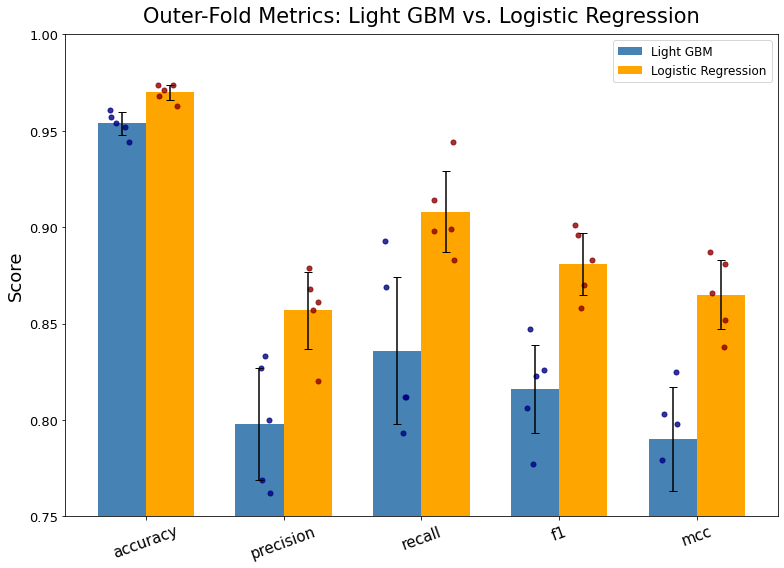

In [664]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'mcc']

# Light GBM (previous “Model A”)
means_LGB  = [0.954, 0.798, 0.836, 0.816, 0.790]
stds_LGB   = [0.006, 0.029, 0.038, 0.023, 0.027]
folds_LGB  = [
    [0.952, 0.954, 0.957, 0.961, 0.944],   # accuracy folds
    [0.800, 0.769, 0.833, 0.827, 0.762],   # precision folds
    [0.812, 0.893, 0.812, 0.869, 0.793],   # recall folds
    [0.806, 0.826, 0.823, 0.847, 0.777],   # f1 folds
    [0.779, 0.803, 0.798, 0.825, 0.745]    # mcc folds
]

# Logistic Regression (previous “Model B”)
means_LR   = [0.970, 0.857, 0.908, 0.881, 0.865]
stds_LR    = [0.004, 0.020, 0.021, 0.016, 0.018]
folds_LR   = [
    [0.974, 0.971, 0.968, 0.974, 0.963],
    [0.861, 0.868, 0.857, 0.879, 0.820],
    [0.944, 0.898, 0.883, 0.914, 0.899],
    [0.901, 0.883, 0.870, 0.896, 0.858],
    [0.887, 0.866, 0.852, 0.881, 0.838]
]

# ── grouped-bar positions ───────────────────────────────────
x = np.arange(len(metrics))
w = 0.35          # bar width

plt.figure(figsize=(11, 8))

# Bars with error bars
plt.bar(x - w/2, means_LGB, w, yerr=stds_LGB, capsize=4,
        label='Light GBM', color='steelblue')
plt.bar(x + w/2, means_LR,  w, yerr=stds_LR,  capsize=4,
        label='Logistic Regression', color='orange')

# Jittered individual-fold dots
rng = np.random.default_rng(0)
for i in range(len(metrics)):
    jitter = rng.uniform(-w/4, w/4, len(folds_LGB[i]))
    plt.scatter(np.full_like(folds_LGB[i], x[i]-w/2)+jitter,
                folds_LGB[i],  s=25, color='navy',   alpha=0.8)
    plt.scatter(np.full_like(folds_LR[i],  x[i]+w/2)+jitter,
                folds_LR[i],   s=25, color='darkred', alpha=0.8)

# Labels & styling
plt.xticks(x, metrics, rotation=20, fontsize=15)
plt.yticks(fontsize=13)
# plt.xlabel('Metric', fontsize=15)
plt.ylabel('Score',  fontsize=18)
plt.ylim(0.75, 1.0)
plt.title('Outer-Fold Metrics: Light GBM vs. Logistic Regression',
          fontsize=21, pad=12)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()